In [4]:

import numpy as np

from lmfit import Parameters, Minimizer, fit_report, conf_interval, report_ci
import matplotlib.pyplot as plt
import uncertainties.unumpy as unp

###GAUSSIANA
def volume_fcn(x, a0, a1, a2, a3, a4, a5, a6, a7, a8):
    return a0 + np.exp(-(a1/x))*(a2/x**2.0 + a3/x + a4 + a5*x + a6*np.exp(-a7*(-a8+x)**2.0))

def CET_fcn(x, a0, a1, a2, a3, a4, a5, a6, a7, a8):
    dVdT = np.exp(-a1/x)*(a5-(2.0*a2)/x**3.0 - a3/x**2.0) + (a1*np.exp(-a1/x)*(a4+a2/x**2.0+a3/x+a5*x))/x**2.0
    CTE = dVdT/volume_fcn(x,a0, a1, a2, a3, a4, a5, a6, a7, a8)
    return CTE

def volume_fcn_unc(x, a0, a1, a2, a3, a4, a5, a6, a7, a8):
    return a0 + unp.exp(-(a1/x))*(a2/x**2.0 + a3/x + a4 + a5*x + a6*unp.exp(-a7*(-a8+x)**2.0))

def CET_fcn_unc(x, a0, a1, a2, a3, a4, a5, a6, a7, a8):
    dVdT = unp.exp(-a1/x)*(a5-(2.0*a2)/x**3.0 - a3/x**2.0) + (a1*unp.exp(-a1/x)*(a4+a2/x**2.0+a3/x+a5*x))/x**2.0
    CTE = dVdT/volume_fcn_unc(x,a0, a1, a2, a3, a4, a5, a6, a7, a8)
    return CTE


def CET_numerical(T,V):
    #linear extrapolation of volume at T=0
    v0 = V[0]-((V[1]-V[0])/(T[1]-T[0]))*T[0]
    T = np.insert(T, 0, 0.0)
    V = np.insert(V, 0, v0)
    CET = [0.0]
    for i in range(1,len(T)):
        CET.append((1.0/V[i])*(V[i]-V[i-1])/(T[i]-T[i-1]))
    return np.array(CET[1:])

def func2min(params, T, V, CET):
    parametros = [params[k] for k in params.keys()]
    model_vol = volume_fcn(T, *parametros)
    residual_vol = model_vol - V  
    return residual_vol

def fit_volume_vs_temperature(T, V, CET):
    
    params = Parameters()
    #GAUSSIANA
    params.add_many(('a0', 400,  True,       0,   8000,   None, None),
                    ('a1',   100,  True,     0,   2000,   None, None),
                    ('a2',   0,  False,   -150000,   150000,   None, None),
                    ('a3',   0,  True,   -3000,   3000,   None, None),
                    ('a4',   0,  True,   -5,   5,   None, None),
                    ('a5',   0.001,  True,   0.00001,   0.15,   None, None),
                    ('a6',   0.0,  False,   -5,   0.0,   None, None),
                    ('a7',   0.001,  False,   0.00001,   0.001,   None, None),
                    ('a8',   0.001,  False,   0,   300,   None, None)
                    )
  
    minimizer = Minimizer(func2min, params, fcn_args=(T, V, CET))
    
    #kws={'popsize':60,  'mutation':(0.8,1.2), 'recombination':0.8, 'updating':'deferred', 'workers':-1}
    #out = minimizer.minimize(method='differential_evolution', max_nfev=50000000,**kws)
    
    #kws = {'local':'L-BFGS-B', 'totaliter': 50, 'maxiter':20}
    kws = {'local':'L-BFGS-B', 'totaliter': 20, 'maxiter':5}
    out = minimizer.minimize(method='ampgo', **kws)
    
    fit = func2min(out.params, T, V,CET)
    
    print(fit_report(out), flush=True)
    print('Cost:',np.sum(fit))
    
    
    print('---------- DE bounds ----------')
    for k in out.params.keys():
        print('{0:3}:  {1: >8}\t{2: >12.6g}\t{3: >8}'.format(k,out.params[k].min,out.params[k].value,out.params[k].max))
        
    return out

def second_fit(T,V,CET,out):
    minimizer = Minimizer(func2min, out.params, fcn_args=(T, V, CET))
    result2 = minimizer.minimize(method='nelder')
    try:
        ci = conf_interval(minimizer, result2)
        report_ci(ci)
    except:
        print('!!! Confidence intervals could not be determined.')
    print(fit_report(result2), flush=True)
    return result2

def plot(x_data, y_data, x_fit, y_fit, z_data, z_fit, file):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,dpi=120,figsize=(10,3))
    ax1.plot(x_data, y_data, 'o', label='data')
    ax1.plot(x_fit, y_fit, '-',label='fit')
    ax1.set_ylabel('Volume (A3)')
    ax1.set_xlabel('Temperature (K)')
    ax1.legend()
    
    ax2.plot(x_data, 1e6*z_data, 'x',label='Data')
    ax2.plot(x_fit, 1e6*z_fit, label='Fit')
    ax2.set_xlabel('Temperature (K)')
    ax2.set_ylabel('CET (K$^{-6}$)')
    ax2.legend()
    plt.suptitle(file)
    plt.savefig(file.rstrip('dat')+'png')
    plt.show()
    
def plot_unc(x_data, y_data, x_fit, y_fit, y_unc, z_data, z_fit,z_unc, file):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,dpi=120,figsize=(10,3))
    #uncertainty band
    y_up = y_fit+y_unc
    y_down = y_fit-y_unc
    ax1.fill_between(x_fit, y_up, y_down, facecolor='#888888', alpha=0.25, label = '1$\sigma$', edgecolor=None)
    ax1.plot(x_data, y_data, '.', label='data')
    ax1.plot(x_fit, y_fit, '-',label='fit')
    ax1.set_ylabel('Volume (A3)')
    ax1.set_xlabel('Temperature (K)')
    ax1.legend()
    
    z_up = z_fit+z_unc
    z_down = z_fit-z_unc
    ax2.fill_between(x_fit, z_up, z_down, facecolor='#888888', alpha=0.25, label = '1$\sigma$', edgecolor=None)
    ax2.plot(x_data, 1e6*z_data, 'x',label='Data')
    ax2.plot(x_fit, 1e6*z_fit, label='Fit')
    ax2.set_xlabel('Temperature (K)')
    ax2.set_ylabel('CET (K$^{-6}$)')
    ax2.legend()
    plt.suptitle(file)
    plt.savefig(file.rstrip('dat')+'png')
    plt.show()
    
def plot2(x_data, y_data, x_fit, y_fit, y_fit2, z_data, z_fit, z_fit2, file):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,dpi=120,figsize=(10,3))
    ax1.plot(x_data, y_data, 'o', label='data')
    ax1.plot(x_fit, y_fit, ':',label='fit ampgo')
    ax1.plot(x_fit, y_fit2, '-',label='fit nm')
    ax1.set_ylabel('Volume (A3)')
    ax1.set_xlabel('Temperature (K)')
    ax1.legend()
    
    ax2.plot(x_data, 1e6*z_data, 'x',label='Data')
    ax2.plot(x_fit, 1e6*z_fit, ':', label='Fit ampgo')
    ax2.plot(x_fit, 1e6*z_fit2,'-', label='fit nm')
    ax2.set_xlabel('Temperature (K)')
    ax2.set_ylabel('CET (K$^{-6}$)')
    ax2.legend()
    plt.suptitle(file)
    plt.savefig(file.rstrip('dat')+'png')
    plt.show()

# 30% - 70%

############################################## Shrink ##############################################
##################### ./30_70/volume_vs_temperature00.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 31434
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00262574
    reduced chi-square = 1.0503e-04
    Akaike info crit   = -270.307661
    Bayesian info crit = -263.301674
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3389.27876 +/- 0.00492819 (0.00%) (init = 400)
    a1:  240.338039 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  316.864949 +/-        nan (nan%) (init = 0)
    a4: -4.37322710 +/-        nan (nan%) (init = 0)
    a5:  0.02162706 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.014974406553847075
---------- DE bounds ----------
a0 :         0	     3389.28	    8000
a1 :         0	     240.338	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     316.865	    3000
a4 :        -5	    -4.37323	       5
a5 :     1e-05	   0.0216271	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00438  -0.00438  -0.004383389.29428  +0.00219  +0.00219  +0.00219
 a1:  -0.81443  -0.58851      +nan 365.09360      +nan  +1.63438  +0.43673
 a3:  -1.67518  -0.74028      +nan 461.08825      +nan  +2.02407  +2.83732
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00003  -0.00029      +nan   0.02744      +nan  +0.00014  +0.00005
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1371
    # data points      = 30
    # variables        = 5
    chi-square         = 1.3866e-04
    reduced chi-square = 5.5464e-06
    Akaike info crit   = -358.540751
    Bayesian info crit = -351.534764
[[Variables]]
    a0:  3389.29428 +/- 0.00109593 (0.00%) (init = 3389.279)
    a1:  365.093602 +/- 7.60455797 (2.08%) (init = 240.338)
    a2:  0 (fixed)
    a3:  461.088248 +/- 9.32467291 (2.02%) (init = 316.8649)
    a4: -5.00000000 +/- 2.4458e-05 (0.00%) (init 

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.995083897284849) = 0.2714220781903634 < max(sigmas).
  warn(errmsg)


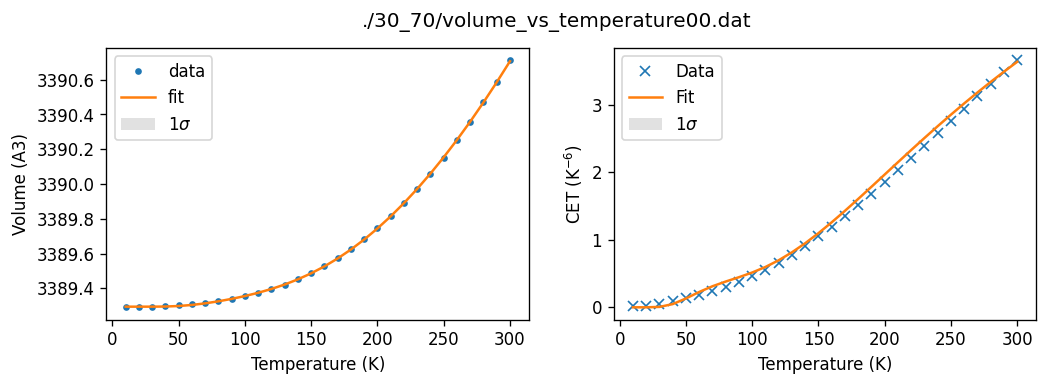

##################### ./30_70/volume_vs_temperature01.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36942
    # data points      = 30
    # variables        = 5
    chi-square         = 9.2233e-04
    reduced chi-square = 3.6893e-05
    Akaike info crit   = -301.694119
    Bayesian info crit = -294.688132
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3359.76117 +/- 0.00196999 (0.00%) (init = 400)
    a1:  669.846572 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -589.208001 +/-        nan (nan%) (init = 0)
    a4:  4.02923462 +/-        nan (nan%) (init = 0)
    a5:  0.03592590 +/- 0.00149271 (4.15%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a5) = -1.586


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.002286812023157836
---------- DE bounds ----------
a0 :         0	     3359.76	    8000
a1 :         0	     669.847	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -589.208	    3000
a4 :        -5	     4.02923	       5
a5 :     1e-05	   0.0359259	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0007492182156194081 < 1e-05 at iteration 6 and prob(a1=838.5337076152325) = 0.9888199001654618 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.8421313908522279) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a3=43.36976662888966) = 0.1927457126595759 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.5220371218529757 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=5) = 0.9643121673504192 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00814  -0.00814  -0.008143359.76244  +0.00814  +0.00814  +0.00814
 a1: -94.10165 -71.13280 -46.54499 514.60587 +63.67681+169.19557      +inf
 a3:      -inf      -inf      -inf   1.05266      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -3.91522  +2.58141  +7.58884      +inf
 a5:  -0.00590  -0.00320  -0.00163   0.03851  +0.00192  +0.00446      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1133
    # data points      = 30
    # variables        = 5
    chi-square         = 7.8802e-04
    reduced chi-square = 3.1521e-05
    Akaike info crit   = -306.415453
    Bayesian info crit = -299.409466
[[Variables]]
    a0:  3359.76244 +/- 0.00203417 (0.00%) (init = 3359.761)
    a1:  514.605873 +/- 53.9879724 (10.49%) (init = 669.8466)
    a2:  0 (fixed)
    a3:  1.05266424 +/- 187.038998 (17768.15%) (init = -589.208)
    a4: -3.91521812 +/- 1.85354925 (47.34%)

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0018185227813336056 < 1e-05 at iteration 5 and prob(a5=0.04713407381780686) = 0.9899335288122808 < max(sigmas).
  warn(errmsg)


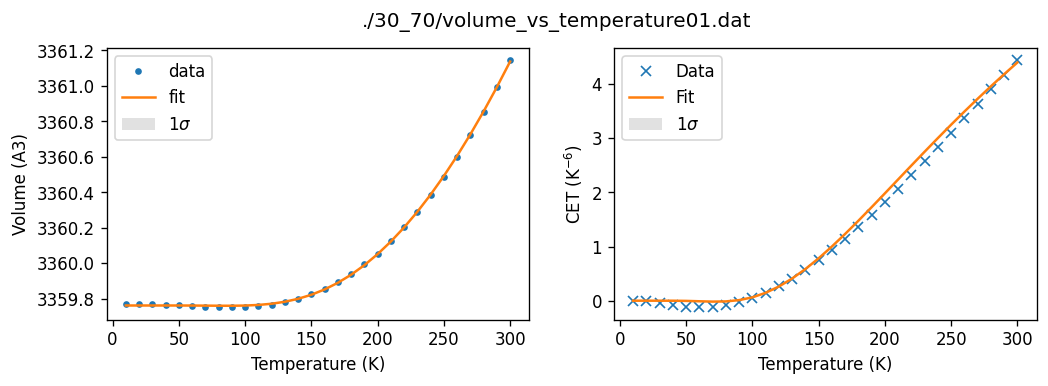

##################### ./30_70/volume_vs_temperature02.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33936
    # data points      = 30
    # variables        = 5
    chi-square         = 3.1927e-04
    reduced chi-square = 1.2771e-05
    Akaike info crit   = -333.519800
    Bayesian info crit = -326.513813
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3402.56415 +/- 9.8732e-04 (0.00%) (init = 400)
    a1:  666.928044 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -355.924549 +/-        nan (nan%) (init = 0)
    a4:  1.69903037 +/-        nan (nan%) (init = 0)
    a5:  0.03565780 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.0034359658125140413
---------- DE bounds ----------
a0 :         0	     3402.56	    8000
a1 :         0	     666.928	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -355.925	    3000
a4 :        -5	     1.69903	       5
a5 :     1e-05	   0.0356578	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.014224595728076828 < 1e-05 at iteration 6 and prob(a1=875.2464592220127) = 0.9687800807140542 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=7.161479117585623) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=10.742218676378434) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.793239932802787 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.01940013166864662 < 1e-05 at iteration 4 and prob(a4=3.7676443036426472) = 0.8950135038004945 < max(sigmas).
  warn(errmsg

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00474  -0.00474  -0.004743402.56463  +0.00474  +0.00474  +0.00474
 a1: -98.53170 -77.42041 -44.63770 553.37535 +62.29674+166.86604      +inf
 a3:      -inf      -inf      -inf   8.95185      +inf      +inf      +inf
 a4:      -inf      -inf  -1.28276  -3.44827  +2.42724      +inf      +inf
 a5:  -0.00384  -0.00303  -0.00128   0.03697  +0.00138  +0.00320      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 833
    # data points      = 30
    # variables        = 5
    chi-square         = 2.8500e-04
    reduced chi-square = 1.1400e-05
    Akaike info crit   = -336.926974
    Bayesian info crit = -329.920987
[[Variables]]
    a0:  3402.56463 +/- 0.00118427 (0.00%) (init = 3402.564)
    a1:  553.375352 +/- 53.6451845 (9.69%) (init = 666.928)
    a2:  0 (fixed)
    a3:  8.95184890 +/- 163.634938 (1827.95%) (init = -355.9245)
    a4: -3.44826768 +/- 1.80397800 (52.32%) (i

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0005807290786003798 < 1e-05 at iteration 4 and prob(a5=0.04212535644095133) = 0.9821337341109067 < max(sigmas).
  warn(errmsg)


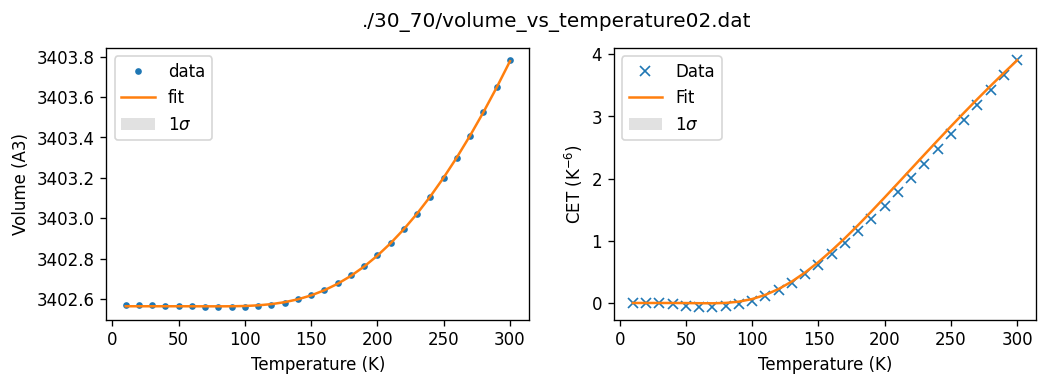

##################### ./30_70/volume_vs_temperature03.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35238
    # data points      = 30
    # variables        = 5
    chi-square         = 7.3529e-04
    reduced chi-square = 2.9412e-05
    Akaike info crit   = -308.493373
    Bayesian info crit = -301.487386
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3368.98097 +/- 0.00183577 (0.00%) (init = 400)
    a1:  344.776772 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  330.654516 +/-        nan (nan%) (init = 0)
    a4: -4.99010690 +/- 0.01229737 (0.25%) (init = 0)
    a5:  0.02840422 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.010523735174047033
---------- DE bounds ----------
a0 :         0	     3368.98	    8000
a1 :         0	     344.777	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     330.655	    3000
a4 :        -5	    -4.99011	       5
a5 :     1e-05	   0.0284042	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00116  -0.00116  -0.001163368.98696  +0.00116  +0.00116  +0.00116
 a1: -23.54139 -15.11049  -8.73958 569.56222  +7.16407 +12.95118 +19.81865
 a3:-124.29532 -74.03622 -40.54873 829.09639 +39.66697 +71.33608+110.67938
 a4:      -inf      -inf      -inf  -4.98027  +0.03819  +0.14146  +0.29866
 a5:  -0.00153  -0.00084  -0.00040   0.03998  +0.00042  +0.00072  +0.00107
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 915
    # data points      = 30
    # variables        = 5
    chi-square         = 1.4950e-05
    reduced chi-square = 5.9800e-07
    Akaike info crit   = -425.359899
    Bayesian info crit = -418.353912
[[Variables]]
    a0:  3368.98696 +/- 2.8968e-04 (0.00%) (init = 3368.981)
    a1:  569.562225 +/- 6.45911799 (1.13%) (init = 344.7768)
    a2:  0 (fixed)
    a3:  829.096393 +/- 34.3579726 (4.14%) (init = 330.6545)
    a4: -4.98026634 +/- 0.04589678 (0.92%) (init 

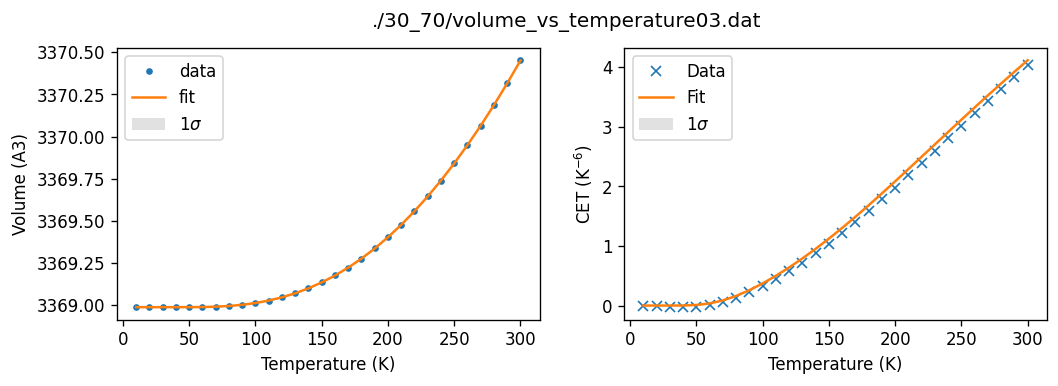

##################### ./30_70/volume_vs_temperature04.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 28752
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00120727
    reduced chi-square = 4.8291e-05
    Akaike info crit   = -293.617830
    Bayesian info crit = -286.611843
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3372.56410 +/- 0.00251725 (0.00%) (init = 400)
    a1:  507.550320 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -489.114563 +/-        nan (nan%) (init = 0)
    a4:  0.37663321 +/-        nan (nan%) (init = 0)
    a5:  0.01878829 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.0036528253313008463
---------- DE bounds ----------
a0 :         0	     3372.56	    8000
a1 :         0	      507.55	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -489.115	    3000
a4 :        -5	    0.376633	       5
a5 :     1e-05	   0.0187883	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.014399997536929731) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.009599998357953155) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.9689796032596085 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00574  -0.00574  -0.005743372.56372  +0.00574  +0.00574  +0.00574
 a1: -91.82060 -62.39745 -32.20016 460.76009 +35.88305 +77.95119+130.28672
 a3:      -inf      -inf      -inf  -0.01200      +inf      +inf      +inf
 a4:      -inf  -1.14180  -0.66543  -3.79292  +1.01299  +2.65334  +5.51057
 a5:  -0.00328  -0.00160  -0.00080   0.02537  +0.00088  +0.00188  +0.00312
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 999
    # data points      = 30
    # variables        = 5
    chi-square         = 3.7719e-04
    reduced chi-square = 1.5088e-05
    Akaike info crit   = -328.518404
    Bayesian info crit = -321.512417
[[Variables]]
    a0:  3372.56372 +/- 0.00143499 (0.00%) (init = 3372.564)
    a1:  460.760093 +/- 33.4842726 (7.27%) (init = 507.5503)
    a2:  0 (fixed)
    a3: -0.01200000 +/- 118.934119 (991117.83%) (init = -489.1146)
    a4: -3.79291839 +/- 0.80197797 (21.14%)

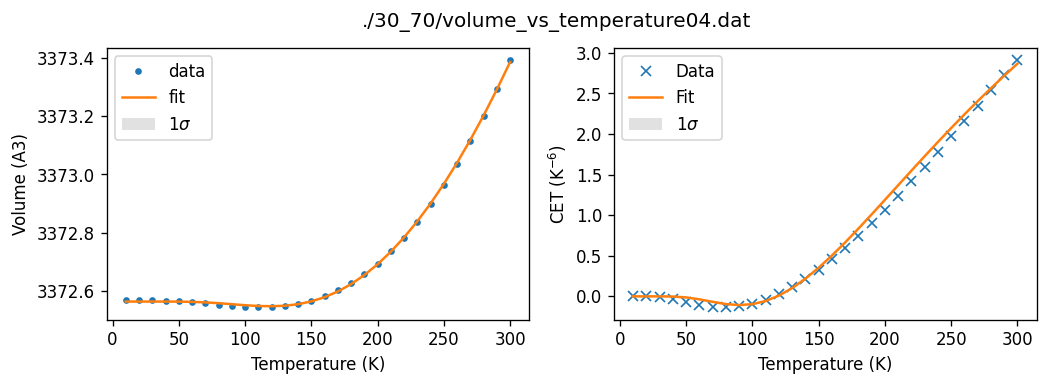

##################### ./30_70/volume_vs_temperature05.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 30114
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00510619
    reduced chi-square = 2.0425e-04
    Akaike info crit   = -250.354961
    Bayesian info crit = -243.348974
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3327.06855 +/- 0.00419702 (0.00%) (init = 400)
    a1:  326.004367 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  185.633205 +/-        nan (nan%) (init = 0)
    a4: -4.02271575 +/-        nan (nan%) (init = 0)
    a5:  0.02759303 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.011416659290262032
---------- DE bounds ----------
a0 :         0	     3327.07	    8000
a1 :         0	     326.004	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     185.633	    3000
a4 :        -5	    -4.02272	       5
a5 :     1e-05	    0.027593	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00659  -0.00659  -0.006593327.06842  +0.00659  +0.00659  +0.00659
 a1: -89.56806 -60.90216 -35.00289 524.65347 +22.27200 +49.71133 +81.00129
 a3:-230.88459-177.01728-113.15962 604.19310 +93.60329+232.79062+431.22932
 a4:      -inf      -inf      -inf  -4.99228  +0.07410  +0.29930  +0.73235
 a5:  -0.00576  -0.00394  -0.00226   0.04197  +0.00149  +0.00327  +0.00525
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1078
    # data points      = 30
    # variables        = 5
    chi-square         = 6.2058e-04
    reduced chi-square = 2.4823e-05
    Akaike info crit   = -313.581415
    Bayesian info crit = -306.575428
[[Variables]]
    a0:  3327.06842 +/- 0.00164871 (0.00%) (init = 3327.069)
    a1:  524.653466 +/- 27.1888152 (5.18%) (init = 326.0044)
    a2:  0 (fixed)
    a3:  604.193102 +/- 102.668623 (16.99%) (init = 185.6332)
    a4: -4.99228492 +/- 0.04409325 (0.88%) (ini

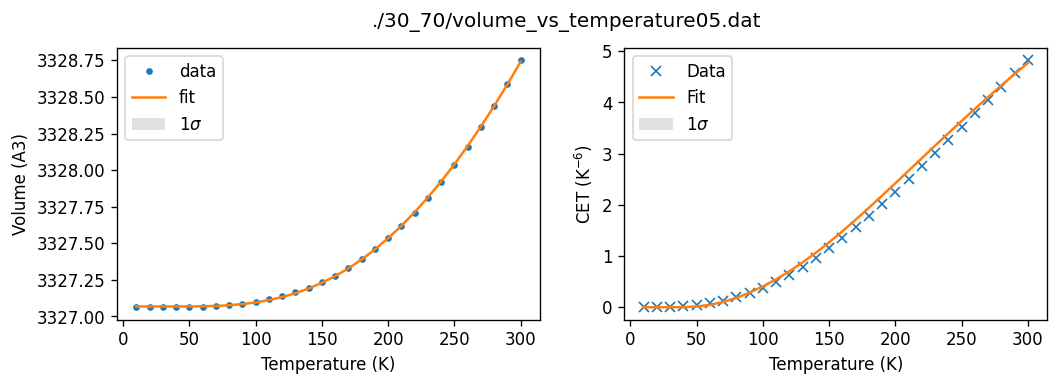

##################### ./30_70/volume_vs_temperature06.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34062
    # data points      = 30
    # variables        = 5
    chi-square         = 4.8739e-04
    reduced chi-square = 1.9495e-05
    Akaike info crit   = -320.829573
    Bayesian info crit = -313.823586
[[Variables]]
    a0:  3343.92693 +/- 0.00149879 (0.00%) (init = 400)
    a1:  611.448843 +/- 26.3714315 (4.31%) (init = 100)
    a2:  0 (fixed)
    a3: -497.194803 +/- 144.943049 (29.15%) (init = 0)
    a4:  1.35825108 +/- 1.46602316 (107.93%) (init = 0)
    a5:  0.02886015 +/- 0.00192154 (6.66%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.975
    C(a3, a5) =  0.834
    C(a1, a4) =  0.782
    C(a4, a5) = -0.737
    C(a1, a3) = -0.643
    C(a0, a1) = -0.298
    C(a0, a5) = -0.296
    C(a0, a3) = -0.167
    C(a1, a5) = -0.160
Cost: -0.005149309182797879
---------- DE boun

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-1.0 < 1e-05 at iteration 2 and prob(a3=-0.0021264225543309295) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.0008735774456690706) = 0.0 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00582  -0.00582  -0.005823343.92774  +0.00582  +0.00582  +0.00582
 a1: -47.59238 -31.77597 -16.25450 497.39410 +18.35503 +41.13533 +73.37130
 a3:      -inf      -inf      -inf  -0.00013      +inf      +inf      +inf
 a4:  -1.19099  -1.05629  -0.07462  -3.56193  +0.08016  +0.18862  +0.41324
 a5:  -0.00309  -0.00205  -0.00104   0.03091  +0.00117  +0.00257  +0.00442
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 908
    # data points      = 30
    # variables        = 5
    chi-square         = 4.0311e-04
    reduced chi-square = 1.6125e-05
    Akaike info crit   = -326.524746
    Bayesian info crit = -319.518759
[[Variables]]
    a0:  3343.92774 +/- 0.00145561 (0.00%) (init = 3343.927)
    a1:  497.394104 +/- 42.0214860 (8.45%) (init = 611.4488)
    a2:  0 (fixed)
    a3: -1.2642e-04 +/- 137.089850 (108437810.73%) (init = -497.1948)
    a4: -3.56193439 +/- 1.19248388 (33.4

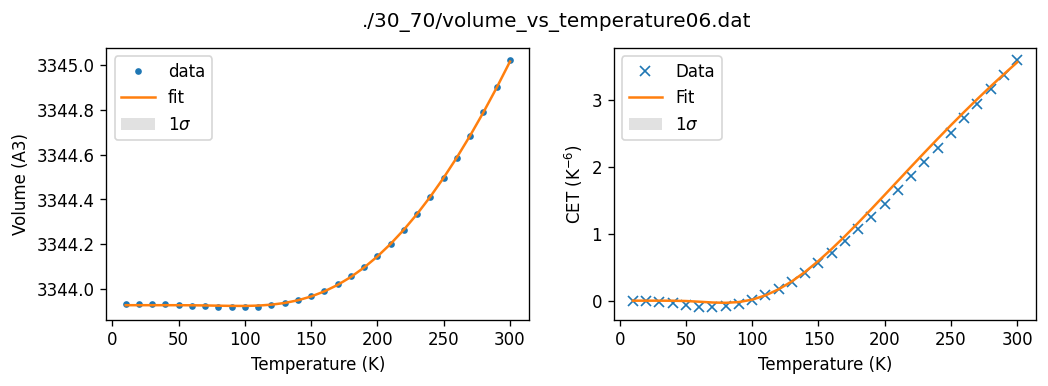

##################### ./30_70/volume_vs_temperature07.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 31284
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00716560
    reduced chi-square = 2.8662e-04
    Akaike info crit   = -240.189843
    Bayesian info crit = -233.183856
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3354.08408 +/- 0.00449548 (0.00%) (init = 400)
    a1:  653.834183 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2393.70472 +/-        nan (nan%) (init = 0)
    a4: -4.95197909 +/- 0.23131122 (4.67%) (init = 0)
    a5:  0.05094249 +/- 9.5644e-04 (1.88%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.454
    C(a0, a5) =  0.228


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.0027396719133321312
---------- DE bounds ----------
a0 :         0	     3354.08	    8000
a1 :         0	     653.834	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	      2393.7	    3000
a4 :        -5	    -4.95198	       5
a5 :     1e-05	   0.0509425	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01096  -0.01096  -0.010963354.06952  +0.00274  +0.00274  +0.00274
 a1: -80.37113 -52.06086 -26.00824 420.08915 +24.58169 +51.54619 +81.54185
 a3:-160.31394-118.21067 -66.51085 523.80541 +79.11574+187.19425+338.32779
 a4:      -inf      -inf      -inf  -4.99992  +0.05571  +0.23329  +0.57087
 a5:  -0.00491  -0.00321  -0.00161   0.03908  +0.00156  +0.00326  +0.00513
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1165
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00135103
    reduced chi-square = 5.4041e-05
    Akaike info crit   = -290.242552
    Bayesian info crit = -283.236566
[[Variables]]
    a0:  3354.06952 +/- 0.00273935 (0.00%) (init = 3354.084)
    a1:  420.089154 +/- 24.4727406 (5.83%) (init = 653.8342)
    a2:  0 (fixed)
    a3:  523.805405 +/- 70.4947600 (13.46%) (init = 2393.705)
    a4: -4.99991824 +/- 0.00429401 (0.09%) (ini

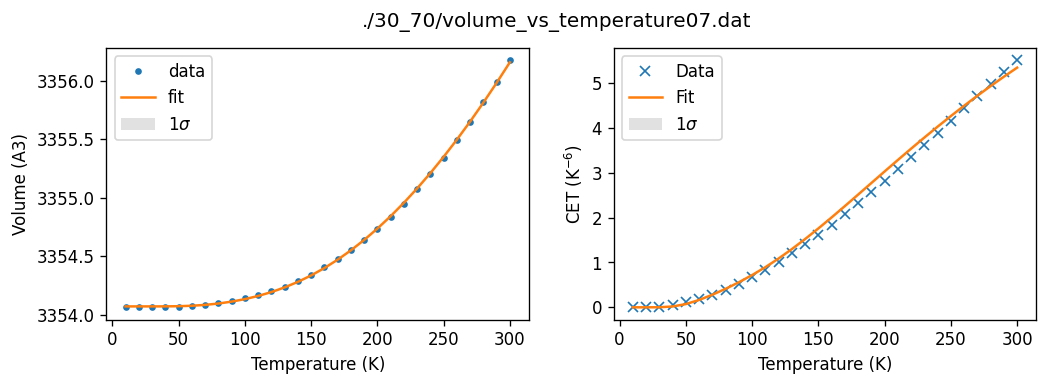

##################### ./30_70/volume_vs_temperature08.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 30486
    # data points      = 30
    # variables        = 5
    chi-square         = 0.01766218
    reduced chi-square = 7.0649e-04
    Akaike info crit   = -213.125808
    Bayesian info crit = -206.119821
[[Variables]]
    a0:  3331.92450 +/- 0.01799586 (0.00%) (init = 400)
    a1:  110.161952 +/- 17.6777665 (16.05%) (init = 100)
    a2:  0 (fixed)
    a3:  107.006324 +/- 23.9181786 (22.35%) (init = 0)
    a4: -1.89518593 +/- 0.33302036 (17.57%) (init = 0)
    a5:  0.00680526 +/- 0.00100069 (14.70%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.997
    C(a3, a4) = -0.960
    C(a3, a5) =  0.951
    C(a1, a5) =  0.912
    C(a1, a4) = -0.905
    C(a1, a3) =  0.813
    C(a0, a1) =  0.314
    C(a0, a4) = -0.128
    C(a0, a5) =  0.126
    C(a0, a3) = -0.125
Cost: -0.0159497710683

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.026279919877197244) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.017519946584798163) = 0.0 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00909  -0.00909  -0.009093331.95230  +0.00909  +0.00909  +0.00909
 a1: -79.39583 -53.40665 -27.25241 365.64695 +29.47808 +62.74517+101.95299
 a3:      -inf      -inf      -inf  -0.02190      +inf      +inf      +inf
 a4:  -0.96976  -0.66217  -0.36328  -3.36864  +0.54250  +1.43924  +3.00588
 a5:  -0.00263  -0.00130  -0.00065   0.01534  +0.00071  +0.00150  +0.00247
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 800
    # data points      = 30
    # variables        = 5
    chi-square         = 8.0229e-04
    reduced chi-square = 3.2092e-05
    Akaike info crit   = -305.876997
    Bayesian info crit = -298.871010
[[Variables]]
    a0:  3331.95230 +/- 0.00227194 (0.00%) (init = 3331.925)
    a1:  365.646947 +/- 27.8996277 (7.63%) (init = 110.162)
    a2:  0 (fixed)
    a3: -0.02189993 +/- 87.7833011 (400838.21%) (init = 107.0063)
    a4: -3.36864443 +/- 0.42663895 (12.67%) (

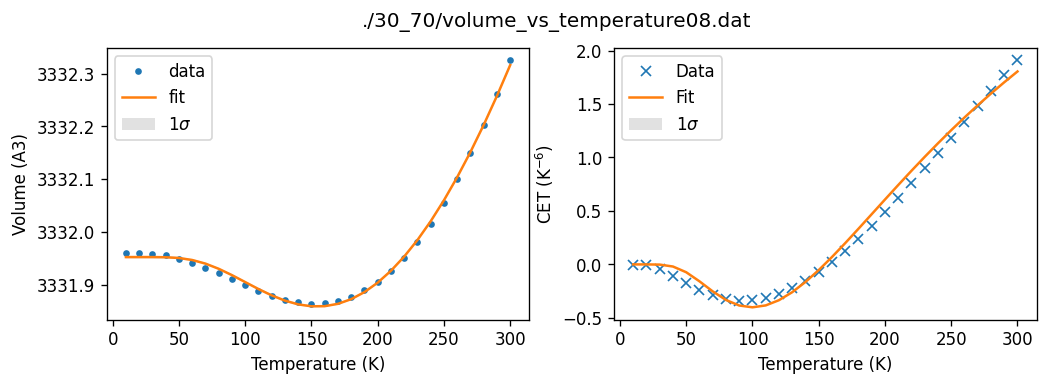

##################### ./30_70/volume_vs_temperature09.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33300
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00357155
    reduced chi-square = 1.4286e-04
    Akaike info crit   = -261.078591
    Bayesian info crit = -254.072604
[[Variables]]
    a0:  3364.93923 +/- 0.00442050 (0.00%) (init = 400)
    a1:  623.670888 +/- 29.8271770 (4.78%) (init = 100)
    a2:  0 (fixed)
    a3: -1620.86206 +/- 207.598913 (12.81%) (init = 0)
    a4:  4.19267605 +/- 1.40195918 (33.44%) (init = 0)
    a5:  0.03383355 +/- 0.00375185 (11.09%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.939
    C(a1, a5) =  0.703
    C(a1, a3) = -0.628
    C(a0, a1) = -0.579
    C(a0, a5) = -0.478
    C(a1, a4) =  0.421
    C(a4, a5) = -0.331
    C(a0, a3) =  0.115
Cost: 0.0027495497611198516
---------- DE bounds ----------
a0 :     

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00012815118679317756 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.985876756924361) = 0.09075386460174159 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01241  -0.01241  -0.012413364.94706  +0.00931  +0.00931  +0.00931
 a1: -47.33304  -2.47186  -1.32394 452.78385 +13.31185 +15.38342  +5.10193
 a3: -34.07313  -6.45379  -2.72994-161.18504  +4.24031 +31.36170 +16.89540
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00271  -0.00254  -0.00121   0.03499  +0.00042  +0.00128  +0.00135
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2071
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00166371
    reduced chi-square = 6.6548e-05
    Akaike info crit   = -283.997104
    Bayesian info crit = -276.991117
[[Variables]]
    a0:  3364.94706 +/- 0.00310257 (0.00%) (init = 3364.939)
    a1:  452.783850 +/- 16.3912612 (3.62%) (init = 623.6709)
    a2:  0 (fixed)
    a3: -161.185044 +/- 35.8087116 (22.22%) (init = -1620.862)
    a4: -5.00000000 +/- 7.0265e-05 (0.00%) (in

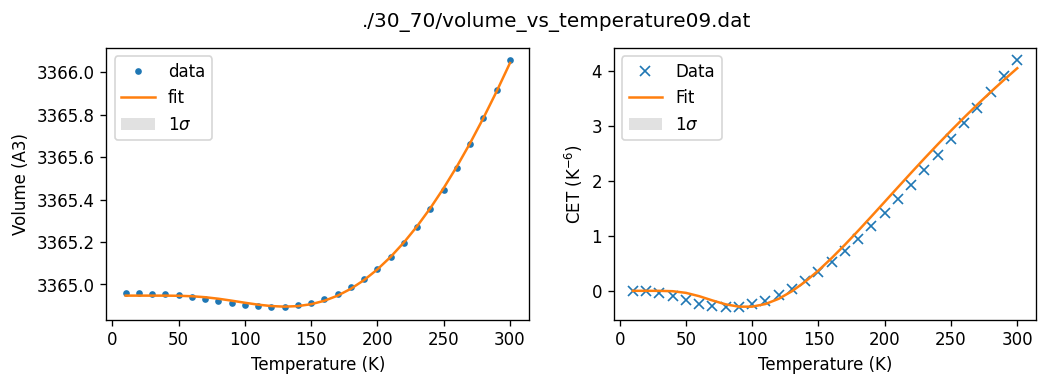

##################### ./30_70/volume_vs_temperature10.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33126
    # data points      = 30
    # variables        = 5
    chi-square         = 3.1102e-04
    reduced chi-square = 1.2441e-05
    Akaike info crit   = -334.305155
    Bayesian info crit = -327.299169
[[Variables]]
    a0:  3300.21964 +/- 0.00169634 (0.00%) (init = 400)
    a1:  599.916671 +/- 133.927847 (22.32%) (init = 100)
    a2:  0 (fixed)
    a3: -488.302227 +/- 900.035219 (184.32%) (init = 0)
    a4: -0.20869152 +/- 7.20117986 (3450.63%) (init = 0)
    a5:  0.02516550 +/- 0.00562145 (22.34%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -1.000
    C(a1, a3) = -0.995
    C(a1, a4) =  0.994
    C(a4, a5) = -0.984
    C(a3, a5) =  0.983
    C(a1, a5) = -0.960
    C(a0, a1) = -0.723
    C(a0, a4) = -0.686
    C(a0, a3) =  0.683
    C(a0, a5) =  0.616
Cost: -0.0038662207

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3300.218105900642) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3300.221322927067) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=481.4468614278891) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-390.750141343239) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a4=-0.254359286601715) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:      -inf      -inf      -inf3300.21971      +inf      +inf      +inf
 a1:      -inf      -inf      -inf 599.82502 +15.99750 +50.30063+102.17611
 a3:-655.87400-342.63628 -81.73930-488.43768      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -0.21197  +0.65457  +2.80735      +inf
 a5:  -0.00675  -0.00289  -0.00099   0.02517  +0.00438  +0.00517  +0.00648
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 122
    # data points      = 30
    # variables        = 5
    chi-square         = 3.1092e-04
    reduced chi-square = 1.2437e-05
    Akaike info crit   = -334.314859
    Bayesian info crit = -327.308872
[[Variables]]
    a0:  3300.21971 +/- 0.00160851 (0.00%) (init = 3300.22)
    a1:  599.825024 +/- 118.378163 (19.74%) (init = 599.9167)
    a2:  0 (fixed)
    a3: -488.437677 +/- 794.613573 (162.68%) (init = -488.3022)
    a4: -0.21196607 +/- 6.35442778 (2997.85%) 

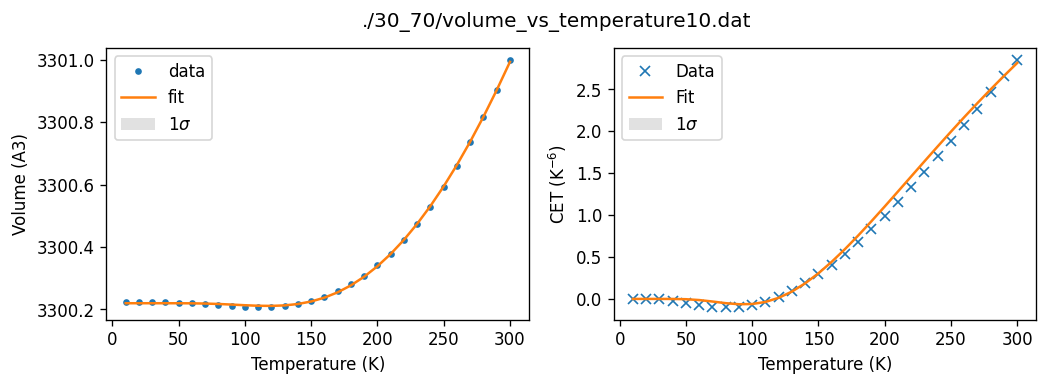

##################### ./30_70/volume_vs_temperature11.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32664
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00368553
    reduced chi-square = 1.4742e-04
    Akaike info crit   = -260.136131
    Bayesian info crit = -253.130144
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3394.11005 +/- 0.00453636 (0.00%) (init = 400)
    a1:  503.555041 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -1335.71137 +/-        nan (nan%) (init = 0)
    a4:  3.96756731 +/-        nan (nan%) (init = 0)
    a5:  0.01550381 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.004380410393423517
---------- DE bounds ----------
a0 :         0	     3394.11	    8000
a1 :         0	     503.555	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -1335.71	    3000
a4 :        -5	     3.96757	       5
a5 :     1e-05	   0.0155038	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.008476532176791807) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-1.0 < 1e-05 at iteration 2 and prob(a3=0.014833931309385661) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.2925372246723357 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01459  -0.01459  -0.014593394.11382  +0.01459  +0.01459  +0.01459
 a1: -76.92402 -50.13981 -26.98876 365.17339 +31.95047 +68.66895+112.95779
 a3:      -inf      -inf      -inf   0.01060      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.74970  +0.91381  +2.44202  +5.16833
 a5:  -0.00319  -0.00207  -0.00104   0.02461  +0.00114  +0.00240  +0.00390
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1220
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00205151
    reduced chi-square = 8.2060e-05
    Akaike info crit   = -277.711311
    Bayesian info crit = -270.705324
[[Variables]]
    a0:  3394.11382 +/- 0.00364718 (0.00%) (init = 3394.11)
    a1:  365.173389 +/- 30.0050581 (8.22%) (init = 503.555)
    a2:  0 (fixed)
    a3:  0.01059567 +/- 131.870121 (1244566.70%) (init = -1335.711)
    a4: -4.74969717 +/- 0.71457436 (15.04%)

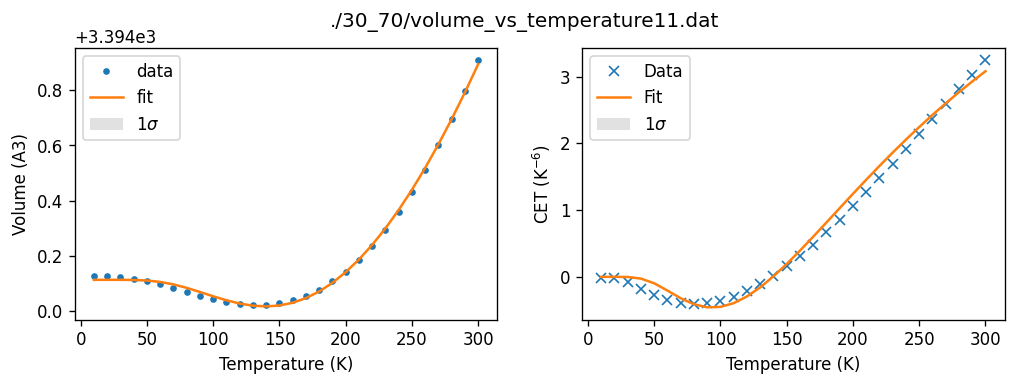

##################### ./30_70/volume_vs_temperature12.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34578
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00225856
    reduced chi-square = 9.0343e-05
    Akaike info crit   = -274.826714
    Bayesian info crit = -267.820727
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3351.49071 +/- 0.00213819 (0.00%) (init = 400)
    a1:  670.999824 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  475.532303 +/- 287.878070 (60.54%) (init = 0)
    a4:  1.99725771 +/-        nan (nan%) (init = 0)
    a5:  0.03272296 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a3) =  0.276


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3351.4825197534697) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3351.4853892868855) = 0.0 < max(sigmas).
  warn(errmsg)


Cost: -0.0036438315059967863
---------- DE bounds ----------
a0 :         0	     3351.49	    8000
a1 :         0	         671	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     475.532	    3000
a4 :        -5	     1.99726	       5
a5 :     1e-05	    0.032723	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=508.5878674337592) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=457.2419360032038) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a4=-4.72418699946104) = 0.0 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:      -inf      -inf      -inf3351.48395      +inf      +inf      +inf
 a1: -59.31594 -36.75610 -22.06580 478.82490      +inf      +inf      +inf
 a3: -68.85840 -42.66034 -22.62976 405.43190      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.86877      +inf      +inf      +inf
 a5:  -0.00314  -0.00186  -0.00102   0.03546      +inf      +inf      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 552
    # data points      = 30
    # variables        = 5
    chi-square         = 4.5389e-04
    reduced chi-square = 1.8155e-05
    Akaike info crit   = -322.965852
    Bayesian info crit = -315.959865
[[Variables]]
    a0:  3351.48395 +/- 0.00143477 (0.00%) (init = 3351.491)
    a1:  478.824898 +/- 29.7629692 (6.22%) (init = 670.9998)
    a2:  0 (fixed)
    a3:  405.431897 +/- 51.8100386 (12.78%) (init = 475.5323)
    a4: -4.86877443 +/- 0.14458743 (2.97%) (init

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a5=0.03714336492818909) = 0.0 < max(sigmas).
  warn(errmsg)


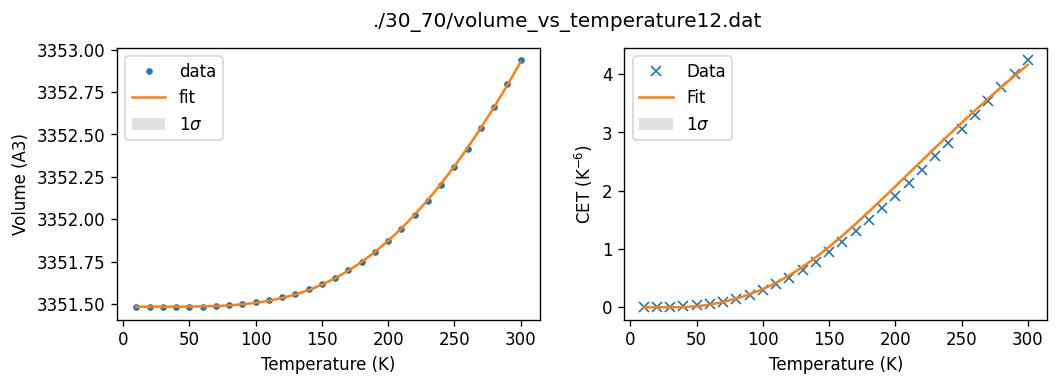

##################### ./30_70/volume_vs_temperature13.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35400
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00167261
    reduced chi-square = 6.6904e-05
    Akaike info crit   = -283.837107
    Bayesian info crit = -276.831121
[[Variables]]
    a0:  3363.32604 +/- 0.00280795 (0.00%) (init = 400)
    a1:  729.740943 +/- 44.6718191 (6.12%) (init = 100)
    a2:  0 (fixed)
    a3:  1888.48950 +/- 563.436512 (29.84%) (init = 0)
    a4: -4.99897431 +/- 0.02432375 (0.49%) (init = 0)
    a5:  0.05069436 +/- 0.00198897 (3.92%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.995
    C(a1, a5) =  0.938
    C(a3, a5) =  0.902
    C(a0, a5) =  0.661
    C(a0, a1) =  0.573
    C(a0, a3) =  0.525
Cost: -0.0030479208649012435
---------- DE bounds ----------
a0 :         0	     3363.33	    8000
a1 :         0	    

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.994116327209373) = 0.21441227400409388 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00645  -0.00645  -0.006453363.32071  +0.00322  +0.00322  +0.00322
 a1:  -9.48992 -29.00811  -4.52170 540.20436 +18.47341 +30.18723 +30.39994
 a3:-195.24905 -80.06177  -2.26474 558.52050  +3.92582  +7.23391 +92.61303
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00578  -0.00383  -0.00129   0.03977  +0.00006  +0.00171  +0.00191
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1156
    # data points      = 30
    # variables        = 5
    chi-square         = 6.2173e-04
    reduced chi-square = 2.4869e-05
    Akaike info crit   = -313.526232
    Bayesian info crit = -306.520245
[[Variables]]
    a0:  3363.32071 +/- 0.00161145 (0.00%) (init = 3363.326)
    a1:  540.204357 +/- 30.3999361 (5.63%) (init = 729.7409)
    a2:  0 (fixed)
    a3:  558.520500 +/- 97.9585429 (17.54%) (init = 1888.489)
    a4: -5.00000000 +/- 2.9272e-05 (0.00%) (ini

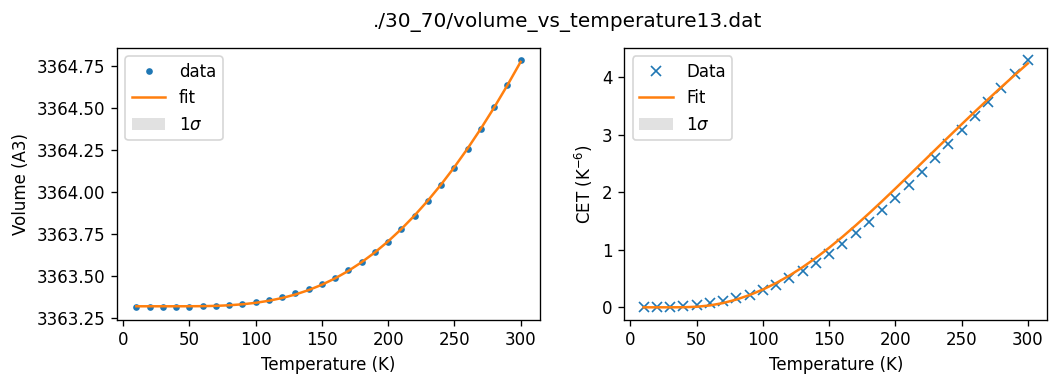

##################### ./30_70/volume_vs_temperature14.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 26046
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00254056
    reduced chi-square = 1.0162e-04
    Akaike info crit   = -271.297065
    Bayesian info crit = -264.291078
[[Variables]]
    a0:  3372.11862 +/- 0.00395728 (0.00%) (init = 400)
    a1:  451.662565 +/- 17.4961377 (3.87%) (init = 100)
    a2:  0 (fixed)
    a3: -304.849015 +/- 67.9874827 (22.30%) (init = 0)
    a4: -4.95247035 +/- 0.07576622 (1.53%) (init = 0)
    a5:  0.02729864 +/- 0.00125108 (4.58%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5) =  0.976
    C(a3, a5) = -0.960
    C(a1, a3) = -0.960
    C(a0, a1) = -0.565
    C(a0, a5) = -0.497
    C(a0, a3) =  0.402
    C(a3, a4) = -0.193
Cost: -0.006902381177951611
---------- DE bounds ----------
a0 :         0	     3372.12	    80

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00026030690238910417 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.99687487288347) = 0.0552835938263845 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01416  -0.01416  -0.014163372.12520  +0.00708  +0.00708  +0.00708
 a1: -10.61831  -4.81382  -5.22815 409.24289  +2.05609  +4.62635 +16.52601
 a3: -45.45056  -8.26850  -2.51029-158.53234  +8.67215  +7.14969 +10.94192
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00056  -0.00015  -0.00004   0.02467  +0.00006  +0.00012  +0.00099
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 978
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00199901
    reduced chi-square = 7.9961e-05
    Akaike info crit   = -278.488976
    Bayesian info crit = -271.482989
[[Variables]]
    a0:  3372.12520 +/- 0.00354070 (0.00%) (init = 3372.119)
    a1:  409.242892 +/- 16.9238261 (4.14%) (init = 451.6626)
    a2:  0 (fixed)
    a3: -158.532340 +/- 56.2373675 (35.47%) (init = -304.849)
    a4: -5.00000000 +/- 1.5548e-05 (0.00%) (init

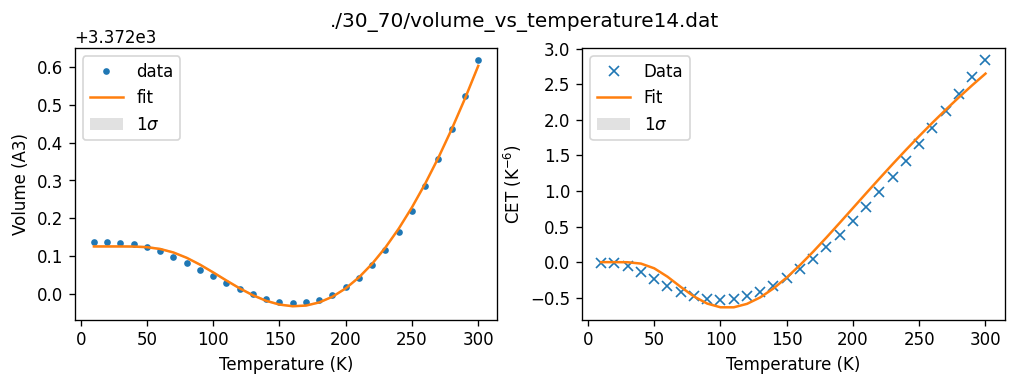

##################### ./30_70/volume_vs_temperature15.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 38868
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00239638
    reduced chi-square = 9.5855e-05
    Akaike info crit   = -273.049761
    Bayesian info crit = -266.043774
[[Variables]]
    a0:  3370.58736 +/- 0.00445139 (0.00%) (init = 400)
    a1:  748.479147 +/- 88.9382437 (11.88%) (init = 100)
    a2:  0 (fixed)
    a3:  2188.55161 +/- 1317.17010 (60.18%) (init = 0)
    a4: -3.86556200 +/- 0.91495109 (23.67%) (init = 0)
    a5:  0.04266815 +/- 0.00263379 (6.17%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.995
    C(a0, a1) =  0.786
    C(a4, a5) = -0.777
    C(a0, a3) =  0.757
    C(a3, a5) =  0.688
    C(a1, a5) =  0.651
    C(a0, a5) =  0.558
    C(a3, a4) = -0.249
    C(a1, a4) = -0.165
Cost: 0.00157774552144474
---------- DE bounds

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00220  -0.00220  -0.002203370.57636  +0.00220  +0.00220  +0.00220
 a1: -62.70397 -40.68405 -19.46865 440.87093 +24.36234 +48.20129 +75.27993
 a3: -66.29839 -47.91750 -25.63564 434.53724 +40.29907 +90.02038+161.06111
 a4:      -inf      -inf      -inf  -4.99965  +0.02686  +0.11016  +0.26298
 a5:  -0.00297  -0.00195  -0.00094   0.03140  +0.00123  +0.00243  +0.00382
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1359
    # data points      = 30
    # variables        = 5
    chi-square         = 1.8645e-04
    reduced chi-square = 7.4579e-06
    Akaike info crit   = -349.656853
    Bayesian info crit = -342.650867
[[Variables]]
    a0:  3370.57636 +/- 0.00110187 (0.00%) (init = 3370.587)
    a1:  440.870927 +/- 21.4740387 (4.87%) (init = 748.4791)
    a2:  0 (fixed)
    a3:  434.537240 +/- 31.3040674 (7.20%) (init = 2188.552)
    a4: -4.99965238 +/- 0.00585842 (0.12%) (init

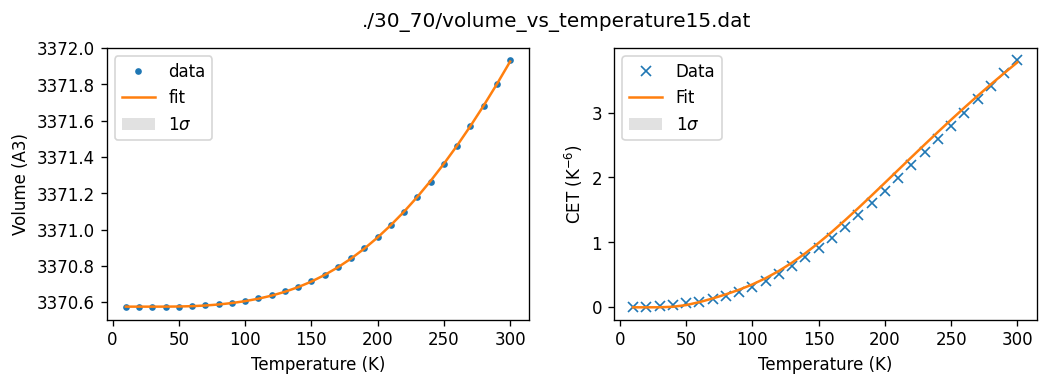

##################### ./30_70/volume_vs_temperature16.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34248
    # data points      = 30
    # variables        = 5
    chi-square         = 2.7345e-04
    reduced chi-square = 1.0938e-05
    Akaike info crit   = -338.167313
    Bayesian info crit = -331.161326
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3337.26141 +/-        nan (nan%) (init = 400)
    a1:  775.277879 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  712.617334 +/- 269.657770 (37.84%) (init = 0)
    a4:  2.03967945 +/-        nan (nan%) (init = 0)
    a5:  0.04269876 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Cost: -0.0025740789897099603
---------- DE bounds ----------
a0 :         0	     3337.26	    8000
a1 :         0	     775.278	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     712.617	    3000
a4 :        -5	     2.03968	       5
a5 :     1e-05	   0.0426988	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00119  -0.00119  -0.001193337.25940  +0.00119  +0.00119  +0.00119
 a1: -54.65602 -32.42453 -15.25768 744.06923 +12.33505 +25.02174 +38.23693
 a3:-433.00474-273.94090-137.173751253.48239+121.86269+258.33728+413.86076
 a4:      -inf      -inf      -inf  -4.99900  +0.10135  +0.38552  +0.81691
 a5:  -0.00410  -0.00229  -0.00104   0.05477  +0.00083  +0.00166  +0.00248
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1522
    # data points      = 30
    # variables        = 5
    chi-square         = 2.0776e-05
    reduced chi-square = 8.3103e-07
    Akaike info crit   = -415.487737
    Bayesian info crit = -408.481750
[[Variables]]
    a0:  3337.25940 +/- 2.9636e-04 (0.00%) (init = 3337.261)
    a1:  744.069234 +/- 13.3553658 (1.79%) (init = 775.2779)
    a2:  0 (fixed)
    a3:  1253.48239 +/- 126.473507 (10.09%) (init = 712.6173)
    a4: -4.99899563 +/- 0.01979698 (0.40%) (ini

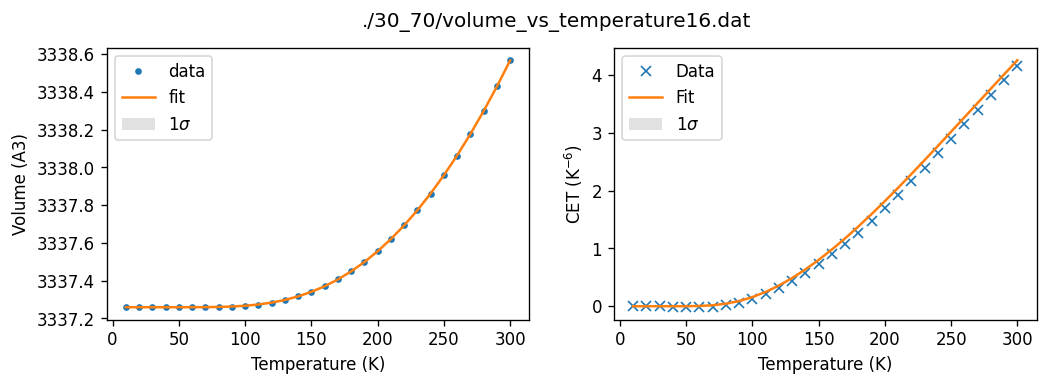

##################### ./30_70/volume_vs_temperature17.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35346
    # data points      = 30
    # variables        = 5
    chi-square         = 9.7393e-05
    reduced chi-square = 3.8957e-06
    Akaike info crit   = -369.138615
    Bayesian info crit = -362.132628
[[Variables]]
    a0:  3366.17639 +/- 6.5555e-04 (0.00%) (init = 400)
    a1:  708.593488 +/- 22.5004151 (3.18%) (init = 100)
    a2:  0 (fixed)
    a3:  660.193799 +/- 153.508718 (23.25%) (init = 0)
    a4: -1.52647055 +/- 0.80058514 (52.45%) (init = 0)
    a5:  0.04240138 +/- 0.00157551 (3.72%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.846
    C(a1, a3) =  0.824
    C(a4, a5) = -0.594
    C(a0, a4) =  0.504
    C(a1, a4) =  0.476
    C(a1, a5) =  0.419
    C(a0, a1) =  0.359
    C(a0, a5) = -0.156
    C(a3, a4) = -0.101
Cost: -0.003045094987101038
---------- DE bound

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.004456652299577757 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.993201306042685) = 0.2125788599130666 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00091  -0.00091  -0.000913366.17534  +0.00068  +0.00068  +0.00068
 a1:  -0.37372  -4.04673      +nan 719.41962      +nan +18.93966 +25.46604
 a3:  -1.88920  -8.36402      +nan1172.29428      +nan  +2.73671 +11.97834
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00059  -0.00005      +nan   0.05009      +nan  +0.00004  +0.00005
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1542
    # data points      = 30
    # variables        = 5
    chi-square         = 1.1371e-05
    reduced chi-square = 4.5486e-07
    Akaike info crit   = -433.568051
    Bayesian info crit = -426.562065
[[Variables]]
    a0:  3366.17534 +/- 2.2796e-04 (0.00%) (init = 3366.176)
    a1:  719.419620 +/- 9.63866258 (1.34%) (init = 708.5935)
    a2:  0 (fixed)
    a3:  1172.29428 +/- 80.9483728 (6.91%) (init = 660.1938)
    a4: -5.00000000 +/- 3.3824e-05 (0.00%) (init

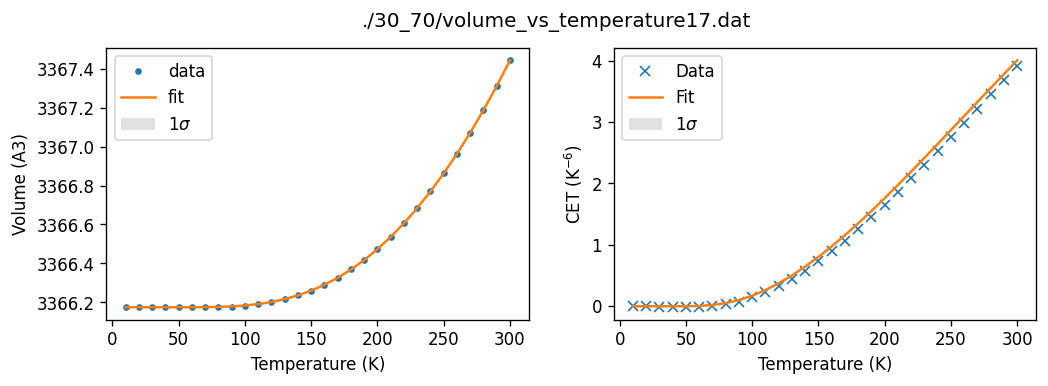

##################### ./30_70/volume_vs_temperature18.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 22836
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00527477
    reduced chi-square = 2.1099e-04
    Akaike info crit   = -249.380525
    Bayesian info crit = -242.374538
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3333.87868 +/-        nan (nan%) (init = 400)
    a1:  525.436904 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  225.786785 +/-        nan (nan%) (init = 0)
    a4:  0.50904332 +/-        nan (nan%) (init = 0)
    a5:  0.02895719 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Cost: 0.004008842895927955
---------- DE bounds ----------
a0 :         0	     3333.88	    8000
a1 :         0	     525.437	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     225.787	    3000
a4 :        -5	    0.509043	       5
a5 :     1e-05	   0.0289572	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00380  -0.00380  -0.003803333.86740  +0.00380  +0.00380  +0.00380
 a1: -71.29197 -47.23347 -24.75091 419.18652 +20.20490 +43.88207 +70.43791
 a3:-111.56177 -82.76090 -48.20924 489.11343 +48.79433+118.16982+214.24675
 a4:      -inf      -inf      -inf  -4.99944  +0.03776  +0.15492  +0.37079
 a5:  -0.00377  -0.00252  -0.00133   0.03485  +0.00112  +0.00244  +0.00390
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 833
    # data points      = 30
    # variables        = 5
    chi-square         = 5.8214e-04
    reduced chi-square = 2.3286e-05
    Akaike info crit   = -315.499839
    Bayesian info crit = -308.493852
[[Variables]]
    a0:  3333.86740 +/- 0.00190213 (0.00%) (init = 3333.879)
    a1:  419.186522 +/- 21.4031663 (5.11%) (init = 525.4369)
    a2:  0 (fixed)
    a3:  489.113435 +/- 46.9431026 (9.60%) (init = 225.7868)
    a4: -4.99944426 +/- 0.00927940 (0.19%) (init 

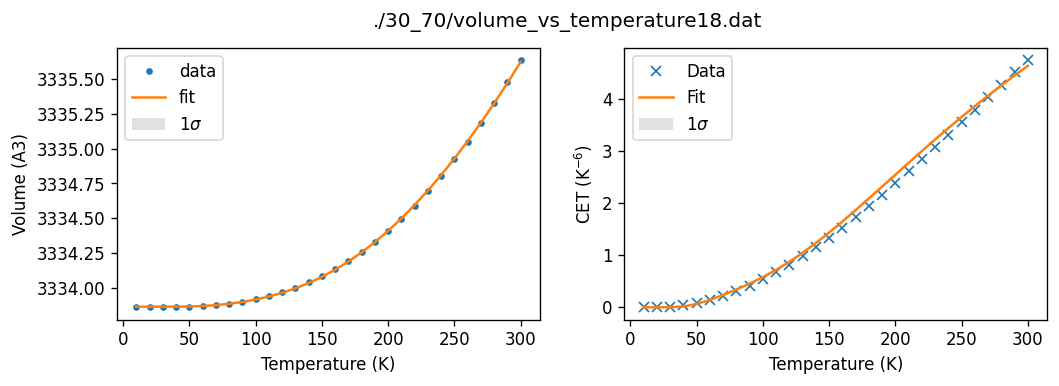

##################### ./30_70/volume_vs_temperature19.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34728
    # data points      = 30
    # variables        = 5
    chi-square         = 3.8470e-04
    reduced chi-square = 1.5388e-05
    Akaike info crit   = -327.927569
    Bayesian info crit = -320.921582
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3360.84340 +/- 0.00114431 (0.00%) (init = 400)
    a1:  817.751682 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2888.17113 +/-        nan (nan%) (init = 0)
    a4: -3.38718686 +/- 1.02074367 (30.14%) (init = 0)
    a5:  0.05444834 +/- 0.00199833 (3.67%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.968
    C(a0, a4) =  0.328
    C(a0, a5) = -0.209


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.002346897409097437
---------- DE bounds ----------
a0 :         0	     3360.84	    8000
a1 :         0	     817.752	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2888.17	    3000
a4 :        -5	    -3.38719	       5
a5 :     1e-05	   0.0544483	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0017571440487472551 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.003084823843114514 < 1e-05 at iteration 54 and prob(a4=-4.999422651681584) = 0.042920932047954205 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00182  -0.00182  -0.001823360.84049  +0.00182  +0.00182  +0.00182
 a1: -12.25819  -8.91649  -6.02272 708.24091  +1.51150 +17.59624 +36.62103
 a3:-127.15076-116.42348  -0.678071425.26906+123.48796+124.62586 +48.91975
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00362  -0.00176  -0.00012   0.05335  +0.00010  +0.00038  +0.00073
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1648
    # data points      = 30
    # variables        = 5
    chi-square         = 4.5694e-05
    reduced chi-square = 1.8278e-06
    Akaike info crit   = -391.842282
    Bayesian info crit = -384.836295
[[Variables]]
    a0:  3360.84049 +/- 4.5465e-04 (0.00%) (init = 3360.843)
    a1:  708.240906 +/- 12.2581906 (1.73%) (init = 817.7517)
    a2:  0 (fixed)
    a3:  1425.26906 +/- 127.150759 (8.92%) (init = 2888.171)
    a4: -5.00000000 +/- 1.0692e-05 (0.00%) (init

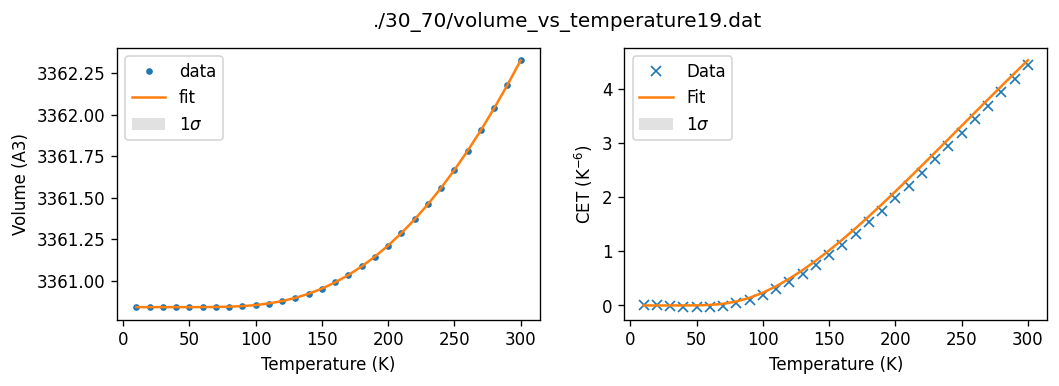

##################### ./30_70/volume_vs_temperature20.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33756
    # data points      = 30
    # variables        = 5
    chi-square         = 2.6209e-04
    reduced chi-square = 1.0484e-05
    Akaike info crit   = -339.440201
    Bayesian info crit = -332.434214
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3315.19910 +/- 0.00103553 (0.00%) (init = 400)
    a1:  650.698066 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -375.610286 +/-        nan (nan%) (init = 0)
    a4:  0.98317880 +/-        nan (nan%) (init = 0)
    a5:  0.03119357 +/- 0.00108428 (3.48%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a5) = -1.058


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.0032349819953196857
---------- DE bounds ----------
a0 :         0	      3315.2	    8000
a1 :         0	     650.698	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     -375.61	    3000
a4 :        -5	    0.983179	       5
a5 :     1e-05	   0.0311936	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.07084960493812105) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.04723306995874736) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.9110745761635347 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=5) = 0.9877300469413665 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00426  -0.00426  -0.004263315.19962  +0.00426  +0.00426  +0.00426
 a1:-107.57821 -80.11074 -42.69706 545.70188 +52.65084+127.01204+239.33516
 a3:      -inf      -inf      -inf  -0.05904      +inf      +inf      +inf
 a4:      -inf      -inf  -1.11632  -3.33526  +1.82497  +5.21569      +inf
 a5:  -0.00322  -0.00204  -0.00103   0.03245  +0.00118  +0.00260  +0.00457
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 902
    # data points      = 30
    # variables        = 5
    chi-square         = 2.2969e-04
    reduced chi-square = 9.1874e-06
    Akaike info crit   = -343.399919
    Bayesian info crit = -336.393932
[[Variables]]
    a0:  3315.19962 +/- 0.00106532 (0.00%) (init = 3315.199)
    a1:  545.701883 +/- 46.1586867 (8.46%) (init = 650.6981)
    a2:  0 (fixed)
    a3: -0.05904134 +/- 141.087294 (238963.58%) (init = -375.6103)
    a4: -3.33525639 +/- 1.37786314 (41.31%)

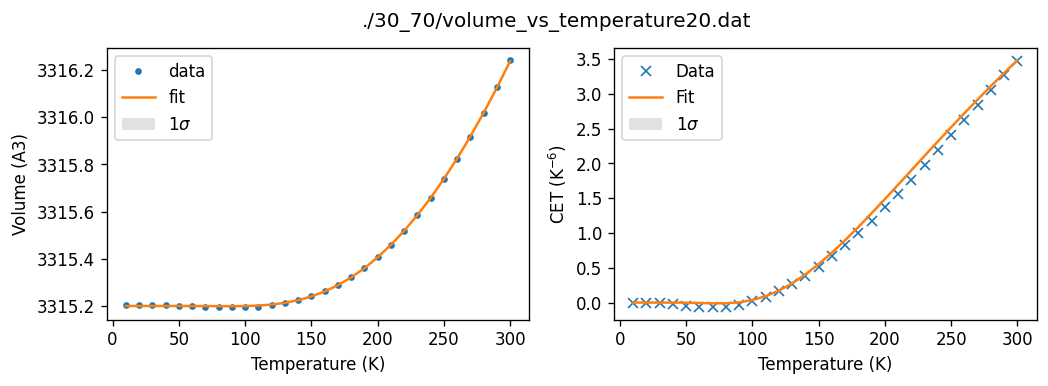

##################### ./30_70/volume_vs_temperature21.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34578
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00861681
    reduced chi-square = 3.4467e-04
    Akaike info crit   = -234.657144
    Bayesian info crit = -227.651157
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3315.70106 +/- 0.00475159 (0.00%) (init = 400)
    a1:  872.592858 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -917.665216 +/- 268.438792 (29.25%) (init = 0)
    a4: -3.31768404 +/- 1.19631012 (36.06%) (init = 0)
    a5:  0.06377286 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.539
    C(a0, a3) = -0.495


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.0020268312596272153
---------- DE bounds ----------
a0 :         0	      3315.7	    8000
a1 :         0	     872.593	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -917.665	    3000
a4 :        -5	    -3.31768	       5
a5 :     1e-05	   0.0637729	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3315.7172604009115) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3315.721353120103) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=469.3671539318707) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-1036.2843021780811) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a4=3.2018120517196906) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/s

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:      -inf      -inf      -inf3315.71931      +inf      +inf      +inf
 a1:      -inf      -inf      -inf 586.70894 +13.93826 +33.70907 +53.96707
 a3:-271.74691-211.86534-110.34213-1295.35538      +inf      +inf      +inf
 a4:      -inf      -inf      -inf   4.00227  +0.74099      +inf      +inf
 a5:  -0.00426  -0.00300  -0.00120   0.01615      +inf      +inf      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 590
    # data points      = 30
    # variables        = 5
    chi-square         = 9.9581e-04
    reduced chi-square = 3.9833e-05
    Akaike info crit   = -299.394459
    Bayesian info crit = -292.388472
##  Warning: uncertainties could not be estimated:
    a0:  at initial value
[[Variables]]
    a0:  3315.71931 +/- 0.00204636 (0.00%) (init = 3315.701)
    a1:  586.708942 +/-        nan (nan%) (init = 872.5929)
    a2:  0 (fixed)
    a3: -1295.35538 +/-        na

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a5=0.019377599903799503) = 0.0 < max(sigmas).
  warn(errmsg)


!!!!!!!!!!!!!! Negative variances. Running Nelder-Mead.


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a3=-336.41287876041787) = 0.9313734017939578 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-6.532288907969269) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.6647002056172339 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00698  -0.00698  -0.006983315.72153  +0.00698  +0.00698  +0.00698
 a1: -83.48192 -57.53336 -31.00845 437.37403 +30.36530 +66.49219+109.41507
 a3:      -inf      -inf-146.08189  -8.16536      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.38755  +0.83560  +2.25556  +4.67566
 a5:  -0.00326  -0.00165  -0.00080   0.02389  +0.00092  +0.00192  +0.00314
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1421
    # data points      = 30
    # variables        = 5
    chi-square         = 5.3965e-04
    reduced chi-square = 2.1586e-05
    Akaike info crit   = -317.773453
    Bayesian info crit = -310.767467
[[Variables]]
    a0:  3315.72153 +/- 0.00174606 (0.00%) (init = 3315.719)
    a1:  437.374026 +/- 32.7617972 (7.49%) (init = 586.7089)
    a2:  0 (fixed)
    a3: -8.16536113 +/- 141.849522 (1737.21%) (init = -1295.355)
    a4: -4.38754918 +/- 0.78997447 (18.00%) 

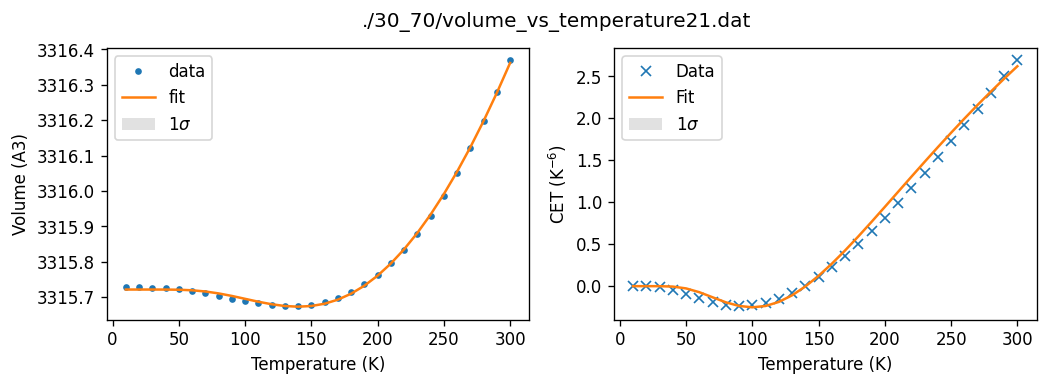

##################### ./30_70/volume_vs_temperature22.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34386
    # data points      = 30
    # variables        = 5
    chi-square         = 5.2636e-04
    reduced chi-square = 2.1054e-05
    Akaike info crit   = -318.521942
    Bayesian info crit = -311.515955
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3327.01690 +/- 5.4833e-04 (0.00%) (init = 400)
    a1:  578.554526 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -598.433285 +/-        nan (nan%) (init = 0)
    a4:  0.23165867 +/-        nan (nan%) (init = 0)
    a5:  0.02530771 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.004089637670404045
---------- DE bounds ----------
a0 :         0	     3327.02	    8000
a1 :         0	     578.555	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -598.433	    3000
a4 :        -5	    0.231659	       5
a5 :     1e-05	   0.0253077	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-1.0 < 1e-05 at iteration 2 and prob(a3=0.014771553498667343) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.2195376854753066 < 1e-05 at iteration 3 and prob(a3=0.03939080932977959) = 0.0002482029581629898 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.733486935096754 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00593  -0.00593  -0.005933327.01778  +0.00593  +0.00593  +0.00593
 a1: -87.71503 -62.67607 -33.74927 477.49793 +37.80364 +82.36799+138.21059
 a3:      -inf      -inf      -inf   0.02462      +inf      +inf      +inf
 a4:      -inf      -inf  -0.75903  -4.17299  +1.17402  +3.10972  +6.55363
 a5:  -0.00378  -0.00185  -0.00092   0.02777  +0.00102  +0.00218  +0.00363
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1037
    # data points      = 30
    # variables        = 5
    chi-square         = 4.1192e-04
    reduced chi-square = 1.6477e-05
    Akaike info crit   = -325.876478
    Bayesian info crit = -318.870491
[[Variables]]
    a0:  3327.01778 +/- 0.00148238 (0.00%) (init = 3327.017)
    a1:  477.497933 +/- 35.1643774 (7.36%) (init = 578.5545)
    a2:  0 (fixed)
    a3:  0.02461926 +/- 137.131421 (557008.80%) (init = -598.4333)
    a4: -4.17298991 +/- 0.92017725 (22.05%

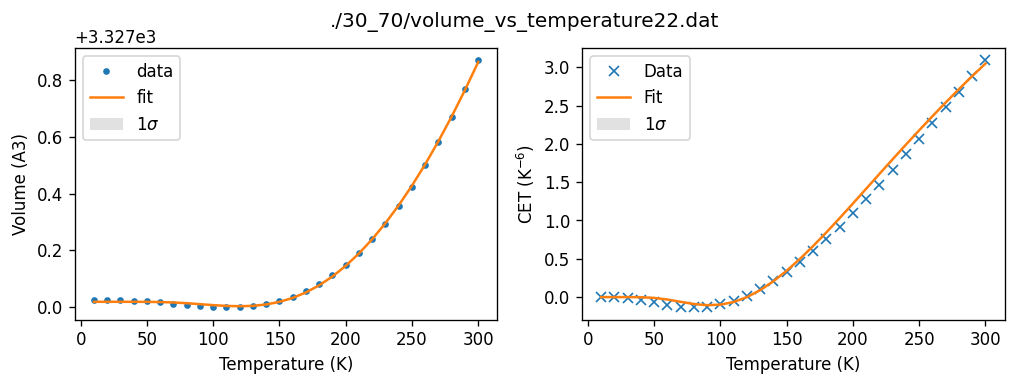

##################### ./30_70/volume_vs_temperature23.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36150
    # data points      = 30
    # variables        = 5
    chi-square         = 2.4074e-04
    reduced chi-square = 9.6296e-06
    Akaike info crit   = -341.989747
    Bayesian info crit = -334.983760
[[Variables]]
    a0:  3357.93852 +/- 0.00133951 (0.00%) (init = 400)
    a1:  743.666376 +/- 41.2059537 (5.54%) (init = 100)
    a2:  0 (fixed)
    a3:  556.303915 +/- 226.820826 (40.77%) (init = 0)
    a4:  1.17009223 +/- 3.02284809 (258.34%) (init = 0)
    a5:  0.03459465 +/- 0.00452053 (13.07%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.959
    C(a1, a4) =  0.811
    C(a0, a4) =  0.757
    C(a0, a5) = -0.685
    C(a0, a1) =  0.662
    C(a1, a5) = -0.614
    C(a3, a5) =  0.593
    C(a3, a4) = -0.354
    C(a1, a3) =  0.258
    C(a0, a3) = -0.228
Cost: -0.0026583746057

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3357.9361857115105) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3357.936231250447) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=695.9200636503124) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=698.5722936215782) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=951.4506752792781) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:      -inf      -inf      -inf3357.93621      +inf      +inf      +inf
 a1:      -inf      -inf      -inf 697.24618      +inf      +inf      +inf
 a3:      -inf      -inf      -inf 960.90293      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.98418  +0.00530  +0.01990  +0.04514
 a5:  -0.00027  -0.00016  -0.00009   0.04448      +inf      +inf      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1163
    # data points      = 30
    # variables        = 5
    chi-square         = 1.0331e-07
    reduced chi-square = 4.1323e-09
    Akaike info crit   = -574.602261
    Bayesian info crit = -567.596274
[[Variables]]
    a0:  3357.93621 +/- 2.2769e-05 (0.00%) (init = 3357.939)
    a1:  697.246179 +/- 1.32611499 (0.19%) (init = 743.6664)
    a2:  0 (fixed)
    a3:  960.902933 +/- 9.45225805 (0.98%) (init = 556.3039)
    a4: -4.98418271 +/- 0.01518911 (0.30%) (init

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a5=0.04457113169337734) = 0.0 < max(sigmas).
  warn(errmsg)


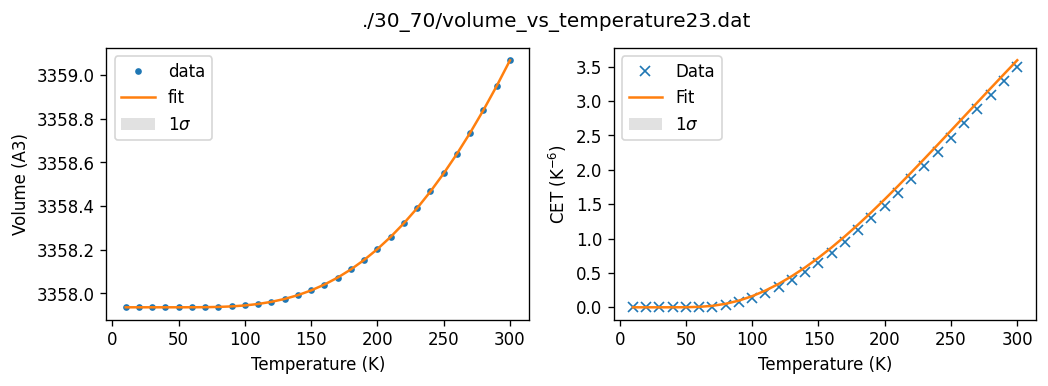

##################### ./30_70/volume_vs_temperature24.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32844
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00491213
    reduced chi-square = 1.9649e-04
    Akaike info crit   = -251.517367
    Bayesian info crit = -244.511380
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3357.46783 +/-        nan (nan%) (init = 400)
    a1:  730.463893 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2240.46317 +/-        nan (nan%) (init = 0)
    a4:  0.52594289 +/-        nan (nan%) (init = 0)
    a5:  0.05921200 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Cost: 0.001968854521692265
---------- DE bounds ----------
a0 :         0	     3357.47	    8000
a1 :         0	     730.464	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2240.46	    3000
a4 :        -5	    0.525943	       5
a5 :     1e-05	    0.059212	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0012152388298988844 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.992342017701885) = 0.17907149633377922 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00940  -0.00940  -0.009403357.46088  +0.00705  +0.00705  +0.00705
 a1: -26.44646 -19.47797 -17.34892 580.34836 +27.22934 +56.16583 +88.26058
 a3:-453.10632-324.00523-181.17953 879.44905 +31.74485 +12.49967+189.10646
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00489  -0.00433  -0.00007   0.05926  +0.00010  +0.00019  +0.00100
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 859
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00144572
    reduced chi-square = 5.7829e-05
    Akaike info crit   = -288.210261
    Bayesian info crit = -281.204274
[[Variables]]
    a0:  3357.46088 +/- 0.00235052 (0.00%) (init = 3357.468)
    a1:  580.348357 +/- 26.4949762 (4.57%) (init = 730.4639)
    a2:  0 (fixed)
    a3:  879.449049 +/- 200.245957 (22.77%) (init = 2240.463)
    a4: -5.00000000 +/- 3.8099e-05 (0.00%) (init

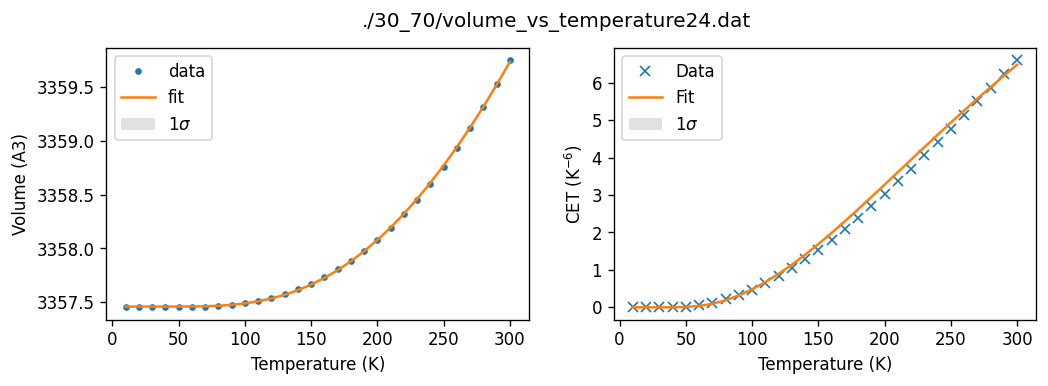

##################### ./30_70/volume_vs_temperature25.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 31098
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00204003
    reduced chi-square = 8.1601e-05
    Akaike info crit   = -277.879572
    Bayesian info crit = -270.873585
[[Variables]]
    a0:  3327.85168 +/- 0.00457865 (0.00%) (init = 400)
    a1:  447.791786 +/- 74.7288317 (16.69%) (init = 100)
    a2:  0 (fixed)
    a3: -612.066750 +/- 737.195757 (120.44%) (init = 0)
    a4: -1.14095720 +/- 4.35515288 (381.71%) (init = 0)
    a5:  0.01717765 +/- 0.00478612 (27.86%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.998
    C(a1, a3) = -0.993
    C(a1, a4) =  0.985
    C(a4, a5) = -0.984
    C(a3, a5) =  0.972
    C(a1, a5) = -0.940
    C(a0, a1) = -0.695
    C(a0, a3) =  0.643
    C(a0, a4) = -0.628
    C(a0, a5) =  0.553
Cost: -0.00583574785

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.25741795631914255 < 1e-05 at iteration 2 and prob(a3=-0.022878573838261217) = 0.00012607380030986318 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.10748295416287675 < 1e-05 at iteration 2 and prob(a3=-0.009805103073540523) = 0.00013549781873899521 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.7332041739322454 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01242  -0.01242  -0.012423327.85362  +0.01242  +0.01242  +0.01242
 a1: -79.08122 -53.11634 -27.05656 361.64942 +29.16650 +61.94341+100.42916
 a3:      -inf      -inf      -inf  -0.01634      +inf      +inf      +inf
 a4:      -inf      -inf  -0.47181  -4.48303  +0.70034  +1.85593  +3.87045
 a5:  -0.00281  -0.00172  -0.00086   0.01987  +0.00093  +0.00199  +0.00323
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 773
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00148524
    reduced chi-square = 5.9410e-05
    Akaike info crit   = -287.401270
    Bayesian info crit = -280.395283
[[Variables]]
    a0:  3327.85362 +/- 0.00310383 (0.00%) (init = 3327.852)
    a1:  361.649425 +/- 27.6435811 (7.64%) (init = 447.7918)
    a2:  0 (fixed)
    a3: -0.01634184 +/- 115.661280 (707761.74%) (init = -612.0668)
    a4: -4.48303278 +/- 0.55117505 (12.29%)

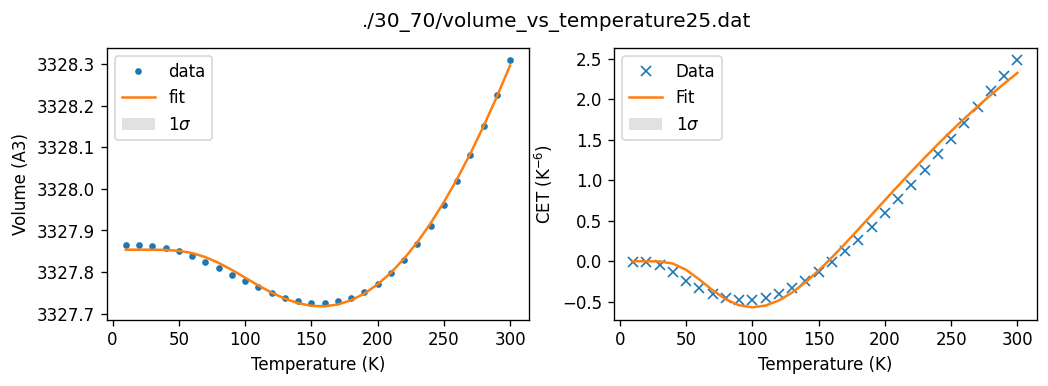

##################### ./30_70/volume_vs_temperature26.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 30948
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00269851
    reduced chi-square = 1.0794e-04
    Akaike info crit   = -269.487599
    Bayesian info crit = -262.481612
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3330.82798 +/- 0.00296595 (0.00%) (init = 400)
    a1:  788.426620 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2919.61059 +/-        nan (nan%) (init = 0)
    a4: -4.86410034 +/- 0.46844819 (9.63%) (init = 0)
    a5:  0.04241806 +/- 0.00145346 (3.43%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.662
    C(a0, a5) =  0.314


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.0012442984798326506
---------- DE bounds ----------
a0 :         0	     3330.83	    8000
a1 :         0	     788.427	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2919.61	    3000
a4 :        -5	     -4.8641	       5
a5 :     1e-05	   0.0424181	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.998478964135733) = 0.20404891555056326 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00367  -0.00367  -0.003673330.81703  +0.00092  +0.00092  +0.00092
 a1:  -0.85347 -17.57987  -0.38279 441.09542 +11.42891 +34.66222 +35.58719
 a3:  -2.21116  -1.13023  -0.14915 438.59181  +1.57039  +2.54937  +3.63740
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00084  -0.00084  -0.00000   0.03046  +0.00003  +0.00148  +0.00124
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1489
    # data points      = 30
    # variables        = 5
    chi-square         = 1.2207e-04
    reduced chi-square = 4.8826e-06
    Akaike info crit   = -362.364338
    Bayesian info crit = -355.358351
[[Variables]]
    a0:  3330.81703 +/- 9.1666e-04 (0.00%) (init = 3330.828)
    a1:  441.095423 +/- 17.7995527 (4.04%) (init = 788.4266)
    a2:  0 (fixed)
    a3:  438.591811 +/- 24.6614646 (5.62%) (init = 2919.611)
    a4: -5.00000000 +/- 7.5673e-06 (0.00%) (init

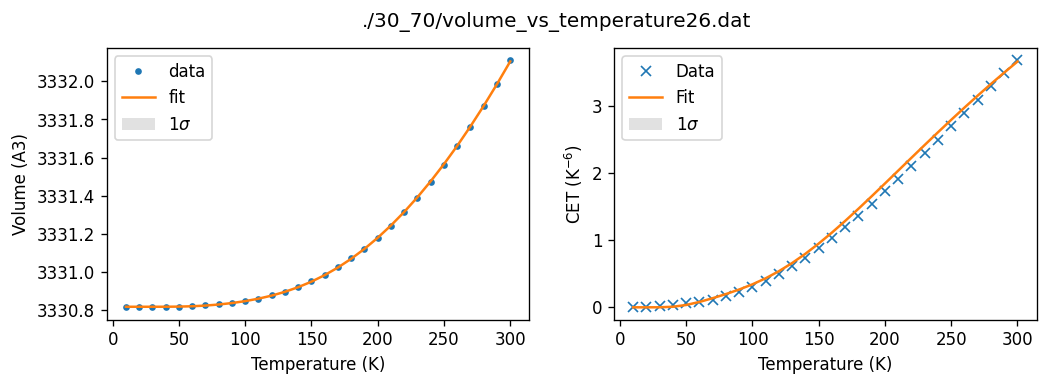

##################### ./30_70/volume_vs_temperature27.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34530
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00332031
    reduced chi-square = 1.3281e-04
    Akaike info crit   = -263.266863
    Bayesian info crit = -256.260876
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3377.84282 +/- 0.00492378 (0.00%) (init = 400)
    a1:  636.506315 +/- 34.9336954 (5.49%) (init = 100)
    a2:  0 (fixed)
    a3: -1274.91763 +/-        nan (nan%) (init = 0)
    a4:  2.57057669 +/-        nan (nan%) (init = 0)
    a5:  0.02531081 +/- 0.00194141 (7.67%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5) =  3.620
    C(a0, a5) = -1.607
    C(a0, a1) = -0.813


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.002311846822976804
---------- DE bounds ----------
a0 :         0	     3377.84	    8000
a1 :         0	     636.506	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -1274.92	    3000
a4 :        -5	     2.57058	       5
a5 :     1e-05	   0.0253108	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-1.0 < 1e-05 at iteration 3 and prob(a3=0.007569596011126124) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.33620036804763304 < 1e-05 at iteration 2 and prob(a3=0.026493586038941433) = 0.00014866567482272247 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.6906478847979799 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0013798880378311988 < 1e-05 at iteration 4 and prob(a5=0.019953369168365792) = 0.9956632821578708 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00915  -0.00915  -0.009153377.85543  +0.00915  +0.00915  +0.00915
 a1: -85.30053 -57.87055 -29.80965 409.61965 +32.60249 +69.84302+114.46926
 a3:      -inf      -inf      -inf   0.01892      +inf      +inf      +inf
 a4:      -inf      -inf  -0.58382  -4.40804  +0.89100  +2.35599  +4.91308
 a5:      -inf  -0.00180  -0.00090   0.02363  +0.00098  +0.00209  +0.00345
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1124
    # data points      = 30
    # variables        = 5
    chi-square         = 8.8211e-04
    reduced chi-square = 3.5284e-05
    Akaike info crit   = -303.031733
    Bayesian info crit = -296.025747
[[Variables]]
    a0:  3377.85543 +/- 0.00228731 (0.00%) (init = 3377.843)
    a1:  409.619651 +/- 30.6069571 (7.47%) (init = 636.5063)
    a2:  0 (fixed)
    a3:  0.01892399 +/- 125.886727 (665222.96%) (init = -1274.918)
    a4: -4.40804159 +/- 0.69576351 (15.78%

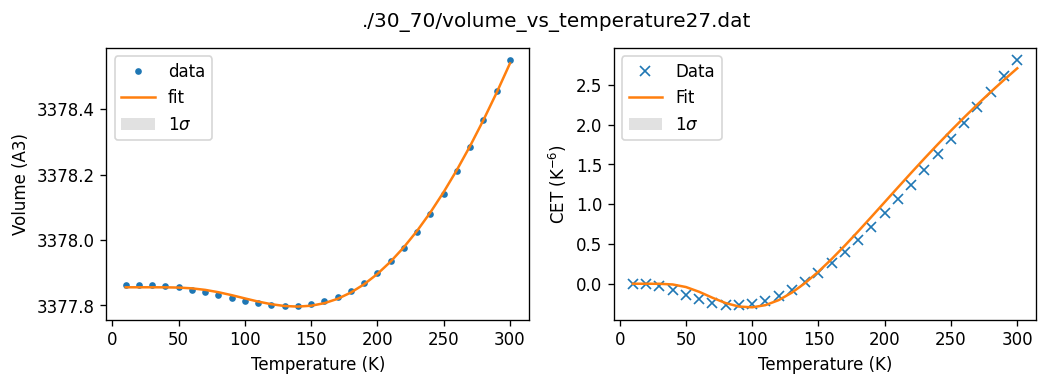

##################### ./30_70/volume_vs_temperature28.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36528
    # data points      = 30
    # variables        = 5
    chi-square         = 1.4912e-04
    reduced chi-square = 5.9650e-06
    Akaike info crit   = -356.357777
    Bayesian info crit = -349.351790
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3314.77933 +/- 7.2146e-04 (0.00%) (init = 400)
    a1:  870.905448 +/- 5.37847292 (0.62%) (init = 100)
    a2:  0 (fixed)
    a3:  2962.32363 +/-        nan (nan%) (init = 0)
    a4: -2.62182167 +/- 1.08575923 (41.41%) (init = 0)
    a5:  0.05536846 +/- 0.00208964 (3.77%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a4) =  1.219
    C(a1, a5) = -1.169
    C(a4, a5) = -0.981
    C(a0, a1) =  0.520
    C(a0, a4) =  0.378
    C(a0, a5) = -0.289


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.0008313010730489623
---------- DE bounds ----------
a0 :         0	     3314.78	    8000
a1 :         0	     870.905	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2962.32	    3000
a4 :        -5	    -2.62182	       5
a5 :     1e-05	   0.0553685	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.002085812547990315 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.946094373056551) = 0.24275014318928548 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00162  -0.00162  -0.001623314.77787  +0.00122  +0.00122  +0.00122
 a1: -11.02337  -0.31980  -0.18752 808.55105  +5.24659 +23.26612 +35.71487
 a3:-1169.95674-644.43766-208.998172105.02555  +3.31144  +5.81626+166.69218
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00009  -0.00005  -0.00002   0.05811  +0.00005  +0.00008  +0.00027
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2218
    # data points      = 30
    # variables        = 5
    chi-square         = 3.9866e-05
    reduced chi-square = 1.5946e-06
    Akaike info crit   = -395.935582
    Bayesian info crit = -388.929595
[[Variables]]
    a0:  3314.77787 +/- 4.0580e-04 (0.00%) (init = 3314.779)
    a1:  808.551054 +/- 11.7329712 (1.45%) (init = 870.9054)
    a2:  0 (fixed)
    a3:  2105.02555 +/- 176.884595 (8.40%) (init = 2962.324)
    a4: -4.99999997 +/- 2.6819e-04 (0.01%) (ini

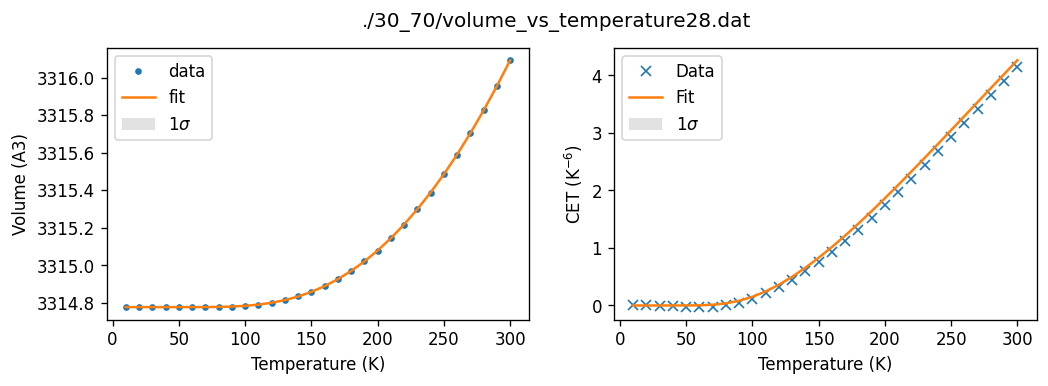

##################### ./30_70/volume_vs_temperature29.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32928
    # data points      = 30
    # variables        = 5
    chi-square         = 1.7053e-04
    reduced chi-square = 6.8211e-06
    Akaike info crit   = -352.334174
    Bayesian info crit = -345.328187
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3342.84958 +/- 6.8848e-04 (0.00%) (init = 400)
    a1:  836.684404 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2730.81562 +/-        nan (nan%) (init = 0)
    a4: -4.83606711 +/- 0.24518134 (5.07%) (init = 0)
    a5:  0.05063399 +/- 5.7387e-04 (1.13%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.795
    C(a0, a4) =  0.142
    C(a0, a5) =  0.125


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.0021297947791936167
---------- DE bounds ----------
a0 :         0	     3342.85	    8000
a1 :         0	     836.684	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2730.82	    3000
a4 :        -5	    -4.83607	       5
a5 :     1e-05	    0.050634	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.5813129808091212 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00038  -0.00038  -0.000383342.84723  +0.00038  +0.00038  +0.00038
 a1: -24.15174 -14.95937  -6.98554 716.49677  +7.50274 +11.80041 +15.82674
 a3:-251.40087-163.40257 -79.576191203.29200 +89.46588+127.73264+164.70829
 a4:      -inf      -inf      -inf  -4.79315  +0.20810  +0.41880  +0.63069
 a5:  -0.00243  -0.00155  -0.00074   0.04624  +0.00082  +0.00103  +0.00124
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1150
    # data points      = 30
    # variables        = 5
    chi-square         = 1.8145e-06
    reduced chi-square = 7.2578e-08
    Akaike info crit   = -488.627712
    Bayesian info crit = -481.621726
[[Variables]]
    a0:  3342.84723 +/- 9.4850e-05 (0.00%) (init = 3342.85)
    a1:  716.496773 +/- 6.44484003 (0.90%) (init = 836.6844)
    a2:  0 (fixed)
    a3:  1203.29200 +/- 74.7327151 (6.21%) (init = 2730.816)
    a4: -4.79314808 +/- 0.19461975 (4.06%) (init 

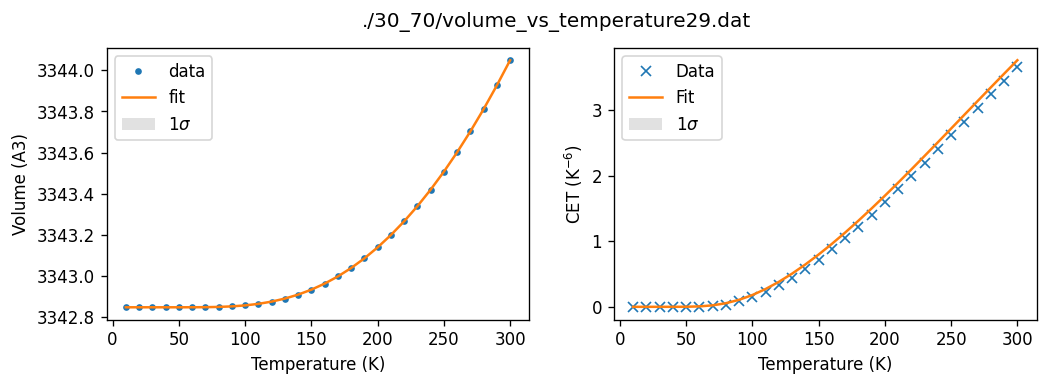

In [6]:
from glob import glob
import numpy as np
from uncertainties import correlated_values
import uncertainties.unumpy as unp
from uncertainties import ufloat

X_fit = []
Y_fit = []
Z_fit = []
X_data = []
Y_data = []
Z_data = []

folder = '30_70'

print('{0:#^100}'.format(' Shrink '))

for i in range(30):
    
    file = f'./{folder}/volume_vs_temperature{i:02d}.dat'
    
    print('{0:#^80}'.format(' '+str(file)+' '))
            
    M = np.genfromtxt(file)
    temperature = M[:,0]
    volume = M[:,1]
    
    cte_data = CET_numerical(temperature, volume)
    
    result0 = fit_volume_vs_temperature(temperature, volume, cte_data)
    result = second_fit(temperature, volume, cte_data, result0)
    
    has_uncertainties = False
    
    t_fit = np.array(temperature)
    
    if not np.any(np.diag(result.covar) < 0):
        has_uncertainties = True        
    else:
        print('!!!!!!!!!!!!!! Negative variances. Running Nelder-Mead.')
        result = second_fit(temperature, volume, cte_data, result)
        if np.any(np.diag(result.covar) >= 0):
            has_uncertainties = True
    
    
    (a0, a1, a2, a3, a4, a5, a6, a7, a8) = [result.params[k].value for k in result.params.keys()]
    
    if has_uncertainties:
        try:
            (a0, a1, a3, a4, a5) = correlated_values([a0, a1, a3, a4, a5], result.covar)
        except Exception as e:
            print("The execption", e.__class__, "occurred when trying to construct correlated variables a0, a1, a4, a4, a5.")
            print("Ignoring correlation and treating variables as independent")
            a0 = ufloat(a0,np.sqrt(np.diag(result.covar)[0]))
            a1 = ufloat(a1,np.sqrt(np.diag(result.covar)[1]))
            a3 = ufloat(a3,np.sqrt(np.diag(result.covar)[2]))
            a4 = ufloat(a4,np.sqrt(np.diag(result.covar)[3]))
            a5 = ufloat(a5,np.sqrt(np.diag(result.covar)[4]))
        
        v_fit = volume_fcn_unc(t_fit, a0, a1, a2, a3, a4, a5, a6, a7, a8)
        v_nominal = np.array([x.nominal_value for x in v_fit])
        v_unc = np.array([x.std_dev for x in v_fit])
        
        cte_fit = CET_fcn_unc(t_fit, a0, a1, a2, a3, a4, a5, a6, a7, a8)
        cte_nominal = np.array([x.nominal_value for x in cte_fit])
        cte_unc = np.array([x.std_dev for x in cte_fit])
        
        plot_unc(temperature, volume, t_fit, v_nominal, v_unc, cte_data, cte_nominal, cte_unc, file)
        
    else:
        v_nominal = volume_fcn(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
        v_unc = np.zeros(len(v_nominal))
        
        cte_nominal = CET_fcn_unc(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
        cte_unc = np.zeros(len(v_nominal))
        
        plot(temperature, volume, t_fit, v_nominal, cte_data, cte_nominal, file)
            
    with open(file.rstrip('dat')+'fit','w') as f:
        f.write('#{T:5}\t{V:10}\t{Vfit:10}\t{Vunc:10}\t{CET:10}\t{CETfit:10}\t{CETunc:10}\n'.format(T='T(K)',V='V(A3)',Vfit='Vfit(A3)',Vunc='Vunc(A3)',CET='CET(1/K)',CETfit='CETfit(1/K)',CETunc='CETunc(1/K)'))
        for i in range(len(temperature)):
            f.write('{T:5.1f}\t{V:10f}\t{Vfit:10f}\t{Vunc:10f}\t{CET: 10e}\t{CETfit: 10e}\t{CETunc: 10e}\n'.format(T=temperature[i],V=volume[i],Vfit=v_nominal[i],Vunc=v_unc[i],CET=cte_data[i],CETfit=cte_nominal[i],CETunc=cte_unc[i]))
    


In [ ]:
glob('./30_40/volume_vs_tmperature*.dat')

In [23]:
with open('sp2_30_70.txt','w') as f:
    for i in range(30):
        A = np.genfromtxt(f'./30_70/volume_vs_temperature{i:02d}.fit')
        cet100 = A[9,5]
        cet300 = A[29,5]
        f.write(f'{i:02d}\t{cet100:0.6e}\t{cet300:0.6e}\n')
    

# 40% - 60%

############################################## Shrink ##############################################
##################### ./40_60/volume_vs_temperature00.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32958
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00329780
    reduced chi-square = 1.3191e-04
    Akaike info crit   = -263.470924
    Bayesian info crit = -256.464937
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3459.24790 +/- 0.00454909 (0.00%) (init = 400)
    a1:  436.066440 +/- 7.86546073 (1.80%) (init = 100)
    a2:  0 (fixed)
    a3: -404.519750 +/-        nan (nan%) (init = 0)
    a4: -4.07770314 +/-        nan (nan%) (init = 0)
    a5:  0.02935426 +/- 0.00131434 (4.48%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5) =  3.201
    C(a0, a1) = -1.044
    C(a0, a5) = -0.604


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.0063040234590516775
---------- DE bounds ----------
a0 :         0	     3459.25	    8000
a1 :         0	     436.066	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     -404.52	    3000
a4 :        -5	     -4.0777	       5
a5 :     1e-05	   0.0293543	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 8.960376827665044e-05 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.963999375242592) = 0.173826561697034 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01757  -0.01757  -0.017573459.24928  +0.00879  +0.00879  +0.00879
 a1: -16.49418  -4.45406  -2.30760 404.34177  +1.74002  +3.94856  +6.68554
 a3:-107.33258 -95.75503 -69.08273-191.55407 +33.56983 +93.52211+100.12235
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00124  -0.00106  -0.00091   0.02884  +0.00007  +0.00044  +0.00032
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1222
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00302001
    reduced chi-square = 1.2080e-04
    Akaike info crit   = -266.110783
    Bayesian info crit = -259.104796
[[Variables]]
    a0:  3459.24928 +/- 0.00439332 (0.00%) (init = 3459.248)
    a1:  404.341772 +/- 17.2405027 (4.26%) (init = 436.0664)
    a2:  0 (fixed)
    a3: -191.554068 +/- 53.6662888 (28.02%) (init = -404.5197)
    a4: -4.99999999 +/- 1.7911e-04 (0.00%) (in

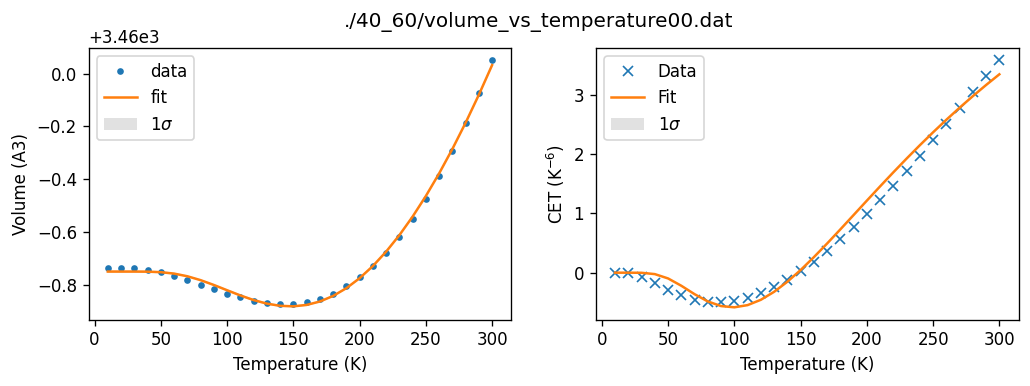

##################### ./40_60/volume_vs_temperature01.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32748
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00157679
    reduced chi-square = 6.3072e-05
    Akaike info crit   = -285.606871
    Bayesian info crit = -278.600884
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3461.07471 +/- 0.00193947 (0.00%) (init = 400)
    a1:  531.655465 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -847.522139 +/-        nan (nan%) (init = 0)
    a4:  0.55045539 +/-        nan (nan%) (init = 0)
    a5:  0.02491434 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.004912917771889624
---------- DE bounds ----------
a0 :         0	     3461.07	    8000
a1 :         0	     531.655	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -847.522	    3000
a4 :        -5	    0.550455	       5
a5 :     1e-05	   0.0249143	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.9609478529972342 < 1e-05 at iteration 3 and prob(a3=-6.183678116664668) = 0.024140849497545937 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.004677849102639233 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.26876850680853204 < 1e-05 at iteration 2 and prob(a4=-4.998575058289219) = 0.07561846847110446 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01034  -0.01034  -0.010343461.07650  +0.00517  +0.00517  +0.00517
 a1:  -4.19770  -2.63607  -1.43738 425.04160  +0.82616 +35.95901 +35.94748
 a3:      -inf      -inf      -inf  -3.86480  +3.25276  +5.99856  +9.09339
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00012  -0.00097  -0.00003   0.02885  +0.00005  +0.00011  +0.00015
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2483
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00115529
    reduced chi-square = 4.6211e-05
    Akaike info crit   = -294.938104
    Bayesian info crit = -287.932117
[[Variables]]
    a0:  3461.07650 +/- 0.00258625 (0.00%) (init = 3461.075)
    a1:  425.041599 +/- 17.9795029 (4.23%) (init = 531.6555)
    a2:  0 (fixed)
    a3: -3.86479882 +/- 32.3987039 (838.30%) (init = -847.5221)
    a4: -4.99999999 +/- 7.1247e-04 (0.01%) (i

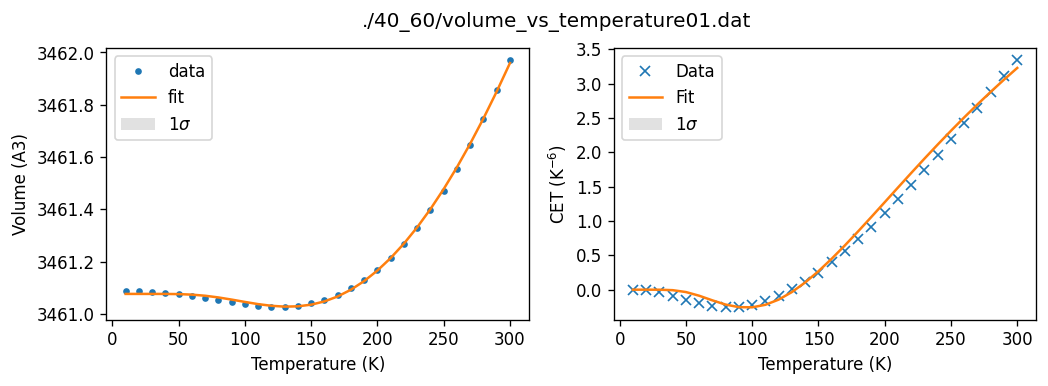

##################### ./40_60/volume_vs_temperature02.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 38106
    # data points      = 30
    # variables        = 5
    chi-square         = 2.6296e-04
    reduced chi-square = 1.0518e-05
    Akaike info crit   = -339.341356
    Bayesian info crit = -332.335369
[[Variables]]
    a0:  3487.79678 +/- 9.9049e-04 (0.00%) (init = 400)
    a1:  861.320664 +/- 85.2862121 (9.90%) (init = 100)
    a2:  0 (fixed)
    a3:  2029.43607 +/- 2348.33316 (115.71%) (init = 0)
    a4: -0.37024904 +/- 6.91889888 (1868.71%) (init = 0)
    a5:  0.04820803 +/- 0.01606106 (33.32%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.997
    C(a1, a3) =  0.988
    C(a3, a5) =  0.978
    C(a3, a4) = -0.963
    C(a1, a5) =  0.936
    C(a1, a4) = -0.911
    C(a0, a1) =  0.226
    C(a0, a3) =  0.152
Cost: -0.0008904591227292258
---------- DE bounds ----------
a0 : 

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0214784724132936 < 1e-05 at iteration 4 and prob(a3=2999.685941137841) = 0.01552293435208753 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.0004551228040775533 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00189  -0.00189  -0.001893487.79700  +0.00379  +0.00379  +0.00379
 a1: -11.23210 -10.98799  -7.93140 896.53646  +0.30397  +0.69381  +1.96940
 a3:      -inf      -inf      -inf3000.00000      +inf      +inf      +inf
 a4:  -1.90393  -0.06345  -0.02656  -2.45873  +1.79715  +1.98280  +1.97923
 a5:  -0.00035  -0.00022  -0.00010   0.05302  +0.00149  +0.00376  +0.00387
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1494
    # data points      = 30
    # variables        = 5
    chi-square         = 2.4759e-04
    reduced chi-square = 9.9036e-06
    Akaike info crit   = -341.147947
    Bayesian info crit = -334.141960
[[Variables]]
    a0:  3487.79700 +/- 9.4635e-04 (0.00%) (init = 3487.797)
    a1:  896.536463 +/- 11.2660327 (1.26%) (init = 861.3207)
    a2:  0 (fixed)
    a3:  3000.00000 +/- 0.07851425 (0.00%) (init = 2029.436)
    a4: -2.45872501 +/- 1.98298540 (80.65%) (ini

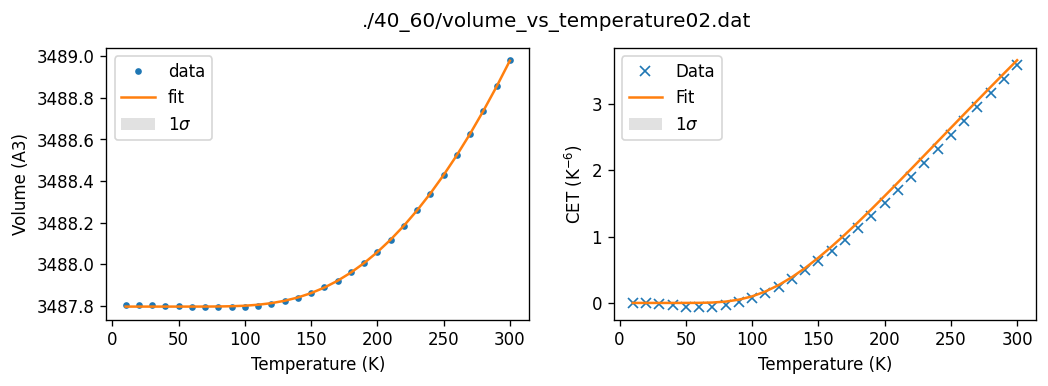

##################### ./40_60/volume_vs_temperature03.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36072
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00690671
    reduced chi-square = 2.7627e-04
    Akaike info crit   = -241.293768
    Bayesian info crit = -234.287781
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3407.08624 +/- 0.00428242 (0.00%) (init = 400)
    a1:  882.890867 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -86.3436960 +/- 857.959317 (993.66%) (init = 0)
    a4:  0.85078466 +/- 10.6748368 (1254.70%) (init = 0)
    a5:  0.05355573 +/- 0.01601436 (29.90%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -1.138
    C(a4, a5) = -1.052
    C(a3, a5) =  0.932
    C(a0, a4) =  0.100


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.0016426142428827006
---------- DE bounds ----------
a0 :         0	     3407.09	    8000
a1 :         0	     882.891	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -86.3437	    3000
a4 :        -5	    0.850785	       5
a5 :     1e-05	   0.0535557	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.007458656770540984) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.011187985155811476) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.8903071965228851 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00906  -0.00906  -0.009063407.10578  +0.00906  +0.00906  +0.00906
 a1: -91.71770 -62.34337 -32.17690 417.55177 +35.86536 +77.85186+129.85451
 a3:      -inf      -inf      -inf   0.00932      +inf      +inf      +inf
 a4:      -inf      -inf  -0.64575  -4.05701  +1.00073  +2.67308  +5.68027
 a5:  -0.00289  -0.00187  -0.00094   0.02474  +0.00104  +0.00223  +0.00372
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1922
    # data points      = 30
    # variables        = 5
    chi-square         = 8.7154e-04
    reduced chi-square = 3.4862e-05
    Akaike info crit   = -303.393445
    Bayesian info crit = -296.387458
[[Variables]]
    a0:  3407.10578 +/- 0.00226512 (0.00%) (init = 3407.086)
    a1:  417.551774 +/- 33.4022295 (8.00%) (init = 882.8909)
    a2:  0 (fixed)
    a3:  0.00932332 +/- 125.475255 (1345821.47%) (init = -86.3437)
    a4: -4.05701381 +/- 0.77911771 (19.20%

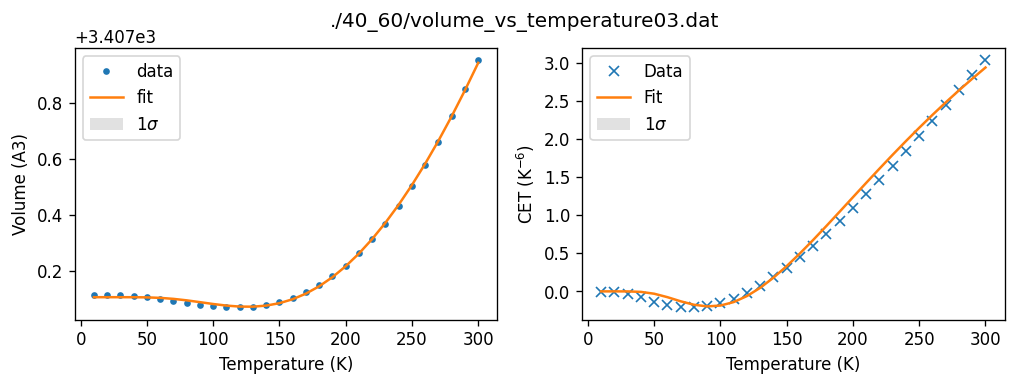

##################### ./40_60/volume_vs_temperature04.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 27954
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00410217
    reduced chi-square = 1.6409e-04
    Akaike info crit   = -256.923065
    Bayesian info crit = -249.917078
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3381.53666 +/- 0.00492933 (0.00%) (init = 400)
    a1:  493.003928 +/- 9.76956761 (1.98%) (init = 100)
    a2:  0 (fixed)
    a3: -1609.26116 +/-        nan (nan%) (init = 0)
    a4:  4.23015098 +/-        nan (nan%) (init = 0)
    a5:  0.00224933 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a1) = -0.743


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.0010859457438527897
---------- DE bounds ----------
a0 :         0	     3381.54	    8000
a1 :         0	     493.004	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -1609.26	    3000
a4 :        -5	     4.23015	       5
a5 :     1e-05	  0.00224933	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.004941190384488437) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.007411785576732654) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.8332983804740219 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.00018473674895467932 < 1e-05 at iteration 4 and prob(a5=0.010355301220712387) = 0.9969464284974328 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01396  -0.01396  -0.013963381.54077  +0.01396  +0.01396  +0.01396
 a1: -80.15059 -53.54590 -27.12633 348.80563 +28.89601 +60.92352 +97.88484
 a3:      -inf      -inf      -inf   0.00618      +inf      +inf      +inf
 a4:      -inf      -inf  -0.40309  -4.45065  +0.55636  +1.51500  +3.27703
 a5:      -inf  -0.00176  -0.00088   0.01394  +0.00095  +0.00203  +0.00314
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1105
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00182528
    reduced chi-square = 7.3011e-05
    Akaike info crit   = -281.216520
    Bayesian info crit = -274.210533
[[Variables]]
    a0:  3381.54077 +/- 0.00349056 (0.00%) (init = 3381.537)
    a1:  348.805628 +/- 27.5336224 (7.89%) (init = 493.0039)
    a2:  0 (fixed)
    a3:  0.00617649 +/- 113.940558 (1844746.70%) (init = -1609.261)
    a4: -4.45064837 +/- 0.44240917 (9.94%

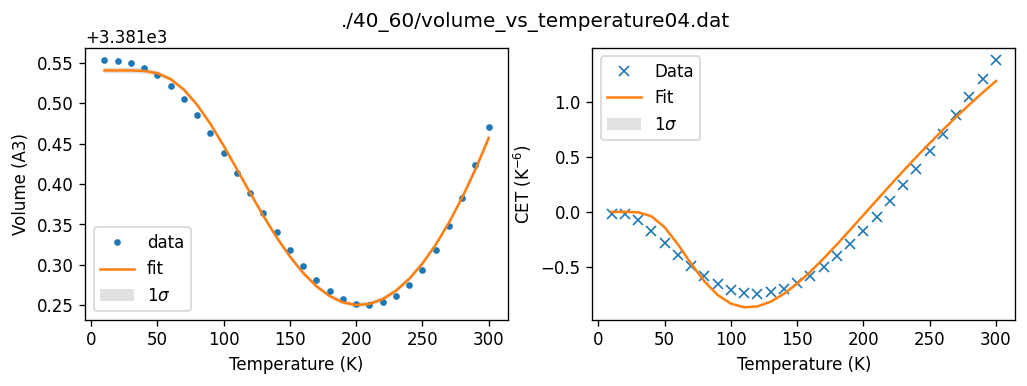

##################### ./40_60/volume_vs_temperature05.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34656
    # data points      = 30
    # variables        = 5
    chi-square         = 5.1531e-04
    reduced chi-square = 2.0612e-05
    Akaike info crit   = -319.158155
    Bayesian info crit = -312.152168
[[Variables]]
    a0:  3404.74750 +/- 0.00171143 (0.00%) (init = 400)
    a1:  612.017957 +/- 88.7563282 (14.50%) (init = 100)
    a2:  0 (fixed)
    a3: -434.030165 +/- 407.290352 (93.84%) (init = 0)
    a4:  1.03628501 +/- 4.61126954 (444.98%) (init = 0)
    a5:  0.02840171 +/- 0.00341367 (12.02%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.996
    C(a1, a4) =  0.974
    C(a1, a3) = -0.951
    C(a3, a5) =  0.927
    C(a4, a5) = -0.897
    C(a1, a5) = -0.775
    C(a0, a1) = -0.483
    C(a0, a4) = -0.382
    C(a0, a3) =  0.318
    C(a0, a5) =  0.150
Cost: -0.003712775628

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.029900435968033195 < 1e-05 at iteration 2 and prob(a3=-0.004941623895367229) = 0.00016769526513886154 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.001941623895367229) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.9434299585293014 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00611  -0.00611  -0.006113404.74830  +0.00611  +0.00611  +0.00611
 a1:-114.24108 -79.81484 -40.22469 501.55112 +51.64365 +87.06494 +91.09876
 a3:      -inf      -inf      -inf  -0.00294      +inf      +inf      +inf
 a4:      -inf      -inf  -1.00069  -3.38351  +1.65797  +4.74815  +4.96154
 a5:  -0.00339  -0.00219  -0.00112   0.02997  +0.00128  +0.00285  +0.00502
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1222
    # data points      = 30
    # variables        = 5
    chi-square         = 4.4318e-04
    reduced chi-square = 1.7727e-05
    Akaike info crit   = -323.682291
    Bayesian info crit = -316.676304
[[Variables]]
    a0:  3404.74830 +/- 0.00152771 (0.00%) (init = 3404.748)
    a1:  501.551121 +/- 45.5971447 (9.09%) (init = 612.018)
    a2:  0 (fixed)
    a3: -0.00294162 +/- 139.674143 (4748198.53%) (init = -434.0302)
    a4: -3.38350831 +/- 1.24038484 (36.66%

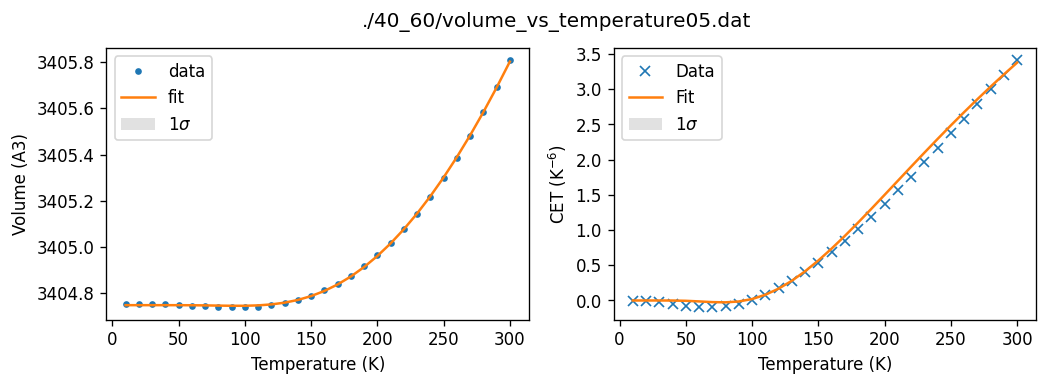

##################### ./40_60/volume_vs_temperature06.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35736
    # data points      = 30
    # variables        = 5
    chi-square         = 6.8189e-05
    reduced chi-square = 2.7276e-06
    Akaike info crit   = -379.832686
    Bayesian info crit = -372.826699
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3467.38940 +/-        nan (nan%) (init = 400)
    a1:  828.950616 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2524.90974 +/-        nan (nan%) (init = 0)
    a4: -4.97054031 +/- 0.09422340 (1.90%) (init = 0)
    a5:  0.05409670 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Cost: 0.0010762066835923179
---------- DE bounds ----------
a0 :         0	     3467.39	    8000
a1 :         0	     828.951	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2524.91	    3000
a4 :        -5	    -4.97054	       5
a5 :     1e-05	   0.0540967	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.004638677832785565 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00084  -0.00084  -0.000843467.38819  +0.00063  +0.00063  +0.00063
 a1:  -2.50008  -0.25184      +nan 760.81278      +nan  +0.99475  +6.80924
 a3:-149.64956 -92.39799      +nan1577.98276      +nan  +2.95592 +50.73180
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00009  -0.00002      +nan   0.05151      +nan  +0.00004  +0.00006
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2407
    # data points      = 30
    # variables        = 5
    chi-square         = 9.9165e-06
    reduced chi-square = 3.9666e-07
    Akaike info crit   = -437.675177
    Bayesian info crit = -430.669190
[[Variables]]
    a0:  3467.38819 +/- 2.0920e-04 (0.00%) (init = 3467.389)
    a1:  760.812780 +/- 6.80924463 (0.89%) (init = 828.9506)
    a2:  0 (fixed)
    a3:  1577.98276 +/- 75.3476331 (4.77%) (init = 2524.91)
    a4: -5.00000000 +/- 2.7973e-05 (0.00%) (init 

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-9.893085342567426e-05 < 1e-05 at iteration 178 and prob(a4=-4.9950208024499165) = 0.12572868233942536 < max(sigmas).
  warn(errmsg)


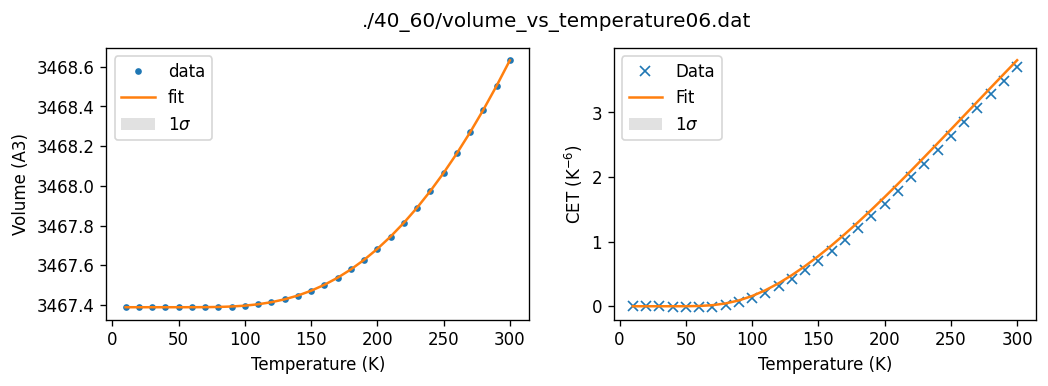

##################### ./40_60/volume_vs_temperature07.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 30618
    # data points      = 30
    # variables        = 5
    chi-square         = 2.4204e-04
    reduced chi-square = 9.6816e-06
    Akaike info crit   = -341.828007
    Bayesian info crit = -334.822020
[[Variables]]
    a0:  3426.71488 +/- 0.00100016 (0.00%) (init = 400)
    a1:  716.094311 +/- 27.3580362 (3.82%) (init = 100)
    a2:  0 (fixed)
    a3:  1541.71256 +/- 353.742593 (22.94%) (init = 0)
    a4: -4.97916085 +/- 0.30453663 (6.12%) (init = 0)
    a5:  0.06607283 +/- 0.00237969 (3.60%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.993
    C(a3, a5) =  0.976
    C(a1, a5) =  0.961
    C(a0, a1) =  0.466
    C(a0, a5) =  0.461
    C(a0, a3) =  0.424
    C(a4, a5) = -0.388
    C(a3, a4) = -0.243
    C(a1, a4) = -0.141
Cost: -0.0021035767076682532
---------- DE bound

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0029802966011906423 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.972459920286356) = 0.1834471057778389 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00395  -0.00395  -0.003953426.71521  +0.00198  +0.00198  +0.00198
 a1:-113.00385 -58.20412  -0.27263 737.27420 +12.32531 +42.70121 +63.86497
 a3:-336.41195-336.73244-335.774861834.15040 +21.00768+664.14771+673.64839
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00064  -0.00170  -0.00005   0.06774  +0.00115  +0.00117  +0.00021
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1003
    # data points      = 30
    # variables        = 5
    chi-square         = 2.3478e-04
    reduced chi-square = 9.3911e-06
    Akaike info crit   = -342.742021
    Bayesian info crit = -335.736034
[[Variables]]
    a0:  3426.71521 +/- 9.8808e-04 (0.00%) (init = 3426.715)
    a1:  737.274198 +/- 23.0022921 (3.12%) (init = 716.0943)
    a2:  0 (fixed)
    a3:  1834.15040 +/- 336.824196 (18.36%) (init = 1541.713)
    a4: -4.99999999 +/- 1.3702e-04 (0.00%) (ini

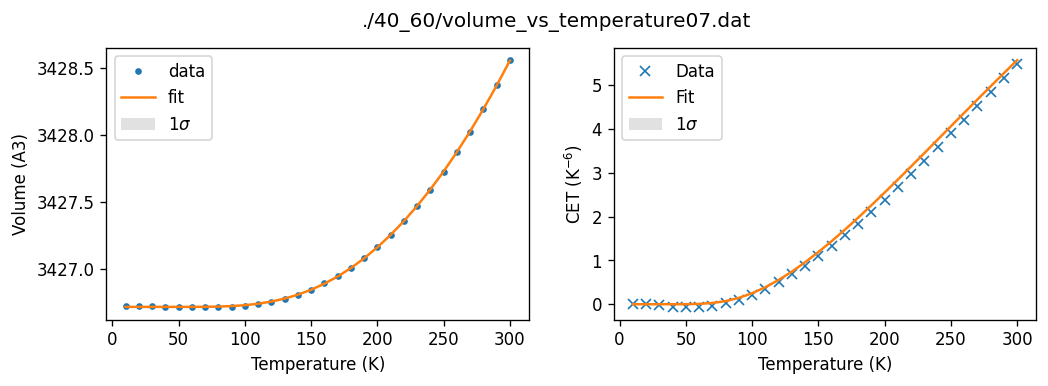

##################### ./40_60/volume_vs_temperature08.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33996
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00103019
    reduced chi-square = 4.1208e-05
    Akaike info crit   = -298.376349
    Bayesian info crit = -291.370362
[[Variables]]
    a0:  3463.96392 +/- 0.00259739 (0.00%) (init = 400)
    a1:  543.535109 +/- 40.8168622 (7.51%) (init = 100)
    a2:  0 (fixed)
    a3: -113.853776 +/- 139.165121 (122.23%) (init = 0)
    a4: -3.88809935 +/- 1.20257052 (30.93%) (init = 0)
    a5:  0.03952897 +/- 0.00251795 (6.37%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.992
    C(a1, a4) =  0.701
    C(a1, a5) =  0.696
    C(a1, a3) = -0.674
    C(a0, a5) = -0.602
    C(a0, a1) = -0.564
    C(a0, a4) = -0.156
Cost: -0.004320087603900902
---------- DE bounds ----------
a0 :         0	     3463.96	    

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.340099521057536 < 1e-05 at iteration 3 and prob(a3=0.002248451453851885) = 0.00018596532423764591 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.2536056864611304 < 1e-05 at iteration 3 and prob(a3=0.00899380581540754) = 0.0002996004477969058 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.18454686627952316 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00815  -0.00815  -0.008153463.96730  +0.00815  +0.00815  +0.00815
 a1: -60.96491 -42.03215 -24.45501 472.05896 +41.84043 +93.22302+162.05100
 a3:      -inf      -inf      -inf   0.00562      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.71871  +1.62647  +4.39352  +9.62126
 a5:  -0.00474  -0.00245  -0.00123   0.03552  +0.00137  +0.00297  +0.00502
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1265
    # data points      = 30
    # variables        = 5
    chi-square         = 7.6568e-04
    reduced chi-square = 3.0627e-05
    Akaike info crit   = -307.278185
    Bayesian info crit = -300.272198
[[Variables]]
    a0:  3463.96730 +/- 0.00203736 (0.00%) (init = 3463.964)
    a1:  472.058958 +/- 37.9901978 (8.05%) (init = 543.5351)
    a2:  0 (fixed)
    a3:  0.00562113 +/- 165.091170 (2936975.48%) (init = -113.8538)
    a4: -4.71871237 +/- 1.24764117 (26.44

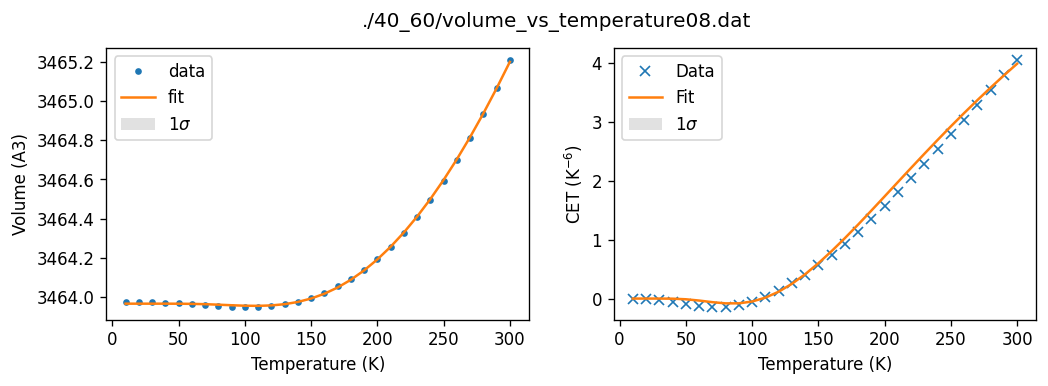

##################### ./40_60/volume_vs_temperature09.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33246
    # data points      = 30
    # variables        = 5
    chi-square         = 2.1230e-04
    reduced chi-square = 8.4920e-06
    Akaike info crit   = -345.761124
    Bayesian info crit = -338.755137
[[Variables]]
    a0:  3482.81568 +/- 0.00126215 (0.00%) (init = 400)
    a1:  662.482049 +/- 36.1747758 (5.46%) (init = 100)
    a2:  0 (fixed)
    a3:  1320.38443 +/- 342.998168 (25.98%) (init = 0)
    a4: -4.98435331 +/- 0.06800161 (1.36%) (init = 0)
    a5:  0.05126413 +/- 0.00211253 (4.12%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.999
    C(a1, a5) =  0.994
    C(a3, a5) =  0.991
    C(a0, a5) =  0.764
    C(a0, a1) =  0.745
    C(a0, a3) =  0.727
    C(a4, a5) = -0.107
Cost: -0.0036884061742057384
---------- DE bounds ----------
a0 :         0	     3482.82	    8

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0006703933290093738 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.991492134968797) = 0.2989549438530369 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00286  -0.00286  -0.002863482.81448  +0.00214  +0.00214  +0.00214
 a1: -11.22656  -7.91575  -0.26348 595.19442  +9.01436 +17.01624  +2.15481
 a3: -99.03902 -98.76039 -58.84237 812.29809  +2.59090  +4.42984  +6.54686
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00114  -0.00004  -0.00001   0.04710  +0.00004  +0.00007  +0.00010
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 904
    # data points      = 30
    # variables        = 5
    chi-square         = 1.1951e-04
    reduced chi-square = 4.7803e-06
    Akaike info crit   = -362.999987
    Bayesian info crit = -355.994000
[[Variables]]
    a0:  3482.81448 +/- 7.1439e-04 (0.00%) (init = 3482.816)
    a1:  595.194417 +/- 17.1855001 (2.89%) (init = 662.482)
    a2:  0 (fixed)
    a3:  812.298087 +/- 99.1553734 (12.21%) (init = 1320.384)
    a4: -4.99999999 +/- 4.2328e-05 (0.00%) (init 

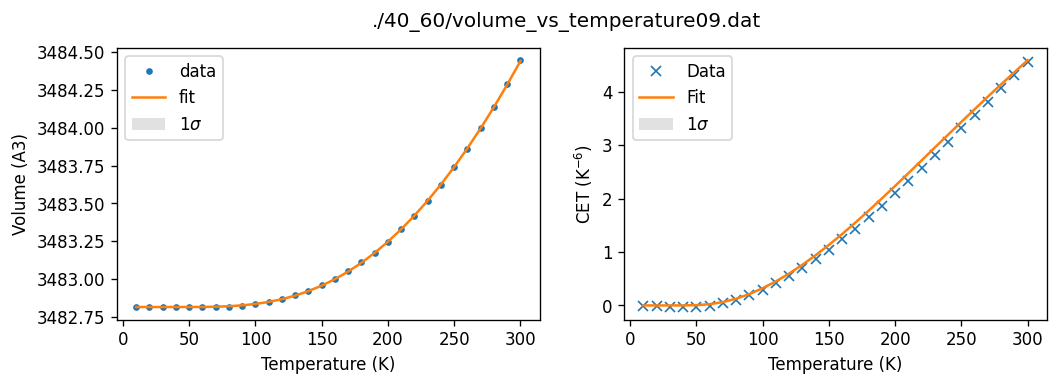

##################### ./40_60/volume_vs_temperature10.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33498
    # data points      = 30
    # variables        = 5
    chi-square         = 2.6647e-04
    reduced chi-square = 1.0659e-05
    Akaike info crit   = -338.943710
    Bayesian info crit = -331.937723
[[Variables]]
    a0:  3403.09938 +/- 9.8026e-04 (0.00%) (init = 400)
    a1:  876.933831 +/- 51.8599075 (5.91%) (init = 100)
    a2:  0 (fixed)
    a3:  2020.11218 +/- 1457.08453 (72.13%) (init = 0)
    a4:  0.79156041 +/- 4.08107978 (515.57%) (init = 0)
    a5:  0.06021366 +/- 0.01016490 (16.88%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.977
    C(a1, a3) =  0.964
    C(a3, a5) =  0.930
    C(a3, a4) = -0.838
    C(a1, a5) =  0.805
    C(a1, a4) = -0.665
    C(a0, a1) =  0.191
    C(a0, a4) =  0.177
Cost: 0.0008227372827604995
---------- DE bounds ----------
a0 :    

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.010910943894166221 < 1e-05 at iteration 7 and prob(a3=2999.8323462154062) = 0.011644834016187953 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.0022767749720260994 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00190  -0.00190  -0.001903403.09957  +0.00380  +0.00380  +0.00380
 a1: -11.64843 -11.51118  -6.78921 908.86714  +0.98556 +11.70765  +0.97470
 a3:      -inf      -inf      -inf3000.00000      +inf      +inf      +inf
 a4:  -0.10095  -0.16617  -0.04766  -1.22673  +0.03624  +0.13714  +0.10906
 a5:  -0.00145  -0.00025  -0.00137   0.06559  +0.00099  +0.00037  +0.00045
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1597
    # data points      = 30
    # variables        = 5
    chi-square         = 2.5206e-04
    reduced chi-square = 1.0082e-05
    Akaike info crit   = -340.611368
    Bayesian info crit = -333.605381
[[Variables]]
    a0:  3403.09957 +/- 9.4910e-04 (0.00%) (init = 3403.099)
    a1:  908.867139 +/- 11.7076501 (1.29%) (init = 876.9338)
    a2:  0 (fixed)
    a3:  3000.00000 +/- 0.02395052 (0.00%) (init = 2020.112)
    a4: -1.22672680 +/- 2.31437135 (188.66%) (in

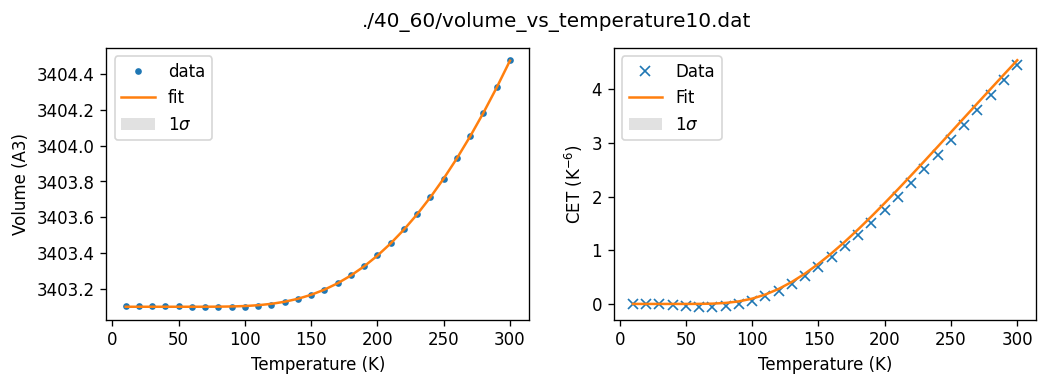

##################### ./40_60/volume_vs_temperature11.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 31722
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00224437
    reduced chi-square = 8.9775e-05
    Akaike info crit   = -275.015874
    Bayesian info crit = -268.009887
[[Variables]]
    a0:  3461.06368 +/- 0.00324008 (0.00%) (init = 400)
    a1:  536.099634 +/- 35.5960490 (6.64%) (init = 100)
    a2:  0 (fixed)
    a3:  669.476191 +/- 174.052022 (26.00%) (init = 0)
    a4: -4.22295247 +/- 0.67535099 (15.99%) (init = 0)
    a5:  0.04627202 +/- 0.00237730 (5.14%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.954
    C(a1, a3) =  0.900
    C(a1, a5) =  0.833
    C(a1, a4) =  0.433
    C(a0, a1) =  0.394
    C(a0, a4) =  0.351
    C(a0, a5) =  0.272
    C(a0, a3) =  0.191
    C(a4, a5) = -0.123
Cost: -0.005810366701552994
---------- DE bound

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00041028918125689544 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.999332168642308) = 0.06193502741503546 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01091  -0.01091  -0.010913461.06217  +0.00546  +0.00546  +0.00546
 a1: -29.73845  -7.60013  -0.60245 510.73878 +20.63680 +21.63281 +29.83394
 a3: -49.27451-176.80261-117.03374 636.84460+103.97911+356.96731+409.41786
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00220  -0.00217  -0.00006   0.04606  +0.00143  +0.00145  +0.00220
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 593
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00173983
    reduced chi-square = 6.9593e-05
    Akaike info crit   = -282.655028
    Bayesian info crit = -275.649041
[[Variables]]
    a0:  3461.06217 +/- 0.00272818 (0.00%) (init = 3461.064)
    a1:  510.738781 +/- 29.8339379 (5.84%) (init = 536.0996)
    a2:  0 (fixed)
    a3:  636.844604 +/- 132.068878 (20.74%) (init = 669.4762)
    a4: -5.00000000 +/- 3.3225e-06 (0.00%) (init

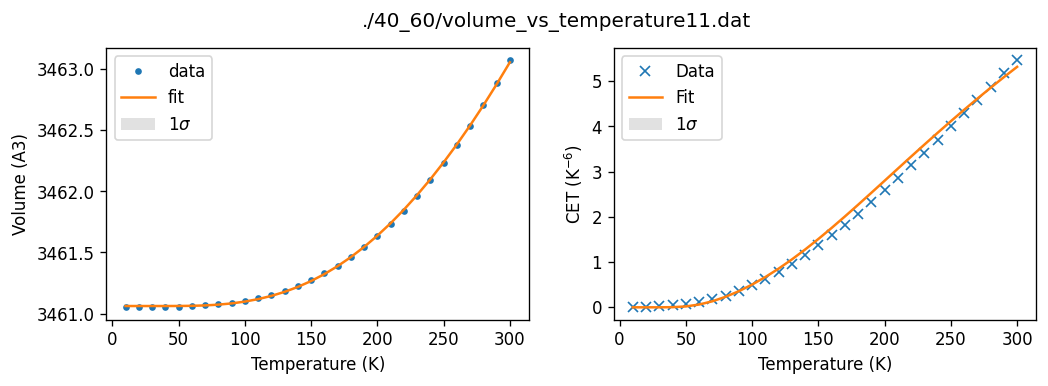

##################### ./40_60/volume_vs_temperature12.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33570
    # data points      = 30
    # variables        = 5
    chi-square         = 1.9640e-04
    reduced chi-square = 7.8561e-06
    Akaike info crit   = -348.096144
    Bayesian info crit = -341.090157
[[Variables]]
    a0:  3410.74236 +/- 9.0763e-04 (0.00%) (init = 400)
    a1:  685.108897 +/- 36.1633505 (5.28%) (init = 100)
    a2:  0 (fixed)
    a3: -170.049294 +/- 114.292982 (67.21%) (init = 0)
    a4:  0.97777138 +/- 1.50405581 (153.82%) (init = 0)
    a5:  0.03257267 +/- 0.00190739 (5.86%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.965
    C(a1, a4) =  0.786
    C(a3, a4) = -0.634
    C(a4, a5) = -0.527
    C(a0, a3) = -0.475
    C(a0, a5) = -0.396
    C(a0, a1) = -0.218
    C(a1, a5) =  0.107
Cost: -0.0036847924093308393
---------- DE bounds ----------
a0 :    

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.033011254495197456 < 1e-05 at iteration 2 and prob(a1=707.2029911810328) = 0.8047957586021857 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.8118070073425577 < 1e-05 at iteration 2 and prob(a3=0.003962467877136078) = 0.0002722218479274414 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.5177266526685664 < 1e-05 at iteration 3 and prob(a3=0.01056658100569621) = 0.0013508017227069655 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.9798967690249867 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.3816216363200476 < 1e-05 at iteration 4 and prob(

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00379  -0.00379  -0.003793410.74276  +0.00379  +0.00379  +0.00379
 a1:-135.16321 -81.13155 -53.44509 584.71541 +79.31916      +inf      +inf
 a3:      -inf      -inf      -inf   0.00660      +inf      +inf      +inf
 a4:      -inf  -2.31977  -1.39202  -2.52268      +inf      +inf      +inf
 a5:  -0.00374  -0.00226  -0.00117   0.03268      +inf      +inf      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1167
    # data points      = 30
    # variables        = 5
    chi-square         = 1.8552e-04
    reduced chi-square = 7.4208e-06
    Akaike info crit   = -349.806483
    Bayesian info crit = -342.800496
[[Variables]]
    a0:  3410.74276 +/- 9.4828e-04 (0.00%) (init = 3410.742)
    a1:  584.715410 +/- 61.2437906 (10.47%) (init = 685.1089)
    a2:  0 (fixed)
    a3:  0.00660411 +/- 135.931954 (2058292.32%) (init = -170.0493)
    a4: -2.52267872 +/- 1.79748336 (71.2

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.4253315211001452 < 1e-05 at iteration 4 and prob(a5=0.03770612638722852) = 0.5448876216941316 < max(sigmas).
  warn(errmsg)


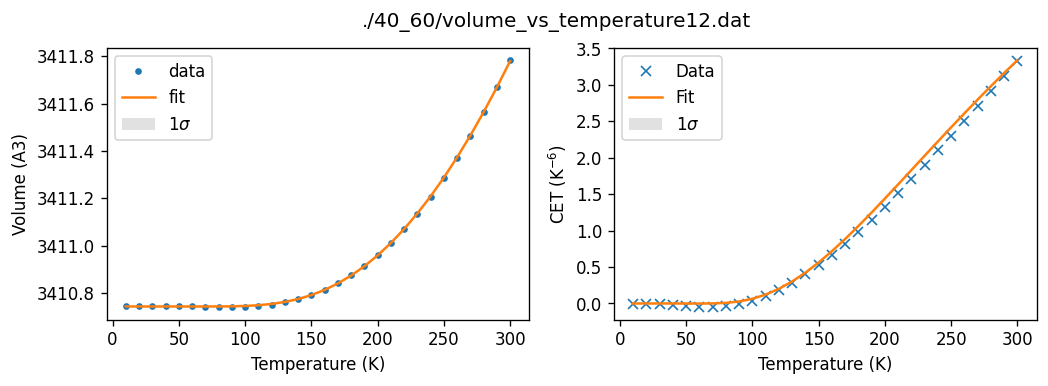

##################### ./40_60/volume_vs_temperature13.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32430
    # data points      = 30
    # variables        = 5
    chi-square         = 8.3031e-04
    reduced chi-square = 3.3213e-05
    Akaike info crit   = -304.847169
    Bayesian info crit = -297.841182
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3423.71338 +/- 0.00132624 (0.00%) (init = 400)
    a1:  709.708159 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -227.843459 +/-        nan (nan%) (init = 0)
    a4:  1.86442699 +/-        nan (nan%) (init = 0)
    a5:  0.03937926 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.002977349454340583
---------- DE bounds ----------
a0 :         0	     3423.71	    8000
a1 :         0	     709.708	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -227.843	    3000
a4 :        -5	     1.86443	       5
a5 :     1e-05	   0.0393793	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.4226569435772114 < 1e-05 at iteration 4 and prob(a3=-0.04375191491799342) = 0.00029332750813174894 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.019445295519108185) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.7447024081613951 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=5) = 0.995493352898622 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00595  -0.00595  -0.005953423.71802  +0.00595  +0.00595  +0.00595
 a1: -86.53670 -65.88321 -38.01256 495.90906 +45.00614+103.07501+188.43316
 a3:      -inf      -inf      -inf  -0.02431      +inf      +inf      +inf
 a4:      -inf      -inf  -1.03533  -3.85201  +1.63181  +4.44675      +inf
 a5:  -0.00421  -0.00208  -0.00105   0.03375  +0.00118  +0.00257  +0.00438
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2317
    # data points      = 30
    # variables        = 5
    chi-square         = 4.2203e-04
    reduced chi-square = 1.6881e-05
    Akaike info crit   = -325.148613
    Bayesian info crit = -318.142626
[[Variables]]
    a0:  3423.71802 +/- 0.00148792 (0.00%) (init = 3423.713)
    a1:  495.909060 +/- 40.6203206 (8.19%) (init = 709.7082)
    a2:  0 (fixed)
    a3: -0.02430662 +/- 144.351613 (593877.79%) (init = -227.8435)
    a4: -3.85200740 +/- 1.26739459 (32.90%

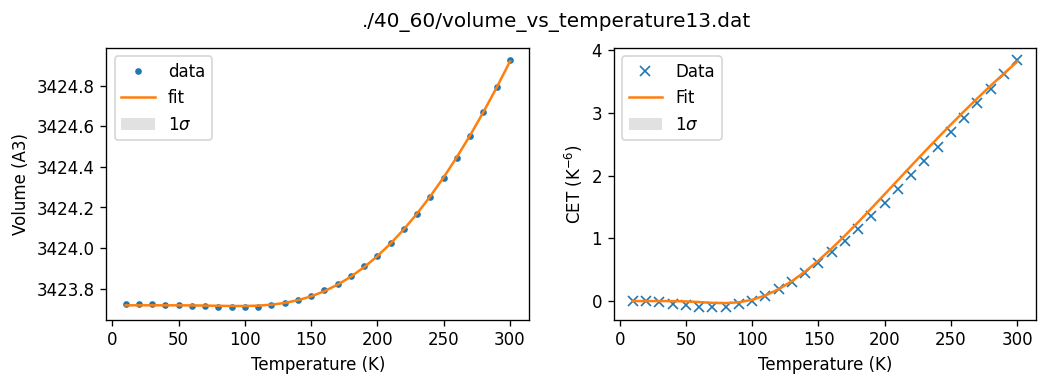

##################### ./40_60/volume_vs_temperature14.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35322
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00183743
    reduced chi-square = 7.3497e-05
    Akaike info crit   = -281.017550
    Bayesian info crit = -274.011563
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3465.63400 +/-        nan (nan%) (init = 400)
    a1:  515.577525 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -872.984615 +/-        nan (nan%) (init = 0)
    a4:  0.09401465 +/-        nan (nan%) (init = 0)
    a5:  0.02329809 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3465.6322206546633) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1

Cost: -0.0050904216336675745
---------- DE bounds ----------
a0 :         0	     3465.63	    8000
a1 :         0	     515.578	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -872.985	    3000
a4 :        -5	   0.0940146	       5
a5 :     1e-05	   0.0232981	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-698.9535650036381) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a4=0.07628172271940059) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=3.9285087200491304) = 0.9740560613483338 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:      -inf      -inf      -inf3465.63407      +inf      +inf      +inf
 a1:      -inf      -inf      -inf 515.54367 +14.82286 +39.98356 +77.56188
 a3:-832.55862-456.81775-110.44431-873.69196      +inf      +inf      +inf
 a4:      -inf      -inf      -inf   0.09535  +0.69291  +3.00620      +inf
 a5:  -0.00803  -0.00380  -0.00120   0.02330      +inf      +inf      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 115
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00183756
    reduced chi-square = 7.3502e-05
    Akaike info crit   = -281.015423
    Bayesian info crit = -274.009436
##  Warning: uncertainties could not be estimated:
    a0:  at initial value
[[Variables]]
    a0:  3465.63407 +/- 0.00185060 (0.00%) (init = 3465.634)
    a1:  515.543672 +/-        nan (nan%) (init = 515.5775)
    a2:  0 (fixed)
    a3: -873.691956 +/-        nan

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a5=0.02795832665844854) = 0.0 < max(sigmas).
  warn(errmsg)


!!!!!!!!!!!!!! Negative variances. Running Nelder-Mead.


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0013881258121131363 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.002017449559692702 < 1e-05 at iteration 151 and prob(a4=-4.983160451959419) = 0.07994761977130478 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01123  -0.01123  -0.011233465.63595  +0.00562  +0.00562  +0.00562
 a1:  -5.09863  -3.35414  -1.79928 419.80200  +1.11546  +8.46373  +4.49827
 a3: -26.91857  -4.89765  -2.01969 -44.27509 +23.99941 +39.84628  +9.48231
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00103  -0.00008  -0.00009   0.02726  +0.00065  +0.00080  +0.00109
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1655
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00133041
    reduced chi-square = 5.3216e-05
    Akaike info crit   = -290.703935
    Bayesian info crit = -283.697948
[[Variables]]
    a0:  3465.63595 +/- 0.00280821 (0.00%) (init = 3465.634)
    a1:  419.802002 +/- 17.7209068 (4.22%) (init = 515.5437)
    a2:  0 (fixed)
    a3: -44.2750923 +/- 39.8732664 (90.06%) (init = -873.692)
    a4: -5.00000000 +/- 1.1152e-04 (0.00%) (ini

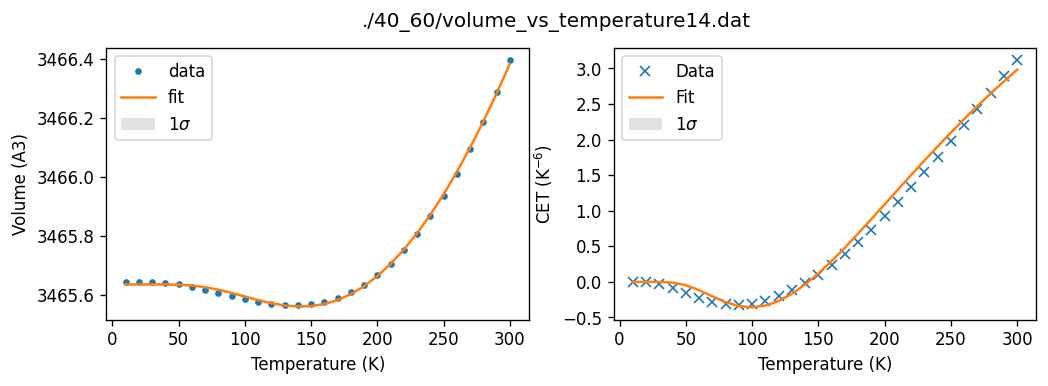

##################### ./40_60/volume_vs_temperature15.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34176
    # data points      = 30
    # variables        = 5
    chi-square         = 9.0122e-04
    reduced chi-square = 3.6049e-05
    Akaike info crit   = -302.388859
    Bayesian info crit = -295.382872
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3403.37548 +/- 0.00151843 (0.00%) (init = 400)
    a1:  712.633499 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  1584.05168 +/-        nan (nan%) (init = 0)
    a4: -2.43798995 +/-        nan (nan%) (init = 0)
    a5:  0.03954843 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.002377195147346356
---------- DE bounds ----------
a0 :         0	     3403.38	    8000
a1 :         0	     712.633	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     1584.05	    3000
a4 :        -5	    -2.43799	       5
a5 :     1e-05	   0.0395484	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00092  -0.00092  -0.000923403.37186  +0.00092  +0.00092  +0.00092
 a1: -21.58753 -13.18574  -6.14794 544.68977  +9.79305 +16.40000 +24.05585
 a3: -70.22686 -44.21369 -21.11490 636.79163 +36.62932 +63.05498 +95.22496
 a4:      -inf      -inf      -inf  -4.99642  +0.01399  +0.05401  +0.12317
 a5:  -0.00116  -0.00070  -0.00032   0.03788  +0.00055  +0.00091  +0.00133
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1235
    # data points      = 30
    # variables        = 5
    chi-square         = 9.3796e-06
    reduced chi-square = 3.7518e-07
    Akaike info crit   = -439.345277
    Bayesian info crit = -432.339290
[[Variables]]
    a0:  3403.37186 +/- 2.2928e-04 (0.00%) (init = 3403.375)
    a1:  544.689766 +/- 6.88916326 (1.26%) (init = 712.6335)
    a2:  0 (fixed)
    a3:  636.791635 +/- 24.7124536 (3.88%) (init = 1584.052)
    a4: -4.99641599 +/- 0.01307624 (0.26%) (init

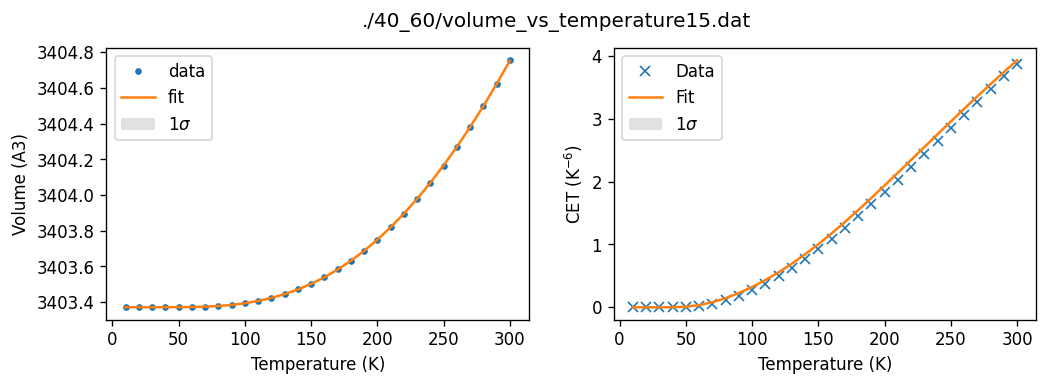

##################### ./40_60/volume_vs_temperature16.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 38178
    # data points      = 30
    # variables        = 5
    chi-square         = 8.7576e-04
    reduced chi-square = 3.5031e-05
    Akaike info crit   = -303.248358
    Bayesian info crit = -296.242371
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3484.76207 +/- 0.00170352 (0.00%) (init = 400)
    a1:  821.322526 +/- 4.31422844 (0.53%) (init = 100)
    a2:  0 (fixed)
    a3:  2946.18721 +/-        nan (nan%) (init = 0)
    a4: -3.85468330 +/- 1.13451800 (29.43%) (init = 0)
    a5:  0.05491318 +/- 0.00229191 (4.17%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a4) =  1.603
    C(a1, a5) = -1.338
    C(a4, a5) = -0.939
    C(a0, a1) =  0.627
    C(a0, a4) =  0.239


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.0012168455291430291
---------- DE bounds ----------
a0 :         0	     3484.76	    8000
a1 :         0	     821.323	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2946.19	    3000
a4 :        -5	    -3.85468	       5
a5 :     1e-05	   0.0549132	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00163  -0.00163  -0.001633484.75781  +0.00163  +0.00163  +0.00163
 a1: -56.05174 -36.67778 -19.00837 624.38592 +15.37379 +32.84503 +51.95094
 a3:-245.87233-173.51527 -96.29746 761.82756 +89.25156+204.04333+347.73373
 a4:      -inf      -inf      -inf  -4.99914  +0.04506  +0.18512  +0.44200
 a5:  -0.00394  -0.00257  -0.00132   0.04722  +0.00108  +0.00228  +0.00355
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1114
    # data points      = 30
    # variables        = 5
    chi-square         = 7.5547e-05
    reduced chi-square = 3.0219e-06
    Akaike info crit   = -376.758587
    Bayesian info crit = -369.752600
[[Variables]]
    a0:  3484.75781 +/- 5.4341e-04 (0.00%) (init = 3484.762)
    a1:  624.385917 +/- 17.2130889 (2.76%) (init = 821.3225)
    a2:  0 (fixed)
    a3:  761.827558 +/- 94.0198594 (12.34%) (init = 2946.187)
    a4: -4.99914246 +/- 0.01159593 (0.23%) (ini

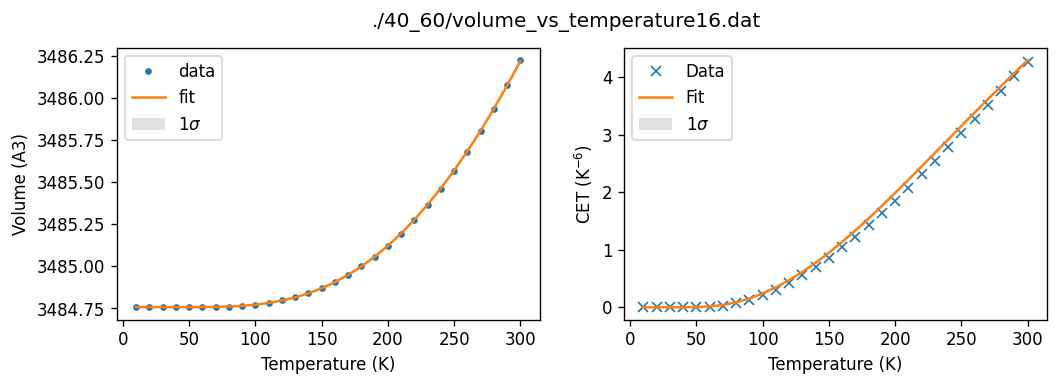

##################### ./40_60/volume_vs_temperature17.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34644
    # data points      = 30
    # variables        = 5
    chi-square         = 5.5855e-04
    reduced chi-square = 2.2342e-05
    Akaike info crit   = -316.741134
    Bayesian info crit = -309.735147
[[Variables]]
    a0:  3483.18507 +/- 0.00149679 (0.00%) (init = 400)
    a1:  577.072880 +/- 26.4190917 (4.58%) (init = 100)
    a2:  0 (fixed)
    a3:  677.859286 +/- 127.370676 (18.79%) (init = 0)
    a4: -4.85263399 +/- 0.22897699 (4.72%) (init = 0)
    a5:  0.04638608 +/- 0.00186935 (4.03%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.975
    C(a1, a3) =  0.971
    C(a1, a5) =  0.963
    C(a0, a5) =  0.296
    C(a0, a1) =  0.295
    C(a1, a4) =  0.203
    C(a0, a3) =  0.191
    C(a0, a4) =  0.178
Cost: 0.0038663652840114082
---------- DE bounds ----------
a0 :       

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.994310518785465) = 0.2008762419825413 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00572  -0.00572  -0.005723483.18497  +0.00429  +0.00429  +0.00429
 a1:  -1.22654  -0.81340  -0.44604 574.68496 +21.46427 +54.15871 +84.97773
 a3: -10.06589-114.73024-110.63412 683.51320  +4.16606  +7.67064 +11.63004
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00578  -0.00376  -0.00040   0.04650  +0.00158  +0.00173  +0.00184
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 509
    # data points      = 30
    # variables        = 5
    chi-square         = 5.2245e-04
    reduced chi-square = 2.0898e-05
    Akaike info crit   = -318.745547
    Bayesian info crit = -311.739560
[[Variables]]
    a0:  3483.18497 +/- 0.00143098 (0.00%) (init = 3483.185)
    a1:  574.684955 +/- 25.6071943 (4.46%) (init = 577.0729)
    a2:  0 (fixed)
    a3:  683.513205 +/- 123.695904 (18.10%) (init = 677.8593)
    a4: -5.00000000 +/- 2.8306e-05 (0.00%) (init

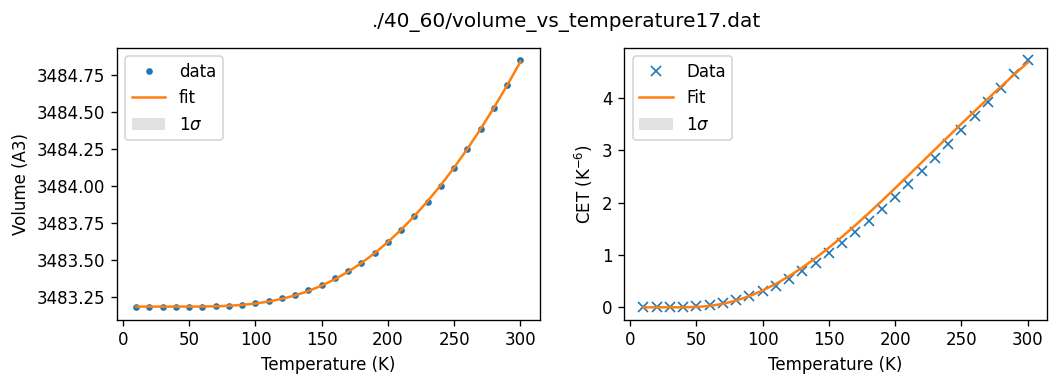

##################### ./40_60/volume_vs_temperature18.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33420
    # data points      = 30
    # variables        = 5
    chi-square         = 3.7633e-04
    reduced chi-square = 1.5053e-05
    Akaike info crit   = -328.587436
    Bayesian info crit = -321.581449
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3427.45923 +/- 0.00108867 (0.00%) (init = 400)
    a1:  803.784803 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2318.87232 +/-        nan (nan%) (init = 0)
    a4: -2.40602716 +/- 1.19143358 (49.52%) (init = 0)
    a5:  0.04524892 +/- 0.00212335 (4.69%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.992
    C(a0, a5) = -0.646
    C(a0, a4) =  0.636


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.0014756925024812517
---------- DE bounds ----------
a0 :         0	     3427.46	    8000
a1 :         0	     803.785	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2318.87	    3000
a4 :        -5	    -2.40603	       5
a5 :     1e-05	   0.0452489	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0008352631105150695 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.986855291744194) = 0.16564884572605615 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00195  -0.00195  -0.001953427.45645  +0.00097  +0.00097  +0.00097
 a1: -10.62120  -0.36852  -0.21708 703.10560  +0.54686 +12.82973 +12.88593
 a3:-231.80459-152.11882  -9.922701340.44383  +2.67803 +54.39774+117.05751
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00064  -0.00063  -0.00029   0.04708  +0.00004  +0.00007  +0.00061
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1934
    # data points      = 30
    # variables        = 5
    chi-square         = 5.1623e-05
    reduced chi-square = 2.0649e-06
    Akaike info crit   = -388.182092
    Bayesian info crit = -381.176105
[[Variables]]
    a0:  3427.45645 +/- 4.8672e-04 (0.00%) (init = 3427.459)
    a1:  703.105598 +/- 12.8859316 (1.83%) (init = 803.7848)
    a2:  0 (fixed)
    a3:  1340.44383 +/- 117.093951 (8.74%) (init = 2318.872)
    a4: -5.00000000 +/- 6.5397e-05 (0.00%) (init

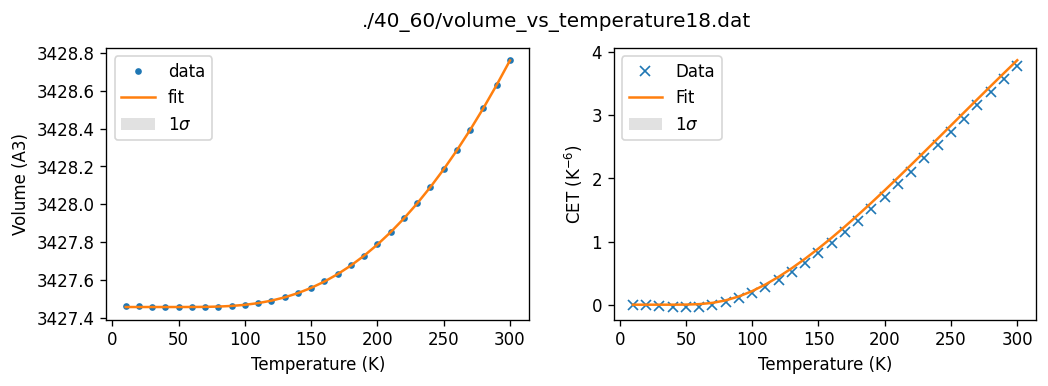

##################### ./40_60/volume_vs_temperature19.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33072
    # data points      = 30
    # variables        = 5
    chi-square         = 5.7759e-04
    reduced chi-square = 2.3104e-05
    Akaike info crit   = -315.735278
    Bayesian info crit = -308.729291
[[Variables]]
    a0:  3440.90631 +/- 0.00145527 (0.00%) (init = 400)
    a1:  857.412784 +/- 58.8904363 (6.87%) (init = 100)
    a2:  0 (fixed)
    a3:  2229.98212 +/- 1953.87301 (87.62%) (init = 0)
    a4:  2.97738593 +/- 6.09798263 (204.81%) (init = 0)
    a5:  0.04744360 +/- 0.01308366 (27.58%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.996
    C(a1, a3) =  0.964
    C(a3, a5) =  0.917
    C(a3, a4) = -0.891
    C(a1, a5) =  0.783
    C(a1, a4) = -0.740
    C(a0, a1) =  0.192
    C(a0, a4) =  0.134
Cost: -0.0019083696101915848
---------- DE bounds ----------
a0 :   

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.22723670139276123 < 1e-05 at iteration 3 and prob(a3=2999.8389564435697) = 0.00967945764093267 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.0004753952386728074 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00286  -0.00286  -0.002863440.90646  +0.00571  +0.00571  +0.00571
 a1:  -6.97696 -13.95358  -0.80572 879.28747  +4.64403  +6.67810  +1.77115
 a3:      -inf      -inf      -inf3000.00000      +inf      +inf      +inf
 a4:  -0.13786  -0.08491  -0.03920   1.01693  +0.04692  +0.09266  +0.14429
 a5:  -0.00559  -0.00451  -0.00451   0.05163  +0.00017  +0.01054  +0.01121
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1442
    # data points      = 30
    # variables        = 5
    chi-square         = 5.6181e-04
    reduced chi-square = 2.2472e-05
    Akaike info crit   = -316.566436
    Bayesian info crit = -309.560449
[[Variables]]
    a0:  3440.90646 +/- 0.00142803 (0.00%) (init = 3440.906)
    a1:  879.287465 +/- 13.9946632 (1.59%) (init = 857.4128)
    a2:  0 (fixed)
    a3:  3000.00000 +/- 0.05368099 (0.00%) (init = 2229.982)
    a4:  1.01693147 +/- 2.83705584 (278.98%) (in

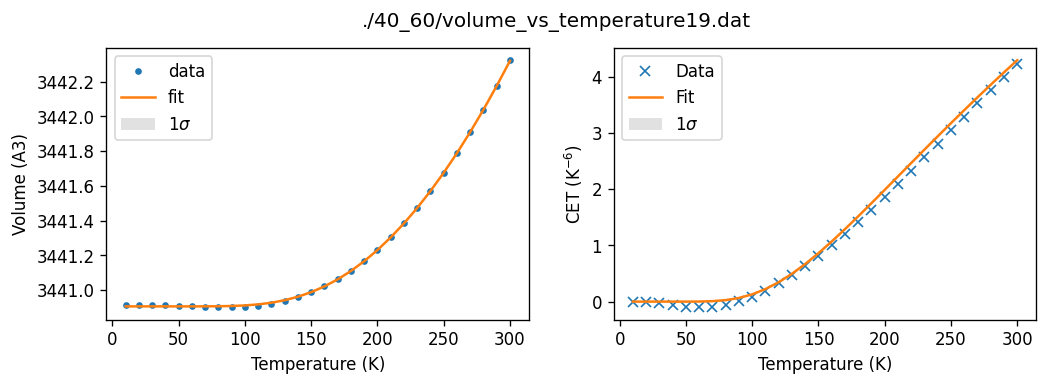

##################### ./40_60/volume_vs_temperature20.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32724
    # data points      = 30
    # variables        = 5
    chi-square         = 1.3605e-04
    reduced chi-square = 5.4419e-06
    Akaike info crit   = -359.111189
    Bayesian info crit = -352.105202
[[Variables]]
    a0:  3488.53891 +/- 7.0161e-04 (0.00%) (init = 400)
    a1:  871.019749 +/- 105.558186 (12.12%) (init = 100)
    a2:  0 (fixed)
    a3:  1701.00899 +/- 2502.45487 (147.12%) (init = 0)
    a4: -0.45683653 +/- 6.12318275 (1340.34%) (init = 0)
    a5:  0.05535791 +/- 0.01760674 (31.81%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.994
    C(a4, a5) = -0.993
    C(a3, a5) =  0.990
    C(a1, a5) =  0.969
    C(a3, a4) = -0.967
    C(a1, a4) = -0.933
    C(a0, a1) =  0.143
Cost: 0.0008320905358232267
---------- DE bounds ----------
a0 :         0	     3488.54	

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.49167219519323196 < 1e-05 at iteration 2 and prob(a3=2999.918871632405) = 0.009093105389295007 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.0009268925620082532 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=5) = 0.9757209639158875 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00128  -0.00128  -0.001283488.53939  +0.00257  +0.00257  +0.00257
 a1:  -5.44868  -8.98449  -8.28480 926.96665  +0.21228  +7.48153  +0.74681
 a3:      -inf      -inf      -inf3000.00000      +inf      +inf      +inf
 a4:  -1.28059  -1.63979  -1.31986  -1.83289  +2.20491  +5.94347      +inf
 a5:  -0.00026  -0.00016  -0.00025   0.06031  +0.00016  +0.00528  +0.00628
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1963
    # data points      = 30
    # variables        = 5
    chi-square         = 1.1590e-04
    reduced chi-square = 4.6358e-06
    Akaike info crit   = -363.920626
    Bayesian info crit = -356.914639
[[Variables]]
    a0:  3488.53939 +/- 6.4146e-04 (0.00%) (init = 3488.539)
    a1:  926.966653 +/- 8.98448962 (0.97%) (init = 871.0197)
    a2:  0 (fixed)
    a3:  3000.00000 +/- 0.04056385 (0.00%) (init = 1701.009)
    a4: -1.83289368 +/- 1.68049149 (91.69%) (ini

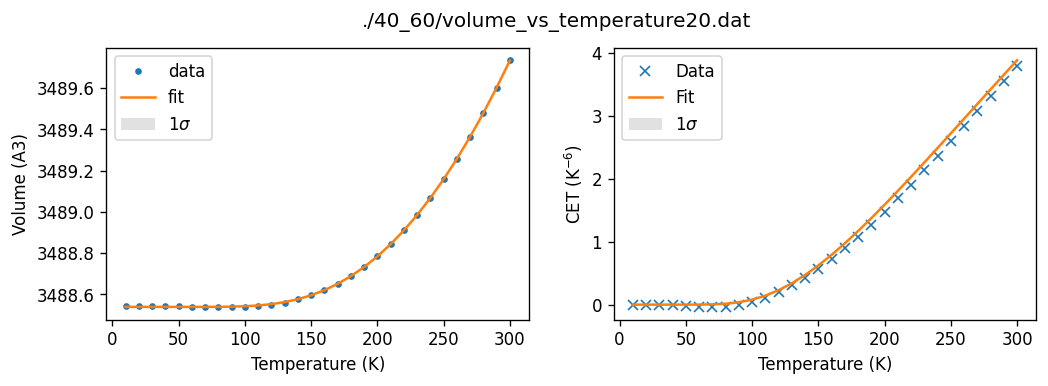

##################### ./40_60/volume_vs_temperature21.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34980
    # data points      = 30
    # variables        = 5
    chi-square         = 5.9623e-04
    reduced chi-square = 2.3849e-05
    Akaike info crit   = -314.782658
    Bayesian info crit = -307.776671
[[Variables]]
    a0:  3419.96359 +/- 0.00208409 (0.00%) (init = 400)
    a1:  557.756525 +/- 89.3010700 (16.01%) (init = 100)
    a2:  0 (fixed)
    a3: -623.353905 +/- 746.888332 (119.82%) (init = 0)
    a4:  0.37370685 +/- 5.44337264 (1456.59%) (init = 0)
    a5:  0.02078463 +/- 0.00548856 (26.41%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -1.000
    C(a1, a3) = -0.991
    C(a1, a4) =  0.988
    C(a4, a5) = -0.985
    C(a3, a5) =  0.981
    C(a1, a5) = -0.948
    C(a0, a1) = -0.601
    C(a0, a3) =  0.539
    C(a0, a4) = -0.538
    C(a0, a5) =  0.464
Cost: -0.0051619236

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.01448312520624313) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.009655416804162088) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.9665025318853685 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00625  -0.00625  -0.006253419.96468  +0.00625  +0.00625  +0.00625
 a1: -91.83917 -62.25279 -32.02995 451.99841 +35.39757 +76.41817+126.55224
 a3:      -inf      -inf      -inf  -0.01207      +inf      +inf      +inf
 a4:      -inf  -1.06248  -0.61482  -3.88669  +0.94519  +2.49584  +5.21478
 a5:  -0.00321  -0.00172  -0.00082   0.02357  +0.00090  +0.00193  +0.00320
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 892
    # data points      = 30
    # variables        = 5
    chi-square         = 4.4150e-04
    reduced chi-square = 1.7660e-05
    Akaike info crit   = -323.796220
    Bayesian info crit = -316.790233
[[Variables]]
    a0:  3419.96468 +/- 0.00156313 (0.00%) (init = 3419.964)
    a1:  451.998409 +/- 33.2165157 (7.35%) (init = 557.7565)
    a2:  0 (fixed)
    a3: -0.01206927 +/- 120.860623 (1001391.24%) (init = -623.3539)
    a4: -3.88668843 +/- 0.74401334 (19.14%

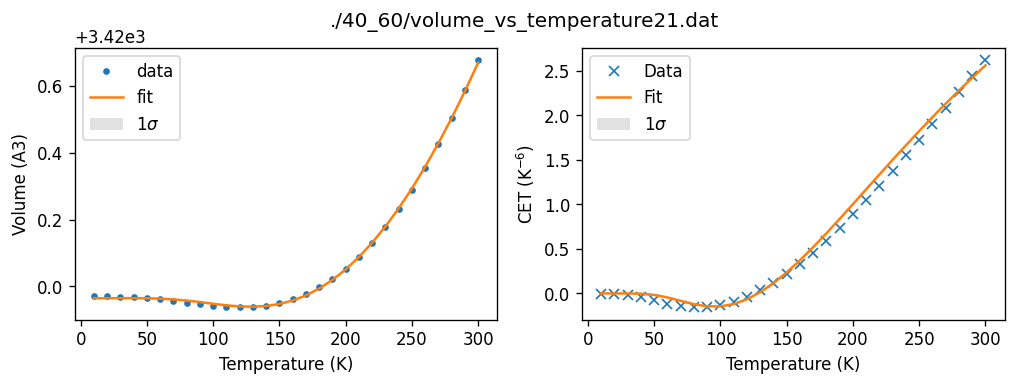

##################### ./40_60/volume_vs_temperature22.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33798
    # data points      = 30
    # variables        = 5
    chi-square         = 7.3287e-04
    reduced chi-square = 2.9315e-05
    Akaike info crit   = -308.592116
    Bayesian info crit = -301.586129
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3455.71019 +/- 0.00154134 (0.00%) (init = 400)
    a1:  595.123730 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -704.566388 +/-        nan (nan%) (init = 0)
    a4:  1.12707944 +/-        nan (nan%) (init = 0)
    a5:  0.02956054 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.0041659918661025586
---------- DE bounds ----------
a0 :         0	     3455.71	    8000
a1 :         0	     595.124	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -704.566	    3000
a4 :        -5	     1.12708	       5
a5 :     1e-05	   0.0295605	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.06322566221350233 < 1e-05 at iteration 2 and prob(a1=559.1008237564259) = 0.9128896298300004 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.40370079935023895 < 1e-05 at iteration 2 and prob(a3=-0.028644483506377584) = 0.0001461673809877093 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.7659983158411671 < 1e-05 at iteration 2 and prob(a3=-0.012276207217018963) = 8.336680236698066e-05 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.3525353271000935 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00700  -0.00700  -0.007003455.71128  +0.00700  +0.00700  +0.00700
 a1: -70.76154 -50.16569 -30.75227 483.36459 +41.32951      +inf      +inf
 a3:      -inf      -inf      -inf  -0.02046      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.51844  +1.48784  +4.00652  +8.69648
 a5:  -0.00348  -0.00226  -0.00114   0.03261  +0.00126  +0.00273  +0.00460
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1468
    # data points      = 30
    # variables        = 5
    chi-square         = 5.7596e-04
    reduced chi-square = 2.3038e-05
    Akaike info crit   = -315.820181
    Bayesian info crit = -308.814194
[[Variables]]
    a0:  3455.71128 +/- 0.00175076 (0.00%) (init = 3455.71)
    a1:  483.364589 +/- 37.8681171 (7.83%) (init = 595.1237)
    a2:  0 (fixed)
    a3: -0.02046035 +/- 158.312958 (773755.06%) (init = -704.5664)
    a4: -4.51844423 +/- 1.14824768 (25.41%)

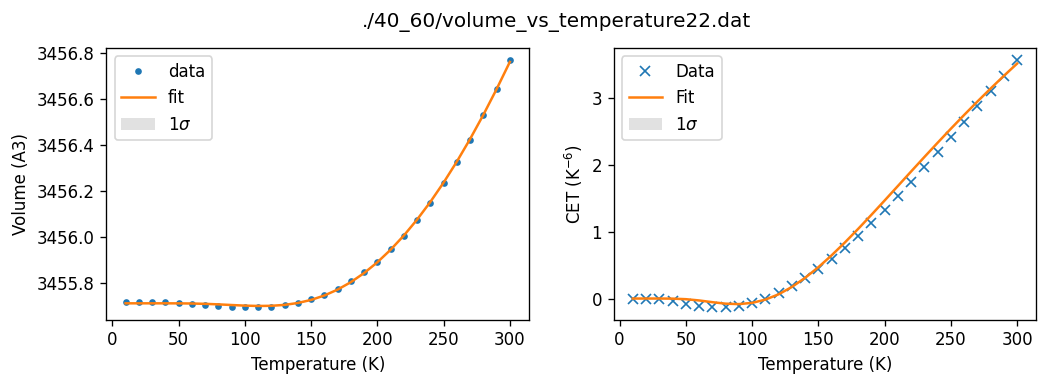

##################### ./40_60/volume_vs_temperature23.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35352
    # data points      = 30
    # variables        = 5
    chi-square         = 8.8298e-04
    reduced chi-square = 3.5319e-05
    Akaike info crit   = -303.002012
    Bayesian info crit = -295.996025
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3421.12735 +/- 0.00162086 (0.00%) (init = 400)
    a1:  562.630079 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  288.013131 +/- 63.3640842 (22.00%) (init = 0)
    a4: -1.90891485 +/-        nan (nan%) (init = 0)
    a5:  0.03643861 +/- 0.00139425 (3.83%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a3) = -1.427
    C(a3, a5) =  0.989
    C(a0, a5) = -0.723


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.003769203926822229
---------- DE bounds ----------
a0 :         0	     3421.13	    8000
a1 :         0	      562.63	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     288.013	    3000
a4 :        -5	    -1.90891	       5
a5 :     1e-05	   0.0364386	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.9672013689822885) = 0.6196535116846383 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00306  -0.00306  -0.003063421.12504  +0.00153  +0.00153  +0.00153
 a1: -17.18396  -0.49767  -0.30031 562.51394  +0.08437 +15.84908  +0.52275
 a3:-146.73170-134.95582  -0.74396 648.85716  +2.44853  +4.18416  +6.12989
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00119  -0.00110  -0.00054   0.04291  +0.00004  +0.00053  +0.00009
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 995
    # data points      = 30
    # variables        = 5
    chi-square         = 1.3978e-04
    reduced chi-square = 5.5914e-06
    Akaike info crit   = -358.298312
    Bayesian info crit = -351.292325
[[Variables]]
    a0:  3421.12504 +/- 7.6555e-04 (0.00%) (init = 3421.127)
    a1:  562.513936 +/- 18.2335836 (3.24%) (init = 562.6301)
    a2:  0 (fixed)
    a3:  648.857164 +/- 76.8325767 (11.84%) (init = 288.0131)
    a4: -4.99999984 +/- 1.6318e-04 (0.00%) (init

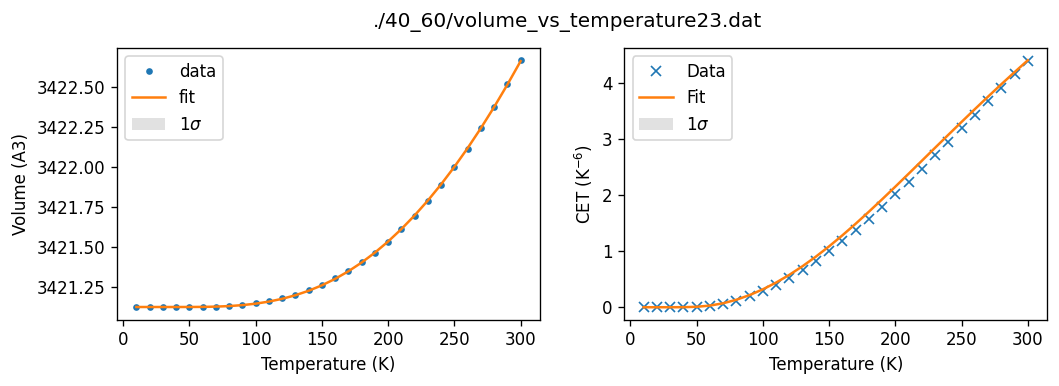

##################### ./40_60/volume_vs_temperature24.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 29460
    # data points      = 30
    # variables        = 5
    chi-square         = 0.01923329
    reduced chi-square = 7.6933e-04
    Akaike info crit   = -210.569306
    Bayesian info crit = -203.563319
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3443.96384 +/- 0.00795365 (0.00%) (init = 400)
    a1:  517.879014 +/- 26.6266929 (5.14%) (init = 100)
    a2:  0 (fixed)
    a3:  341.230290 +/- 302.944374 (88.78%) (init = 0)
    a4:  2.84211710 +/-        nan (nan%) (init = 0)
    a5:  0.02853408 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  1.511
    C(a0, a1) = -0.178


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.005381569651490281
---------- DE bounds ----------
a0 :         0	     3443.96	    8000
a1 :         0	     517.879	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	      341.23	    3000
a4 :        -5	     2.84212	       5
a5 :     1e-05	   0.0285341	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.996805474918107) = 0.2179836618411036 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01688  -0.01688  -0.016883443.93602  +0.00844  +0.00844  +0.00844
 a1: -23.18063 -17.99368 -13.34654 335.04190  +0.30783  +0.78938 +21.84003
 a3: -22.46299  -4.08513  -1.61768 446.82049  +2.97673  +5.44032  +8.23950
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00132  -0.00091  -0.00086   0.03491  +0.00059  +0.00009  +0.00055
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 879
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00213070
    reduced chi-square = 8.5228e-05
    Akaike info crit   = -276.575122
    Bayesian info crit = -269.569135
[[Variables]]
    a0:  3443.93602 +/- 0.00422096 (0.00%) (init = 3443.964)
    a1:  335.041900 +/- 23.1806263 (6.92%) (init = 517.879)
    a2:  0 (fixed)
    a3:  446.820494 +/- 43.2293317 (9.67%) (init = 341.2303)
    a4: -5.00000000 +/- 1.5893e-05 (0.00%) (init =

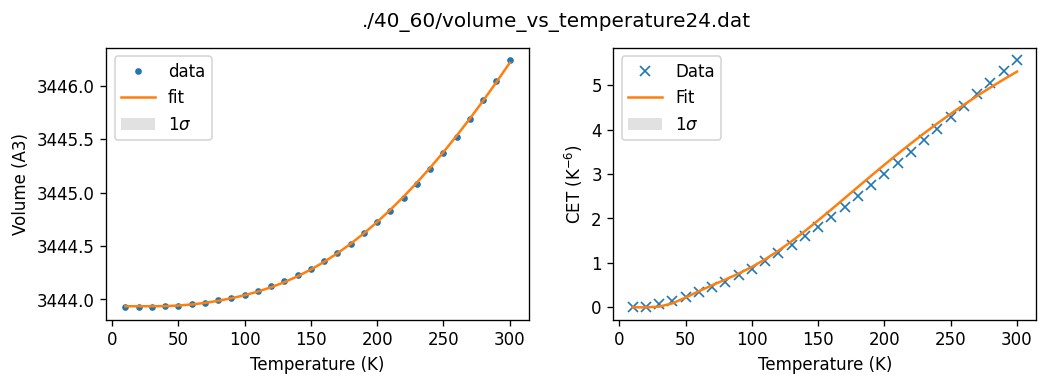

##################### ./40_60/volume_vs_temperature25.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 30354
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00527862
    reduced chi-square = 2.1114e-04
    Akaike info crit   = -249.358636
    Bayesian info crit = -242.352649
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3423.11623 +/- 0.00438266 (0.00%) (init = 400)
    a1:  612.251385 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  1506.32458 +/-        nan (nan%) (init = 0)
    a4: -4.45953291 +/- 0.13007185 (2.92%) (init = 0)
    a5:  0.05387686 +/- 7.5177e-04 (1.40%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a5) =  0.503
    C(a4, a5) = -0.275


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.04866134708390746
---------- DE bounds ----------
a0 :         0	     3423.12	    8000
a1 :         0	     612.251	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     1506.32	    3000
a4 :        -5	    -4.45953	       5
a5 :     1e-05	   0.0538769	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00858  -0.00858  -0.008583423.11782  +0.00214  +0.00214  +0.00214
 a1: -75.18172 -49.13070 -24.90860 491.77047 +23.37795 +48.92253 +77.35085
 a3:-249.35805-181.73721-101.98084 645.42282+116.94248+272.22600+484.12243
 a4:      -inf      -inf      -inf  -4.99870  +0.07578  +0.31748  +0.77626
 a5:  -0.00549  -0.00360  -0.00182   0.04637  +0.00173  +0.00358  +0.00557
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 611
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00102602
    reduced chi-square = 4.1041e-05
    Akaike info crit   = -298.498040
    Bayesian info crit = -291.492053
[[Variables]]
    a0:  3423.11782 +/- 0.00214498 (0.00%) (init = 3423.116)
    a1:  491.770465 +/- 23.7520916 (4.83%) (init = 612.2514)
    a2:  0 (fixed)
    a3:  645.422820 +/- 107.875911 (16.71%) (init = 1506.325)
    a4: -4.99869957 +/- 0.01944562 (0.39%) (init

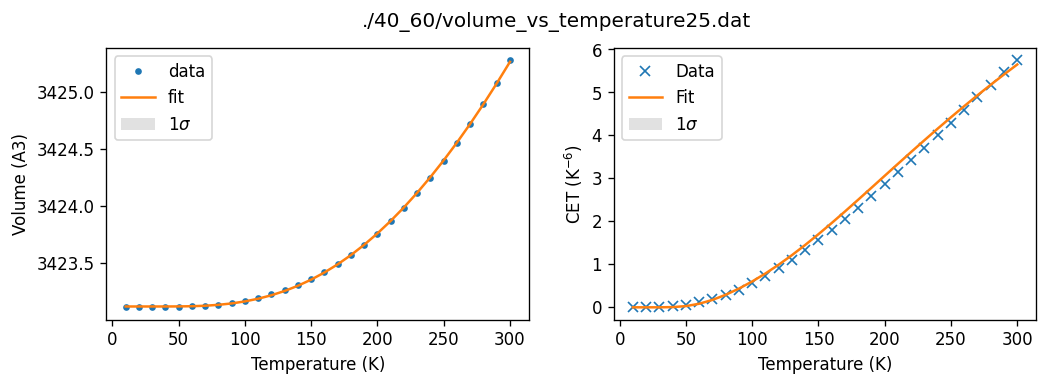

##################### ./40_60/volume_vs_temperature26.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32466
    # data points      = 30
    # variables        = 5
    chi-square         = 4.8365e-04
    reduced chi-square = 1.9346e-05
    Akaike info crit   = -321.060210
    Bayesian info crit = -314.054223
[[Variables]]
    a0:  3446.72153 +/- 0.00435314 (0.00%) (init = 400)
    a1:  694.419257 +/- 131.789437 (18.98%) (init = 100)
    a2:  0 (fixed)
    a3:  443.259530 +/- 263.249476 (59.39%) (init = 0)
    a4:  0.90664445 +/- 8.78711935 (969.19%) (init = 0)
    a5:  0.02864105 +/- 0.01217836 (42.52%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.994
    C(a1, a4) =  0.976
    C(a0, a4) =  0.957
    C(a1, a5) = -0.948
    C(a0, a5) = -0.944
    C(a0, a1) =  0.943
    C(a3, a5) =  0.715
    C(a3, a4) = -0.643
    C(a0, a3) = -0.600
    C(a1, a3) = -0.463
Cost: -0.003037787044

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3446.7184254735316) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3446.719046139177) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=638.53359766615) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=658.7154806198064) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=756.7534306095237) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-p

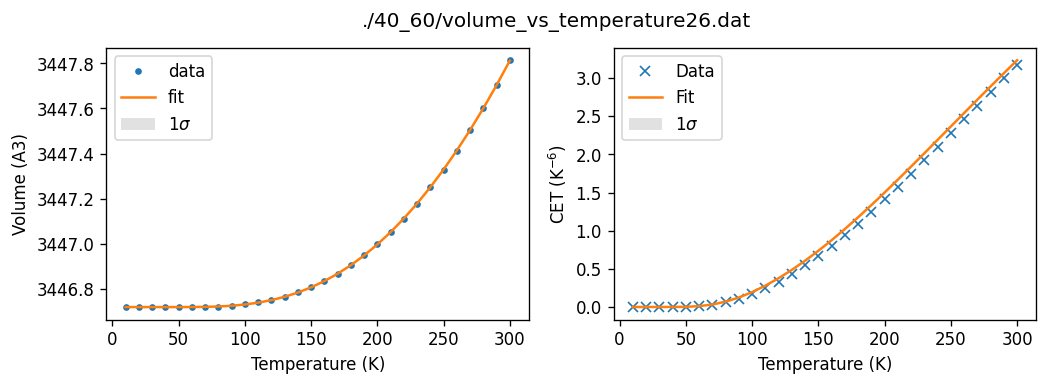

##################### ./40_60/volume_vs_temperature27.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35130
    # data points      = 30
    # variables        = 5
    chi-square         = 7.1689e-04
    reduced chi-square = 2.8676e-05
    Akaike info crit   = -309.253542
    Bayesian info crit = -302.247555
[[Variables]]
    a0:  3467.57999 +/- 0.00158225 (0.00%) (init = 400)
    a1:  853.829415 +/- 60.5192910 (7.09%) (init = 100)
    a2:  0 (fixed)
    a3:  1618.61715 +/- 1214.04715 (75.01%) (init = 0)
    a4:  4.93716187 +/- 0.74715973 (15.13%) (init = 0)
    a5:  0.04005233 +/- 0.00248522 (6.20%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.996
    C(a3, a5) =  0.770
    C(a1, a5) =  0.744
    C(a4, a5) = -0.689
    C(a0, a1) =  0.400
    C(a0, a5) =  0.382
    C(a0, a3) =  0.367
    C(a3, a4) = -0.218
    C(a1, a4) = -0.143
Cost: 0.0008104892094706884
---------- DE bound

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.10719276888906418 < 1e-05 at iteration 4 and prob(a3=2999.4627501654186) = 0.015356677178039247 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.008259174358519318 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00466  -0.00466  -0.004663467.58048  +0.00621  +0.00621  +0.00621
 a1: -49.66772 -49.66772 -39.71263 903.54789  +5.51606  +1.05945  +1.67549
 a3:      -inf      -inf      -inf3000.00000      +inf      +inf      +inf
 a4:  -0.16531  -0.10311  -0.04805   3.08713  +0.05552  +0.11057  +0.17277
 a5:  -0.00060  -0.00344  -0.00019   0.04419  +0.00182  +0.01316  +0.01755
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2032
    # data points      = 30
    # variables        = 5
    chi-square         = 6.7946e-04
    reduced chi-square = 2.7178e-05
    Akaike info crit   = -310.862292
    Bayesian info crit = -303.856306
[[Variables]]
    a0:  3467.58048 +/- 0.00155311 (0.00%) (init = 3467.58)
    a1:  903.547893 +/- 16.5630221 (1.83%) (init = 853.8294)
    a2:  0 (fixed)
    a3:  3000.00000 +/- 0.13431172 (0.00%) (init = 1618.617)
    a4:  3.08712888 +/- 3.49002081 (113.05%) (ini

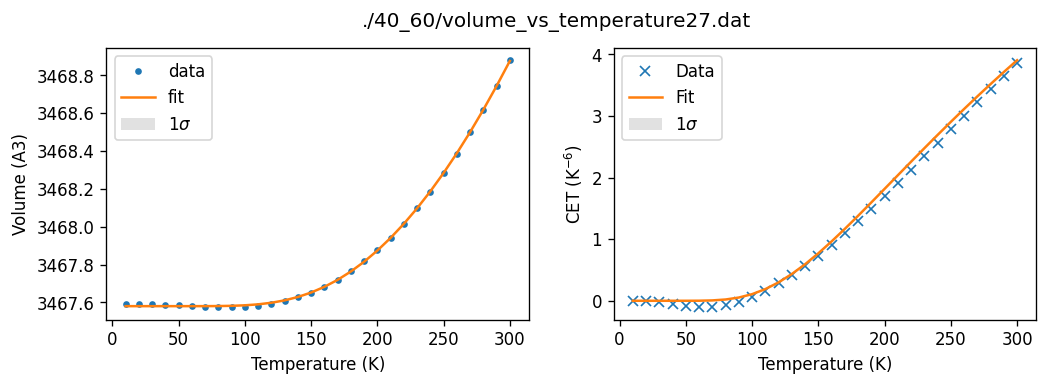

##################### ./40_60/volume_vs_temperature28.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36294
    # data points      = 30
    # variables        = 5
    chi-square         = 1.9230e-05
    reduced chi-square = 7.6921e-07
    Akaike info crit   = -417.806634
    Bayesian info crit = -410.800647
[[Variables]]
    a0:  3431.12766 +/- 2.9727e-04 (0.00%) (init = 400)
    a1:  667.639019 +/- 10.8150381 (1.62%) (init = 100)
    a2:  0 (fixed)
    a3:  823.200087 +/- 81.8395222 (9.94%) (init = 0)
    a4: -4.05970043 +/- 0.28261958 (6.96%) (init = 0)
    a5:  0.04481141 +/- 9.3553e-04 (2.09%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.968
    C(a1, a3) =  0.907
    C(a1, a5) =  0.789
    C(a4, a5) = -0.696
    C(a3, a4) = -0.517
    C(a0, a4) =  0.391
    C(a0, a1) =  0.308
    C(a1, a4) = -0.113
Cost: -0.0036862059751001652
---------- DE bounds ----------
a0 :       

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00082  -0.00082  -0.000823431.12760  +0.00082  +0.00082  +0.00082
 a1: -30.97113 -19.11398 -10.39935 691.15031  +7.73253 +14.91956 +22.99731
 a3:-238.39770-141.91116 -75.706741102.51754 +63.66487+123.98552+195.48157
 a4:      -inf      -inf      -inf  -4.98216  +0.06251  +0.22923  +0.47594
 a5:  -0.00235  -0.00127  -0.00058   0.04812  +0.00051  +0.00092  +0.00138
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 823
    # data points      = 30
    # variables        = 5
    chi-square         = 8.7427e-06
    reduced chi-square = 3.4971e-07
    Akaike info crit   = -441.454534
    Bayesian info crit = -434.448547
[[Variables]]
    a0:  3431.12760 +/- 2.0550e-04 (0.00%) (init = 3431.128)
    a1:  691.150306 +/- 8.01654471 (1.16%) (init = 667.639)
    a2:  0 (fixed)
    a3:  1102.51754 +/- 63.4618150 (5.76%) (init = 823.2001)
    a4: -4.98216140 +/- 0.05137890 (1.03%) (init =

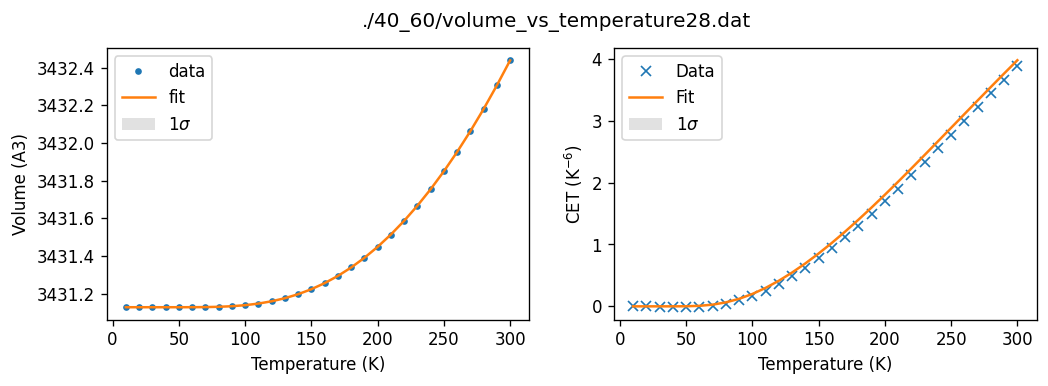

##################### ./40_60/volume_vs_temperature29.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 38598
    # data points      = 30
    # variables        = 5
    chi-square         = 2.2196e-04
    reduced chi-square = 8.8786e-06
    Akaike info crit   = -344.425682
    Bayesian info crit = -337.419695
[[Variables]]
    a0:  3458.91902 +/- 9.2525e-04 (0.00%) (init = 400)
    a1:  808.612260 +/- 31.6881241 (3.92%) (init = 100)
    a2:  0 (fixed)
    a3:  2071.36348 +/- 798.104061 (38.53%) (init = 0)
    a4: -2.34129108 +/- 2.15103930 (91.87%) (init = 0)
    a5:  0.07786865 +/- 0.00613718 (7.88%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.956
    C(a3, a5) =  0.932
    C(a4, a5) = -0.917
    C(a1, a5) =  0.792
    C(a3, a4) = -0.722
    C(a1, a4) = -0.488
    C(a0, a1) =  0.260
    C(a0, a4) =  0.217
    C(a0, a3) =  0.116
Cost: -0.002484128784544737
---------- DE bound

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.8461752208757655 < 1e-05 at iteration 4 and prob(a3=2979.1361242422527) = 0.1528223500004089 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.14769182671178227 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.15198440034822308 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.8441812480605176 < 1e-05 at iteration 2 and prob(a4=-4.942089349674025) = 0.11678690077775254 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00311  -0.00311  -0.003113458.91907  +0.00311  +0.00311  +0.00311
 a1: -65.61151 -49.38485 -14.71159 835.97079  +0.16497  +0.36765  +0.60670
 a3:      -inf      -inf      -inf2999.98847      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.99992      +inf      +inf      +inf
 a5:  -0.00025  -0.00015  -0.00007   0.08534  +0.00049  +0.00101  +0.00159
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1310
    # data points      = 30
    # variables        = 5
    chi-square         = 1.9704e-04
    reduced chi-square = 7.8817e-06
    Akaike info crit   = -347.998529
    Bayesian info crit = -340.992542
[[Variables]]
    a0:  3458.91907 +/- 7.7702e-04 (0.00%) (init = 3458.919)
    a1:  835.970789 +/- 1.28650010 (0.15%) (init = 808.6123)
    a2:  0 (fixed)
    a3:  2999.98847 +/- 5.21308643 (0.17%) (init = 2071.363)
    a4: -4.99992394 +/- 0.02891730 (0.58%) (init

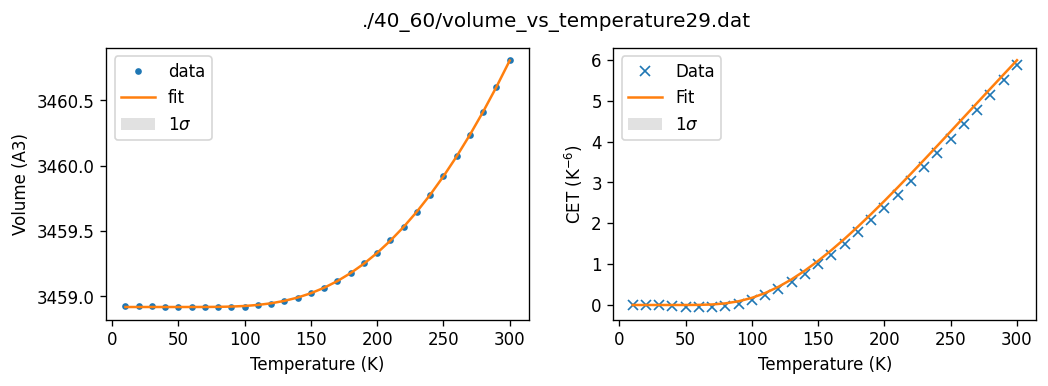

In [7]:
from glob import glob
import numpy as np
from uncertainties import correlated_values
import uncertainties.unumpy as unp
from uncertainties import ufloat

X_fit = []
Y_fit = []
Z_fit = []
X_data = []
Y_data = []
Z_data = []

folder = '40_60'

print('{0:#^100}'.format(' Shrink '))

for i in range(30):
    
    file = f'./{folder}/volume_vs_temperature{i:02d}.dat'
    
    print('{0:#^80}'.format(' '+str(file)+' '))
            
    M = np.genfromtxt(file)
    temperature = M[:,0]
    volume = M[:,1]
    
    cte_data = CET_numerical(temperature, volume)
    
    result0 = fit_volume_vs_temperature(temperature, volume, cte_data)
    result = second_fit(temperature, volume, cte_data, result0)
    
    has_uncertainties = False
    
    t_fit = np.array(temperature)
    
    if not np.any(np.diag(result.covar) < 0):
        has_uncertainties = True        
    else:
        print('!!!!!!!!!!!!!! Negative variances. Running Nelder-Mead.')
        result = second_fit(temperature, volume, cte_data, result)
        if np.any(np.diag(result.covar) >= 0):
            has_uncertainties = True
    
    
    (a0, a1, a2, a3, a4, a5, a6, a7, a8) = [result.params[k].value for k in result.params.keys()]
    
    if has_uncertainties:
        try:
            (a0, a1, a3, a4, a5) = correlated_values([a0, a1, a3, a4, a5], result.covar)
        except Exception as e:
            print("The execption", e.__class__, "occurred when trying to construct correlated variables a0, a1, a4, a4, a5.")
            print("Ignoring correlation and treating variables as independent")
            a0 = ufloat(a0,np.sqrt(np.diag(result.covar)[0]))
            a1 = ufloat(a1,np.sqrt(np.diag(result.covar)[1]))
            a3 = ufloat(a3,np.sqrt(np.diag(result.covar)[2]))
            a4 = ufloat(a4,np.sqrt(np.diag(result.covar)[3]))
            a5 = ufloat(a5,np.sqrt(np.diag(result.covar)[4]))
        
        v_fit = volume_fcn_unc(t_fit, a0, a1, a2, a3, a4, a5, a6, a7, a8)
        v_nominal = np.array([x.nominal_value for x in v_fit])
        v_unc = np.array([x.std_dev for x in v_fit])
        
        cte_fit = CET_fcn_unc(t_fit, a0, a1, a2, a3, a4, a5, a6, a7, a8)
        cte_nominal = np.array([x.nominal_value for x in cte_fit])
        cte_unc = np.array([x.std_dev for x in cte_fit])
        
        plot_unc(temperature, volume, t_fit, v_nominal, v_unc, cte_data, cte_nominal, cte_unc, file)
        
    else:
        v_nominal = volume_fcn(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
        v_unc = np.zeros(len(v_nominal))
        
        cte_nominal = CET_fcn_unc(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
        cte_unc = np.zeros(len(v_nominal))
        
        plot(temperature, volume, t_fit, v_nominal, cte_data, cte_nominal, file)
            
    with open(file.rstrip('dat')+'fit','w') as f:
        f.write('#{T:5}\t{V:10}\t{Vfit:10}\t{Vunc:10}\t{CET:10}\t{CETfit:10}\t{CETunc:10}\n'.format(T='T(K)',V='V(A3)',Vfit='Vfit(A3)',Vunc='Vunc(A3)',CET='CET(1/K)',CETfit='CETfit(1/K)',CETunc='CETunc(1/K)'))
        for i in range(len(temperature)):
            f.write('{T:5.1f}\t{V:10f}\t{Vfit:10f}\t{Vunc:10f}\t{CET: 10e}\t{CETfit: 10e}\t{CETunc: 10e}\n'.format(T=temperature[i],V=volume[i],Vfit=v_nominal[i],Vunc=v_unc[i],CET=cte_data[i],CETfit=cte_nominal[i],CETunc=cte_unc[i]))
    


In [24]:
with open('sp2_40_60.txt','w') as f:
    for i in range(30):
        A = np.genfromtxt(f'./40_60/volume_vs_temperature{i:02d}.fit')
        cet100 = A[9,5]
        cet300 = A[29,5]
        f.write(f'{i:02d}\t{cet100:0.6e}\t{cet300:0.6e}\n')

# 50% - 50%

############################################## Shrink ##############################################
##################### ./50_50/volume_vs_temperature00.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36270
    # data points      = 30
    # variables        = 5
    chi-square         = 2.3077e-04
    reduced chi-square = 9.2309e-06
    Akaike info crit   = -343.258249
    Bayesian info crit = -336.252262
[[Variables]]
    a0:  3547.08921 +/- 9.4891e-04 (0.00%) (init = 400)
    a1:  706.912489 +/- 38.3341961 (5.42%) (init = 100)
    a2:  0 (fixed)
    a3:  151.701779 +/- 222.803135 (146.87%) (init = 0)
    a4:  1.18643697 +/- 1.16278670 (98.01%) (init = 0)
    a5:  0.03335319 +/- 0.00258276 (7.74%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.921
    C(a1, a3) =  0.809
    C(a1, a5) =  0.549
    C(a4, a5) = -0.534
    C(a1, a4) =  0.409
    C(a0, a3) = -0.387
    C(a0, a5) = -0.371
    C(a0, a4) =  0.303
    C(a3, a4) = -0.201
    C(a0, a1) = -0.140
Cost: -0.00327851016027

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3547.0883007951843) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3547.090233935761) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=781.6255755503291) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=182.14150888597177) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a4=0.9494322030949782) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/si

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:      -inf      -inf      -inf3547.08927      +inf      +inf      +inf
 a1:-269.20751-221.27933-144.42352 707.20586      +inf      +inf      +inf
 a3:-479.49007-328.63096-196.08100 151.78459      +inf      +inf      +inf
 a4:      -inf      -inf      -inf   1.18679      +inf      +inf      +inf
 a5:  -0.00767  -0.00480  -0.00207   0.03339      +inf      +inf      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 141
    # data points      = 30
    # variables        = 5
    chi-square         = 2.3060e-04
    reduced chi-square = 9.2239e-06
    Akaike info crit   = -343.280960
    Bayesian info crit = -336.274973
[[Variables]]
    a0:  3547.08927 +/- 9.6657e-04 (0.00%) (init = 3547.089)
    a1:  707.205857 +/- 74.4197189 (10.52%) (init = 706.9125)
    a2:  0 (fixed)
    a3:  151.784591 +/- 345.034383 (227.32%) (init = 151.7018)
    a4:  1.18679025 +/- 1.67780902 (141.37%) (

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a5=0.036587641516024415) = 0.0 < max(sigmas).
  warn(errmsg)


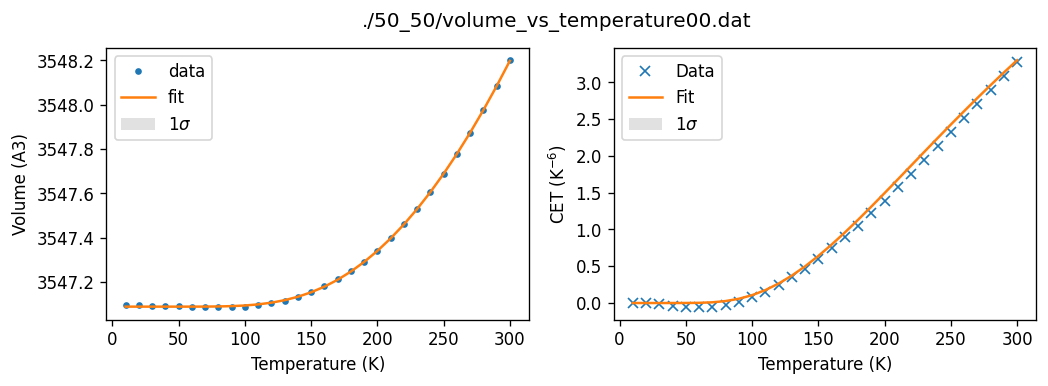

##################### ./50_50/volume_vs_temperature01.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32826
    # data points      = 30
    # variables        = 5
    chi-square         = 8.2104e-05
    reduced chi-square = 3.2842e-06
    Akaike info crit   = -374.261678
    Bayesian info crit = -367.255691
[[Variables]]
    a0:  3528.18012 +/- 7.2601e-04 (0.00%) (init = 400)
    a1:  563.080475 +/- 10.5391164 (1.87%) (init = 100)
    a2:  0 (fixed)
    a3:  354.096973 +/- 50.7350303 (14.33%) (init = 0)
    a4: -3.91404057 +/- 0.50903832 (13.01%) (init = 0)
    a5:  0.03480081 +/- 8.7008e-04 (2.50%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.959
    C(a3, a4) = -0.909
    C(a4, a5) = -0.799
    C(a0, a4) =  0.655
    C(a0, a3) = -0.628
    C(a1, a4) =  0.575
    C(a0, a5) = -0.471
    C(a0, a1) =  0.412
    C(a1, a3) = -0.193
Cost: 0.0037027535909146536
---------- DE bound

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3528.179254743424) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3528.1794190795604) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=678.2422975776699) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=686.7566761601204) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=953.1178302823328) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:      -inf      -inf      -inf3528.17934      +inf      +inf      +inf
 a1:      -inf      -inf      -inf 682.49949      +inf      +inf      +inf
 a3:      -inf      -inf      -inf 988.86910      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.64189  +0.04524  +0.09547  +0.17946
 a5:      -inf      -inf      -inf   0.04271      +inf      +inf      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 748
    # data points      = 30
    # variables        = 5
    chi-square         = 1.3469e-06
    reduced chi-square = 5.3876e-08
    Akaike info crit   = -497.566908
    Bayesian info crit = -490.560921
[[Variables]]
    a0:  3528.17934 +/- 8.2168e-05 (0.00%) (init = 3528.18)
    a1:  682.499487 +/- 4.25718929 (0.62%) (init = 563.0805)
    a2:  0 (fixed)
    a3:  988.869099 +/- 35.7512686 (3.62%) (init = 354.097)
    a4: -4.64189116 +/- 0.08293986 (1.79%) (init = 

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a5=0.04236220616562628) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a5=0.04306595484632638) = 0.0 < max(sigmas).
  warn(errmsg)


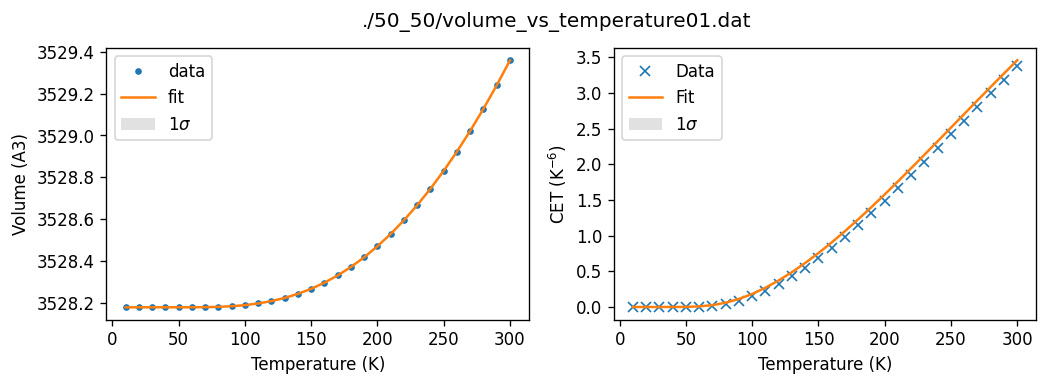

##################### ./50_50/volume_vs_temperature02.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36888
    # data points      = 30
    # variables        = 5
    chi-square         = 7.5144e-04
    reduced chi-square = 3.0058e-05
    Akaike info crit   = -307.841299
    Bayesian info crit = -300.835313
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3515.24443 +/- 0.00137083 (0.00%) (init = 400)
    a1:  648.956345 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -357.177851 +/- 186.287972 (52.16%) (init = 0)
    a4: -0.12554591 +/- 1.42905165 (1138.27%) (init = 0)
    a5:  0.02752844 +/- 0.00301962 (10.97%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.279
    C(a3, a5) =  1.091
    C(a3, a4) = -1.023
    C(a0, a4) =  0.946
    C(a0, a3) = -0.778
    C(a0, a5) = -0.261


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Cost: -0.003436067994698533
---------- DE bounds ----------
a0 :         0	     3515.24	    8000
a1 :         0	     648.956	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -357.178	    3000
a4 :        -5	   -0.125546	       5
a5 :     1e-05	   0.0275284	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=468.8803544417443) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-374.8180518045272) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a4=0.15459808450386348) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=5) = 0.9849769943722493 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.17118  -0.16383  -0.117183515.24913  +0.11718  +0.16383  +0.17118
 a1:      -inf      -inf      -inf 586.10044 +17.48580 +57.05426+113.14868
 a3:-592.90658-352.79637 -83.09900-468.52256      +inf      +inf      +inf
 a4:      -inf      -inf      -inf   0.19325  +0.69756  +3.03694      +inf
 a5:  -0.00684  -0.00320  -0.00111   0.02319  +0.00443  +0.00529  +0.00673
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 260
    # data points      = 30
    # variables        = 5
    chi-square         = 4.1591e-04
    reduced chi-square = 1.6637e-05
    Akaike info crit   = -325.586915
    Bayesian info crit = -318.580929
##  Warning: uncertainties could not be estimated:
    a0:  at initial value
[[Variables]]
    a0:  3515.24913 +/-        nan (nan%) (init = 3515.244)
    a1:  586.100443 +/-        nan (nan%) (init = 648.9563)
    a2:  0 (fixed)
    a3: -468.522565 +/-        nan 

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.020541085600052612) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.030811628400078915) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.9916653366089809 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00539  -0.00539  -0.005393515.24980  +0.00539  +0.00539  +0.00539
 a1:-102.52460 -70.26900 -36.62755 485.62367 +41.94597 +92.94750+159.95334
 a3:      -inf      -inf      -inf   0.02568      +inf      +inf      +inf
 a4:      -inf  -1.24024  -0.73034  -3.48472  +1.15876  +3.14073  +6.87400
 a5:  -0.00274  -0.00180  -0.00089   0.02493  +0.00099  +0.00214  +0.00360
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 783
    # data points      = 30
    # variables        = 5
    chi-square         = 3.4176e-04
    reduced chi-square = 1.3670e-05
    Akaike info crit   = -331.477820
    Bayesian info crit = -324.471833
[[Variables]]
    a0:  3515.24980 +/- 0.00134662 (0.00%) (init = 3515.249)
    a1:  485.623670 +/- 38.4058040 (7.91%) (init = 586.1004)
    a2:  0 (fixed)
    a3:  0.02567636 +/- 123.798016 (482147.90%) (init = -468.5226)
    a4: -3.48472381 +/- 0.89032640 (25.55%)

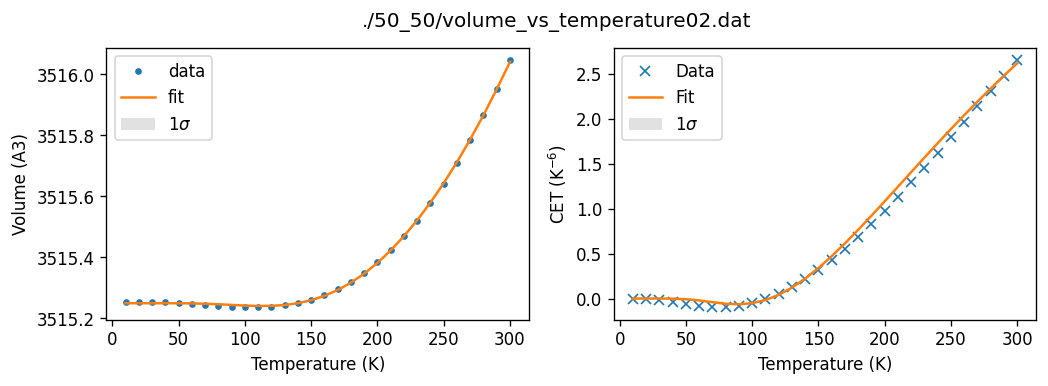

##################### ./50_50/volume_vs_temperature03.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36558
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00164802
    reduced chi-square = 6.5921e-05
    Akaike info crit   = -284.281282
    Bayesian info crit = -277.275295
[[Variables]]
    a0:  3532.79259 +/- 0.00358966 (0.00%) (init = 400)
    a1:  455.703539 +/- 59.7461671 (13.11%) (init = 100)
    a2:  0 (fixed)
    a3: -476.774099 +/- 501.997582 (105.29%) (init = 0)
    a4: -1.78148667 +/- 3.00495301 (168.68%) (init = 0)
    a5:  0.01956829 +/- 0.00297162 (15.19%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.997
    C(a1, a3) = -0.986
    C(a1, a4) =  0.972
    C(a4, a5) = -0.953
    C(a3, a5) =  0.926
    C(a1, a5) = -0.856
    C(a0, a1) = -0.575
    C(a0, a3) =  0.494
    C(a0, a4) = -0.472
    C(a0, a5) =  0.321
Cost: -0.00596945438

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.017213049746533215) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.011475366497688811) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.6833281345364894 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01155  -0.01155  -0.011553532.79379  +0.01155  +0.01155  +0.01155
 a1: -84.76129 -57.12839 -29.20822 382.60930 +31.77106 +67.84495+110.71802
 a3:      -inf      -inf      -inf  -0.01434      +inf      +inf      +inf
 a4:      -inf      -inf  -0.53336  -4.46598  +0.80823  +2.16074  +4.56043
 a5:  -0.00337  -0.00189  -0.00093   0.02142  +0.00102  +0.00218  +0.00357
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 828
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00133435
    reduced chi-square = 5.3374e-05
    Akaike info crit   = -290.615215
    Bayesian info crit = -283.609228
[[Variables]]
    a0:  3532.79379 +/- 0.00288676 (0.00%) (init = 3532.793)
    a1:  382.609296 +/- 29.9370130 (7.82%) (init = 455.7035)
    a2:  0 (fixed)
    a3: -0.01434421 +/- 124.225198 (866030.37%) (init = -476.7741)
    a4: -4.46597863 +/- 0.62940333 (14.09%)

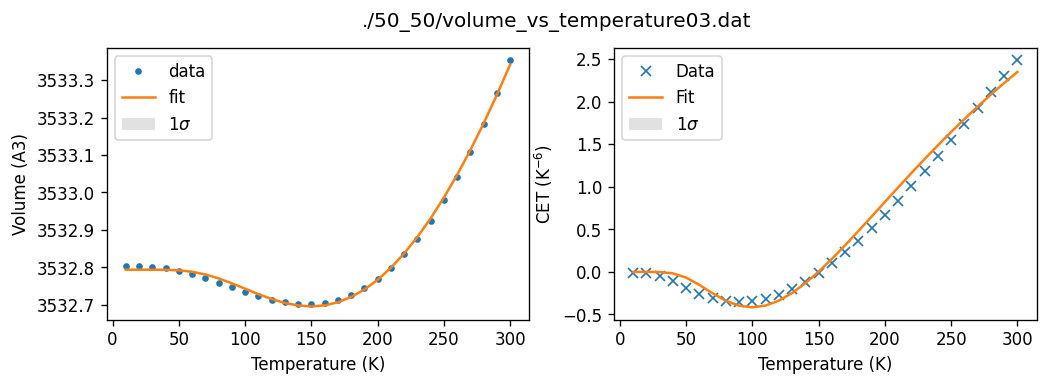

##################### ./50_50/volume_vs_temperature04.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 29820
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00549073
    reduced chi-square = 2.1963e-04
    Akaike info crit   = -248.176748
    Bayesian info crit = -241.170761
[[Variables]]
    a0:  3519.19808 +/- 0.00586582 (0.00%) (init = 400)
    a1:  548.606572 +/- 51.4366268 (9.38%) (init = 100)
    a2:  0 (fixed)
    a3:  1052.25902 +/- 417.099997 (39.64%) (init = 0)
    a4: -3.29223197 +/- 1.14458983 (34.77%) (init = 0)
    a5:  0.04672931 +/- 0.00310451 (6.64%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.949
    C(a3, a5) =  0.848
    C(a1, a5) =  0.687
    C(a0, a1) =  0.613
    C(a0, a3) =  0.481
    C(a0, a4) =  0.406
    C(a1, a4) =  0.396
    C(a4, a5) = -0.376
    C(a0, a5) =  0.351
    C(a3, a4) =  0.102
Cost: -0.005624626614007

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.594619298542788) = 0.9713410300528659 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01390  -0.01390  -0.013903519.18966  +0.01390  +0.01390  +0.01390
 a1:  -1.69727 -23.30609  -0.59463 433.08849 +27.42248 +56.82379 +89.56181
 a3:-212.44158-156.86680 -87.64225 571.68115  +4.59174  +8.64957 +13.22401
 a4:      -inf      -inf      -inf  -4.99999  +0.07918  +0.33384      +inf
 a5:  -0.00584  -0.00381  -0.00188   0.04274  +0.00007  +0.00014  +0.00021
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 422
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00234953
    reduced chi-square = 9.3981e-05
    Akaike info crit   = -273.642123
    Bayesian info crit = -266.636136
[[Variables]]
    a0:  3519.18966 +/- 0.00347453 (0.00%) (init = 3519.198)
    a1:  433.088486 +/- 26.9425412 (6.22%) (init = 548.6066)
    a2:  0 (fixed)
    a3:  571.681145 +/- 96.8858250 (16.95%) (init = 1052.259)
    a4: -4.99998671 +/- 0.00201675 (0.04%) (init

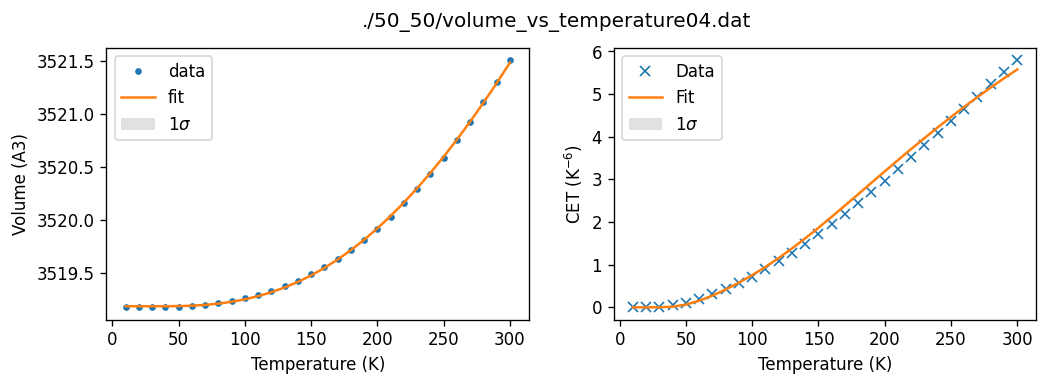

##################### ./50_50/volume_vs_temperature05.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 31488
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00262508
    reduced chi-square = 1.0500e-04
    Akaike info crit   = -270.315224
    Bayesian info crit = -263.309237
[[Variables]]
    a0:  3577.10356 +/- 0.00342449 (0.00%) (init = 400)
    a1:  506.911349 +/- 27.2050218 (5.37%) (init = 100)
    a2:  0 (fixed)
    a3:  553.824932 +/- 113.108373 (20.42%) (init = 0)
    a4: -4.26791736 +/- 0.45344666 (10.62%) (init = 0)
    a5:  0.04503631 +/- 0.00198448 (4.41%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.940
    C(a1, a5) =  0.879
    C(a1, a3) =  0.875
    C(a1, a4) =  0.345
    C(a0, a1) =  0.319
    C(a0, a5) =  0.266
    C(a0, a4) =  0.263
    C(a4, a5) = -0.122
    C(a3, a4) = -0.113
Cost: 0.005291410229347093
---------- DE bounds

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.992219971236371) = 0.2107043506405204 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01172  -0.01172  -0.011723577.10083  +0.00586  +0.00586  +0.00586
 a1: -29.83506 -27.79916 -27.70114 498.87683 +14.45384 +29.91735 +29.91735
 a3:-128.84015-128.86501  -3.78071 626.13964  +5.47615 +31.92453 +15.97655
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00220  -0.00219  -0.00202   0.04567  +0.00009  +0.00016  +0.00136
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 585
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00196558
    reduced chi-square = 7.8623e-05
    Akaike info crit   = -278.995019
    Bayesian info crit = -271.989032
[[Variables]]
    a0:  3577.10083 +/- 0.00293052 (0.00%) (init = 3577.104)
    a1:  498.876833 +/- 29.9305707 (6.00%) (init = 506.9113)
    a2:  0 (fixed)
    a3:  626.139643 +/- 128.865012 (20.58%) (init = 553.8249)
    a4: -5.00000000 +/- 3.8707e-05 (0.00%) (init

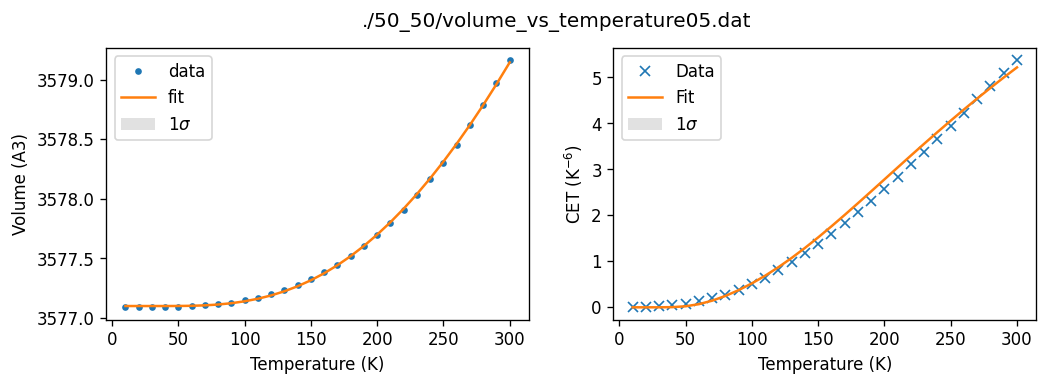

##################### ./50_50/volume_vs_temperature06.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32532
    # data points      = 30
    # variables        = 5
    chi-square         = 4.8439e-04
    reduced chi-square = 1.9376e-05
    Akaike info crit   = -321.014253
    Bayesian info crit = -314.008266
[[Variables]]
    a0:  3522.16616 +/- 0.00143048 (0.00%) (init = 400)
    a1:  637.782440 +/- 27.6756424 (4.34%) (init = 100)
    a2:  0 (fixed)
    a3:  1102.91875 +/- 242.769358 (22.01%) (init = 0)
    a4: -4.86549727 +/- 0.23772833 (4.89%) (init = 0)
    a5:  0.05637428 +/- 0.00215017 (3.81%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.990
    C(a3, a5) =  0.976
    C(a1, a5) =  0.968
    C(a0, a5) =  0.440
    C(a0, a1) =  0.431
    C(a0, a3) =  0.374
    C(a4, a5) = -0.142
    C(a0, a4) =  0.128
Cost: 0.004255688728790119
---------- DE bounds ----------
a0 :        

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0023306885623132377 < 1e-05 at iteration 3 and prob(a0=3522.1691110439497) = 0.9938922627689538 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.991353529425926) = 0.24693248662958855 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00497  -0.00497  -0.004973522.16539  +0.00372  +0.00372      +inf
 a1: -20.82238  -0.64002  -1.60111 597.14745  +0.18330 +27.12521 +71.73276
 a3:-140.70939-132.41151-122.96839 809.57460  +4.10263  +7.48997 +70.30100
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00058  -0.00008  -0.00003   0.05343  +0.00179  +0.00210  +0.00532
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 823
    # data points      = 30
    # variables        = 5
    chi-square         = 4.0602e-04
    reduced chi-square = 1.6241e-05
    Akaike info crit   = -326.309390
    Bayesian info crit = -319.303403
[[Variables]]
    a0:  3522.16539 +/- 0.00124165 (0.00%) (init = 3522.166)
    a1:  597.147450 +/- 21.7862786 (3.65%) (init = 637.7824)
    a2:  0 (fixed)
    a3:  809.574598 +/- 140.968409 (17.41%) (init = 1102.919)
    a4: -4.99999999 +/- 4.3017e-05 (0.00%) (init

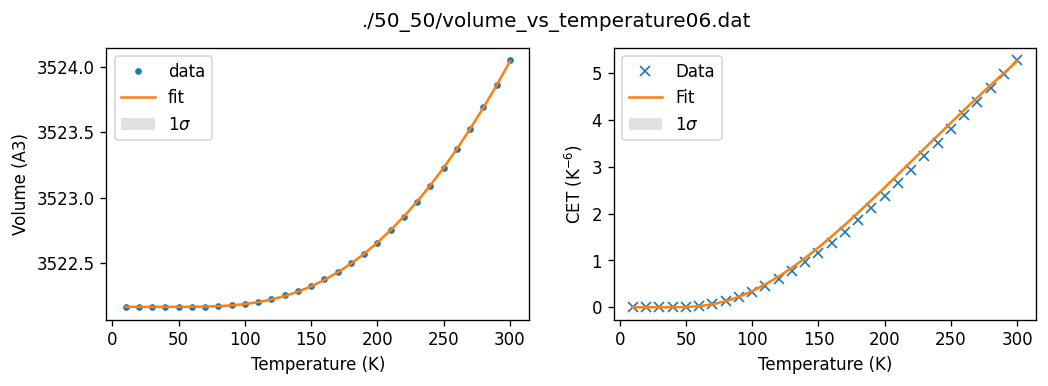

##################### ./50_50/volume_vs_temperature07.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 31488
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00224994
    reduced chi-square = 8.9997e-05
    Akaike info crit   = -274.941536
    Bayesian info crit = -267.935549
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3607.84846 +/- 0.00254364 (0.00%) (init = 400)
    a1:  651.954783 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -388.866610 +/- 428.319345 (110.15%) (init = 0)
    a4:  0.52957969 +/- 3.72833505 (704.02%) (init = 0)
    a5:  0.02944946 +/- 0.00689430 (23.41%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.045
    C(a3, a4) = -1.009
    C(a3, a5) =  0.994
    C(a0, a4) =  0.539
    C(a0, a3) = -0.496
    C(a0, a5) = -0.314


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.0034825227867258945
---------- DE bounds ----------
a0 :         0	     3607.85	    8000
a1 :         0	     651.955	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -388.867	    3000
a4 :        -5	     0.52958	       5
a5 :     1e-05	   0.0294495	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.04606387625881325) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.030709250839208835) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.9912058625870652 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00793  -0.00793  -0.007933607.85946  +0.00793  +0.00793  +0.00793
 a1: -97.04865 -66.50023 -34.65309 432.98843 +39.54793 +87.43173+149.67973
 a3:      -inf      -inf      -inf  -0.03839      +inf      +inf      +inf
 a4:      -inf  -1.17074  -0.68326  -3.56466  +1.07813  +2.92215  +6.38057
 a5:  -0.00485  -0.00192  -0.00091   0.02465  +0.00102  +0.00221  +0.00372
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 969
    # data points      = 30
    # variables        = 5
    chi-square         = 6.8254e-04
    reduced chi-square = 2.7302e-05
    Akaike info crit   = -310.726675
    Bayesian info crit = -303.720688
[[Variables]]
    a0:  3607.85946 +/- 0.00198344 (0.00%) (init = 3607.848)
    a1:  432.988426 +/- 36.2933446 (8.38%) (init = 651.9548)
    a2:  0 (fixed)
    a3: -0.03838656 +/- 119.021480 (310060.26%) (init = -388.8666)
    a4: -3.56465895 +/- 0.83018137 (23.29%)

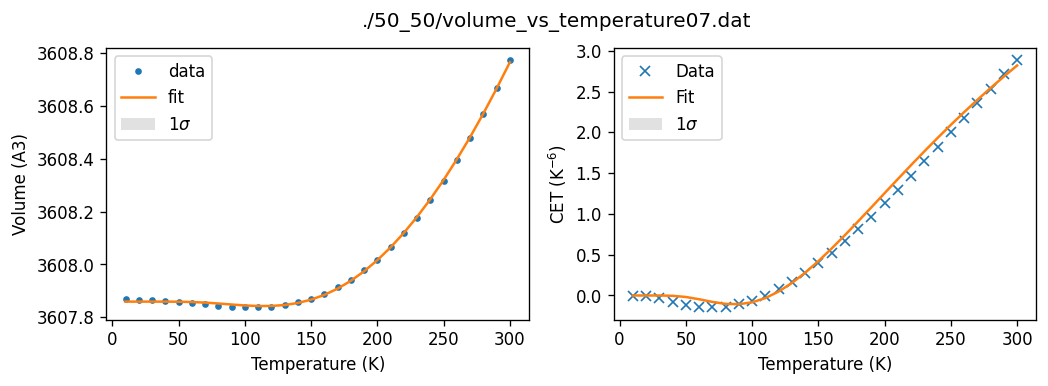

##################### ./50_50/volume_vs_temperature08.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33978
    # data points      = 30
    # variables        = 5
    chi-square         = 1.3327e-04
    reduced chi-square = 5.3309e-06
    Akaike info crit   = -359.729139
    Bayesian info crit = -352.723152
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3518.54291 +/- 6.0205e-04 (0.00%) (init = 400)
    a1:  804.769033 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  579.546146 +/-        nan (nan%) (init = 0)
    a4:  1.72566339 +/-        nan (nan%) (init = 0)
    a5:  0.04704809 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.002377855980739696
---------- DE bounds ----------
a0 :         0	     3518.54	    8000
a1 :         0	     804.769	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     579.546	    3000
a4 :        -5	     1.72566	       5
a5 :     1e-05	   0.0470481	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0018487798251320276 < 1e-05 at iteration 24 and prob(a3=2998.2039615764743) = 0.04818788658107407 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.000882565081440616 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00117  -0.00117  -0.001173518.54280  +0.00234  +0.00234  +0.00234
 a1: -15.76816 -15.39787  -4.95280 912.41422  +0.18172  +0.45946  +0.66749
 a3:      -inf      -inf      -inf3000.00000      +inf      +inf      +inf
 a4:  -0.06140  -1.16571  -1.12156  -3.32227  +1.25178  +1.38878  +0.39352
 a5:  -0.00029  -0.00015  -0.00006   0.06252  +0.00081  +0.00258  +0.00025
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 3526
    # data points      = 30
    # variables        = 5
    chi-square         = 9.5440e-05
    reduced chi-square = 3.8176e-06
    Akaike info crit   = -369.746189
    Bayesian info crit = -362.740202
[[Variables]]
    a0:  3518.54280 +/- 5.8600e-04 (0.00%) (init = 3518.543)
    a1:  912.414216 +/- 7.88407771 (0.86%) (init = 804.769)
    a2:  0 (fixed)
    a3:  3000.00000 +/- 0.07483481 (0.00%) (init = 579.5461)
    a4: -3.32226813 +/- 1.40366055 (42.25%) (init

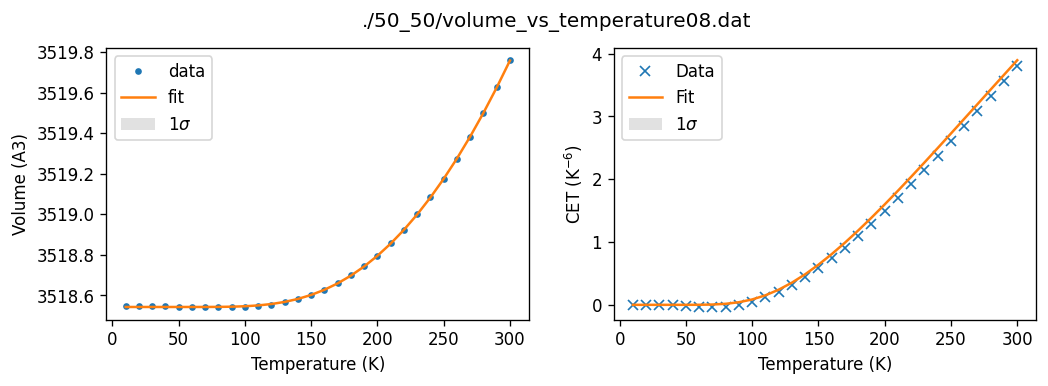

##################### ./50_50/volume_vs_temperature09.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 29748
    # data points      = 30
    # variables        = 5
    chi-square         = 9.8429e-04
    reduced chi-square = 3.9372e-05
    Akaike info crit   = -299.743583
    Bayesian info crit = -292.737596
[[Variables]]
    a0:  3574.38452 +/- 0.00219516 (0.00%) (init = 400)
    a1:  540.032611 +/- 26.9265579 (4.99%) (init = 100)
    a2:  0 (fixed)
    a3:  518.631821 +/- 111.570800 (21.51%) (init = 0)
    a4: -3.47549344 +/- 0.85216215 (24.52%) (init = 0)
    a5:  0.04530486 +/- 0.00173197 (3.82%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.951
    C(a1, a3) =  0.681
    C(a1, a4) =  0.605
    C(a1, a5) =  0.559
    C(a0, a4) =  0.475
    C(a0, a1) =  0.364
    C(a4, a5) = -0.315
    C(a3, a4) = -0.159
Cost: 0.004666080164042796
---------- DE bounds ----------
a0 :       

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.002501333601533805 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.991240056642636) = 0.2785737458240883 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00549  -0.00549  -0.005493574.38299  +0.00412  +0.00412  +0.00412
 a1: -10.34920 -15.87617 -15.85905 546.63426  +3.35312 +41.69653 +67.44691
 a3:-226.10395-196.18662  -1.83274 734.72347  +3.59844 +97.42712+112.70522
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00012  -0.00153  -0.00003   0.04895  +0.00006  +0.00154  +0.00015
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 868
    # data points      = 30
    # variables        = 5
    chi-square         = 4.5377e-04
    reduced chi-square = 1.8151e-05
    Akaike info crit   = -322.973672
    Bayesian info crit = -315.967685
[[Variables]]
    a0:  3574.38299 +/- 0.00137282 (0.00%) (init = 3574.385)
    a1:  546.634256 +/- 20.7346854 (3.79%) (init = 540.0326)
    a2:  0 (fixed)
    a3:  734.723469 +/- 113.097570 (15.39%) (init = 518.6318)
    a4: -4.99999999 +/- 4.3582e-05 (0.00%) (init

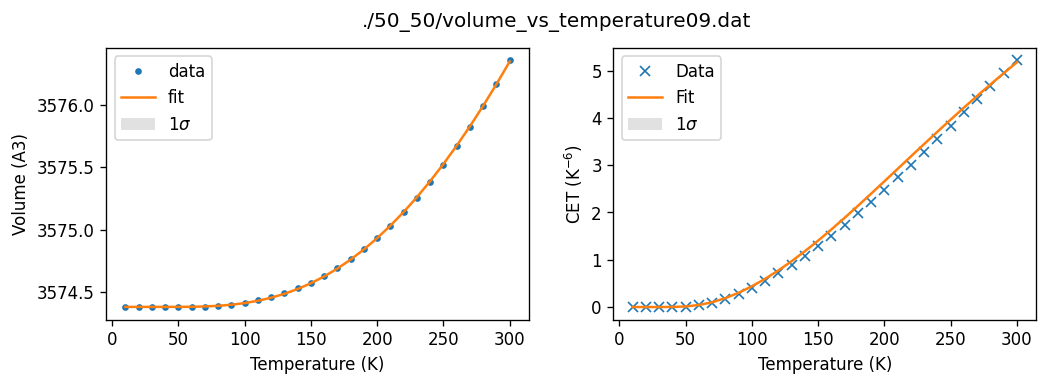

##################### ./50_50/volume_vs_temperature10.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32730
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00168927
    reduced chi-square = 6.7571e-05
    Akaike info crit   = -283.539741
    Bayesian info crit = -276.533754
[[Variables]]
    a0:  3592.20287 +/- 0.00324882 (0.00%) (init = 400)
    a1:  421.916685 +/- 34.5566558 (8.19%) (init = 100)
    a2:  0 (fixed)
    a3: -177.356689 +/- 223.828469 (126.20%) (init = 0)
    a4: -4.38411235 +/- 1.22992673 (28.05%) (init = 0)
    a5:  0.02591544 +/- 0.00125067 (4.83%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.981
    C(a1, a3) = -0.956
    C(a1, a4) =  0.887
    C(a4, a5) = -0.566
    C(a3, a5) =  0.399
    C(a0, a1) = -0.353
    C(a0, a5) = -0.324
    C(a0, a3) =  0.188
    C(a1, a5) = -0.126
    C(a0, a4) = -0.121
Cost: -0.00751164979010

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00045027274988680753 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.960275141353798) = 0.14829391250612464 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01268  -0.01268  -0.012683592.20316  +0.00634  +0.00634  +0.00634
 a1:  -5.98869 -10.58765 -10.57531 404.02353  +1.39304 +45.34812 +26.10495
 a3:  -9.01068  -5.14062  -2.12879 -62.60242  +3.43120  +6.40390  +9.75480
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00015  -0.00104  -0.00004   0.02615  +0.00006  +0.00011  +0.00105
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1218
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00163618
    reduced chi-square = 6.5447e-05
    Akaike info crit   = -284.497563
    Bayesian info crit = -277.491576
[[Variables]]
    a0:  3592.20316 +/- 0.00316884 (0.00%) (init = 3592.203)
    a1:  404.023527 +/- 17.4621474 (4.32%) (init = 421.9167)
    a2:  0 (fixed)
    a3: -62.6024231 +/- 43.8977577 (70.12%) (init = -177.3567)
    a4: -4.99999999 +/- 1.9764e-04 (0.00%) (in

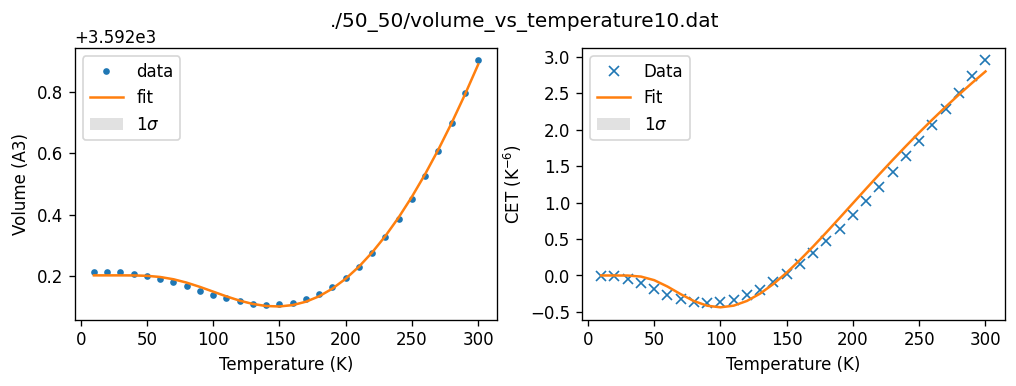

##################### ./50_50/volume_vs_temperature11.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33276
    # data points      = 30
    # variables        = 5
    chi-square         = 3.9060e-04
    reduced chi-square = 1.5624e-05
    Akaike info crit   = -327.470498
    Bayesian info crit = -320.464511
[[Variables]]
    a0:  3529.57981 +/- 0.00127537 (0.00%) (init = 400)
    a1:  769.664345 +/- 26.3793749 (3.43%) (init = 100)
    a2:  0 (fixed)
    a3:  997.594561 +/- 431.372905 (43.24%) (init = 0)
    a4:  3.36447039 +/- 2.36117305 (70.18%) (init = 0)
    a5:  0.05300929 +/- 0.00452963 (8.54%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.908
    C(a1, a3) =  0.763
    C(a3, a5) =  0.709
    C(a0, a4) =  0.494
    C(a3, a4) = -0.371
    C(a0, a5) = -0.361
    C(a1, a4) =  0.314
    C(a0, a1) =  0.282
    C(a1, a5) =  0.103
Cost: -0.0030795038496762572
---------- DE boun

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.3898460647853273 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00364  -0.00364  -0.003643529.57872  +0.00364  +0.00364  +0.00364
 a1:-131.60229 -56.07231 -19.64398 810.25725 +12.69800 +19.47439 +28.03415
 a3:-2218.49444-1287.58935-440.941052777.41220      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.99667  +1.07232  +3.47911  +5.99786
 a5:  -0.01711  -0.00938  -0.00274   0.07232  +0.00090  +0.00139  +0.00193
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 963
    # data points      = 30
    # variables        = 5
    chi-square         = 2.0909e-04
    reduced chi-square = 8.3636e-06
    Akaike info crit   = -346.218188
    Bayesian info crit = -339.212201
[[Variables]]
    a0:  3529.57872 +/- 9.1086e-04 (0.00%) (init = 3529.58)
    a1:  810.257245 +/- 18.3316631 (2.26%) (init = 769.6643)
    a2:  0 (fixed)
    a3:  2777.41220 +/- 385.155679 (13.87%) (init = 997.5946)
    a4: -4.99666877 +/- 0.13103286 (2.62%) (ini

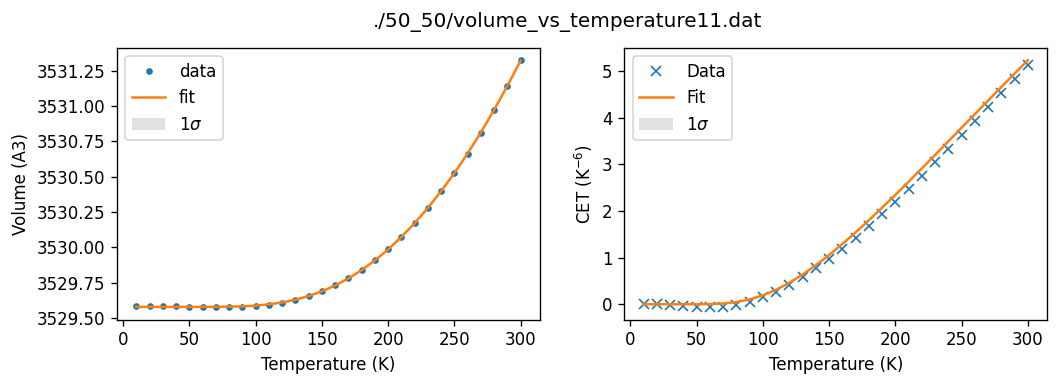

##################### ./50_50/volume_vs_temperature12.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32742
    # data points      = 30
    # variables        = 5
    chi-square         = 5.4930e-04
    reduced chi-square = 2.1972e-05
    Akaike info crit   = -317.241749
    Bayesian info crit = -310.235762
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3532.49824 +/- 0.00111465 (0.00%) (init = 400)
    a1:  576.782903 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -437.724359 +/-        nan (nan%) (init = 0)
    a4:  0.42810298 +/-        nan (nan%) (init = 0)
    a5:  0.02411430 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.003969691884321946
---------- DE bounds ----------
a0 :         0	      3532.5	    8000
a1 :         0	     576.783	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -437.724	    3000
a4 :        -5	    0.428103	       5
a5 :     1e-05	   0.0241143	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.0004353161818689841) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.002435316181868984) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.9939521157540279 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00634  -0.00634  -0.006343532.49908  +0.00634  +0.00634  +0.00634
 a1: -82.40337 -73.50463 -16.42200 474.46744 +26.91796 +45.83441 +71.03975
 a3:      -inf      -inf      -inf   0.00144      +inf      +inf      +inf
 a4:      -inf  -1.33653  -0.09719  -3.32410  +0.62713  +1.07197  +3.89601
 a5:  -0.00301  -0.00192  -0.00097   0.02577  +0.00110  +0.00240  +0.00410
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 763
    # data points      = 30
    # variables        = 5
    chi-square         = 4.6214e-04
    reduced chi-square = 1.8486e-05
    Akaike info crit   = -322.425194
    Bayesian info crit = -315.419207
[[Variables]]
    a0:  3532.49908 +/- 0.00158470 (0.00%) (init = 3532.498)
    a1:  474.467443 +/- 41.2065870 (8.68%) (init = 576.7829)
    a2:  0 (fixed)
    a3:  0.00143532 +/- 125.189338 (8722073.86%) (init = -437.7244)
    a4: -3.32410304 +/- 0.97400282 (29.30%

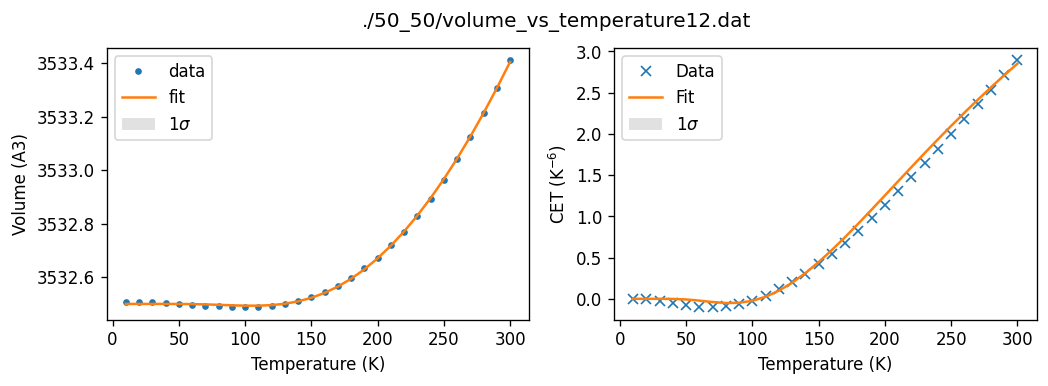

##################### ./50_50/volume_vs_temperature13.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32838
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00112820
    reduced chi-square = 4.5128e-05
    Akaike info crit   = -295.649988
    Bayesian info crit = -288.644001
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3593.40767 +/- 0.00225129 (0.00%) (init = 400)
    a1:  620.596801 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -1044.26176 +/-        nan (nan%) (init = 0)
    a4:  2.22867892 +/-        nan (nan%) (init = 0)
    a5:  0.03940930 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.004056783574469591
---------- DE bounds ----------
a0 :         0	     3593.41	    8000
a1 :         0	     620.597	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -1044.26	    3000
a4 :        -5	     2.22868	       5
a5 :     1e-05	   0.0394093	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00029623131782670993 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.968606853193912) = 0.10697833473079885 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00856  -0.00856  -0.008563593.40895  +0.00428  +0.00428  +0.00428
 a1:  -2.20481 -10.86325 -10.82598 524.32613  +9.61878 +11.20051  +1.89787
 a3: -10.46089 -17.16140  -2.60766-154.60445  +4.30751  +7.99653 +12.16321
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00016  -0.00010  -0.00004   0.04393  +0.00096  +0.00151  +0.00159
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1865
    # data points      = 30
    # variables        = 5
    chi-square         = 8.8411e-04
    reduced chi-square = 3.5364e-05
    Akaike info crit   = -302.963783
    Bayesian info crit = -295.957796
[[Variables]]
    a0:  3593.40895 +/- 0.00213889 (0.00%) (init = 3593.408)
    a1:  524.326134 +/- 16.0752491 (3.07%) (init = 620.5968)
    a2:  0 (fixed)
    a3: -154.604448 +/- 19.5467369 (12.64%) (init = -1044.262)
    a4: -5.00000000 +/- 1.5618e-04 (0.00%) (in

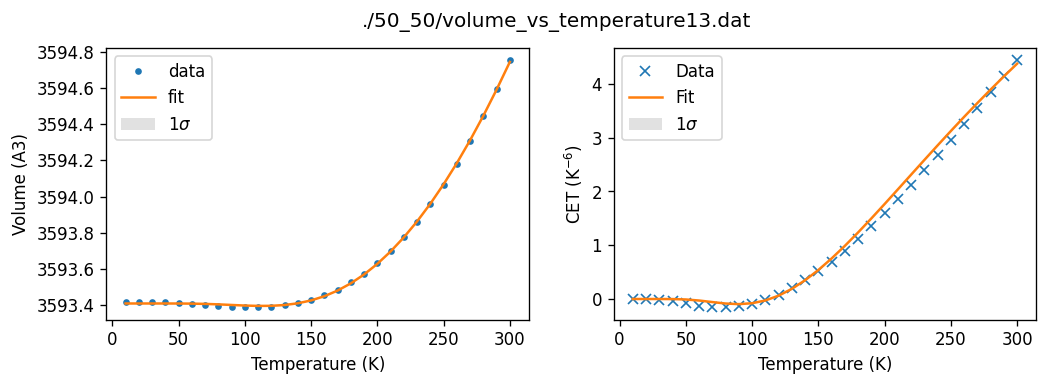

##################### ./50_50/volume_vs_temperature14.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 25836
    # data points      = 30
    # variables        = 5
    chi-square         = 0.01137177
    reduced chi-square = 4.5487e-04
    Akaike info crit   = -226.334554
    Bayesian info crit = -219.328567
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3513.73458 +/- 0.00698816 (0.00%) (init = 400)
    a1:  429.749672 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  660.395875 +/-        nan (nan%) (init = 0)
    a4: -4.61635580 +/- 0.42242035 (9.15%) (init = 0)
    a5:  0.04707057 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a4) =  0.112


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.008767644845647737
---------- DE bounds ----------
a0 :         0	     3513.73	    8000
a1 :         0	      429.75	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     660.396	    3000
a4 :        -5	    -4.61636	       5
a5 :     1e-05	   0.0470706	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.9948827831234714) = 0.15115281598222538 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.02683  -0.02683  -0.026833513.74064  +0.01342  +0.01342  +0.01342
 a1:  -2.57478 -21.73868 -21.72866 420.18198 +34.52999 +71.99382+114.33496
 a3:-250.45486-213.49126-124.80553 604.67097  +7.80292 +22.40409 +23.65007
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00813  -0.00535  -0.00128   0.04786  +0.00017  +0.00399  +0.00538
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 595
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00889899
    reduced chi-square = 3.5596e-04
    Akaike info crit   = -233.690434
    Bayesian info crit = -226.684447
[[Variables]]
    a0:  3513.74064 +/- 0.00670858 (0.00%) (init = 3513.735)
    a1:  420.181981 +/- 33.3731570 (7.94%) (init = 429.7497)
    a2:  0 (fixed)
    a3:  604.670969 +/- 143.909115 (23.80%) (init = 660.3959)
    a4: -5.00000000 +/- 2.5459e-05 (0.00%) (init

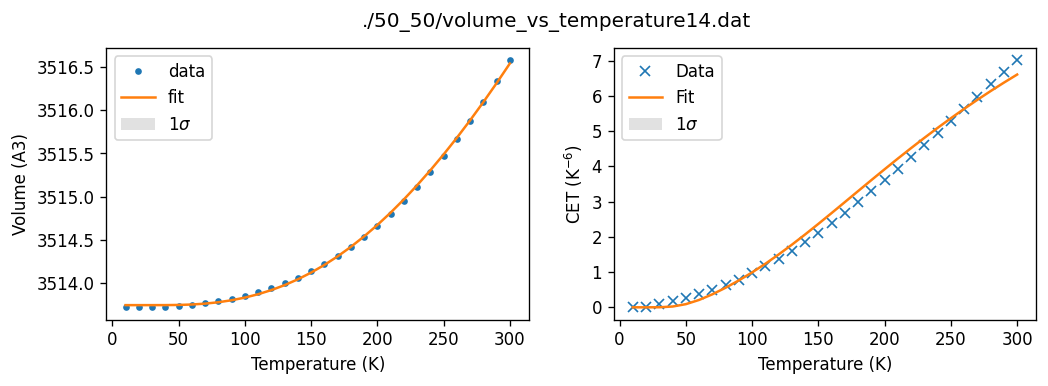

##################### ./50_50/volume_vs_temperature15.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36192
    # data points      = 30
    # variables        = 5
    chi-square         = 1.9716e-04
    reduced chi-square = 7.8864e-06
    Akaike info crit   = -347.980907
    Bayesian info crit = -340.974920
[[Variables]]
    a0:  3542.55020 +/- 8.3732e-04 (0.00%) (init = 400)
    a1:  848.821859 +/- 24.0039921 (2.83%) (init = 100)
    a2:  0 (fixed)
    a3:  1603.62449 +/- 499.945373 (31.18%) (init = 0)
    a4:  1.35910811 +/- 1.90314262 (140.03%) (init = 0)
    a5:  0.04187184 +/- 0.00402823 (9.62%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.977
    C(a1, a3) =  0.883
    C(a3, a5) =  0.766
    C(a3, a4) = -0.645
    C(a1, a5) =  0.393
    C(a0, a4) =  0.270
    C(a0, a1) =  0.258
    C(a1, a4) = -0.217
    C(a0, a5) = -0.164
Cost: -0.002536031997351529
---------- DE boun

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=4.863192517190746e-06 < 1e-05 at iteration 27 and prob(a1=629.2558075148368) = 0.9884886792025701 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.5157551188276684 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=5) = 0.9916741742135833 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00320  -0.00320  -0.003203542.55012  +0.00320  +0.00320  +0.00320
 a1:      -inf -88.24788 -20.29462 888.42525 +10.04300 +20.51104 +32.44868
 a3:-3172.85179-2122.79110-645.038992998.40141      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -3.94037  +2.51585  +6.74047      +inf
 a5:  -0.02004  -0.01497  -0.00513   0.05319  +0.00239  +0.00298  +0.00358
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1444
    # data points      = 30
    # variables        = 5
    chi-square         = 1.7638e-04
    reduced chi-square = 7.0552e-06
    Akaike info crit   = -351.321935
    Bayesian info crit = -344.315948
[[Variables]]
    a0:  3542.55012 +/- 8.0075e-04 (0.00%) (init = 3542.55)
    a1:  888.425247 +/- 9.59886813 (1.08%) (init = 848.8219)
    a2:  0 (fixed)
    a3:  2998.40141 +/- 70.6245564 (2.36%) (init = 1603.624)
    a4: -3.94037024 +/- 1.56599234 (39.74%) (in

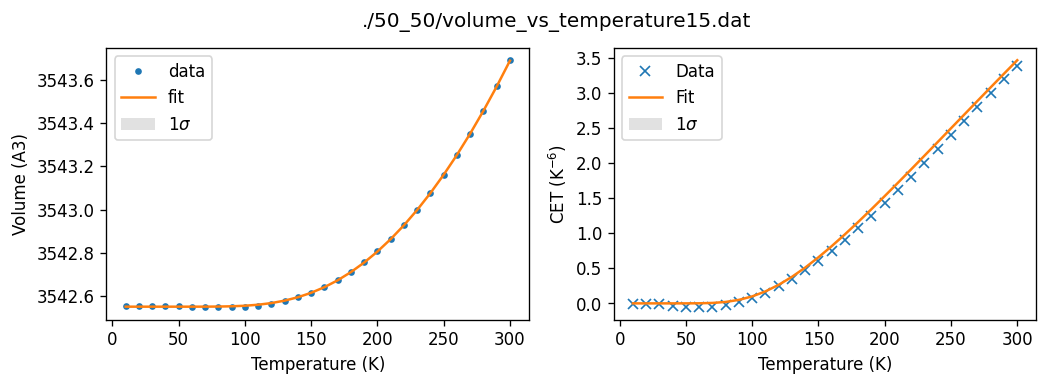

##################### ./50_50/volume_vs_temperature16.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 27390
    # data points      = 30
    # variables        = 5
    chi-square         = 0.01224173
    reduced chi-square = 4.8967e-04
    Akaike info crit   = -224.123063
    Bayesian info crit = -217.117076
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3533.26461 +/-        nan (nan%) (init = 400)
    a1:  731.552663 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -2295.72702 +/-        nan (nan%) (init = 0)
    a4:  4.07590419 +/-        nan (nan%) (init = 0)
    a5:  0.04447693 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Cost: -0.00227294522937882
---------- DE bounds ----------
a0 :         0	     3533.26	    8000
a1 :         0	     731.553	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -2295.73	    3000
a4 :        -5	      4.0759	       5
a5 :     1e-05	   0.0444769	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0002068755983462237 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.985794606981704) = 0.10147914630998404 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01286  -0.01286  -0.012863533.28872  +0.00643  +0.00643  +0.00643
 a1:  -5.38799 -21.21713  -1.87192 428.94313 +20.63107 +52.06954+100.66812
 a3:-132.55251 -63.66416 -23.63458-140.47574  +3.88234  +7.28792 +11.12832
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00229  -0.00229  -0.00018   0.02930  +0.00006  +0.00012  +0.00018
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1598
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00171911
    reduced chi-square = 6.8764e-05
    Akaike info crit   = -283.014340
    Bayesian info crit = -276.008353
[[Variables]]
    a0:  3533.28872 +/- 0.00321387 (0.00%) (init = 3533.265)
    a1:  428.943129 +/- 16.6307821 (3.88%) (init = 731.5527)
    a2:  0 (fixed)
    a3: -140.475738 +/- 44.4889362 (31.67%) (init = -2295.727)
    a4: -5.00000000 +/- 7.0674e-05 (0.00%) (in

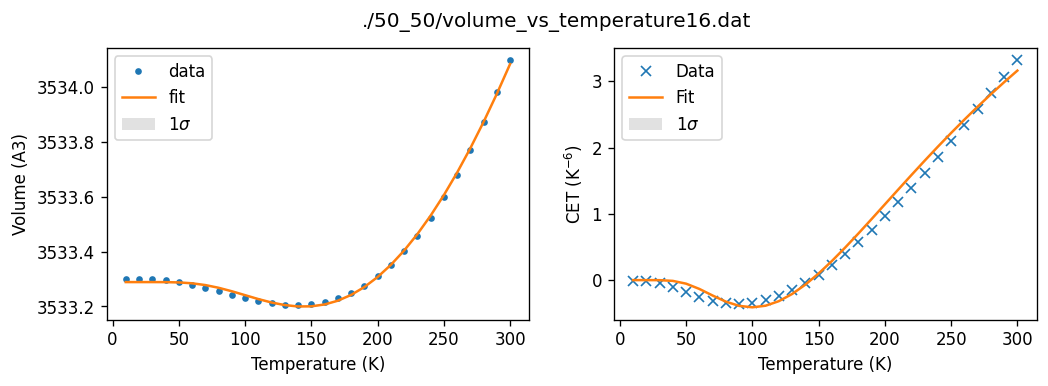

##################### ./50_50/volume_vs_temperature17.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34374
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00115205
    reduced chi-square = 4.6082e-05
    Akaike info crit   = -295.022254
    Bayesian info crit = -288.016267
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3539.49587 +/- 0.00175689 (0.00%) (init = 400)
    a1:  738.401782 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2289.37725 +/-        nan (nan%) (init = 0)
    a4: -3.02822166 +/- 1.18267158 (39.05%) (init = 0)
    a5:  0.04680527 +/- 0.00212017 (4.53%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.993
    C(a0, a5) = -0.575
    C(a0, a4) =  0.537


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.002913797798100859
---------- DE bounds ----------
a0 :         0	      3539.5	    8000
a1 :         0	     738.402	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2289.38	    3000
a4 :        -5	    -3.02822	       5
a5 :     1e-05	   0.0468053	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3539.4890292367586) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3539.4896299136312) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=555.1931353032905) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=732.7689911331065) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:      -inf      -inf      -inf3539.48933      +inf      +inf      +inf
 a1: -22.78097 -14.42550  -8.78271 547.03853      +inf      +inf      +inf
 a3: -87.67412 -55.60769 -32.70135 695.44804      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.95588  +0.03076  +0.08191  +0.17203
 a5:  -0.00129  -0.00078  -0.00043   0.04191      +inf      +inf      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 994
    # data points      = 30
    # variables        = 5
    chi-square         = 1.6791e-05
    reduced chi-square = 6.7163e-07
    Akaike info crit   = -421.876331
    Bayesian info crit = -414.870344
[[Variables]]
    a0:  3539.48933 +/- 3.0034e-04 (0.00%) (init = 3539.496)
    a1:  547.038533 +/- 8.15460229 (1.49%) (init = 738.4018)
    a2:  0 (fixed)
    a3:  695.448045 +/- 37.3209462 (5.37%) (init = 2289.377)
    a4: -4.95587647 +/- 0.04834347 (0.98%) (init 

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a5=0.042426418446761725) = 0.0 < max(sigmas).
  warn(errmsg)


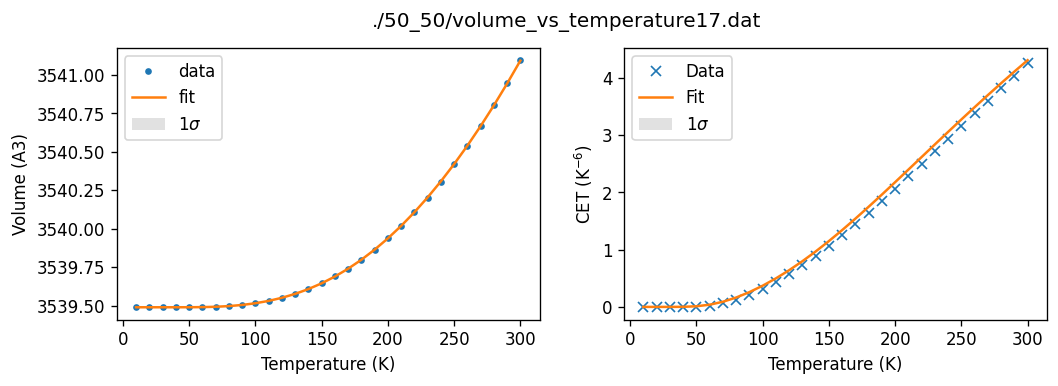

##################### ./50_50/volume_vs_temperature18.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33186
    # data points      = 30
    # variables        = 5
    chi-square         = 0.01336693
    reduced chi-square = 5.3468e-04
    Akaike info crit   = -221.485057
    Bayesian info crit = -214.479070
[[Variables]]
    a0:  3526.10417 +/- 0.00889673 (0.00%) (init = 400)
    a1:  478.975257 +/- 29.1176386 (6.08%) (init = 100)
    a2:  0 (fixed)
    a3:  670.255705 +/- 189.796974 (28.32%) (init = 0)
    a4: -2.35785902 +/- 1.68189561 (71.33%) (init = 0)
    a5:  0.03941521 +/- 0.00314529 (7.98%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.840
    C(a4, a5) = -0.840
    C(a3, a4) = -0.569
    C(a1, a4) =  0.504
    C(a0, a1) =  0.503
    C(a0, a4) =  0.476
    C(a1, a3) =  0.394
    C(a0, a5) = -0.181
    C(a0, a3) = -0.158
Cost: 0.00576697615770172
---------- DE bounds 

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00024263834999284253 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.992804407459127) = 0.30285913183508273 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.02203  -0.02203  -0.022033526.07683  +0.01102  +0.01102  +0.01102
 a1:  -7.04483 -22.87216  -0.68028 321.79198  +0.39969  +0.97951 +25.80779
 a3: -47.27115 -46.45757 -34.36616 435.00491  +3.40919  +6.35762  +9.74502
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00116  -0.00143  -0.00004   0.03510  +0.00006  +0.00011  +0.00295
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 866
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00343307
    reduced chi-square = 1.3732e-04
    Akaike info crit   = -262.264891
    Bayesian info crit = -255.258904
[[Variables]]
    a0:  3526.07683 +/- 0.00550836 (0.00%) (init = 3526.104)
    a1:  321.791979 +/- 26.5701937 (8.26%) (init = 478.9753)
    a2:  0 (fixed)
    a3:  435.004911 +/- 47.3002288 (10.87%) (init = 670.2557)
    a4: -4.99999999 +/- 3.5799e-05 (0.00%) (init

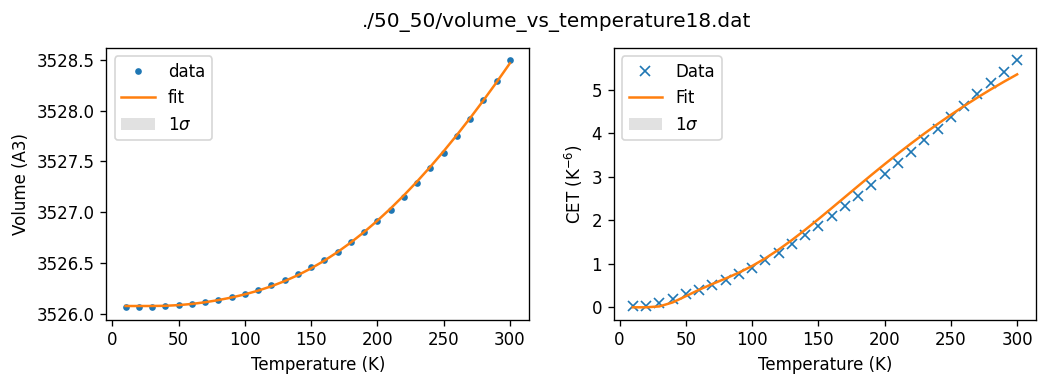

##################### ./50_50/volume_vs_temperature19.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35688
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00240102
    reduced chi-square = 9.6041e-05
    Akaike info crit   = -272.991731
    Bayesian info crit = -265.985744
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3512.97157 +/- 0.00266069 (0.00%) (init = 400)
    a1:  695.825727 +/- 27.5045900 (3.95%) (init = 100)
    a2:  0 (fixed)
    a3:  664.157035 +/- 403.031827 (60.68%) (init = 0)
    a4:  3.27588188 +/-        nan (nan%) (init = 0)
    a5:  0.04520492 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  1.199


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.003335373671234265
---------- DE bounds ----------
a0 :         0	     3512.97	    8000
a1 :         0	     695.826	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     664.157	    3000
a4 :        -5	     3.27588	       5
a5 :     1e-05	   0.0452049	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0021361805579570353 < 1e-05 at iteration 3 and prob(a0=3512.970458734471) = 0.993925773873781 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0023595387679974165 < 1e-05 at iteration 21 and prob(a4=-4.999969760898413) = 0.013866214142589674 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00528  -0.00528  -0.005283512.96650  +0.00396  +0.00396      +inf
 a1: -66.82216 -46.50681 -23.05574 606.09136 +23.53075 +48.54039 +76.12357
 a3:-230.45024-217.82126-141.60762 821.00094 +97.57369+335.79641+611.46255
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00194  -0.00194  -0.00146   0.05497  +0.00199  +0.00402  +0.00558
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 985
    # data points      = 30
    # variables        = 5
    chi-square         = 4.6922e-04
    reduced chi-square = 1.8769e-05
    Akaike info crit   = -321.969262
    Bayesian info crit = -314.963275
[[Variables]]
    a0:  3512.96650 +/- 0.00132122 (0.00%) (init = 3512.972)
    a1:  606.091362 +/- 22.9306346 (3.78%) (init = 695.8257)
    a2:  0 (fixed)
    a3:  821.000938 +/- 154.158778 (18.78%) (init = 664.157)
    a4: -5.00000000 +/- 1.4400e-06 (0.00%) (init 

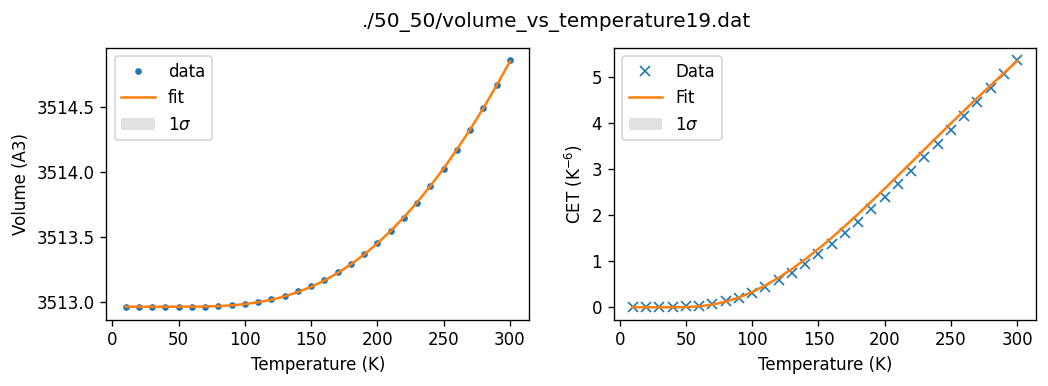

##################### ./50_50/volume_vs_temperature20.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 31842
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00319679
    reduced chi-square = 1.2787e-04
    Akaike info crit   = -264.404185
    Bayesian info crit = -257.398198
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3459.44415 +/- 0.00292921 (0.00%) (init = 400)
    a1:  711.718082 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -539.017632 +/-        nan (nan%) (init = 0)
    a4:  0.91708370 +/-        nan (nan%) (init = 0)
    a5:  0.04203029 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.002539272531066672
---------- DE bounds ----------
a0 :         0	     3459.44	    8000
a1 :         0	     711.718	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -539.018	    3000
a4 :        -5	    0.917084	       5
a5 :     1e-05	   0.0420303	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-31.196563736265308) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.5361847363646524 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00891  -0.00891  -0.008913459.45526  +0.00891  +0.00891  +0.00891
 a1: -92.91154 -68.95989 -44.97346 453.06842 +32.03303 +79.50719+141.60287
 a3:-950.68871-440.74974-150.75905 -38.99570      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.05269  +1.09881  +3.33310  +6.68357
 a5:  -0.00596  -0.00237  -0.00115   0.02992  +0.00126  +0.00267  +0.00448
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1095
    # data points      = 30
    # variables        = 5
    chi-square         = 8.6757e-04
    reduced chi-square = 3.4703e-05
    Akaike info crit   = -303.530382
    Bayesian info crit = -296.524395
[[Variables]]
    a0:  3459.45526 +/- 0.00222836 (0.00%) (init = 3459.444)
    a1:  453.068421 +/- 31.0683525 (6.86%) (init = 711.7181)
    a2:  0 (fixed)
    a3: -38.9957047 +/- 120.397918 (308.75%) (init = -539.0176)
    a4: -4.05269163 +/- 0.84480294 (20.85%) (

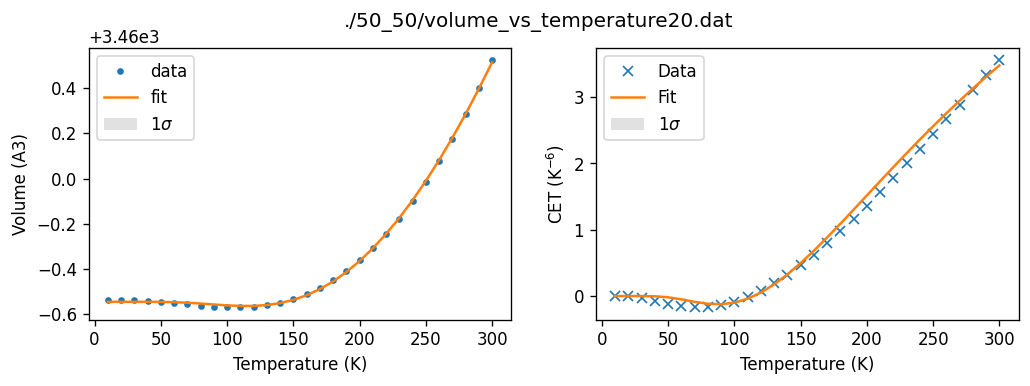

##################### ./50_50/volume_vs_temperature21.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 29520
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00567338
    reduced chi-square = 2.2694e-04
    Akaike info crit   = -247.195033
    Bayesian info crit = -240.189046
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3503.12491 +/-        nan (nan%) (init = 400)
    a1:  531.465816 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  114.278368 +/-        nan (nan%) (init = 0)
    a4: -0.68365957 +/-        nan (nan%) (init = 0)
    a5:  0.04278929 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Cost: -0.005282591792365565
---------- DE bounds ----------
a0 :         0	     3503.12	    8000
a1 :         0	     531.466	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     114.278	    3000
a4 :        -5	    -0.68366	       5
a5 :     1e-05	   0.0427893	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01127  -0.01127  -0.011273503.11955  +0.00282  +0.00282  +0.00282
 a1: -91.20279 -59.42859 -29.18452 553.15370 +31.83538 +65.09614+102.21725
 a3:-385.19070-284.59831-157.61911 755.36399+219.18267+511.62157+930.80570
 a4:      -inf      -inf      -inf  -4.99984  +0.15805  +0.67026  +1.67052
 a5:  -0.00778  -0.00509  -0.00249   0.05354  +0.00271  +0.00543  +0.00830
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 712
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00201075
    reduced chi-square = 8.0430e-05
    Akaike info crit   = -278.313311
    Bayesian info crit = -271.307324
[[Variables]]
    a0:  3503.11955 +/- 0.00281754 (0.00%) (init = 3503.125)
    a1:  553.153698 +/- 30.1273255 (5.45%) (init = 531.4658)
    a2:  0 (fixed)
    a3:  755.363989 +/- 182.741578 (24.19%) (init = 114.2784)
    a4: -4.99983684 +/- 0.00982158 (0.20%) (init

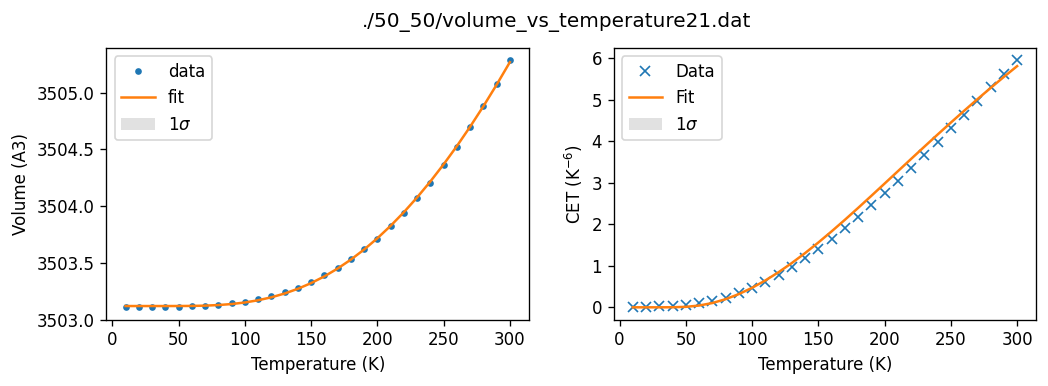

##################### ./50_50/volume_vs_temperature22.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 40890
    # data points      = 30
    # variables        = 5
    chi-square         = 0.01115254
    reduced chi-square = 4.4610e-04
    Akaike info crit   = -226.918553
    Bayesian info crit = -219.912566
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3560.98980 +/- 0.00650220 (0.00%) (init = 400)
    a1:  513.092364 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  957.165583 +/-        nan (nan%) (init = 0)
    a4: -4.46638486 +/- 0.59552089 (13.33%) (init = 0)
    a5:  0.06643593 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.006805221901231562
---------- DE bounds ----------
a0 :         0	     3560.99	    8000
a1 :         0	     513.092	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     957.166	    3000
a4 :        -5	    -4.46638	       5
a5 :     1e-05	   0.0664359	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0010914498998320036 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.988995724239383) = 0.16394883234130042 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.02553  -0.02553  -0.025533560.99320  +0.01277  +0.01277  +0.01277
 a1: -59.41262 -56.05819 -30.55956 507.54808 +31.32525 +68.33767+108.50278
 a3:-568.79611-345.94618-221.28748 918.30879+122.38085 +31.76108+183.20780
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.01070  -0.00705  -0.00208   0.06761  +0.00018  +0.00157  +0.00350
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 583
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00978913
    reduced chi-square = 3.9157e-04
    Akaike info crit   = -230.830417
    Bayesian info crit = -223.824430
[[Variables]]
    a0:  3560.99320 +/- 0.00638254 (0.00%) (init = 3560.99)
    a1:  507.548076 +/- 31.5112872 (6.21%) (init = 513.0924)
    a2:  0 (fixed)
    a3:  918.308792 +/- 272.515575 (29.68%) (init = 957.1656)
    a4: -5.00000000 +/- 5.4748e-05 (0.00%) (init 

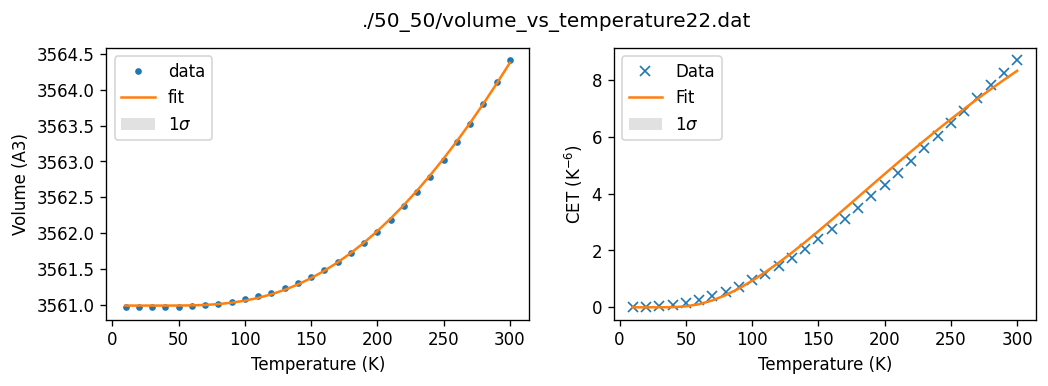

##################### ./50_50/volume_vs_temperature23.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36636
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00394534
    reduced chi-square = 1.5781e-04
    Akaike info crit   = -258.092545
    Bayesian info crit = -251.086559
[[Variables]]
    a0:  3557.84716 +/- 0.00363356 (0.00%) (init = 400)
    a1:  785.887593 +/- 62.2698071 (7.92%) (init = 100)
    a2:  0 (fixed)
    a3: -1100.89667 +/- 230.189794 (20.91%) (init = 0)
    a4:  4.99739494 +/- 0.08584942 (1.72%) (init = 0)
    a5:  0.04443345 +/- 0.00829265 (18.66%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5) =  0.986
    C(a1, a3) =  0.882
    C(a3, a5) =  0.796
    C(a0, a3) = -0.520
    C(a0, a1) = -0.294
    C(a0, a5) = -0.221
Cost: 0.0013109702499605191
---------- DE bounds ----------
a0 :         0	     3557.85	    8000
a1 :         0	    

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.4159515289773062 < 1e-05 at iteration 2 and prob(a3=-0.016117038085394598) = 0.00017497314745025774 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.5636374896884938 < 1e-05 at iteration 4 and prob(a3=-0.002302434012199227) = 0.00011952004988019468 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.2904264154736695 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00842  -0.00842  -0.008423557.85482  +0.00842  +0.00842  +0.00842
 a1: -69.29415 -47.84635 -28.19173 454.07027 +38.81843 +85.06318+143.87509
 a3:      -inf      -inf      -inf  -0.01151      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.63805  +1.34482  +3.60484  +7.73247
 a5:  -0.00347  -0.00224  -0.00112   0.03111  +0.00125  +0.00268  +0.00450
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2420
    # data points      = 30
    # variables        = 5
    chi-square         = 7.9844e-04
    reduced chi-square = 3.1938e-05
    Akaike info crit   = -306.021267
    Bayesian info crit = -299.015280
[[Variables]]
    a0:  3557.85482 +/- 0.00210569 (0.00%) (init = 3557.847)
    a1:  454.070270 +/- 35.6049608 (7.84%) (init = 785.8876)
    a2:  0 (fixed)
    a3: -0.01151217 +/- 152.520804 (1324865.80%) (init = -1100.897)
    a4: -4.63805021 +/- 1.03217154 (22.25

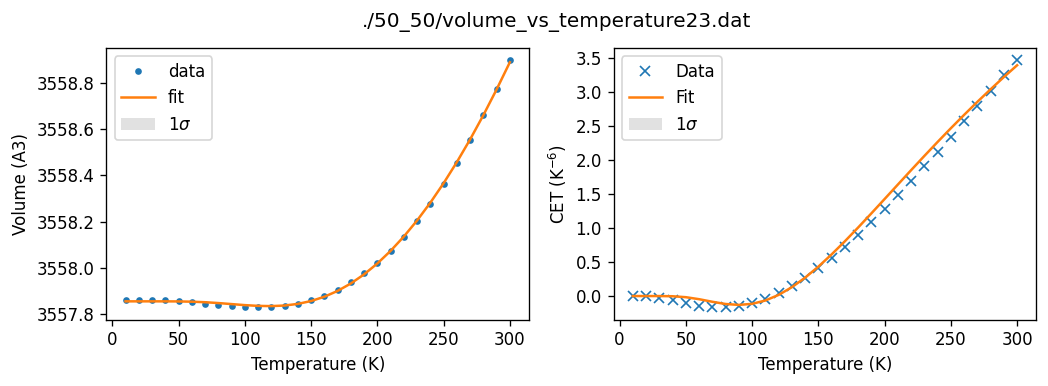

##################### ./50_50/volume_vs_temperature24.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33378
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00557049
    reduced chi-square = 2.2282e-04
    Akaike info crit   = -247.744087
    Bayesian info crit = -240.738100
[[Variables]]
    a0:  3574.98345 +/- 0.00845264 (0.00%) (init = 400)
    a1:  633.373821 +/- 134.721373 (21.27%) (init = 100)
    a2:  0 (fixed)
    a3:  1607.95569 +/- 1700.78147 (105.77%) (init = 0)
    a4: -3.52322913 +/- 1.51150459 (42.90%) (init = 0)
    a5:  0.05585330 +/- 0.00729226 (13.06%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.994
    C(a3, a5) =  0.945
    C(a1, a5) =  0.915
    C(a0, a1) =  0.851
    C(a0, a3) =  0.825
    C(a0, a5) =  0.766
    C(a0, a4) =  0.433
    C(a1, a4) =  0.406
    C(a3, a4) =  0.313
Cost: 0.0030961652187215805
---------- DE bo

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00192143231808915 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.987667676517908) = 0.2344371702530154 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01405  -0.01405  -0.014053574.97738  +0.00703  +0.00703  +0.00703
 a1:  -8.23278 -15.07108  -0.65503 506.66713 +14.57502 +57.38261+104.03283
 a3:-158.49716-126.83299-100.99120 684.67254+105.02935+108.13719 +78.92849
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00742  -0.00497  -0.00086   0.04980  +0.00040  +0.00227  +0.00031
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1208
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00289479
    reduced chi-square = 1.1579e-04
    Akaike info crit   = -267.381244
    Bayesian info crit = -260.375257
[[Variables]]
    a0:  3574.97738 +/- 0.00351273 (0.00%) (init = 3574.983)
    a1:  506.667132 +/- 30.7899916 (6.08%) (init = 633.3738)
    a2:  0 (fixed)
    a3:  684.672543 +/- 158.497158 (23.15%) (init = 1607.956)
    a4: -4.99999999 +/- 6.1355e-05 (0.00%) (ini

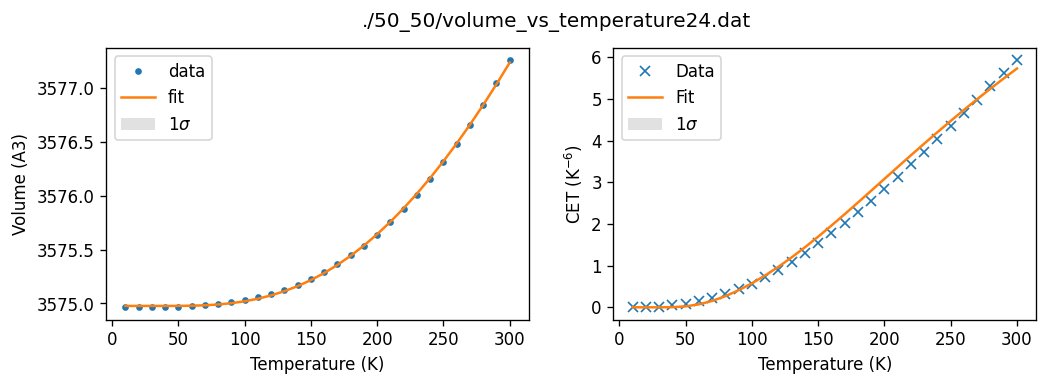

##################### ./50_50/volume_vs_temperature25.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 37578
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00276678
    reduced chi-square = 1.1067e-04
    Akaike info crit   = -268.738090
    Bayesian info crit = -261.732103
[[Variables]]
    a0:  3504.69970 +/- 0.00349648 (0.00%) (init = 400)
    a1:  631.418271 +/- 23.1745516 (3.67%) (init = 100)
    a2:  0 (fixed)
    a3:  823.505962 +/- 219.022579 (26.60%) (init = 0)
    a4: -1.83292125 +/- 1.78995568 (97.66%) (init = 0)
    a5:  0.04120912 +/- 0.00337729 (8.20%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.907
    C(a3, a5) =  0.840
    C(a3, a4) = -0.644
    C(a1, a4) =  0.420
    C(a0, a4) =  0.405
    C(a1, a3) =  0.400
    C(a0, a1) =  0.398
    C(a0, a5) = -0.208
    C(a0, a3) = -0.182
Cost: -0.004010078247119964
---------- DE bound

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00013289173510472546 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.994827034159896) = 0.2263402538242151 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00731  -0.00731  -0.007313504.69046  +0.00365  +0.00365  +0.00365
 a1:  -4.39616 -13.44582  -4.74497 488.29951 +17.95871 +28.02226 +28.16975
 a3: -59.55246 -82.16280 -69.16038 525.08861 +47.71752 +61.91324  +9.50967
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00510  -0.00176  -0.00155   0.03837  +0.00019  +0.00024  +0.00381
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1341
    # data points      = 30
    # variables        = 5
    chi-square         = 7.1364e-04
    reduced chi-square = 2.8545e-05
    Akaike info crit   = -309.390010
    Bayesian info crit = -302.384023
[[Variables]]
    a0:  3504.69046 +/- 0.00182666 (0.00%) (init = 3504.7)
    a1:  488.299508 +/- 28.1697501 (5.77%) (init = 631.4183)
    a2:  0 (fixed)
    a3:  525.088607 +/- 79.8441029 (15.21%) (init = 823.506)
    a4: -5.00000000 +/- 2.5736e-05 (0.00%) (init =

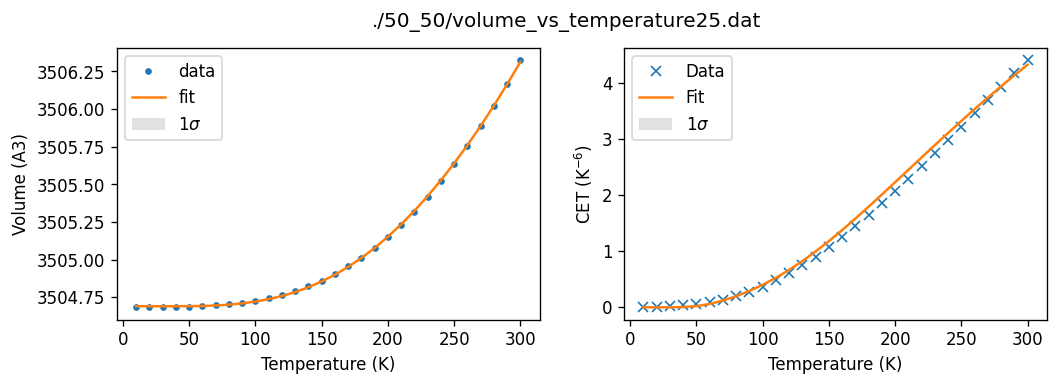

##################### ./50_50/volume_vs_temperature26.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 30888
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00981750
    reduced chi-square = 3.9270e-04
    Akaike info crit   = -230.743573
    Bayesian info crit = -223.737586
[[Variables]]
    a0:  3534.73497 +/- 0.00815930 (0.00%) (init = 400)
    a1:  314.355712 +/- 36.5903649 (11.64%) (init = 100)
    a2:  0 (fixed)
    a3:  336.474388 +/- 49.3680305 (14.67%) (init = 0)
    a4: -4.87744305 +/- 0.17217262 (3.53%) (init = 0)
    a5:  0.03764897 +/- 0.00246088 (6.54%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5) =  0.985
    C(a3, a5) =  0.896
    C(a1, a3) =  0.878
    C(a0, a5) =  0.443
    C(a0, a1) =  0.440
    C(a1, a4) =  0.346
    C(a0, a4) =  0.257
    C(a4, a5) =  0.201
    C(a0, a3) =  0.142
Cost: -0.013313585766354663
---------- DE bound

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00026589987880254224 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.998318472318009) = 0.09951910664498204 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.02490  -0.02490  -0.024903534.73973  +0.01245  +0.01245  +0.01245
 a1:  -2.42805 -30.98130 -10.37823 398.41615 +22.84108 +69.08188+109.35140
 a3: -28.43574-113.96459 -73.40250 553.38422 +81.22576 +81.82467 +57.21761
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00029  -0.00237  -0.00212   0.04386  +0.00038  +0.00225  +0.00033
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 596
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00705436
    reduced chi-square = 2.8217e-04
    Akaike info crit   = -240.659195
    Bayesian info crit = -233.653208
[[Variables]]
    a0:  3534.73973 +/- 0.00622621 (0.00%) (init = 3534.735)
    a1:  398.416153 +/- 32.3105795 (8.11%) (init = 314.3557)
    a2:  0 (fixed)
    a3:  553.384219 +/- 114.092285 (20.62%) (init = 336.4744)
    a4: -5.00000000 +/- 8.3658e-06 (0.00%) (init

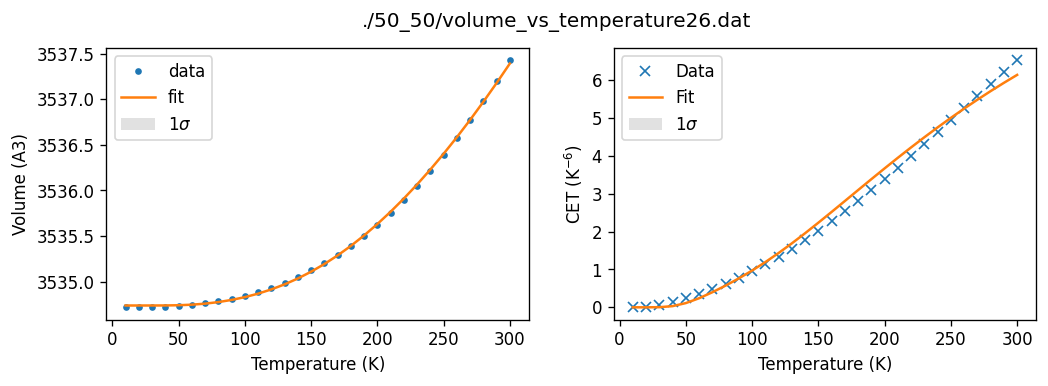

##################### ./50_50/volume_vs_temperature27.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35394
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00256547
    reduced chi-square = 1.0262e-04
    Akaike info crit   = -271.004306
    Bayesian info crit = -263.998319
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3535.83105 +/-        nan (nan%) (init = 400)
    a1:  700.942516 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -419.886900 +/-        nan (nan%) (init = 0)
    a4:  2.23400147 +/- 0.87927036 (39.36%) (init = 0)
    a5:  0.04632175 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Cost: 0.0022065205112085096
---------- DE bounds ----------
a0 :         0	     3535.83	    8000
a1 :         0	     700.943	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -419.887	    3000
a4 :        -5	       2.234	       5
a5 :     1e-05	   0.0463217	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0008586805735084827 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.888636046896069) = 0.11870523072862599 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00891  -0.00891  -0.008913535.84080  +0.00445  +0.00445  +0.00445
 a1:  -8.36028  -9.89325  -9.88094 485.77042 +14.41904 +16.74652 +16.74652
 a3:  -9.00116  -5.38904  -2.18481 -25.23181  +3.80655  +7.01089 +10.62291
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00017  -0.00008  -0.00003   0.04076  +0.00006  +0.00014  +0.00121
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2652
    # data points      = 30
    # variables        = 5
    chi-square         = 9.2486e-04
    reduced chi-square = 3.6994e-05
    Akaike info crit   = -301.611913
    Bayesian info crit = -294.605926
[[Variables]]
    a0:  3535.84080 +/- 0.00222688 (0.00%) (init = 3535.831)
    a1:  485.770423 +/- 16.7465168 (3.45%) (init = 700.9425)
    a2:  0 (fixed)
    a3: -25.2318087 +/- 13.9398539 (55.25%) (init = -419.8869)
    a4: -4.99999999 +/- 5.5405e-04 (0.01%) (in

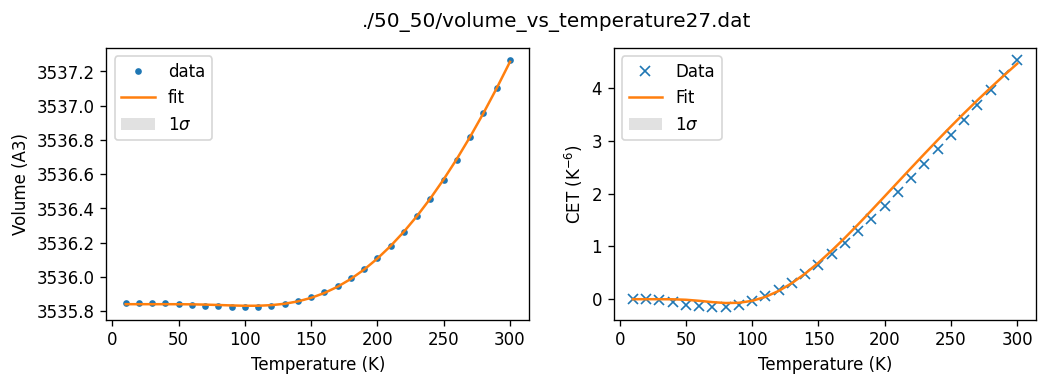

##################### ./50_50/volume_vs_temperature28.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32532
    # data points      = 30
    # variables        = 5
    chi-square         = 8.6687e-04
    reduced chi-square = 3.4675e-05
    Akaike info crit   = -303.554734
    Bayesian info crit = -296.548748
[[Variables]]
    a0:  3547.52877 +/- 0.00189956 (0.00%) (init = 400)
    a1:  631.817786 +/- 29.0886926 (4.60%) (init = 100)
    a2:  0 (fixed)
    a3:  814.757580 +/- 207.953044 (25.52%) (init = 0)
    a4: -3.55910738 +/- 0.96150901 (27.02%) (init = 0)
    a5:  0.05391613 +/- 0.00235650 (4.37%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.917
    C(a1, a3) =  0.859
    C(a1, a5) =  0.650
    C(a1, a4) =  0.446
    C(a4, a5) = -0.380
    C(a0, a4) =  0.380
    C(a0, a1) =  0.335
Cost: -0.004279416648842016
---------- DE bounds ----------
a0 :         0	     3547.53	    8

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00574  -0.00574  -0.005743547.52758  +0.00574  +0.00574  +0.00574
 a1: -70.22232 -43.90623 -19.35368 605.63589 +31.36246 +57.26892 +86.09294
 a3:-349.35158-242.00652-117.36886 799.14827+232.25520+469.26542+789.35648
 a4:      -inf      -inf      -inf  -4.99930  +0.11954  +0.48098  +1.16471
 a5:  -0.00602  -0.00376  -0.00164   0.05469  +0.00264  +0.00474  +0.00696
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 563
    # data points      = 30
    # variables        = 5
    chi-square         = 5.5787e-04
    reduced chi-square = 2.2315e-05
    Akaike info crit   = -316.777501
    Bayesian info crit = -309.771514
[[Variables]]
    a0:  3547.52758 +/- 0.00143493 (0.00%) (init = 3547.529)
    a1:  605.635895 +/- 24.0281819 (3.97%) (init = 631.8178)
    a2:  0 (fixed)
    a3:  799.148275 +/- 157.263633 (19.68%) (init = 814.7576)
    a4: -4.99929717 +/- 0.01700172 (0.34%) (init

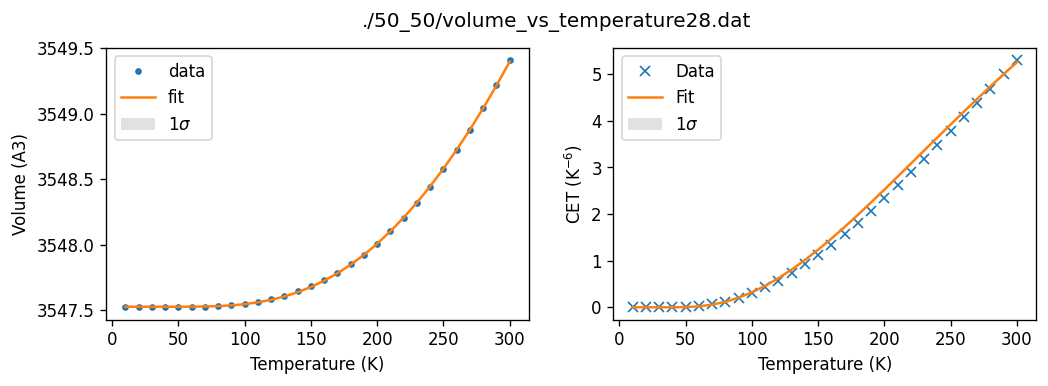

##################### ./50_50/volume_vs_temperature29.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35298
    # data points      = 30
    # variables        = 5
    chi-square         = 1.9688e-04
    reduced chi-square = 7.8753e-06
    Akaike info crit   = -348.022908
    Bayesian info crit = -341.016921
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3583.88798 +/- 7.9872e-04 (0.00%) (init = 400)
    a1:  810.980563 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2562.91493 +/-        nan (nan%) (init = 0)
    a4: -2.41089670 +/- 0.48412787 (20.08%) (init = 0)
    a5:  0.05962700 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, a4) =  1.636


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.0024348941365133214
---------- DE bounds ----------
a0 :         0	     3583.89	    8000
a1 :         0	     810.981	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2562.91	    3000
a4 :        -5	     -2.4109	       5
a5 :     1e-05	    0.059627	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0004969940265010861 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.028343663296592877 < 1e-05 at iteration 22 and prob(a4=-4.999621001267481) = 0.017861953971358323 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00280  -0.00280  -0.002803583.88686  +0.00140  +0.00140  +0.00140
 a1: -44.44146 -26.42828 -15.41671 782.46306 +14.60206 +29.09812 +38.27289
 a3:-511.64148-509.23049-296.969332343.17042+199.06634+255.71566+127.39848
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00029  -0.00231  -0.00151   0.06362  +0.00051  +0.00077  +0.00077
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1827
    # data points      = 30
    # variables        = 5
    chi-square         = 1.1741e-04
    reduced chi-square = 4.6964e-06
    Akaike info crit   = -363.530784
    Bayesian info crit = -356.524797
[[Variables]]
    a0:  3583.88686 +/- 6.9933e-04 (0.00%) (init = 3583.888)
    a1:  782.463062 +/- 14.8345587 (1.90%) (init = 810.9806)
    a2:  0 (fixed)
    a3:  2343.17042 +/- 255.820738 (10.92%) (init = 2562.915)
    a4: -5.00000000 +/- 1.7227e-05 (0.00%) (ini

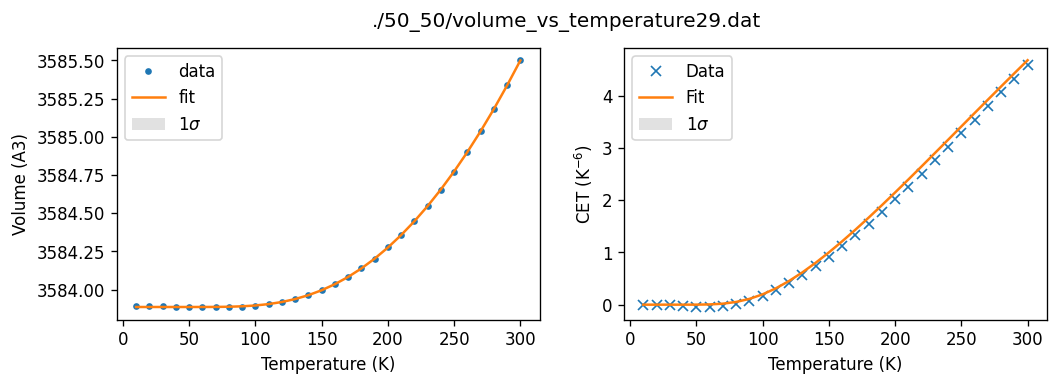

In [8]:
from glob import glob
import numpy as np
from uncertainties import correlated_values
import uncertainties.unumpy as unp
from uncertainties import ufloat

X_fit = []
Y_fit = []
Z_fit = []
X_data = []
Y_data = []
Z_data = []

folder = '50_50'

print('{0:#^100}'.format(' Shrink '))

for i in range(30):
    
    file = f'./{folder}/volume_vs_temperature{i:02d}.dat'
    
    print('{0:#^80}'.format(' '+str(file)+' '))
            
    M = np.genfromtxt(file)
    temperature = M[:,0]
    volume = M[:,1]
    
    cte_data = CET_numerical(temperature, volume)
    
    result0 = fit_volume_vs_temperature(temperature, volume, cte_data)
    result = second_fit(temperature, volume, cte_data, result0)
    
    has_uncertainties = False
    
    t_fit = np.array(temperature)
    
    if not np.any(np.diag(result.covar) < 0):
        has_uncertainties = True        
    else:
        print('!!!!!!!!!!!!!! Negative variances. Running Nelder-Mead.')
        result = second_fit(temperature, volume, cte_data, result)
        if np.any(np.diag(result.covar) >= 0):
            has_uncertainties = True
    
    
    (a0, a1, a2, a3, a4, a5, a6, a7, a8) = [result.params[k].value for k in result.params.keys()]
    
    if has_uncertainties:
        try:
            (a0, a1, a3, a4, a5) = correlated_values([a0, a1, a3, a4, a5], result.covar)
        except Exception as e:
            print("The execption", e.__class__, "occurred when trying to construct correlated variables a0, a1, a4, a4, a5.")
            print("Ignoring correlation and treating variables as independent")
            a0 = ufloat(a0,np.sqrt(np.diag(result.covar)[0]))
            a1 = ufloat(a1,np.sqrt(np.diag(result.covar)[1]))
            a3 = ufloat(a3,np.sqrt(np.diag(result.covar)[2]))
            a4 = ufloat(a4,np.sqrt(np.diag(result.covar)[3]))
            a5 = ufloat(a5,np.sqrt(np.diag(result.covar)[4]))
        
        v_fit = volume_fcn_unc(t_fit, a0, a1, a2, a3, a4, a5, a6, a7, a8)
        v_nominal = np.array([x.nominal_value for x in v_fit])
        v_unc = np.array([x.std_dev for x in v_fit])
        
        cte_fit = CET_fcn_unc(t_fit, a0, a1, a2, a3, a4, a5, a6, a7, a8)
        cte_nominal = np.array([x.nominal_value for x in cte_fit])
        cte_unc = np.array([x.std_dev for x in cte_fit])
        
        plot_unc(temperature, volume, t_fit, v_nominal, v_unc, cte_data, cte_nominal, cte_unc, file)
        
    else:
        v_nominal = volume_fcn(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
        v_unc = np.zeros(len(v_nominal))
        
        cte_nominal = CET_fcn_unc(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
        cte_unc = np.zeros(len(v_nominal))
        
        plot(temperature, volume, t_fit, v_nominal, cte_data, cte_nominal, file)
            
    with open(file.rstrip('dat')+'fit','w') as f:
        f.write('#{T:5}\t{V:10}\t{Vfit:10}\t{Vunc:10}\t{CET:10}\t{CETfit:10}\t{CETunc:10}\n'.format(T='T(K)',V='V(A3)',Vfit='Vfit(A3)',Vunc='Vunc(A3)',CET='CET(1/K)',CETfit='CETfit(1/K)',CETunc='CETunc(1/K)'))
        for i in range(len(temperature)):
            f.write('{T:5.1f}\t{V:10f}\t{Vfit:10f}\t{Vunc:10f}\t{CET: 10e}\t{CETfit: 10e}\t{CETunc: 10e}\n'.format(T=temperature[i],V=volume[i],Vfit=v_nominal[i],Vunc=v_unc[i],CET=cte_data[i],CETfit=cte_nominal[i],CETunc=cte_unc[i]))
    


In [25]:
with open('sp2_50_50.txt','w') as f:
    for i in range(30):
        A = np.genfromtxt(f'./50_50/volume_vs_temperature{i:02d}.fit')
        cet100 = A[9,5]
        cet300 = A[29,5]
        f.write(f'{i:02d}\t{cet100:0.6e}\t{cet300:0.6e}\n')

# 60% - 40%

############################################## Shrink ##############################################
##################### ./60_40/volume_vs_temperature00.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 31710
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00162711
    reduced chi-square = 6.5084e-05
    Akaike info crit   = -284.664448
    Bayesian info crit = -277.658461
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3660.20411 +/-        nan (nan%) (init = 400)
    a1:  562.577766 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  714.558611 +/- 190.684296 (26.69%) (init = 0)
    a4: -4.27812966 +/-        nan (nan%) (init = 0)
    a5:  0.04750930 +/- 0.00132509 (2.79%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  1.742


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Cost: 0.004311344800044026
---------- DE bounds ----------
a0 :         0	      3660.2	    8000
a1 :         0	     562.578	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     714.559	    3000
a4 :        -5	    -4.27813	       5
a5 :     1e-05	   0.0475093	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0006714817528308785 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.9975592587821085) = 0.11685222871481458 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00909  -0.00909  -0.009093660.20361  +0.00682  +0.00682  +0.00682
 a1: -27.14664  -1.04391 -12.26144 541.24478  +0.40486 +11.87343 +28.82812
 a3: -13.67876-140.05876 -43.99743 674.67007+111.71910+117.09389 +17.51141
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00435  -0.00428  -0.00005   0.04758  +0.00008  +0.00202  +0.00056
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 735
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00126869
    reduced chi-square = 5.0748e-05
    Akaike info crit   = -292.129074
    Bayesian info crit = -285.123087
[[Variables]]
    a0:  3660.20361 +/- 0.00227198 (0.00%) (init = 3660.204)
    a1:  541.244780 +/- 28.8281156 (5.33%) (init = 562.5778)
    a2:  0 (fixed)
    a3:  674.670075 +/- 140.272490 (20.79%) (init = 714.5586)
    a4: -5.00000000 +/- 1.2143e-05 (0.00%) (init

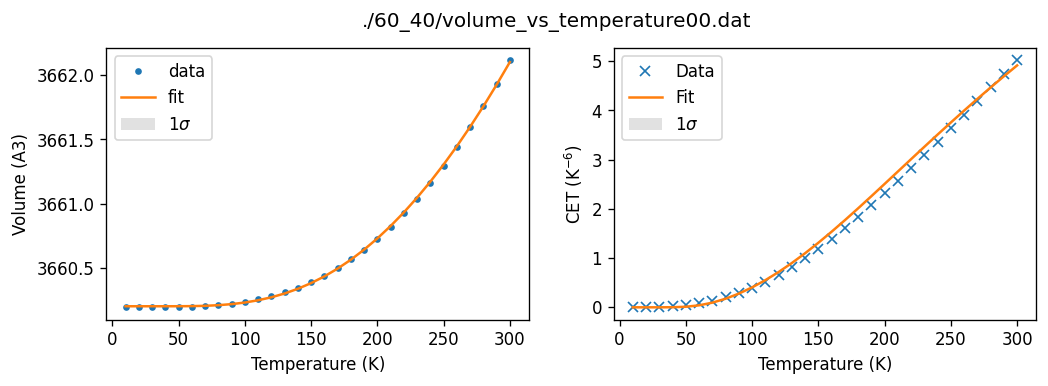

##################### ./60_40/volume_vs_temperature01.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 31932
    # data points      = 30
    # variables        = 5
    chi-square         = 5.0383e-04
    reduced chi-square = 2.0153e-05
    Akaike info crit   = -319.833917
    Bayesian info crit = -312.827930
[[Variables]]
    a0:  3629.04500 +/- 0.00150128 (0.00%) (init = 400)
    a1:  783.268219 +/- 17.1511000 (2.19%) (init = 100)
    a2:  0 (fixed)
    a3:  1791.41093 +/- 408.839186 (22.82%) (init = 0)
    a4:  0.27440966 +/- 2.89416549 (1054.69%) (init = 0)
    a5:  0.05915511 +/- 0.00560425 (9.47%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.978
    C(a3, a5) =  0.789
    C(a3, a4) = -0.673
    C(a1, a3) =  0.526
    C(a0, a4) =  0.504
    C(a0, a5) = -0.415
    C(a0, a1) =  0.382
    C(a1, a4) =  0.269
    C(a0, a3) = -0.196
Cost: -0.0026411483763695287
---------- DE bo

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00337  -0.00337  -0.003373629.04209  +0.00337  +0.00337  +0.00337
 a1:-103.91517 -59.68560 -30.10504 736.73002 +17.70604 +36.25265 +55.79269
 a3:-1045.70102-683.77974-370.926321732.55900+265.61432+572.65536+938.40377
 a4:      -inf      -inf      -inf  -4.95494  +0.35737  +1.24047  +2.45869
 a5:  -0.00950  -0.00533  -0.00227   0.06594  +0.00139  +0.00264  +0.00384
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 857
    # data points      = 30
    # variables        = 5
    chi-square         = 1.6664e-04
    reduced chi-square = 6.6657e-06
    Akaike info crit   = -353.025582
    Bayesian info crit = -346.019595
[[Variables]]
    a0:  3629.04209 +/- 8.4322e-04 (0.00%) (init = 3629.045)
    a1:  736.730016 +/- 22.2141594 (3.02%) (init = 783.2682)
    a2:  0 (fixed)
    a3:  1732.55900 +/- 311.109544 (17.96%) (init = 1791.411)
    a4: -4.95494067 +/- 0.20679830 (4.17%) (ini

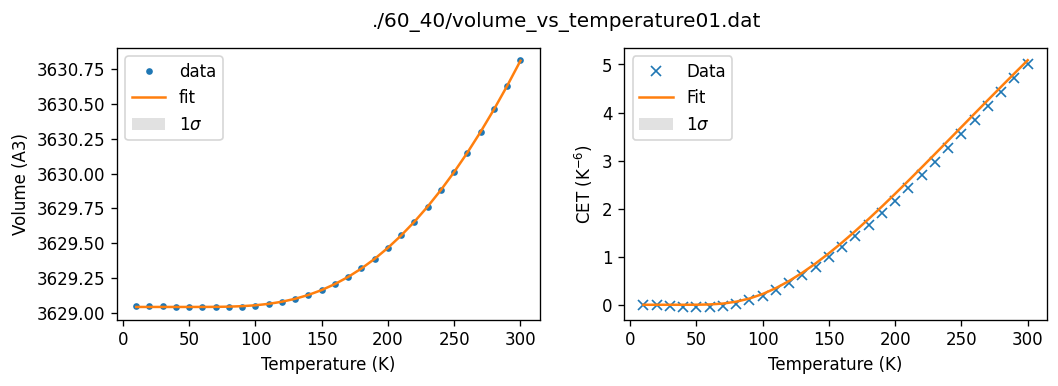

##################### ./60_40/volume_vs_temperature02.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34740
    # data points      = 30
    # variables        = 5
    chi-square         = 7.9640e-04
    reduced chi-square = 3.1856e-05
    Akaike info crit   = -306.098144
    Bayesian info crit = -299.092157
[[Variables]]
    a0:  3650.43658 +/- 0.00220165 (0.00%) (init = 400)
    a1:  506.970455 +/- 33.6384824 (6.64%) (init = 100)
    a2:  0 (fixed)
    a3:  331.127856 +/- 79.6638044 (24.06%) (init = 0)
    a4: -2.44933654 +/- 1.05365313 (43.02%) (init = 0)
    a5:  0.03806083 +/- 0.00136153 (3.58%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.956
    C(a1, a4) =  0.822
    C(a0, a4) =  0.600
    C(a0, a1) =  0.485
    C(a1, a3) =  0.444
    C(a1, a5) =  0.341
    C(a4, a5) = -0.251
    C(a0, a3) = -0.179
    C(a3, a4) = -0.138
    C(a0, a5) = -0.124
Cost: -0.006189202300447

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.996576836962379) = 0.28599843676734477 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00233  -0.00233  -0.002333650.43368  +0.00058  +0.00058  +0.00058
 a1:  -0.49920  -0.31587  -0.20814 523.62018  +0.01309 +20.23263 +35.58808
 a3:-107.64693 -95.04381  -0.07454 703.27885  +1.77774 +44.95128  +3.98769
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00150  -0.00142  -0.00000   0.04456  +0.00003  +0.00004  +0.00006
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1390
    # data points      = 30
    # variables        = 5
    chi-square         = 6.8783e-05
    reduced chi-square = 2.7513e-06
    Akaike info crit   = -379.572388
    Bayesian info crit = -372.566401
[[Variables]]
    a0:  3650.43368 +/- 5.8195e-04 (0.00%) (init = 3650.437)
    a1:  523.620182 +/- 11.3176302 (2.16%) (init = 506.9705)
    a2:  0 (fixed)
    a3:  703.278850 +/- 53.9581423 (7.67%) (init = 331.1279)
    a4: -5.00000000 +/- 1.7031e-05 (0.00%) (init

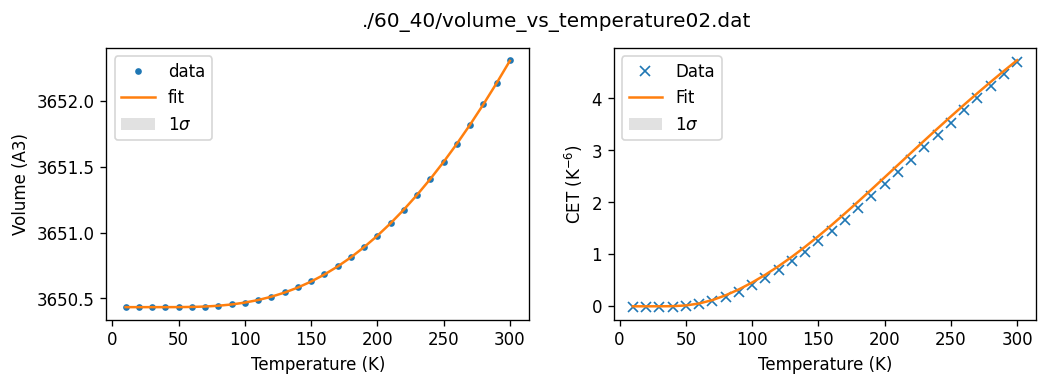

##################### ./60_40/volume_vs_temperature03.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36084
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00184701
    reduced chi-square = 7.3880e-05
    Akaike info crit   = -280.861539
    Bayesian info crit = -273.855552
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3649.53328 +/- 0.00220771 (0.00%) (init = 400)
    a1:  762.239458 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2260.88431 +/-        nan (nan%) (init = 0)
    a4: -3.76854929 +/- 1.28484026 (34.09%) (init = 0)
    a5:  0.05198059 +/- 0.00217015 (4.17%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.054
    C(a0, a5) = -0.381
    C(a0, a4) =  0.289


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.0027594615412454004
---------- DE bounds ----------
a0 :         0	     3649.53	    8000
a1 :         0	     762.239	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2260.88	    3000
a4 :        -5	    -3.76855	       5
a5 :     1e-05	   0.0519806	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00578  -0.00578  -0.005783649.52829  +0.00578  +0.00578  +0.00578
 a1: -94.35959 -64.24919 -36.54821 572.72220 +23.87605 +53.77114 +87.58185
 a3:-274.74292-211.46686-134.51490 647.71791+114.04242+288.91987+539.23931
 a4:      -inf      -inf      -inf  -4.99329  +0.09378  +0.38104  +0.93565
 a5:  -0.00633  -0.00433  -0.00246   0.04392  +0.00165  +0.00365  +0.00583
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 941
    # data points      = 30
    # variables        = 5
    chi-square         = 5.2692e-04
    reduced chi-square = 2.1077e-05
    Akaike info crit   = -318.489927
    Bayesian info crit = -311.483940
[[Variables]]
    a0:  3649.52829 +/- 0.00144620 (0.00%) (init = 3649.533)
    a1:  572.722205 +/- 27.5883614 (4.82%) (init = 762.2395)
    a2:  0 (fixed)
    a3:  647.717910 +/- 118.559526 (18.30%) (init = 2260.884)
    a4: -4.99328720 +/- 0.05093333 (1.02%) (init

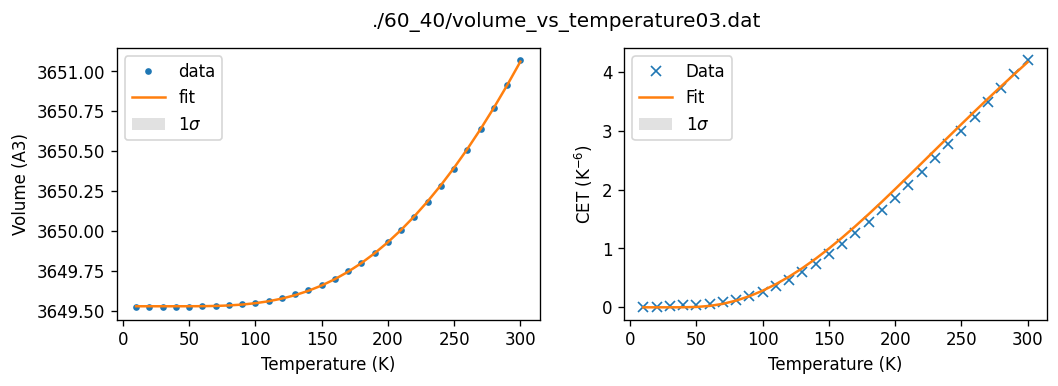

##################### ./60_40/volume_vs_temperature04.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33774
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00190644
    reduced chi-square = 7.6258e-05
    Akaike info crit   = -279.911441
    Bayesian info crit = -272.905454
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3595.22189 +/- 0.00309373 (0.00%) (init = 400)
    a1:  548.214907 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -1369.57658 +/-        nan (nan%) (init = 0)
    a4:  3.04097411 +/-        nan (nan%) (init = 0)
    a5:  0.01445909 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.0027275439920231292
---------- DE bounds ----------
a0 :         0	     3595.22	    8000
a1 :         0	     548.215	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -1369.58	    3000
a4 :        -5	     3.04097	       5
a5 :     1e-05	   0.0144591	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.5848944306370906 < 1e-05 at iteration 3 and prob(a3=-0.00548303285388829) = 0.0002009310000423314 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.5741471391007065 < 1e-05 at iteration 2 and prob(a3=-0.0004830328538882895) = 0.00018496002300233638 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.062447409831389473 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0012240359994045839 < 1e-05 at iteration 4 and prob(a5=0.01830324885464902) = 0.9958030671755488 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01018  -0.01018  -0.010183595.22474  +0.01018  +0.01018  +0.01018
 a1: -76.08466 -46.36151 -22.52237 409.47977 +32.18846 +68.41537+111.02380
 a3:      -inf      -inf      -inf  -0.00248      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.94887  +0.87190  +2.33666  +2.83749
 a5:      -inf  -0.00205  -0.00099   0.02239  +0.00104  +0.00215  +0.00349
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1781
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00109144
    reduced chi-square = 4.3658e-05
    Akaike info crit   = -296.643622
    Bayesian info crit = -289.637635
[[Variables]]
    a0:  3595.22474 +/- 0.00254418 (0.00%) (init = 3595.222)
    a1:  409.479772 +/- 30.5285246 (7.46%) (init = 548.2149)
    a2:  0 (fixed)
    a3: -0.00248303 +/- 141.344042 (5692395.16%) (init = -1369.577)
    a4: -4.94887144 +/- 0.68029998 (13.75

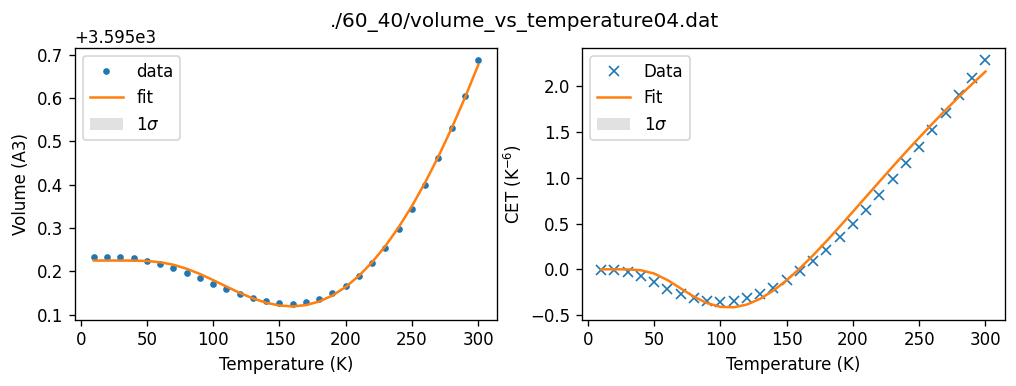

##################### ./60_40/volume_vs_temperature05.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32670
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00261856
    reduced chi-square = 1.0474e-04
    Akaike info crit   = -270.389844
    Bayesian info crit = -263.383857
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3661.46676 +/- 0.00287468 (0.00%) (init = 400)
    a1:  654.832737 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  1332.71253 +/-        nan (nan%) (init = 0)
    a4: -4.12958743 +/- 0.98522335 (23.86%) (init = 0)
    a5:  0.04858914 +/- 0.00131386 (2.70%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.575
    C(a0, a5) = -0.447
    C(a0, a4) =  0.165


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.0038759960270908778
---------- DE bounds ----------
a0 :         0	     3661.47	    8000
a1 :         0	     654.833	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     1332.71	    3000
a4 :        -5	    -4.12959	       5
a5 :     1e-05	   0.0485891	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.988415465828063) = 0.248263338781607 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00986  -0.00986  -0.009863661.46442  +0.00493  +0.00493  +0.00493
 a1: -31.74395  -1.25675  -0.67171 530.05890 +29.96148 +72.02531+113.63345
 a3:-127.55973-110.52029-106.81561 594.48841 +26.29107 +31.50626 +15.71559
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00230  -0.00231  -0.00133   0.04292  +0.00008  +0.00016  +0.00231
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1025
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00145517
    reduced chi-square = 5.8207e-05
    Akaike info crit   = -288.014948
    Bayesian info crit = -281.008961
[[Variables]]
    a0:  3661.46442 +/- 0.00246421 (0.00%) (init = 3661.467)
    a1:  530.058897 +/- 33.6351134 (6.35%) (init = 654.8327)
    a2:  0 (fixed)
    a3:  594.488405 +/- 127.559735 (21.46%) (init = 1332.713)
    a4: -4.99999999 +/- 5.7634e-05 (0.00%) (ini

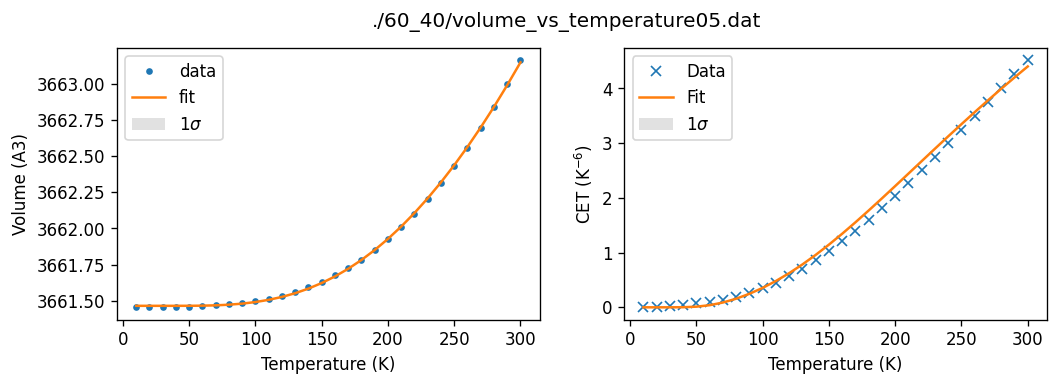

##################### ./60_40/volume_vs_temperature06.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32034
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00137061
    reduced chi-square = 5.4824e-05
    Akaike info crit   = -289.810887
    Bayesian info crit = -282.804900
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3694.14326 +/- 0.00234599 (0.00%) (init = 400)
    a1:  613.985696 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -707.539407 +/-        nan (nan%) (init = 0)
    a4:  2.23550771 +/-        nan (nan%) (init = 0)
    a5:  0.03643570 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.004178704768492025
---------- DE bounds ----------
a0 :         0	     3694.14	    8000
a1 :         0	     613.986	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -707.539	    3000
a4 :        -5	     2.23551	       5
a5 :     1e-05	   0.0364357	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.620016032567647 < 1e-05 at iteration 2 and prob(a3=0.001247212269798183) = 0.000218880468868408 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.17109000690779694 < 1e-05 at iteration 2 and prob(a3=0.005247212269798183) = 0.0002088094034017069 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.16858883729577923 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01001  -0.01001  -0.010013694.14468  +0.01001  +0.01001  +0.01001
 a1: -73.36433 -51.08716 -29.80904 490.02082 +54.66513+129.64021+193.80961
 a3:      -inf      -inf      -inf   0.00325      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.65473  +1.55322  +1.71526  +1.71526
 a5:  -0.00508  -0.00334  -0.00170   0.03932  +0.00197  +0.00443  +0.00793
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1505
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00116207
    reduced chi-square = 4.6483e-05
    Akaike info crit   = -294.762471
    Bayesian info crit = -287.756485
[[Variables]]
    a0:  3694.14468 +/- 0.00250257 (0.00%) (init = 3694.143)
    a1:  490.020816 +/- 48.4577105 (9.89%) (init = 613.9857)
    a2:  0 (fixed)
    a3:  0.00324721 +/- 202.487963 (6235747.67%) (init = -707.5394)
    a4: -4.65472848 +/- 1.71525698 (36.85

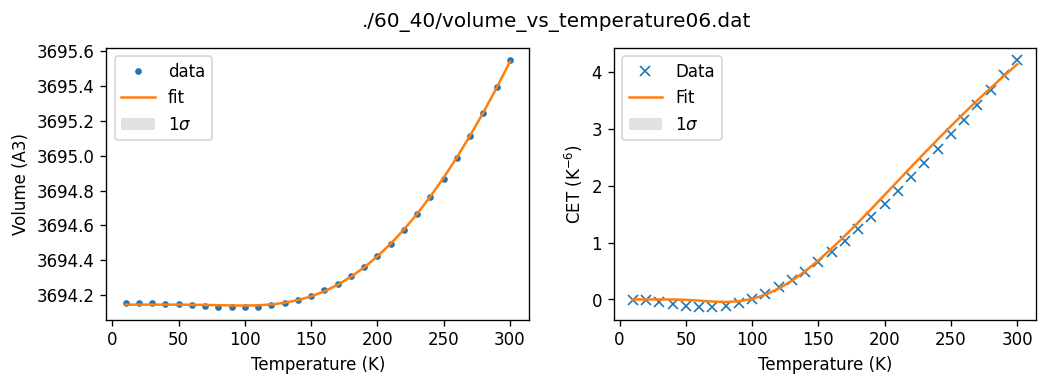

##################### ./60_40/volume_vs_temperature07.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35484
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00261398
    reduced chi-square = 1.0456e-04
    Akaike info crit   = -270.442335
    Bayesian info crit = -263.436348
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3600.54933 +/- 0.00274430 (0.00%) (init = 400)
    a1:  657.111330 +/- 25.1606788 (3.83%) (init = 100)
    a2:  0 (fixed)
    a3:  384.052772 +/- 277.782151 (72.33%) (init = 0)
    a4:  1.86833186 +/-        nan (nan%) (init = 0)
    a5:  0.03117092 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  1.460
    C(a0, a1) = -0.203


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.003074455964451772
---------- DE bounds ----------
a0 :         0	     3600.55	    8000
a1 :         0	     657.111	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     384.053	    3000
a4 :        -5	     1.86833	       5
a5 :     1e-05	   0.0311709	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0003070323788753265 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.9984869290199825) = 0.13276129207678378 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00544  -0.00544  -0.005443600.54187  +0.00272  +0.00272  +0.00272
 a1:  -1.28321  -0.85787  -0.47150 511.48873 +27.72608 +54.80695 +54.97893
 a3:-143.59540-114.87190 -42.81588 517.28171  +3.00250 +62.08798  +8.89795
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00106  -0.00130  -0.00002   0.03680  +0.00005  +0.00148  +0.00159
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1455
    # data points      = 30
    # variables        = 5
    chi-square         = 4.0454e-04
    reduced chi-square = 1.6182e-05
    Akaike info crit   = -326.418523
    Bayesian info crit = -319.412536
[[Variables]]
    a0:  3600.54187 +/- 0.00135972 (0.00%) (init = 3600.549)
    a1:  511.488726 +/- 27.4894652 (5.37%) (init = 657.1113)
    a2:  0 (fixed)
    a3:  517.281708 +/- 71.9542923 (13.91%) (init = 384.0528)
    a4: -5.00000000 +/- 7.5277e-06 (0.00%) (ini

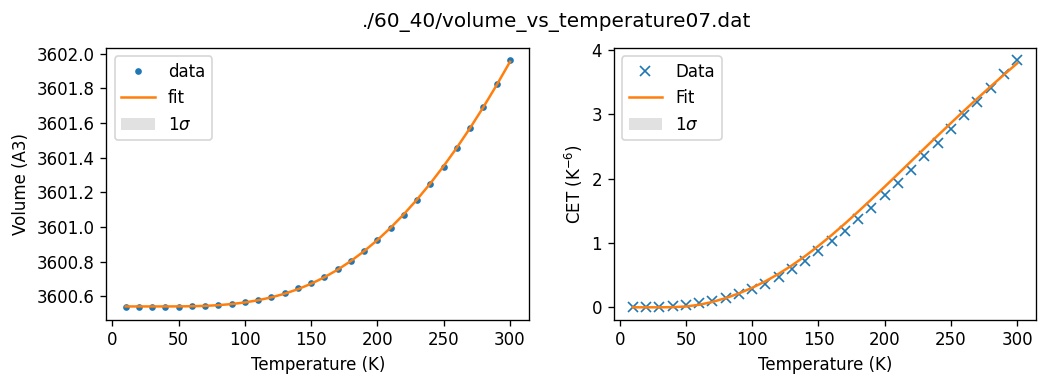

##################### ./60_40/volume_vs_temperature08.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 31722
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00422294
    reduced chi-square = 1.6892e-04
    Akaike info crit   = -256.052634
    Bayesian info crit = -249.046647
[[Variables]]
    a0:  3670.73897 +/- 0.00547784 (0.00%) (init = 400)
    a1:  407.856956 +/- 30.7075295 (7.53%) (init = 100)
    a2:  0 (fixed)
    a3: -456.214318 +/- 239.733397 (52.55%) (init = 0)
    a4: -2.97310645 +/- 1.28089249 (43.08%) (init = 0)
    a5:  0.02406702 +/- 0.00142488 (5.92%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.974
    C(a1, a3) = -0.950
    C(a1, a4) =  0.866
    C(a4, a5) = -0.586
    C(a0, a1) = -0.522
    C(a3, a5) =  0.392
    C(a0, a3) =  0.362
    C(a0, a4) = -0.295
    C(a0, a5) = -0.198
    C(a1, a5) = -0.110
Cost: -0.007764713756387

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00037867737744358865 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.991114856650905) = 0.08763424725594149 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01898  -0.01898  -0.018983670.73657  +0.00949  +0.00949  +0.00949
 a1:  -7.59373 -11.56813 -11.55679 388.89080  +2.00492  +4.48401  +7.31818
 a3: -12.50363 -53.20912 -42.41118-166.96842 +35.35276 +36.55703 +12.94924
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00244  -0.00231  -0.00028   0.02716  +0.00007  +0.00014  +0.00021
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1171
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00342416
    reduced chi-square = 1.3697e-04
    Akaike info crit   = -262.342880
    Bayesian info crit = -255.336893
[[Variables]]
    a0:  3670.73657 +/- 0.00474526 (0.00%) (init = 3670.739)
    a1:  388.890797 +/- 17.9106517 (4.61%) (init = 407.857)
    a2:  0 (fixed)
    a3: -166.968423 +/- 56.3613782 (33.76%) (init = -456.2143)
    a4: -5.00000000 +/- 4.4205e-05 (0.00%) (ini

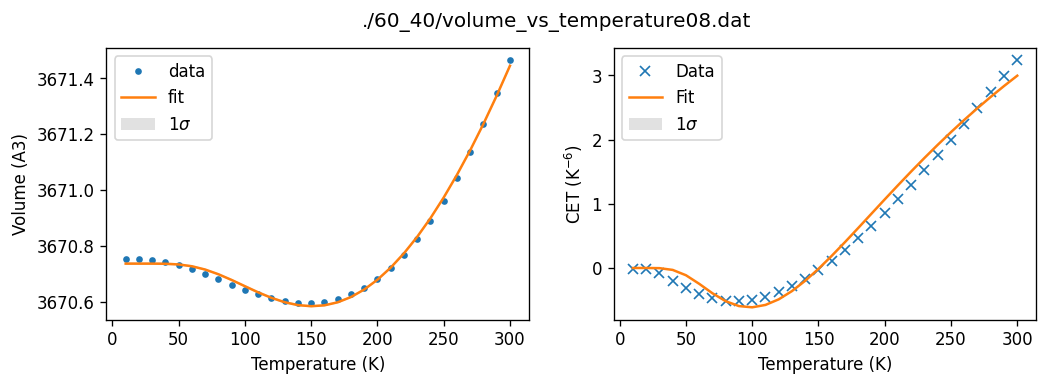

##################### ./60_40/volume_vs_temperature09.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 23040
    # data points      = 30
    # variables        = 5
    chi-square         = 4.3928e-04
    reduced chi-square = 1.7571e-05
    Akaike info crit   = -323.947167
    Bayesian info crit = -316.941180
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3681.70923 +/- 0.00114726 (0.00%) (init = 400)
    a1:  738.343083 +/- 21.4719285 (2.91%) (init = 100)
    a2:  0 (fixed)
    a3:  307.125024 +/- 254.473818 (82.86%) (init = 0)
    a4:  3.15166305 +/-        nan (nan%) (init = 0)
    a5:  0.05014290 +/- 0.00179836 (3.59%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5) =  1.546
    C(a1, a3) =  1.121
    C(a3, a5) =  1.090
    C(a0, a1) = -0.173
    C(a0, a5) =  0.157
    C(a0, a3) = -0.117


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.002950603005956509
---------- DE bounds ----------
a0 :         0	     3681.71	    8000
a1 :         0	     738.343	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     307.125	    3000
a4 :        -5	     3.15166	       5
a5 :     1e-05	   0.0501429	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.08258009231061447 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00377  -0.00377  -0.003773681.70784  +0.00377  +0.00377  +0.00377
 a1:-159.93102 -63.99998 -21.66176 834.17337 +10.07066 +18.52831 +28.83186
 a3:-2483.75253-1476.86442-498.274622877.03685      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.98470  +1.26575  +4.06969  +6.99721
 a5:  -0.01924  -0.01072  -0.00312   0.07306  +0.00082  +0.00136  +0.00198
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1409
    # data points      = 30
    # variables        = 5
    chi-square         = 2.3630e-04
    reduced chi-square = 9.4520e-06
    Akaike info crit   = -342.548211
    Bayesian info crit = -335.542224
[[Variables]]
    a0:  3681.70784 +/- 9.4344e-04 (0.00%) (init = 3681.709)
    a1:  834.173366 +/- 19.7663995 (2.37%) (init = 738.3431)
    a2:  0 (fixed)
    a3:  2877.03685 +/- 432.503991 (15.03%) (init = 307.125)
    a4: -4.98470069 +/- 0.32011034 (6.42%) (in

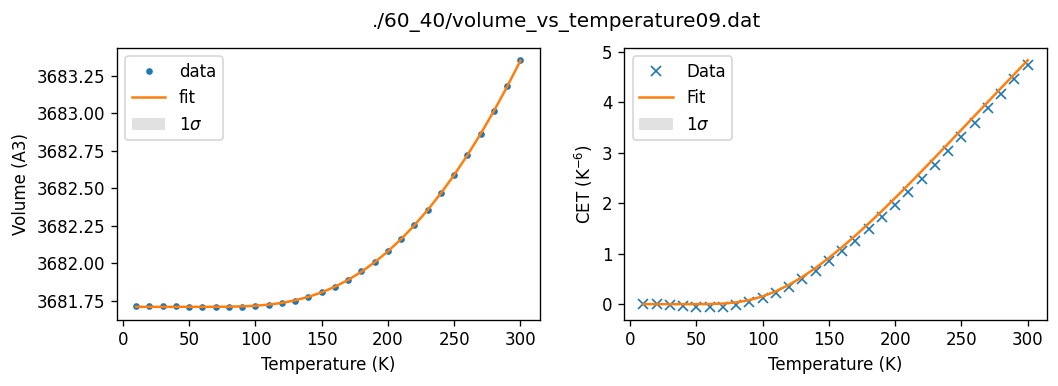

##################### ./60_40/volume_vs_temperature10.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 38868
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00111527
    reduced chi-square = 4.4611e-05
    Akaike info crit   = -295.995664
    Bayesian info crit = -288.989677
[[Variables]]
    a0:  3602.81525 +/- 0.00206661 (0.00%) (init = 400)
    a1:  832.673522 +/- 190.809660 (22.92%) (init = 100)
    a2:  0 (fixed)
    a3:  1384.59896 +/- 4109.07442 (296.77%) (init = 0)
    a4:  4.72510994 +/- 2.49284319 (52.76%) (init = 0)
    a5:  0.05964659 +/- 0.01715975 (28.77%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.998
    C(a3, a5) =  0.981
    C(a1, a5) =  0.969
    C(a4, a5) = -0.730
    C(a3, a4) = -0.597
    C(a1, a4) = -0.545
    C(a0, a1) =  0.447
    C(a0, a3) =  0.427
    C(a0, a5) =  0.412
    C(a0, a4) = -0.100
Cost: 0.0022807843706

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0014389670708461469 < 1e-05 at iteration 7 and prob(a1=756.7126525171816) = 0.8310649949757786 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0060951879633091765 < 1e-05 at iteration 57 and prob(a3=2993.7944289362176) = 0.048385157246161895 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.0017434182292885548 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=5) = 0.32802692754310697 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00583  -0.00583  -0.005833602.81561  +0.00778  +0.00778  +0.00778
 a1:      -inf      -inf -42.63088 889.26950  +0.48008  +1.05038  +9.55143
 a3:      -inf      -inf      -inf3000.00000      +inf      +inf      +inf
 a4:  -0.19615  -0.12252  -0.05730   3.05909      +inf      +inf      +inf
 a5:  -0.00072  -0.00064  -0.00021   0.06602  +0.00732  +0.00816  +0.00075
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2667
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00105999
    reduced chi-square = 4.2400e-05
    Akaike info crit   = -297.520747
    Bayesian info crit = -290.514760
[[Variables]]
    a0:  3602.81561 +/- 0.00194400 (0.00%) (init = 3602.815)
    a1:  889.269500 +/- 18.9366925 (2.13%) (init = 832.6735)
    a2:  0 (fixed)
    a3:  3000.00000 +/- 0.10886964 (0.00%) (init = 1384.599)
    a4:  3.05909405 +/- 4.40560263 (144.02%) (in

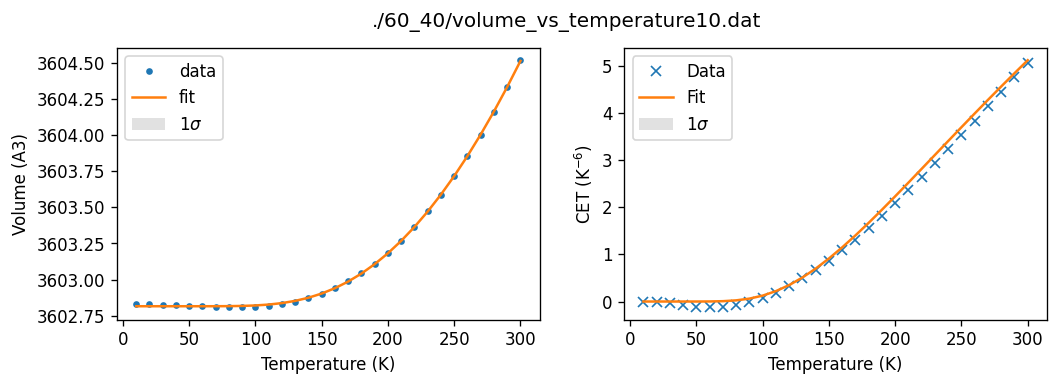

##################### ./60_40/volume_vs_temperature11.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32250
    # data points      = 30
    # variables        = 5
    chi-square         = 9.1105e-05
    reduced chi-square = 3.6442e-06
    Akaike info crit   = -371.141004
    Bayesian info crit = -364.135017
[[Variables]]
    a0:  3535.07166 +/- 6.0994e-04 (0.00%) (init = 400)
    a1:  715.828386 +/- 16.1785002 (2.26%) (init = 100)
    a2:  0 (fixed)
    a3:  1369.16534 +/- 210.805821 (15.40%) (init = 0)
    a4: -4.86472864 +/- 0.61254375 (12.59%) (init = 0)
    a5:  0.06333987 +/- 0.00196585 (3.10%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a5) =  0.944
    C(a1, a3) =  0.935
    C(a1, a5) =  0.782
    C(a4, a5) = -0.751
    C(a3, a4) = -0.515
    C(a0, a1) =  0.328
    C(a0, a4) =  0.267
    C(a1, a4) = -0.183
    C(a0, a3) =  0.161
Cost: 0.002825506136105105
---------- DE bounds

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00240  -0.00240  -0.002403535.07154  +0.00240  +0.00240  +0.00240
 a1: -70.04541 -39.95240 -16.13297 712.79537 +22.79656 +39.63956 +57.10180
 a3:-609.79220-386.23530-169.566791352.27639+274.85760+507.29317+777.28358
 a4:      -inf      -inf      -inf  -4.99947  +0.17334  +0.63684  +1.35366
 a5:  -0.00608  -0.00339  -0.00133   0.06333  +0.00183  +0.00309  +0.00431
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 443
    # data points      = 30
    # variables        = 5
    chi-square         = 8.8300e-05
    reduced chi-square = 3.5320e-06
    Akaike info crit   = -372.079008
    Bayesian info crit = -365.073021
[[Variables]]
    a0:  3535.07154 +/- 5.9976e-04 (0.00%) (init = 3535.072)
    a1:  712.795368 +/- 19.4307730 (2.73%) (init = 715.8284)
    a2:  0 (fixed)
    a3:  1352.27639 +/- 216.188610 (15.99%) (init = 1369.165)
    a4: -4.99947163 +/- 0.01867083 (0.37%) (init

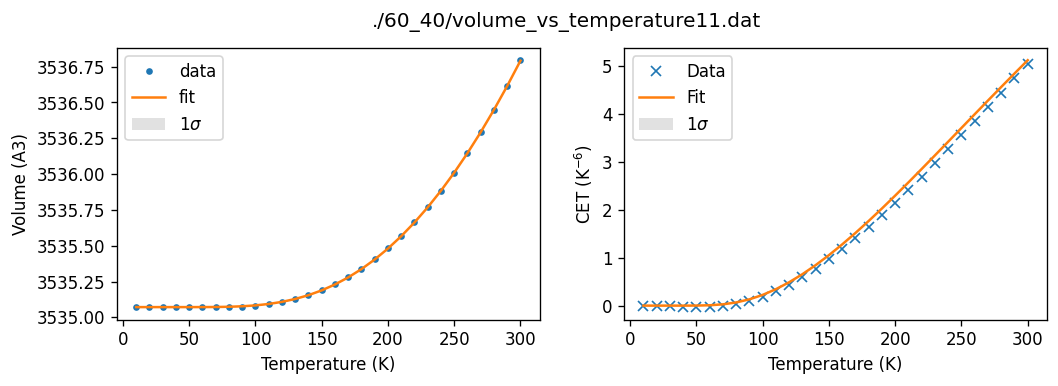

##################### ./60_40/volume_vs_temperature12.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33246
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00187701
    reduced chi-square = 7.5080e-05
    Akaike info crit   = -280.378189
    Bayesian info crit = -273.372203
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3701.48861 +/- 0.00238350 (0.00%) (init = 400)
    a1:  676.363044 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -452.602514 +/- 367.109415 (81.11%) (init = 0)
    a4:  0.45251238 +/- 2.99691454 (662.28%) (init = 0)
    a5:  0.03800096 +/- 0.00563615 (14.83%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.162
    C(a3, a4) = -1.028
    C(a3, a5) =  1.022
    C(a0, a4) =  0.626
    C(a0, a3) = -0.533
    C(a0, a5) = -0.267


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.0022182622128639196
---------- DE bounds ----------
a0 :         0	     3701.49	    8000
a1 :         0	     676.363	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -452.603	    3000
a4 :        -5	    0.452512	       5
a5 :     1e-05	    0.038001	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.429681372537463 < 1e-05 at iteration 2 and prob(a3=0.001056489445043553) = 0.0001655606634329916 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.004056489445043553) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.5703623444258628 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00779  -0.00779  -0.007793701.49718  +0.00779  +0.00779  +0.00779
 a1: -81.47597 -58.76955 -28.89537 459.47548 +40.19398 +88.80097+110.17112
 a3:      -inf      -inf      -inf   0.00306      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.28637  +1.36042  +3.65434  +5.98586
 a5:  -0.00333  -0.00220  -0.00108   0.03074  +0.00120  +0.00260  +0.00437
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1359
    # data points      = 30
    # variables        = 5
    chi-square         = 6.8822e-04
    reduced chi-square = 2.7529e-05
    Akaike info crit   = -310.478056
    Bayesian info crit = -303.472069
[[Variables]]
    a0:  3701.49718 +/- 0.00194866 (0.00%) (init = 3701.489)
    a1:  459.475480 +/- 36.7854875 (8.01%) (init = 676.363)
    a2:  0 (fixed)
    a3:  0.00305649 +/- 145.427316 (4757985.22%) (init = -452.6025)
    a4: -4.28637326 +/- 1.04893498 (24.47%

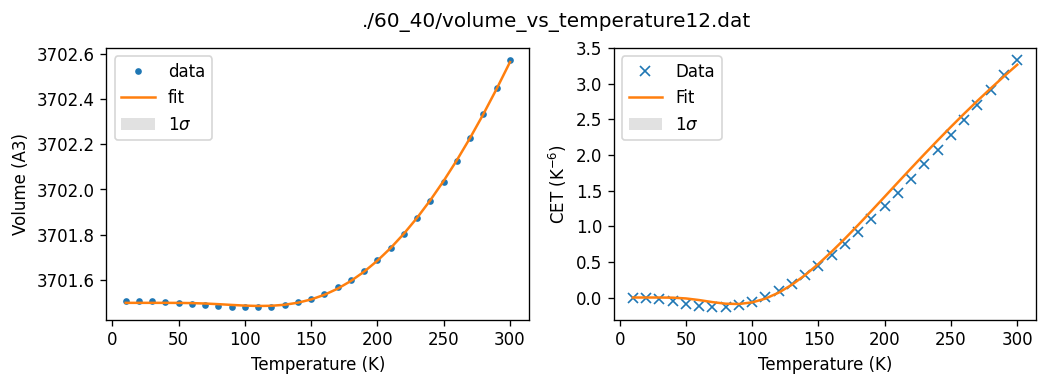

##################### ./60_40/volume_vs_temperature13.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34194
    # data points      = 30
    # variables        = 5
    chi-square         = 0.01093770
    reduced chi-square = 4.3751e-04
    Akaike info crit   = -227.502106
    Bayesian info crit = -220.496119
[[Variables]]
    a0:  3730.67172 +/- 0.01254130 (0.00%) (init = 400)
    a1:  696.898984 +/- 120.706353 (17.32%) (init = 100)
    a2:  0 (fixed)
    a3:  1758.23977 +/- 869.807402 (49.47%) (init = 0)
    a4: -0.70051996 +/- 17.5234060 (2501.49%) (init = 0)
    a5:  0.07369369 +/- 0.02539447 (34.46%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -0.984
    C(a1, a4) =  0.925
    C(a0, a4) =  0.869
    C(a0, a1) =  0.857
    C(a1, a5) = -0.845
    C(a0, a5) = -0.818
    C(a1, a3) =  0.322
    C(a3, a5) =  0.219
Cost: -0.003552483463408862
---------- DE bounds ----------
a0 :  

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0026858181463214467 < 1e-05 at iteration 3 and prob(a0=3730.6831459979794) = 0.9941399516713321 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a3=3000) = 0.9930715752094518 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 7.347784685567435e-05 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.001573419576679696 < 1e-05 at iteration 100 and prob(a4=-4.9924755438332165) = 0.10434596156558891 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.02095  -0.02095  -0.020953730.66743  +0.01571  +0.01571      +inf
 a1:-115.58514  -3.39236  -9.82745 612.70431 +40.57206 +84.83330+126.72884
 a3:-402.00605-401.70276-344.948591069.86745+100.31576+898.16580      +inf
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.01392  -0.00760  -0.00463   0.07366  +0.00040  +0.00046  +0.00464
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 889
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00752843
    reduced chi-square = 3.0114e-04
    Akaike info crit   = -238.707990
    Bayesian info crit = -231.702003
[[Variables]]
    a0:  3730.66743 +/- 0.00523755 (0.00%) (init = 3730.672)
    a1:  612.704305 +/- 38.8804874 (6.35%) (init = 696.899)
    a2:  0 (fixed)
    a3:  1069.86745 +/- 402.006055 (37.58%) (init = 1758.24)
    a4: -5.00000000 +/- 7.5245e-05 (0.00%) (init =

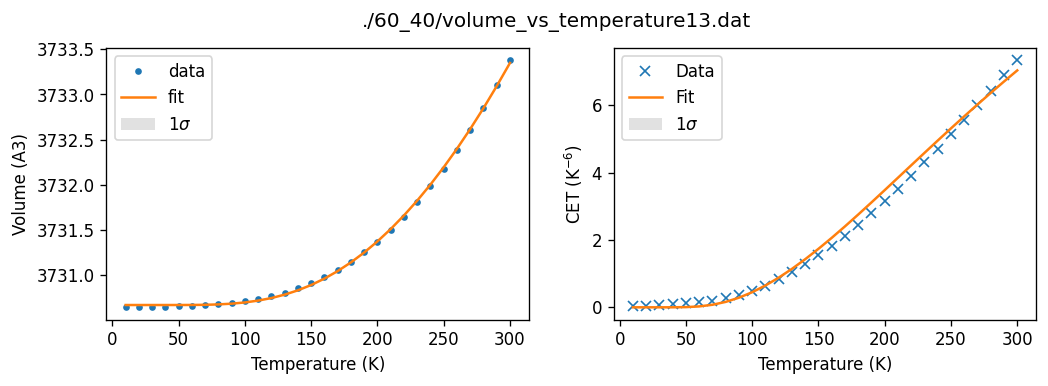

##################### ./60_40/volume_vs_temperature14.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 20706
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00133846
    reduced chi-square = 5.3538e-05
    Akaike info crit   = -290.523070
    Bayesian info crit = -283.517083
[[Variables]]
    a0:  3644.77099 +/- 0.00281612 (0.00%) (init = 400)
    a1:  444.203110 +/- 32.0795211 (7.22%) (init = 100)
    a2:  0 (fixed)
    a3: -143.993029 +/- 184.242720 (127.95%) (init = 0)
    a4: -4.35460802 +/- 1.13819505 (26.14%) (init = 0)
    a5:  0.03017103 +/- 0.00123705 (4.10%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.985
    C(a1, a3) = -0.934
    C(a1, a4) =  0.868
    C(a0, a5) = -0.400
    C(a4, a5) = -0.384
    C(a0, a1) = -0.345
    C(a3, a5) =  0.226
    C(a0, a3) =  0.143
    C(a1, a5) =  0.122
Cost: 0.007304435602691228
---------- DE bound

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-115.32070788000492) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01132  -0.01132  -0.011323644.77092  +0.01132  +0.01132  +0.01132
 a1: -75.19658 -54.94091 -38.35612 444.30287 +21.58284 +58.59667+107.19903
 a3:-949.33025-421.73008-122.67879-144.15088      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.35284  +0.76307  +2.74620  +6.43827
 a5:  -0.00584  -0.00240  -0.00117   0.03015  +0.00180  +0.00310  +0.00481
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 132
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00133853
    reduced chi-square = 5.3541e-05
    Akaike info crit   = -290.521496
    Bayesian info crit = -283.515509
[[Variables]]
    a0:  3644.77092 +/- 0.00283039 (0.00%) (init = 3644.771)
    a1:  444.302872 +/- 50.0377889 (11.26%) (init = 444.2031)
    a2:  0 (fixed)
    a3: -144.150885 +/- 312.991478 (217.13%) (init = -143.993)
    a4: -4.35284307 +/- 1.95747323 (44.97%) (i

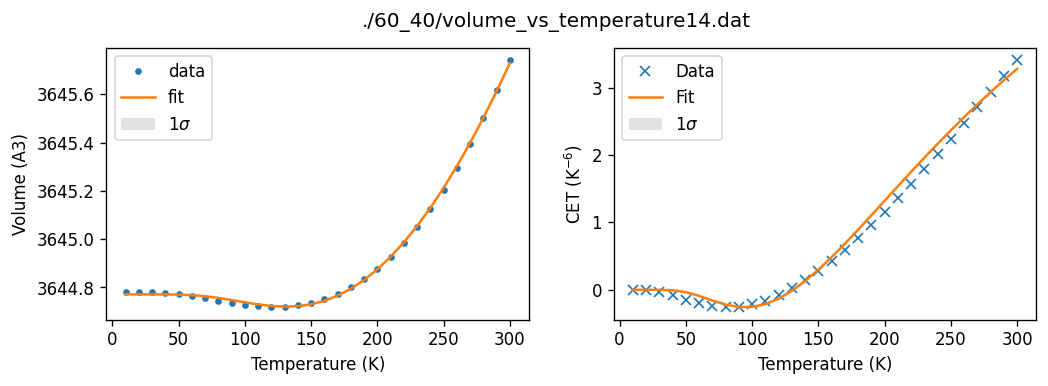

##################### ./60_40/volume_vs_temperature15.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 29484
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00159853
    reduced chi-square = 6.3941e-05
    Akaike info crit   = -285.195986
    Bayesian info crit = -278.189999
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3650.80787 +/- 0.00280022 (0.00%) (init = 400)
    a1:  661.382780 +/- 15.2853449 (2.31%) (init = 100)
    a2:  0 (fixed)
    a3: -665.310453 +/- 145.967893 (21.94%) (init = 0)
    a4:  3.33834709 +/-        nan (nan%) (init = 0)
    a5:  0.04363501 +/- 0.00416146 (9.54%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  4.029
    C(a1, a5) =  2.508
    C(a3, a5) =  1.067
    C(a0, a1) = -0.975
    C(a0, a3) = -0.953
    C(a0, a5) = -0.575


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.003237599285057513
---------- DE bounds ----------
a0 :         0	     3650.81	    8000
a1 :         0	     661.383	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     -665.31	    3000
a4 :        -5	     3.33835	       5
a5 :     1e-05	    0.043635	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.01205383289180778 < 1e-05 at iteration 4 and prob(a1=735.9365379474796) = 0.9810731643166674 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.42672696740868227 < 1e-05 at iteration 3 and prob(a3=0.0021906090238189785) = 0.00041524092098276606 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.06348465385762557 < 1e-05 at iteration 3 and prob(a3=0.008762436095275916) = 0.0006524543356380224 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.05527414530768735 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=5) = 0.9496972344547701 < max(s

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01088  -0.01088  -0.010883650.80978  +0.01088  +0.01088  +0.01088
 a1: -72.56699 -49.45184 -26.93632 515.09988 +66.35192+163.12735      +inf
 a3:      -inf      -inf      -inf   0.00548      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.84713  +2.94006      +inf      +inf
 a5:  -0.00685  -0.00419  -0.00218   0.04517  +0.00262  +0.00613      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1792
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00139786
    reduced chi-square = 5.5914e-05
    Akaike info crit   = -289.220364
    Bayesian info crit = -282.214377
[[Variables]]
    a0:  3650.80978 +/- 0.00271913 (0.00%) (init = 3650.808)
    a1:  515.099881 +/- 55.2091643 (10.72%) (init = 661.3828)
    a2:  0 (fixed)
    a3:  0.00547652 +/- 233.543540 (4264449.52%) (init = -665.3105)
    a4: -4.84713156 +/- 2.18530714 (45.0

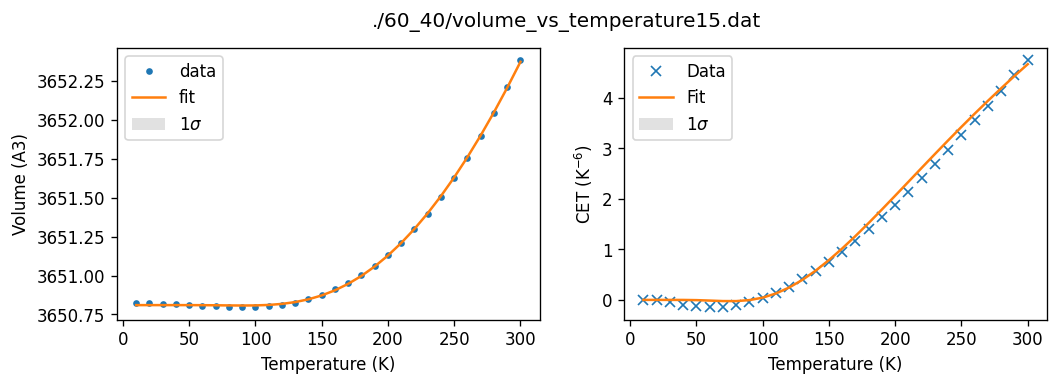

##################### ./60_40/volume_vs_temperature16.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 35730
    # data points      = 30
    # variables        = 5
    chi-square         = 5.3281e-04
    reduced chi-square = 2.1312e-05
    Akaike info crit   = -318.156275
    Bayesian info crit = -311.150288
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3700.45560 +/- 0.00116504 (0.00%) (init = 400)
    a1:  728.155669 +/- 22.3367512 (3.07%) (init = 100)
    a2:  0 (fixed)
    a3:  686.349091 +/- 320.345482 (46.67%) (init = 0)
    a4:  3.40561128 +/-        nan (nan%) (init = 0)
    a5:  0.04129545 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  1.230
    C(a0, a3) =  0.158
    C(a0, a1) = -0.118


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.0029741295429630554
---------- DE bounds ----------
a0 :         0	     3700.46	    8000
a1 :         0	     728.156	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     686.349	    3000
a4 :        -5	     3.40561	       5
a5 :     1e-05	   0.0412954	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.0020440296089050316 < 1e-05 at iteration 84 and prob(a4=-4.998869536018573) = 0.0456732504670889 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00237  -0.00237  -0.002373700.45297  +0.00178  +0.00178  +0.00178
 a1: -11.41665  -8.17035  -0.61549 724.96254  +7.14747 +14.08717 +14.16039
 a3:-176.94565-174.70658  -2.040451676.93163+111.03425+113.40015+177.02065
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00258  -0.00060  -0.00002   0.05806  +0.00023  +0.00034  +0.00043
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1457
    # data points      = 30
    # variables        = 5
    chi-square         = 7.9210e-05
    reduced chi-square = 3.1684e-06
    Akaike info crit   = -375.338149
    Bayesian info crit = -368.332162
[[Variables]]
    a0:  3700.45297 +/- 5.9188e-04 (0.00%) (init = 3700.456)
    a1:  724.962543 +/- 14.1603913 (1.95%) (init = 728.1557)
    a2:  0 (fixed)
    a3:  1676.93163 +/- 177.020648 (10.56%) (init = 686.3491)
    a4: -5.00000000 +/- 1.3458e-05 (0.00%) (ini

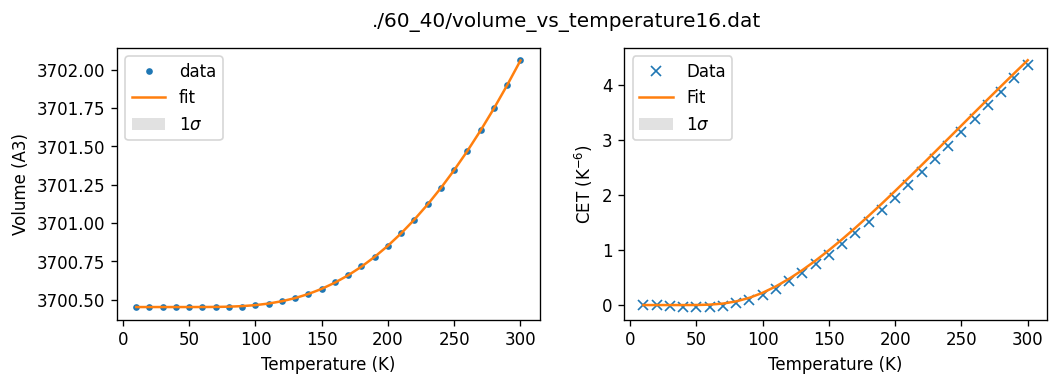

##################### ./60_40/volume_vs_temperature17.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 38004
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00205450
    reduced chi-square = 8.2180e-05
    Akaike info crit   = -277.667584
    Bayesian info crit = -270.661597
[[Variables]]
    a0:  3607.54467 +/- 0.01019748 (0.00%) (init = 400)
    a1:  567.710729 +/- 181.679089 (32.00%) (init = 100)
    a2:  0 (fixed)
    a3: -163.480269 +/- 131.932895 (80.70%) (init = 0)
    a4: -3.50766745 +/- 4.27766721 (121.95%) (init = 0)
    a5:  0.05868834 +/- 0.01450477 (24.71%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5) =  0.988
    C(a1, a4) =  0.968
    C(a0, a1) = -0.959
    C(a0, a5) = -0.959
    C(a4, a5) =  0.918
    C(a0, a4) = -0.906
    C(a3, a4) = -0.401
    C(a1, a3) = -0.165
Cost: 0.004271469497325597
---------- DE bounds ----------
a0 :    

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0009148808572270266 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.893553867009611) = 0.10725963390983535 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01268  -0.01268  -0.012683607.54749  +0.00951  +0.00951  +0.00951
 a1: -27.13720 -17.69027  -5.36458 528.72586 +18.81027 +22.08941 +22.19746
 a3: -16.18220  -9.84602  -4.29861 -80.60138  +6.11456 +11.66216 +17.98807
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00550  -0.00550  -0.00057   0.05716  +0.00009  +0.00018  +0.00230
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1670
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00192652
    reduced chi-square = 7.7061e-05
    Akaike info crit   = -279.597145
    Bayesian info crit = -272.591158
[[Variables]]
    a0:  3607.54749 +/- 0.00317069 (0.00%) (init = 3607.545)
    a1:  528.725864 +/- 22.2817161 (4.21%) (init = 567.7107)
    a2:  0 (fixed)
    a3: -80.6013759 +/- 35.1972677 (43.67%) (init = -163.4803)
    a4: -4.99999999 +/- 5.2958e-04 (0.01%) (in

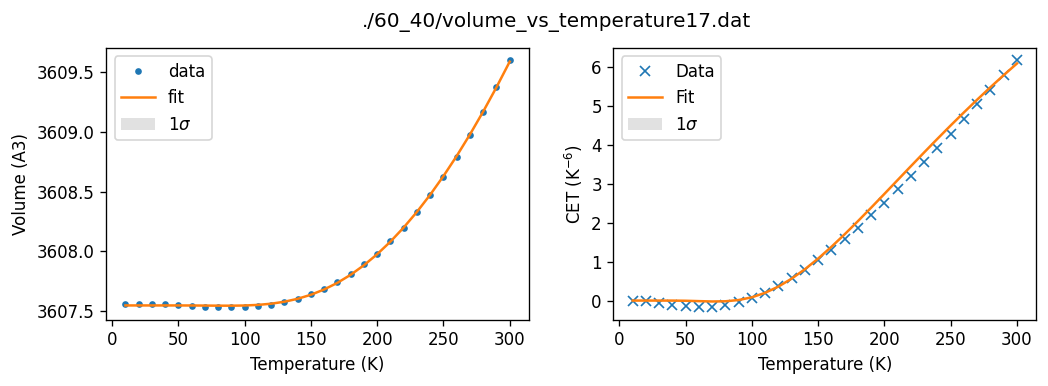

##################### ./60_40/volume_vs_temperature18.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33360
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00183693
    reduced chi-square = 7.3477e-05
    Akaike info crit   = -281.025641
    Bayesian info crit = -274.019654
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3642.38055 +/- 0.00240317 (0.00%) (init = 400)
    a1:  756.216474 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2762.73958 +/-        nan (nan%) (init = 0)
    a4: -4.65651555 +/-        nan (nan%) (init = 0)
    a5:  0.06434576 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.0029027957430116658
---------- DE bounds ----------
a0 :         0	     3642.38	    8000
a1 :         0	     756.216	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2762.74	    3000
a4 :        -5	    -4.65652	       5
a5 :     1e-05	   0.0643458	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.9985388165450875) = 0.09292408040332831 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00555  -0.00555  -0.005553642.37866  +0.00555  +0.00555  +0.00555
 a1: -11.66709 -16.61845 -13.07253 607.41997 +22.14639 +49.49795 +77.57873
 a3:-323.87789-274.80286-132.99535 838.94669+174.18493+319.75306 +14.82127
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00202  -0.00186  -0.00004   0.05604  +0.00206  +0.00377  +0.00604
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1241
    # data points      = 30
    # variables        = 5
    chi-square         = 5.1902e-04
    reduced chi-square = 2.0761e-05
    Akaike info crit   = -318.943046
    Bayesian info crit = -311.937059
[[Variables]]
    a0:  3642.37866 +/- 0.00138813 (0.00%) (init = 3642.381)
    a1:  607.419972 +/- 23.3973404 (3.85%) (init = 756.2165)
    a2:  0 (fixed)
    a3:  838.946689 +/- 162.892745 (19.42%) (init = 2762.74)
    a4: -5.00000000 +/- 7.2696e-06 (0.00%) (init

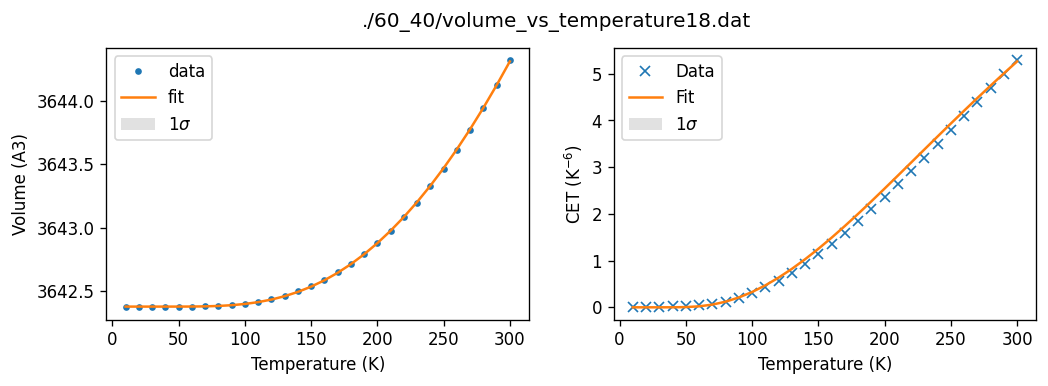

##################### ./60_40/volume_vs_temperature19.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 37968
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00309361
    reduced chi-square = 1.2374e-04
    Akaike info crit   = -265.388406
    Bayesian info crit = -258.382419
[[Variables]]
    a0:  3614.23610 +/- 0.00443862 (0.00%) (init = 400)
    a1:  562.278865 +/- 39.7969274 (7.08%) (init = 100)
    a2:  0 (fixed)
    a3:  1400.14627 +/- 423.496838 (30.25%) (init = 0)
    a4: -4.53652986 +/- 0.48685749 (10.73%) (init = 0)
    a5:  0.05342066 +/- 0.00256688 (4.81%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.988
    C(a3, a5) =  0.935
    C(a1, a5) =  0.904
    C(a0, a1) =  0.644
    C(a0, a5) =  0.597
    C(a0, a3) =  0.586
    C(a4, a5) = -0.347
    C(a0, a4) =  0.132
Cost: 0.005484158207764267
---------- DE bounds ----------
a0 :       

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00028052885416348375 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.9968234102591635) = 0.17624545897679214 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01000  -0.01000  -0.010003614.22917  +0.00500  +0.00500  +0.00500
 a1:  -2.60536  -0.77591  -0.42736 450.01061 +12.38384 +15.27009 +10.47324
 a3:-167.27770-163.68353  -2.17944 641.33289  +3.82408  +7.03656 +90.90659
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00308  -0.00293  -0.00151   0.04667  +0.00006  +0.00011  +0.00149
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1192
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00126971
    reduced chi-square = 5.0789e-05
    Akaike info crit   = -292.104858
    Bayesian info crit = -285.098871
[[Variables]]
    a0:  3614.22917 +/- 0.00250019 (0.00%) (init = 3614.236)
    a1:  450.010607 +/- 21.0201866 (4.67%) (init = 562.2789)
    a2:  0 (fixed)
    a3:  641.332894 +/- 95.3741900 (14.87%) (init = 1400.146)
    a4: -5.00000000 +/- 1.5804e-05 (0.00%) (ini

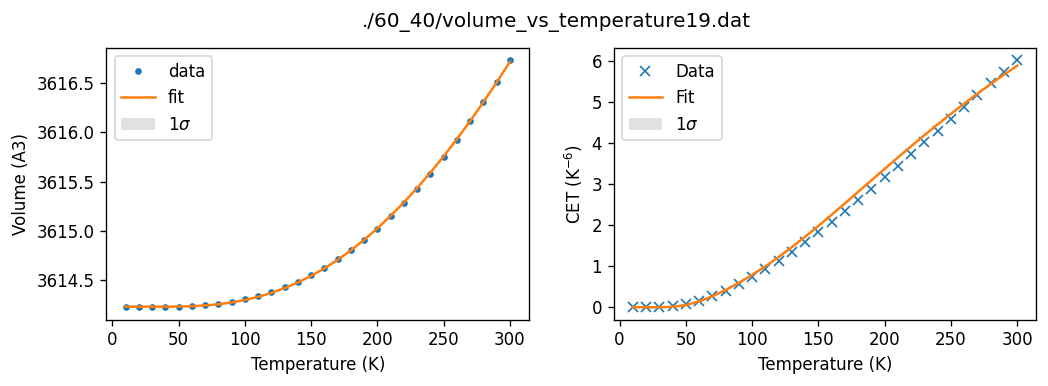

##################### ./60_40/volume_vs_temperature20.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 37272
    # data points      = 30
    # variables        = 5
    chi-square         = 1.6538e-04
    reduced chi-square = 6.6150e-06
    Akaike info crit   = -353.254589
    Bayesian info crit = -346.248602
[[Variables]]
    a0:  3639.52778 +/- 8.3203e-04 (0.00%) (init = 400)
    a1:  772.131089 +/- 21.3375328 (2.76%) (init = 100)
    a2:  0 (fixed)
    a3:  2108.00827 +/- 400.097309 (18.98%) (init = 0)
    a4: -4.36969534 +/- 0.62606289 (14.33%) (init = 0)
    a5:  0.07381382 +/- 0.00229627 (3.11%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.981
    C(a3, a5) =  0.918
    C(a1, a5) =  0.839
    C(a4, a5) = -0.696
    C(a0, a1) =  0.484
    C(a0, a3) =  0.415
    C(a3, a4) = -0.390
    C(a0, a5) =  0.353
    C(a1, a4) = -0.209
Cost: -0.0028704005299005075
---------- DE boun

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-3.8545469025296466) = 0.9870799730995329 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00274  -0.00274  -0.002743639.52700  +0.00137  +0.00137  +0.00137
 a1:  -0.54319  -0.36318  -0.21062 732.65091 +19.34330 +37.59068 +56.32546
 a3:-806.91846-540.27858-267.766091571.90950  +4.00404+247.93282 +10.79104
 a4:      -inf      -inf      -inf  -4.99996  +0.19610  +0.75616      +inf
 a5:  -0.00772  -0.00453  -0.00200   0.07175  +0.00006  +0.00010  +0.00015
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 878
    # data points      = 30
    # variables        = 5
    chi-square         = 1.2023e-04
    reduced chi-square = 4.8092e-06
    Akaike info crit   = -362.818947
    Bayesian info crit = -355.812960
[[Variables]]
    a0:  3639.52700 +/- 6.8411e-04 (0.00%) (init = 3639.528)
    a1:  732.650909 +/- 19.9214164 (2.72%) (init = 772.1311)
    a2:  0 (fixed)
    a3:  1571.90950 +/- 269.022838 (17.11%) (init = 2108.008)
    a4: -4.99995811 +/- 0.00569856 (0.11%) (init

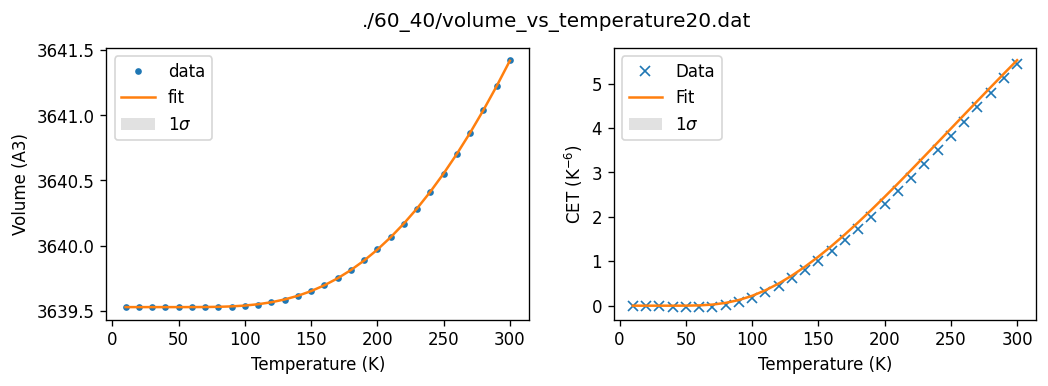

##################### ./60_40/volume_vs_temperature21.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36732
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00266293
    reduced chi-square = 1.0652e-04
    Akaike info crit   = -269.885818
    Bayesian info crit = -262.879831
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3647.83760 +/-        nan (nan%) (init = 400)
    a1:  611.991323 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  357.460614 +/-        nan (nan%) (init = 0)
    a4:  0.00122268 +/-        nan (nan%) (init = 0)
    a5:  0.04089300 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Cost: -0.0036210653743182775
---------- DE bounds ----------
a0 :         0	     3647.84	    8000
a1 :         0	     611.991	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     357.461	    3000
a4 :        -5	  0.00122268	       5
a5 :     1e-05	    0.040893	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=517.5135484892397) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=510.47137536762204) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=765.707063051433) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a4=0.010699374901215464) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=0.5510178074125958) = 0.8094278770288403 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.17764  -0.17001  -0.121603647.83769  +0.12160  +0.17001  +0.17764
 a1:      -inf      -inf      -inf 646.89194+112.76079+126.67418+139.37700
 a3:      -inf      -inf      -inf 638.08922      +inf      +inf      +inf
 a4:      -inf      -inf      -inf   0.01337  +0.30931      +inf      +inf
 a5:  -0.00789  -0.00796  -0.00792   0.04330      +inf      +inf      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 309
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00254280
    reduced chi-square = 1.0171e-04
    Akaike info crit   = -271.270550
    Bayesian info crit = -264.264563
##  Warning: uncertainties could not be estimated:
    a0:  at initial value
[[Variables]]
    a0:  3647.83769 +/-        nan (nan%) (init = 3647.838)
    a1:  646.891936 +/-        nan (nan%) (init = 611.9913)
    a2:  0 (fixed)
    a3:  638.089219 +/-        nan 

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a5=0.05196304078770431) = 0.0 < max(sigmas).
  warn(errmsg)


!!!!!!!!!!!!!! Negative variances. Running Nelder-Mead.


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.658212291434076) = 0.9167838455864783 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00731  -0.00731  -0.007313647.83311  +0.00731  +0.00731  +0.00731
 a1:  -1.43105  -0.93571  -0.50539 565.16359 +28.95848 +59.73586 +93.89590
 a3:-302.61641-222.68627-123.63049 684.49616  +4.91572+121.21123 +14.06134
 a4:      -inf      -inf      -inf  -4.99999  +0.10985      +inf      +inf
 a5:  -0.00646  -0.00422  -0.00208   0.04769  +0.00007  +0.00014  +0.00021
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 964
    # data points      = 30
    # variables        = 5
    chi-square         = 8.5039e-04
    reduced chi-square = 3.4016e-05
    Akaike info crit   = -304.130271
    Bayesian info crit = -297.124284
[[Variables]]
    a0:  3647.83311 +/- 0.00182751 (0.00%) (init = 3647.838)
    a1:  565.163591 +/- 27.8382529 (4.93%) (init = 646.8919)
    a2:  0 (fixed)
    a3:  684.496160 +/- 138.116027 (20.18%) (init = 638.0892)
    a4: -4.99999325 +/- 0.00170040 (0.03%) (init

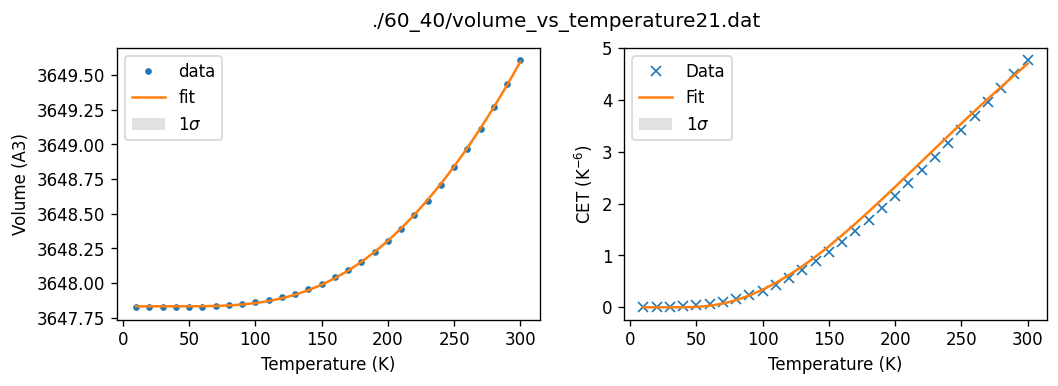

##################### ./60_40/volume_vs_temperature22.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36408
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00219160
    reduced chi-square = 8.7664e-05
    Akaike info crit   = -275.729686
    Bayesian info crit = -268.723699
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3630.39224 +/- 0.00228778 (0.00%) (init = 400)
    a1:  704.972724 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -671.485196 +/- 496.814567 (73.99%) (init = 0)
    a4:  1.95689806 +/- 4.06269117 (207.61%) (init = 0)
    a5:  0.03947563 +/- 0.00728239 (18.45%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a4, a5) = -1.227
    C(a3, a5) =  1.045
    C(a3, a4) = -1.042
    C(a0, a4) =  0.761
    C(a0, a3) = -0.569
    C(a0, a5) = -0.194


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: -0.0031152097085396235
---------- DE bounds ----------
a0 :         0	     3630.39	    8000
a1 :         0	     704.973	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -671.485	    3000
a4 :        -5	      1.9569	       5
a5 :     1e-05	   0.0394756	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.63446877940351 < 1e-05 at iteration 2 and prob(a3=-0.002007486967206205) = 0.00010986233834909894 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.10255795991367858 < 1e-05 at iteration 3 and prob(a3=0.002992513032793795) = 0.000474740900805039 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.9921065118030528 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00834  -0.00834  -0.008343630.40110  +0.00834  +0.00834  +0.00834
 a1: -42.91664 -28.22884 -14.21075 462.89744 +15.38811 +33.32075 +56.03859
 a3:      -inf      -inf      -inf  -0.00001      +inf      +inf      +inf
 a4:      -inf  -0.28131  -0.13342  -4.60802  +0.12805  +0.25848  +0.39897
 a5:  -0.00355  -0.00235  -0.00118   0.03226  +0.00132  +0.00285  +0.00480
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2035
    # data points      = 30
    # variables        = 5
    chi-square         = 7.9140e-04
    reduced chi-square = 3.1656e-05
    Akaike info crit   = -306.287045
    Bayesian info crit = -299.281058
[[Variables]]
    a0:  3630.40110 +/- 0.00208521 (0.00%) (init = 3630.392)
    a1:  462.897435 +/- 37.3409101 (8.07%) (init = 704.9727)
    a2:  0 (fixed)
    a3: -7.4870e-06 +/- 158.545566 (2117620684.03%) (init = -671.4852)
    a4: -4.60802408 +/- 1.11747626 (24

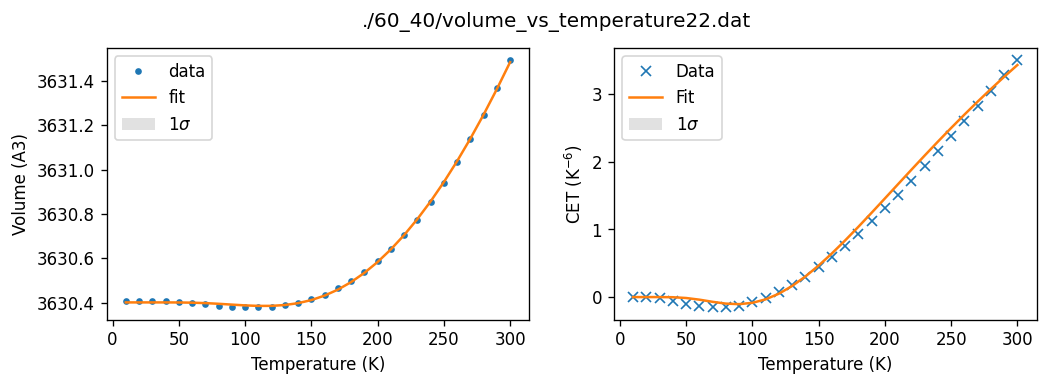

##################### ./60_40/volume_vs_temperature23.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 32724
    # data points      = 30
    # variables        = 5
    chi-square         = 6.0909e-04
    reduced chi-square = 2.4364e-05
    Akaike info crit   = -314.142353
    Bayesian info crit = -307.136367
[[Variables]]
    a0:  3704.98062 +/- 0.00151630 (0.00%) (init = 400)
    a1:  600.534363 +/- 20.8074600 (3.46%) (init = 100)
    a2:  0 (fixed)
    a3:  976.105310 +/- 180.507587 (18.49%) (init = 0)
    a4: -4.98487598 +/- 0.08181112 (1.64%) (init = 0)
    a5:  0.06304884 +/- 0.00199433 (3.16%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.994
    C(a1, a5) =  0.990
    C(a3, a5) =  0.978
    C(a0, a5) =  0.298
    C(a0, a1) =  0.257
    C(a0, a3) =  0.195
Cost: -0.003764518829939334
---------- DE bounds ----------
a0 :         0	     3704.98	    8000
a1 :         0	     

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.987167547040516) = 0.26860874432420506 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00605  -0.00605  -0.006053704.98056  +0.00453  +0.00453  +0.00453
 a1: -66.36578 -38.27316 -12.61752 600.36220 +20.86230 +20.88825  +7.79785
 a3:-362.32789-292.59760-161.56352 976.81735  +4.89082+353.29275+314.32530
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00650  -0.00419  -0.00176   0.06306  +0.00084  +0.00191  +0.00050
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 225
    # data points      = 30
    # variables        = 5
    chi-square         = 6.0562e-04
    reduced chi-square = 2.4225e-05
    Akaike info crit   = -314.313851
    Bayesian info crit = -307.307864
[[Variables]]
    a0:  3704.98056 +/- 0.00151131 (0.00%) (init = 3704.981)
    a1:  600.362204 +/- 20.8882536 (3.48%) (init = 600.5344)
    a2:  0 (fixed)
    a3:  976.817351 +/- 181.163947 (18.55%) (init = 976.1053)
    a4: -4.99999999 +/- 6.3843e-05 (0.00%) (init

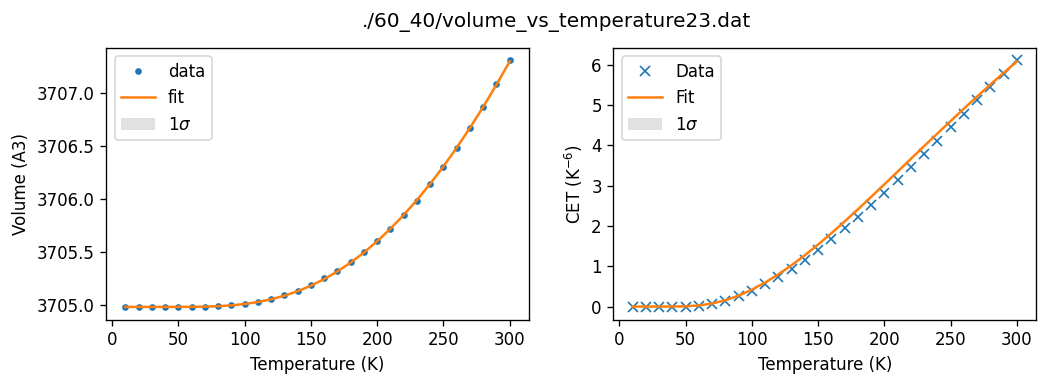

##################### ./60_40/volume_vs_temperature24.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34968
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00129348
    reduced chi-square = 5.1739e-05
    Akaike info crit   = -291.548474
    Bayesian info crit = -284.542487
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3719.36380 +/- 0.00146670 (0.00%) (init = 400)
    a1:  864.278014 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3:  2665.21659 +/-        nan (nan%) (init = 0)
    a4:  1.22540212 +/-        nan (nan%) (init = 0)
    a5:  0.05518709 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


Cost: 0.000866265192598803
---------- DE bounds ----------
a0 :         0	     3719.36	    8000
a1 :         0	     864.278	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	     2665.22	    3000
a4 :        -5	      1.2254	       5
a5 :     1e-05	   0.0551871	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00376  -0.00376  -0.003763719.36000  +0.00376  +0.00376  +0.00376
 a1: -81.83741 -55.47919 -30.59383 688.31984 +22.06922 +49.04233 +79.05791
 a3:-444.05483-332.08328-200.78067 896.35765+178.43205+437.92861+790.16678
 a4:      -inf      -inf      -inf  -4.99510  +0.12761  +0.52179  +1.26516
 a5:  -0.00703  -0.00475  -0.00260   0.05642  +0.00187  +0.00406  +0.00635
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 939
    # data points      = 30
    # variables        = 5
    chi-square         = 2.5853e-04
    reduced chi-square = 1.0341e-05
    Akaike info crit   = -339.850610
    Bayesian info crit = -332.844623
[[Variables]]
    a0:  3719.36000 +/- 9.4028e-04 (0.00%) (init = 3719.364)
    a1:  688.319839 +/- 24.1481488 (3.51%) (init = 864.278)
    a2:  0 (fixed)
    a3:  896.357652 +/- 178.594861 (19.92%) (init = 2665.217)
    a4: -4.99510429 +/- 0.05220510 (1.05%) (init 

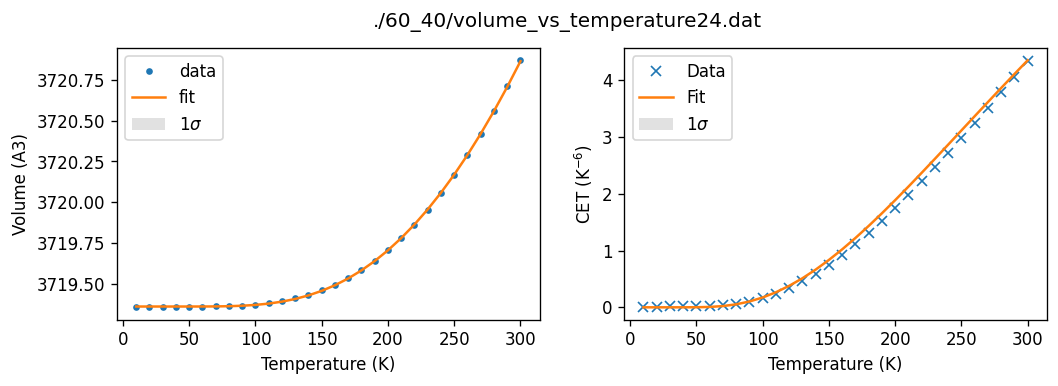

##################### ./60_40/volume_vs_temperature25.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 33906
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00342382
    reduced chi-square = 1.3695e-04
    Akaike info crit   = -262.345847
    Bayesian info crit = -255.339860
[[Variables]]
    a0:  3588.44048 +/- 0.00471636 (0.00%) (init = 400)
    a1:  403.751919 +/- 23.2748895 (5.76%) (init = 100)
    a2:  0 (fixed)
    a3: -229.367182 +/- 140.587890 (61.29%) (init = 0)
    a4: -4.77323542 +/- 0.72975579 (15.29%) (init = 0)
    a5:  0.02903145 +/- 0.00135090 (4.65%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.924
    C(a1, a3) = -0.895
    C(a1, a4) =  0.677
    C(a1, a5) =  0.471
    C(a0, a1) = -0.456
    C(a0, a5) = -0.437
    C(a4, a5) = -0.322
    C(a0, a3) =  0.211
Cost: 0.007365749157543178
---------- DE bounds ----------
a0 :       

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=-0.010891836093254755 < 1e-05 at iteration 2 and prob(a0=3588.4500084120104) = 0.9418011155406958 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00021525269219756723 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.997262102284418) = 0.0475277196225909 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01871  -0.01871  -0.018713588.44065  +0.00935      +inf      +inf
 a1:  -6.87841  -4.77603  -2.31653 398.69815  +3.21401  +6.95557  +8.74165
 a3:-1051.05997-459.53298  -3.23248-188.86873  +4.58390  +8.75157 +14.58004
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00128  -0.00115  -0.00005   0.02914  +0.00008  +0.00014  +0.00022
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 893
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00338129
    reduced chi-square = 1.3525e-04
    Akaike info crit   = -262.720847
    Bayesian info crit = -255.714860
[[Variables]]
    a0:  3588.44065 +/- 0.00467675 (0.00%) (init = 3588.44)
    a1:  398.698149 +/- 17.5388686 (4.40%) (init = 403.7519)
    a2:  0 (fixed)
    a3: -188.868728 +/- 53.8967999 (28.54%) (init = -229.3672)
    a4: -5.00000000 +/- 1.3621e-05 (0.00%) (ini

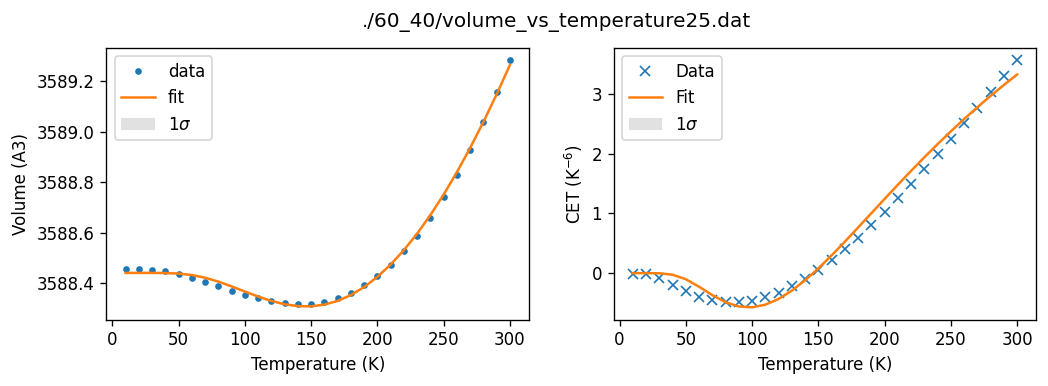

##################### ./60_40/volume_vs_temperature26.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 36084
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00596593
    reduced chi-square = 2.3864e-04
    Akaike info crit   = -245.686636
    Bayesian info crit = -238.680649
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a0:  3628.23444 +/-        nan (nan%) (init = 400)
    a1:  446.311394 +/-        nan (nan%) (init = 100)
    a2:  0 (fixed)
    a3: -1146.32731 +/-        nan (nan%) (init = 0)
    a4: -0.02060132 +/-        nan (nan%) (init = 0)
    a5:  0.01974275 +/-        nan (nan%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


Cost: -0.006186675770095462
---------- DE bounds ----------
a0 :         0	     3628.23	    8000
a1 :         0	     446.311	    2000
a2 :   -150000	           0	  150000
a3 :     -3000	    -1146.33	    3000
a4 :        -5	  -0.0206013	       5
a5 :     1e-05	   0.0197427	    0.15
a6 :        -5	           0	     0.0
a7 :     1e-05	       0.001	   0.001
a8 :         0	       0.001	     300


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.00045014416839389093 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.9377795797427675) = 0.2703036686217978 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.02129  -0.02129  -0.021293628.23874  +0.01064  +0.01064  +0.01064
 a1: -15.77101 -14.84165 -14.72393 373.78054 +16.59395 +42.77191 +72.27571
 a3: -63.07303 -63.07303  -3.22441-249.25816  +4.46472  +8.56485 +13.18908
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00107  -0.00107  -0.00074   0.02486  +0.00008  +0.00051  +0.00022
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1234
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00410935
    reduced chi-square = 1.6437e-04
    Akaike info crit   = -256.870648
    Bayesian info crit = -249.864661
[[Variables]]
    a0:  3628.23874 +/- 0.00532175 (0.00%) (init = 3628.234)
    a1:  373.780543 +/- 15.8002503 (4.23%) (init = 446.3114)
    a2:  0 (fixed)
    a3: -249.258157 +/- 63.0730334 (25.30%) (init = -1146.327)
    a4: -4.99999995 +/- 3.0955e-04 (0.01%) (in

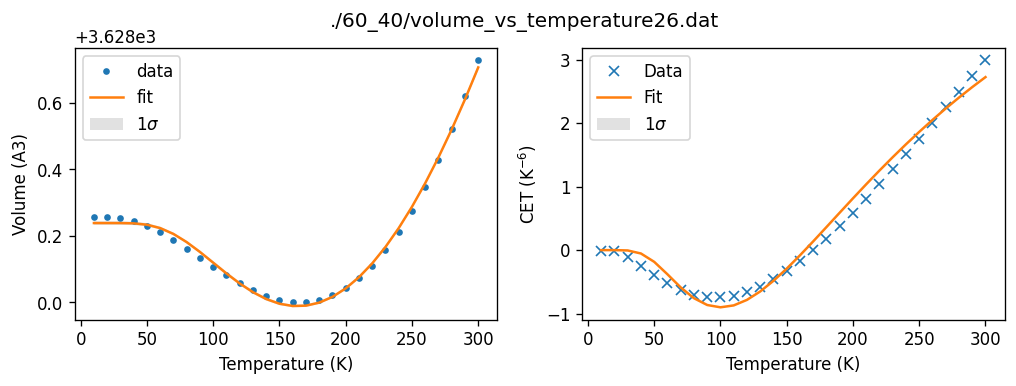

##################### ./60_40/volume_vs_temperature27.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34314
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00385437
    reduced chi-square = 1.5417e-04
    Akaike info crit   = -258.792336
    Bayesian info crit = -251.786349
[[Variables]]
    a0:  3635.57319 +/- 0.00398191 (0.00%) (init = 400)
    a1:  685.367394 +/- 54.9705472 (8.02%) (init = 100)
    a2:  0 (fixed)
    a3: -1120.38383 +/- 141.720686 (12.65%) (init = 0)
    a4:  4.28159613 +/- 1.02000810 (23.82%) (init = 0)
    a5:  0.02851930 +/- 0.00564094 (19.78%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5) =  0.923
    C(a3, a4) = -0.871
    C(a0, a1) = -0.432
    C(a0, a5) = -0.384
    C(a0, a3) = -0.352
    C(a3, a5) =  0.223
    C(a1, a4) =  0.192
    C(a4, a5) = -0.169
Cost: 0.0019262896221334813
---------- DE bounds ----------
a0 :     

/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3635.574309697013) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a0=3635.579984539437) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a1=555.9746536300921) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327:

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:      -inf      -inf      -inf3635.57715      +inf      +inf      +inf
 a1:      -inf      -inf      -inf 572.46857 +18.34336 +40.00499 +68.29104
 a3: -89.41718 -56.01513 -27.66958-1125.17300      +inf      +inf      +inf
 a4:      -inf      -inf      -inf   4.98262      +inf      +inf      +inf
 a5:  -0.00368  -0.00246  -0.00125   0.01605      +inf      +inf      +inf
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 385
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00153163
    reduced chi-square = 6.1265e-05
    Akaike info crit   = -286.478597
    Bayesian info crit = -279.472610
##  Warning: uncertainties could not be estimated:
    a0:  at initial value
[[Variables]]
    a0:  3635.57715 +/- 0.00283742 (0.00%) (init = 3635.573)
    a1:  572.468572 +/- 16.4939180 (2.88%) (init = 685.3674)
    a2:  0 (fixed)
    a3: -1125.17300 +/-        n

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a5=0.0173329486136698) = 0.0 < max(sigmas).
  warn(errmsg)


!!!!!!!!!!!!!! Negative variances. Running Nelder-Mead.


/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.005669498368297355) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=0.008504247552446031) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.9962567806346121 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00929  -0.00929  -0.009293635.58025  +0.00929  +0.00929  +0.00929
 a1: -90.84390 -61.94513 -32.08736 402.14876 +36.07255 +78.93286+132.98475
 a3:      -inf      -inf      -inf   0.00709      +inf      +inf      +inf
 a4:      -inf  -1.04899  -0.60526  -3.59188  +0.93700  +2.50308  +5.34092
 a5:  -0.00265  -0.00175  -0.00086   0.02337  +0.00096  +0.00206  +0.00345
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1662
    # data points      = 30
    # variables        = 5
    chi-square         = 8.8933e-04
    reduced chi-square = 3.5573e-05
    Akaike info crit   = -302.787335
    Bayesian info crit = -295.781348
[[Variables]]
    a0:  3635.58025 +/- 0.00232272 (0.00%) (init = 3635.577)
    a1:  402.148755 +/- 33.3634851 (8.30%) (init = 572.4686)
    a2:  0 (fixed)
    a3:  0.00708687 +/- 110.267562 (1555941.01%) (init = -1125.173)
    a4: -3.59187838 +/- 0.72722666 (20.25

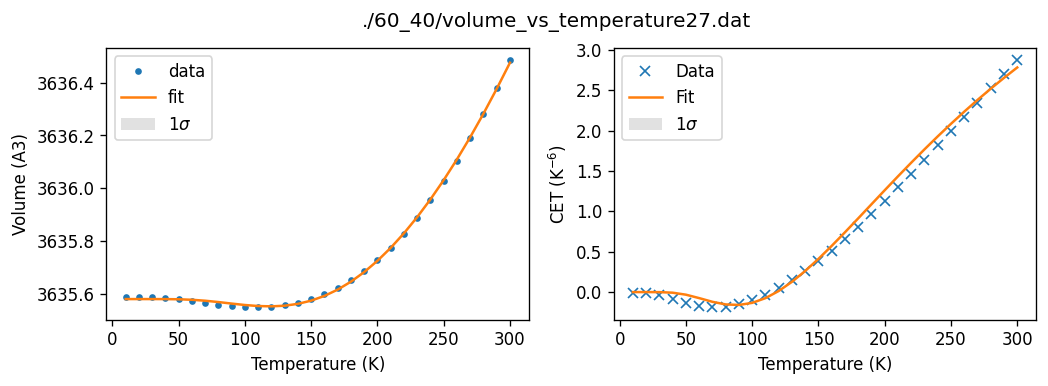

##################### ./60_40/volume_vs_temperature28.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 39438
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00400029
    reduced chi-square = 1.6001e-04
    Akaike info crit   = -257.677546
    Bayesian info crit = -250.671559
[[Variables]]
    a0:  3637.58574 +/- 0.00410487 (0.00%) (init = 400)
    a1:  618.138081 +/- 21.8235436 (3.53%) (init = 100)
    a2:  0 (fixed)
    a3:  1509.58003 +/- 216.362852 (14.33%) (init = 0)
    a4: -4.96214493 +/- 0.14353857 (2.89%) (init = 0)
    a5:  0.04823412 +/- 0.00133447 (2.77%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a3) =  0.971
    C(a1, a5) =  0.854
    C(a3, a5) =  0.747
    C(a0, a5) =  0.540
    C(a0, a1) =  0.424
    C(a0, a3) =  0.285
    C(a4, a5) = -0.200
Cost: 0.004394238454551669
---------- DE bounds ----------
a0 :         0	     3637.59	    800

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.0 < max(sigmas)
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:319: UserWarning: maxiter=200 reached and prob(a4=-4.992862779556105) = 0.29766077802593494 < max(sigmas).
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.00960  -0.00960  -0.009603637.57223  +0.00480  +0.00480  +0.00480
 a1: -73.31044  -0.96037  -2.77643 423.32652  +0.26863  +0.72487  +3.71744
 a3: -31.09341  -4.17020  -1.62424 489.34935  +3.12145  +5.66584  +8.53363
 a4:      -inf      -inf      -inf  -5.00000      +inf      +inf      +inf
 a5:  -0.00152  -0.00131  -0.00003   0.03657  +0.00069  +0.00009  +0.00450
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1016
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00100634
    reduced chi-square = 4.0253e-05
    Akaike info crit   = -299.079096
    Bayesian info crit = -292.073109
[[Variables]]
    a0:  3637.57223 +/- 0.00240025 (0.00%) (init = 3637.586)
    a1:  423.326521 +/- 25.9060360 (6.12%) (init = 618.1381)
    a2:  0 (fixed)
    a3:  489.349346 +/- 61.4848706 (12.56%) (init = 1509.58)
    a4: -4.99999999 +/- 3.5509e-05 (0.00%) (init

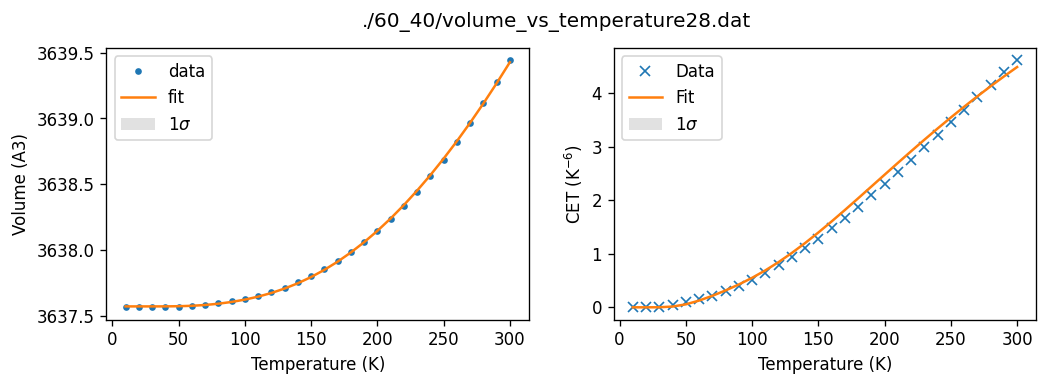

##################### ./60_40/volume_vs_temperature29.dat ######################


/home/giovani/.local/lib/python3.6/site-packages/lmfit/minimizer.py:2257: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  RuntimeWarning)


[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 34134
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00247726
    reduced chi-square = 9.9090e-05
    Akaike info crit   = -272.054004
    Bayesian info crit = -265.048018
[[Variables]]
    a0:  3618.37547 +/- 0.00428839 (0.00%) (init = 400)
    a1:  451.405421 +/- 40.4547329 (8.96%) (init = 100)
    a2:  0 (fixed)
    a3: -725.083513 +/- 435.052386 (60.00%) (init = 0)
    a4: -0.73561651 +/- 2.53943329 (345.21%) (init = 0)
    a5:  0.01602904 +/- 0.00308017 (19.22%) (init = 0.001)
    a6:  0 (fixed)
    a7:  0.001 (fixed)
    a8:  0.001 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a3, a4) = -0.993
    C(a1, a3) = -0.975
    C(a4, a5) = -0.958
    C(a1, a4) =  0.946
    C(a3, a5) =  0.919
    C(a1, a5) = -0.817
    C(a0, a1) = -0.547
    C(a0, a3) =  0.435
    C(a0, a4) = -0.399
    C(a0, a5) =  0.258
Cost: -0.0054071101467

/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.03947982138652151) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(a3=-0.02631988092434767) = 0.0 < max(sigmas).
  warn(errmsg)
/home/giovani/.local/lib/python3.6/site-packages/lmfit/confidence.py:312: UserWarning: Bound reached with prob(a4=-5) = 0.6285476444476965 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 a0:  -0.01340  -0.01340  -0.013403618.37853  +0.01340  +0.01340  +0.01340
 a1: -78.90425 -52.93183 -26.92667 355.07303 +28.91948 +61.29917 +99.16148
 a3:      -inf      -inf      -inf  -0.03290      +inf      +inf      +inf
 a4:      -inf      -inf      -inf  -4.57922  +0.68401  +1.81828  +3.80559
 a5:  -0.00373  -0.00177  -0.00088   0.01925  +0.00096  +0.00204  +0.00324
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 867
    # data points      = 30
    # variables        = 5
    chi-square         = 0.00170552
    reduced chi-square = 6.8221e-05
    Akaike info crit   = -283.252551
    Bayesian info crit = -276.246564
[[Variables]]
    a0:  3618.37853 +/- 0.00334944 (0.00%) (init = 3618.375)
    a1:  355.073027 +/- 27.4229124 (7.72%) (init = 451.4054)
    a2:  0 (fixed)
    a3: -0.03289985 +/- 117.004869 (355639.51%) (init = -725.0835)
    a4: -4.57922133 +/- 0.53749374 (11.74%)

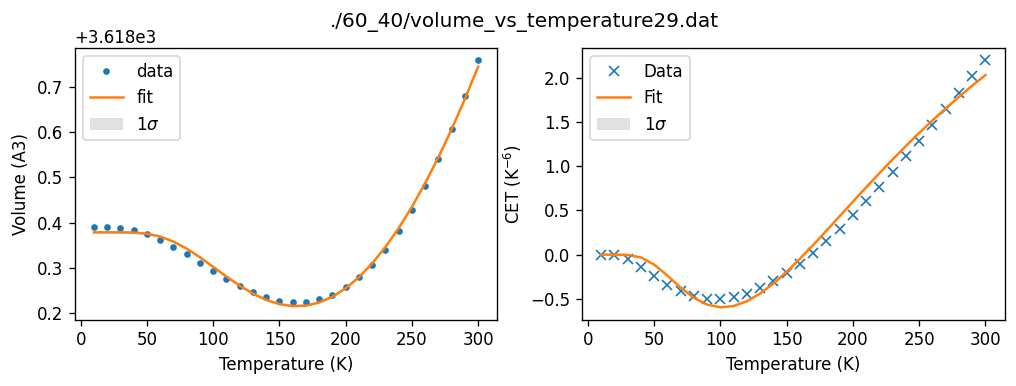

In [5]:
from glob import glob
import numpy as np
from uncertainties import correlated_values
import uncertainties.unumpy as unp
from uncertainties import ufloat

X_fit = []
Y_fit = []
Z_fit = []
X_data = []
Y_data = []
Z_data = []

folder = '60_40'

print('{0:#^100}'.format(' Shrink '))

for i in range(30):
    
    file = f'./{folder}/volume_vs_temperature{i:02d}.dat'
    
    print('{0:#^80}'.format(' '+str(file)+' '))
            
    M = np.genfromtxt(file)
    temperature = M[:,0]
    volume = M[:,1]
    
    cte_data = CET_numerical(temperature, volume)
    
    result0 = fit_volume_vs_temperature(temperature, volume, cte_data)
    result = second_fit(temperature, volume, cte_data, result0)
    
    has_uncertainties = False
    
    t_fit = np.array(temperature)
    
    if not np.any(np.diag(result.covar) < 0):
        has_uncertainties = True        
    else:
        print('!!!!!!!!!!!!!! Negative variances. Running Nelder-Mead.')
        result = second_fit(temperature, volume, cte_data, result)
        if np.any(np.diag(result.covar) >= 0):
            has_uncertainties = True
    
    
    (a0, a1, a2, a3, a4, a5, a6, a7, a8) = [result.params[k].value for k in result.params.keys()]
    
    if has_uncertainties:
        try:
            (a0, a1, a3, a4, a5) = correlated_values([a0, a1, a3, a4, a5], result.covar)
        except Exception as e:
            print("The execption", e.__class__, "occurred when trying to construct correlated variables a0, a1, a4, a4, a5.")
            print("Ignoring correlation and treating variables as independent")
            a0 = ufloat(a0,np.sqrt(np.diag(result.covar)[0]))
            a1 = ufloat(a1,np.sqrt(np.diag(result.covar)[1]))
            a3 = ufloat(a3,np.sqrt(np.diag(result.covar)[2]))
            a4 = ufloat(a4,np.sqrt(np.diag(result.covar)[3]))
            a5 = ufloat(a5,np.sqrt(np.diag(result.covar)[4]))
        
        v_fit = volume_fcn_unc(t_fit, a0, a1, a2, a3, a4, a5, a6, a7, a8)
        v_nominal = np.array([x.nominal_value for x in v_fit])
        v_unc = np.array([x.std_dev for x in v_fit])
        
        cte_fit = CET_fcn_unc(t_fit, a0, a1, a2, a3, a4, a5, a6, a7, a8)
        cte_nominal = np.array([x.nominal_value for x in cte_fit])
        cte_unc = np.array([x.std_dev for x in cte_fit])
        
        plot_unc(temperature, volume, t_fit, v_nominal, v_unc, cte_data, cte_nominal, cte_unc, file)
        
    else:
        v_nominal = volume_fcn(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
        v_unc = np.zeros(len(v_nominal))
        
        cte_nominal = CET_fcn_unc(t_fit,a0, a1, a2, a3, a4, a5, a6, a7, a8)
        cte_unc = np.zeros(len(v_nominal))
        
        plot(temperature, volume, t_fit, v_nominal, cte_data, cte_nominal, file)
            
    with open(file.rstrip('dat')+'fit','w') as f:
        f.write('#{T:5}\t{V:10}\t{Vfit:10}\t{Vunc:10}\t{CET:10}\t{CETfit:10}\t{CETunc:10}\n'.format(T='T(K)',V='V(A3)',Vfit='Vfit(A3)',Vunc='Vunc(A3)',CET='CET(1/K)',CETfit='CETfit(1/K)',CETunc='CETunc(1/K)'))
        for i in range(len(temperature)):
            f.write('{T:5.1f}\t{V:10f}\t{Vfit:10f}\t{Vunc:10f}\t{CET: 10e}\t{CETfit: 10e}\t{CETunc: 10e}\n'.format(T=temperature[i],V=volume[i],Vfit=v_nominal[i],Vunc=v_unc[i],CET=cte_data[i],CETfit=cte_nominal[i],CETunc=cte_unc[i]))
    


In [26]:
with open('sp2_60_40.txt','w') as f:
    for i in range(30):
        A = np.genfromtxt(f'./60_40/volume_vs_temperature{i:02d}.fit')
        cet100 = A[9,5]
        cet300 = A[29,5]
        f.write(f'{i:02d}\t{cet100:0.6e}\t{cet300:0.6e}\n')